In [3]:
import pandas as pd
import plotly.express as px
import re
import torch
from transformers import DistilBertTokenizerFast, DistilBertForTokenClassification, Trainer, TrainingArguments


c:\Users\Lenovo\.conda\envs\pii\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
email_pii = pd.read_csv("Data/pii_emails.csv")

In [5]:
print(email_pii.head(10))
print(email_pii['text'].iloc[1])

   message_id                                               text
0           1  From: ufields@example.net\r\nTo: hpeters@examp...
1           2  From: cguzman@example.com\r\nTo: uwilson@examp...
2           3  From: hallgregory@example.com\r\nTo: howellshe...
3           4  From: makaylariley@example.net\r\nTo: btaylor@...
4           5  From: edwardnavarro@example.com\r\nTo: kaylasi...
5           6  From: matthewdavis@example.net\r\nTo: christin...
6           7  From: asullivan@example.org\r\nTo: thernandez@...
7           8  From: egoodman@example.net\r\nTo: morsecrystal...
8           9  From: melissaarnold@example.org\r\nTo: fdunn@e...
9          10  From: alisonwilliams@example.com\r\nTo: gparso...
From: cguzman@example.com
To: uwilson@example.org
Subject: Important Account Update Tax ID: 940-82-8356 IBAN: GB07YZJP29744473359884 Bank Account: 9096795282 Credit Card: 4583441465276114 PPSN: 4356169AW

Dear Joel,

We have updated our terms and conditions. Please review the changes 

In [6]:
email_pii.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   message_id  20000 non-null  int64 
 1   text        20000 non-null  object
dtypes: int64(1), object(1)
memory usage: 312.6+ KB


In [7]:
email_pii.describe()

,message_id
count,20000.000000
mean,10000.500000
std,5773.647028
min,1.000000
25%,5000.750000
50%,10000.500000
75%,15000.250000
max,20000.000000


In [8]:
email_pii.isnull().sum()

message_id    0
text          0
dtype: int64

In [9]:
#Check the distribution of PII fields
pii_kws = ["PPSN", "Credit Card","Address","IBAN","Phone Number","Tax ID", "From", "To"]
pii_counts = {kw: email_pii["text"].str.contains(kw, case=False).sum() for kw in pii_kws}
print(pii_counts)

pii_counts_df = pd.DataFrame(pii_counts.items(), columns=["PII field", "Count"])

fig = px.bar(pii_counts_df, x="PII field", y="Count", title="Distribution of PII fields in emails")
fig.show()

{'PPSN': 5795, 'Credit Card': 5772, 'Address': 5767, 'IBAN': 5701, 'Phone Number': 5721, 'Tax ID': 5716, 'From': 20000, 'To': 20000}


In [10]:
email_pii["email_len"] = email_pii["text"].apply(len)

print(email_pii["email_len"].describe())

fig = px.histogram(email_pii, x="email_len", title="Distribution of email lengths")
fig.show()

count    20000.000000
mean       361.089950
std         81.192087
min        237.000000
25%        306.000000
50%        335.000000
75%        423.000000
max        584.000000
Name: email_len, dtype: float64


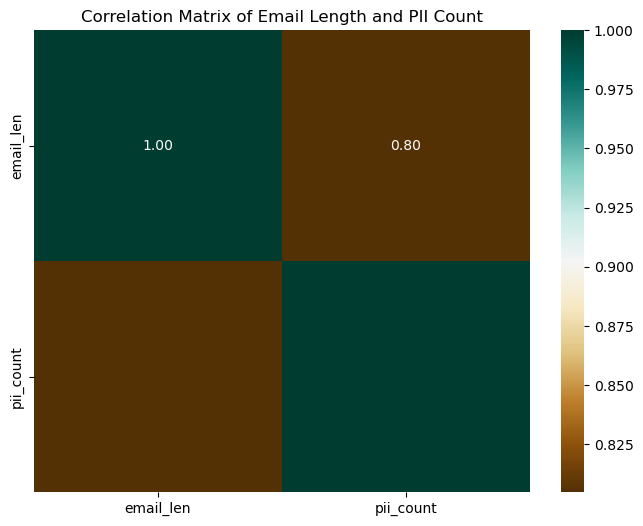

In [11]:
#Get the PII counts and find corelation with email length
email_pii['pii_count'] = email_pii['text'].apply(lambda x: sum([x.lower().count(kw.lower()) for kw in pii_kws]))
corelations = email_pii['email_len'].corr(email_pii['pii_count'])

import seaborn as sns
import matplotlib.pyplot as plt
correlation_matrix = email_pii[['email_len', 'pii_count']].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='BrBG', fmt='.2f')
plt.title('Correlation Matrix of Email Length and PII Count')
plt.show()

In [12]:
pii_patterns = {
    "Tax ID": r"\b\d{2}-\d{2}-\d{4}\b",
    "IBAN": r"\b[A-Z0-9]{15,34}\b",
    "Bank Account": r"\b\d{8,12}\b",
    "Credit Card": r"\b\d{13,19}\b",
    "PPSN": r"\b[0-9A-Z]{8,10}\b",
    "Phone Number": r"\b\d{3}[-.\s]?\d{3}[-.\s]?\d{4}\b",
    "Account Number": r"\b\d{8,12}\b",
    "Address": r"\b\d{1,5}\s[A-Za-z\s]{1,20}\b",
    "Email": r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b"
}

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14520\2229593153.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



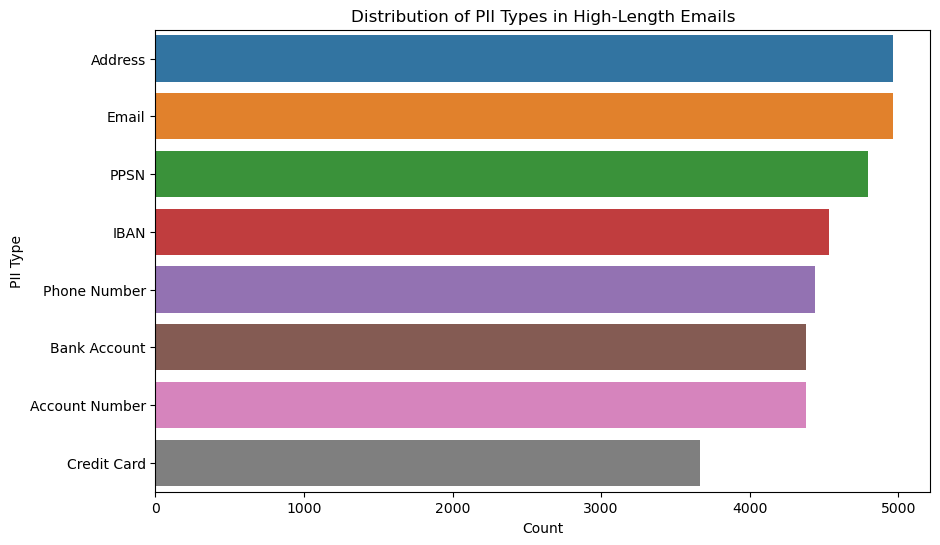

In [13]:
thresh = email_pii['email_len'].quantile(0.75)


high_len_emails = email_pii[email_pii['email_len'] > thresh]

def extract_piis(text):
    pii_types = []
    for label, pattern in pii_patterns.items():
        if re.search(pattern, text):
            pii_types.append(label)
    return pii_types

high_len_emails['pii_types'] = high_len_emails['text'].apply(extract_piis)

all_pii_labls = [pii for sublist in high_len_emails['pii_types'] for pii in sublist]


plt.figure(figsize=(10, 6))
sns.countplot(y=all_pii_labls, order=pd.Series(all_pii_labls).value_counts().index)
plt.title('Distribution of PII Types in High-Length Emails')
plt.xlabel('Count')
plt.ylabel('PII Type')
plt.show()

In [14]:
final_dataset = email_pii[['message_id', 'text']]

In [15]:
def rm_wildcards(text):
    return re.sub("[\r\n]+", " ", text)

In [16]:
final_dataset['text'] = final_dataset['text'].apply(rm_wildcards)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14520\393520320.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [17]:
final_dataset['text'].iloc[1]

'From: cguzman@example.com To: uwilson@example.org Subject: Important Account Update Tax ID: 940-82-8356 IBAN: GB07YZJP29744473359884 Bank Account: 9096795282 Credit Card: 4583441465276114 PPSN: 4356169AW Dear Joel, We have updated our terms and conditions. Please review the changes at your earliest convenience. Your account details are as follows: Account Number: 6940366308 Update Date: 1997-09-09 Best regards, Crawford Inc Phone Number: 426.405.8218'

In [18]:
def label_pii(text):
    labels = ["O"] * len(text)
    for label, pattern in pii_patterns.items():
        for match in re.finditer(pattern, text):
            start, end = match.span()
            labels[start:end] = [label] * (end - start)
    return labels

In [19]:
final_dataset['labels'] = final_dataset['text'].apply(label_pii)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14520\1818621034.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [20]:
final_dataset.head()

,message_id,text,labels
0,1,From: ufields@example.net To: hpeters@example....,"[O, O, O, O, O, O, Email, Email, Email, Email,..."
1,2,From: cguzman@example.com To: uwilson@example....,"[O, O, O, O, O, O, Email, Email, Email, Email,..."
2,3,From: hallgregory@example.com To: howellsheila...,"[O, O, O, O, O, O, Email, Email, Email, Email,..."
3,4,From: makaylariley@example.net To: btaylor@exa...,"[O, O, O, O, O, O, Email, Email, Email, Email,..."
4,5,From: edwardnavarro@example.com To: kaylasimps...,"[O, O, O, O, O, O, Email, Email, Email, Email,..."


In [21]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [22]:
label_list = ["O"] + list(pii_patterns.keys())
label_map = {label: i for i, label in enumerate(label_list)}

def encode_example(text, labels):
    encoding = tokenizer(text, truncation=True, padding='max_length', max_length=512)
    labels_ids = [label_map.get(label, label_map["O"]) for label in labels]
    tokens = tokenizer.convert_ids_to_tokens(encoding['input_ids'])
    return tokens, labels_ids

In [23]:
processed_data = []
for index, row in final_dataset.iterrows():
    text = row['text']
    labels = row['labels']
    tokens, labels_ids = encode_example(text, labels)
    processed_data.append({
        "text": text,
        "tokens": tokens,
        "labels": labels_ids
    })

processed_df = pd.DataFrame(processed_data)

In [24]:
processed_df.head()

,text,tokens,labels
0,From: ufields@example.net To: hpeters@example....,"[[CLS], from, :, u, ##fields, @, example, ., n...","[0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, ..."
1,From: cguzman@example.com To: uwilson@example....,"[[CLS], from, :, c, ##gu, ##zman, @, example, ...","[0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, ..."
2,From: hallgregory@example.com To: howellsheila...,"[[CLS], from, :, hall, ##gre, ##gor, ##y, @, e...","[0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, ..."
3,From: makaylariley@example.net To: btaylor@exa...,"[[CLS], from, :, ma, ##ka, ##yla, ##ril, ##ey,...","[0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, ..."
4,From: edwardnavarro@example.com To: kaylasimps...,"[[CLS], from, :, edward, ##na, ##var, ##ro, @,...","[0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, ..."


In [25]:
# class PiiDataset(torch.utils.data.Dataset):
#     def __init__(self, texts, labels):
#         self.encodings = tokenizer(texts, truncation=True, max_length=512)
#         self.labels = labels

#     def __getitem__(self, idx):
#         item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
#         item['labels'] = torch.tensor(self.labels[idx])
#         return item

#     def __len__(self):
#         return len(self.labels)
    
# texts = processed_df['text'].tolist()
# labels = processed_df['labels'].tolist()

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["text"], truncation=True, padding='max_length', max_length=512, return_tensors='pt')
    labels = []

    for i, label in enumerate(examples['labels']):
        label_ids = label[:512] + [0] * (512 - len(label))
        labels.append(label_ids)
    tokenized_inputs['labels'] = torch.tensor(labels)
    return tokenized_inputs

In [26]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer)

In [27]:
from datasets import Dataset
dataset = Dataset.from_pandas(processed_df)

tokenized_dataset = dataset.map(tokenize_and_align_labels, batched=True)

train_data = tokenized_dataset.train_test_split(test_size=0.2)['train']
test_data = tokenized_dataset.train_test_split(test_size=0.2)['test']


Map: 100%|██████████| 20000/20000 [00:08<00:00, 2394.05 examples/s]


In [28]:

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print(device)

cuda


In [27]:
import optuna
from transformers import EarlyStoppingCallback
def objective(trial):
    model = DistilBertForTokenClassification.from_pretrained('distilbert-base-uncased', num_labels=len(label_list)).to(device)

    batch_size = trial.suggest_categorical('per_device_train_batch_size', [4, 8, 16])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-5)
    num_train_epochs = trial.suggest_int('num_train_epochs', 2, 4)

    training_args = TrainingArguments(
        output_dir='./results',
        eval_strategy='epoch',
        save_strategy='epoch',
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        learning_rate=learning_rate,
        num_train_epochs=num_train_epochs,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model='eval_loss',
        greater_is_better=False,
        do_train=True,
        do_eval=True
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_data,
        eval_dataset=test_data,
        tokenizer=tokenizer,
        data_collator=data_collator,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    # Train the model
    trainer.train()

    # Evaluate the model
    eval_result = trainer.evaluate()

    # Return the evaluation metric (loss in this case)
    return eval_result['eval_loss']

# Create Optuna study and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Print best trial
best_trial = study.best_trial
print(f"Best trial: {best_trial.value}")
print("Best hyperparameters: ", best_trial.params)

# Visualize optimization history and parameter importance
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()

 36%|███▌      | 1420/4000 [1:07:08<1:58:07,  2.75s/it]

{'loss': 0.1326, 'grad_norm': 0.872765064239502, 'learning_rate': 1.4267435470760382e-05, 'epoch': 1.42}


 36%|███▌      | 1430/4000 [1:07:36<1:58:03,  2.76s/it]

{'loss': 0.1242, 'grad_norm': 1.1297374963760376, 'learning_rate': 1.4212135333276814e-05, 'epoch': 1.43}


 36%|███▌      | 1440/4000 [1:08:03<1:56:05,  2.72s/it]

{'loss': 0.1368, 'grad_norm': 0.8533995747566223, 'learning_rate': 1.4156835195793247e-05, 'epoch': 1.44}


 36%|███▋      | 1450/4000 [1:08:30<1:55:33,  2.72s/it]

{'loss': 0.1497, 'grad_norm': 0.982770562171936, 'learning_rate': 1.4101535058309678e-05, 'epoch': 1.45}


 36%|███▋      | 1460/4000 [1:08:57<1:55:01,  2.72s/it]

{'loss': 0.1393, 'grad_norm': 0.7706300020217896, 'learning_rate': 1.4046234920826113e-05, 'epoch': 1.46}


 37%|███▋      | 1470/4000 [1:09:24<1:54:40,  2.72s/it]

{'loss': 0.1347, 'grad_norm': 0.9399568438529968, 'learning_rate': 1.3990934783342544e-05, 'epoch': 1.47}


 37%|███▋      | 1480/4000 [1:09:52<1:54:14,  2.72s/it]

{'loss': 0.1382, 'grad_norm': 1.462398648262024, 'learning_rate': 1.3935634645858977e-05, 'epoch': 1.48}


 37%|███▋      | 1490/4000 [1:10:19<1:53:54,  2.72s/it]

{'loss': 0.1464, 'grad_norm': 1.776781678199768, 'learning_rate': 1.3880334508375409e-05, 'epoch': 1.49}


 38%|███▊      | 1500/4000 [1:10:46<1:53:15,  2.72s/it]

{'loss': 0.1482, 'grad_norm': 1.6310051679611206, 'learning_rate': 1.3825034370891843e-05, 'epoch': 1.5}


 38%|███▊      | 1510/4000 [1:11:13<1:52:44,  2.72s/it]

{'loss': 0.1393, 'grad_norm': 1.2671220302581787, 'learning_rate': 1.3769734233408276e-05, 'epoch': 1.51}


 38%|███▊      | 1520/4000 [1:11:40<1:52:22,  2.72s/it]

{'loss': 0.1483, 'grad_norm': 1.2468950748443604, 'learning_rate': 1.3714434095924708e-05, 'epoch': 1.52}


 38%|███▊      | 1530/4000 [1:12:08<1:52:00,  2.72s/it]

{'loss': 0.1359, 'grad_norm': 1.0815961360931396, 'learning_rate': 1.3659133958441142e-05, 'epoch': 1.53}


 38%|███▊      | 1540/4000 [1:12:35<1:51:29,  2.72s/it]

{'loss': 0.1265, 'grad_norm': 1.0260009765625, 'learning_rate': 1.3603833820957574e-05, 'epoch': 1.54}


 39%|███▉      | 1550/4000 [1:13:02<1:50:53,  2.72s/it]

{'loss': 0.1362, 'grad_norm': 1.1923500299453735, 'learning_rate': 1.3548533683474007e-05, 'epoch': 1.55}


 39%|███▉      | 1560/4000 [1:13:29<1:50:33,  2.72s/it]

{'loss': 0.156, 'grad_norm': 1.5255136489868164, 'learning_rate': 1.3493233545990438e-05, 'epoch': 1.56}


 39%|███▉      | 1570/4000 [1:13:56<1:50:09,  2.72s/it]

{'loss': 0.1446, 'grad_norm': 1.2839792966842651, 'learning_rate': 1.3437933408506873e-05, 'epoch': 1.57}


 40%|███▉      | 1580/4000 [1:14:24<1:49:41,  2.72s/it]

{'loss': 0.1377, 'grad_norm': 0.8969563841819763, 'learning_rate': 1.3382633271023304e-05, 'epoch': 1.58}


 40%|███▉      | 1590/4000 [1:14:51<1:49:16,  2.72s/it]

{'loss': 0.1403, 'grad_norm': 1.3238030672073364, 'learning_rate': 1.3327333133539737e-05, 'epoch': 1.59}


 40%|████      | 1600/4000 [1:15:18<1:48:48,  2.72s/it]

{'loss': 0.1353, 'grad_norm': 0.8712587356567383, 'learning_rate': 1.3272032996056168e-05, 'epoch': 1.6}


 40%|████      | 1610/4000 [1:15:45<1:48:33,  2.73s/it]

{'loss': 0.1496, 'grad_norm': 1.3341668844223022, 'learning_rate': 1.3216732858572603e-05, 'epoch': 1.61}


 40%|████      | 1620/4000 [1:16:12<1:47:59,  2.72s/it]

{'loss': 0.1341, 'grad_norm': 0.7536705732345581, 'learning_rate': 1.3161432721089034e-05, 'epoch': 1.62}


 41%|████      | 1630/4000 [1:16:40<1:47:18,  2.72s/it]

{'loss': 0.1206, 'grad_norm': 1.057386040687561, 'learning_rate': 1.3106132583605468e-05, 'epoch': 1.63}


 41%|████      | 1640/4000 [1:17:07<1:47:04,  2.72s/it]

{'loss': 0.1302, 'grad_norm': 0.9480739235877991, 'learning_rate': 1.3050832446121899e-05, 'epoch': 1.64}


 41%|████▏     | 1650/4000 [1:17:34<1:46:27,  2.72s/it]

{'loss': 0.1398, 'grad_norm': 1.513847827911377, 'learning_rate': 1.2995532308638334e-05, 'epoch': 1.65}


 42%|████▏     | 1660/4000 [1:18:01<1:46:00,  2.72s/it]

{'loss': 0.1295, 'grad_norm': 1.0338836908340454, 'learning_rate': 1.2940232171154765e-05, 'epoch': 1.66}


 42%|████▏     | 1670/4000 [1:18:29<1:45:24,  2.71s/it]

{'loss': 0.1351, 'grad_norm': 0.9392371773719788, 'learning_rate': 1.2884932033671198e-05, 'epoch': 1.67}


 42%|████▏     | 1680/4000 [1:18:56<1:45:07,  2.72s/it]

{'loss': 0.1553, 'grad_norm': 1.2454289197921753, 'learning_rate': 1.282963189618763e-05, 'epoch': 1.68}


 42%|████▏     | 1690/4000 [1:19:23<1:44:36,  2.72s/it]

{'loss': 0.1289, 'grad_norm': 0.9207826852798462, 'learning_rate': 1.2774331758704062e-05, 'epoch': 1.69}


 42%|████▎     | 1700/4000 [1:19:50<1:44:23,  2.72s/it]

{'loss': 0.1365, 'grad_norm': 1.5036040544509888, 'learning_rate': 1.2719031621220494e-05, 'epoch': 1.7}


 43%|████▎     | 1710/4000 [1:20:17<1:43:51,  2.72s/it]

{'loss': 0.128, 'grad_norm': 0.9082962274551392, 'learning_rate': 1.2663731483736928e-05, 'epoch': 1.71}


 43%|████▎     | 1720/4000 [1:20:45<1:43:16,  2.72s/it]

{'loss': 0.1262, 'grad_norm': 0.921894907951355, 'learning_rate': 1.260843134625336e-05, 'epoch': 1.72}


 43%|████▎     | 1730/4000 [1:21:12<1:43:02,  2.72s/it]

{'loss': 0.1311, 'grad_norm': 1.7973482608795166, 'learning_rate': 1.2553131208769793e-05, 'epoch': 1.73}


 44%|████▎     | 1740/4000 [1:21:39<1:42:20,  2.72s/it]

{'loss': 0.1262, 'grad_norm': 0.8831154704093933, 'learning_rate': 1.2497831071286224e-05, 'epoch': 1.74}


 44%|████▍     | 1750/4000 [1:22:06<1:41:59,  2.72s/it]

{'loss': 0.1405, 'grad_norm': 1.2935552597045898, 'learning_rate': 1.2442530933802659e-05, 'epoch': 1.75}


 44%|████▍     | 1760/4000 [1:22:33<1:41:21,  2.72s/it]

{'loss': 0.1397, 'grad_norm': 1.4213687181472778, 'learning_rate': 1.2387230796319092e-05, 'epoch': 1.76}


 44%|████▍     | 1770/4000 [1:23:01<1:41:05,  2.72s/it]

{'loss': 0.1113, 'grad_norm': 0.7869880795478821, 'learning_rate': 1.2331930658835523e-05, 'epoch': 1.77}


 44%|████▍     | 1780/4000 [1:23:28<1:40:37,  2.72s/it]

{'loss': 0.1423, 'grad_norm': 1.0589383840560913, 'learning_rate': 1.2276630521351958e-05, 'epoch': 1.78}


 45%|████▍     | 1790/4000 [1:23:55<1:39:59,  2.71s/it]

{'loss': 0.1388, 'grad_norm': 1.739151954650879, 'learning_rate': 1.222133038386839e-05, 'epoch': 1.79}


 45%|████▌     | 1800/4000 [1:24:22<1:39:54,  2.72s/it]

{'loss': 0.1274, 'grad_norm': 1.4044067859649658, 'learning_rate': 1.2166030246384822e-05, 'epoch': 1.8}


 45%|████▌     | 1810/4000 [1:24:49<1:39:17,  2.72s/it]

{'loss': 0.1245, 'grad_norm': 1.1214057207107544, 'learning_rate': 1.2110730108901254e-05, 'epoch': 1.81}


 46%|████▌     | 1820/4000 [1:25:17<1:38:42,  2.72s/it]

{'loss': 0.1303, 'grad_norm': 1.3571265935897827, 'learning_rate': 1.2055429971417688e-05, 'epoch': 1.82}


 46%|████▌     | 1830/4000 [1:25:44<1:38:20,  2.72s/it]

{'loss': 0.1267, 'grad_norm': 1.1014586687088013, 'learning_rate': 1.200012983393412e-05, 'epoch': 1.83}


 46%|████▌     | 1840/4000 [1:26:11<1:37:47,  2.72s/it]

{'loss': 0.1192, 'grad_norm': 0.9719032645225525, 'learning_rate': 1.1944829696450553e-05, 'epoch': 1.84}


 46%|████▋     | 1850/4000 [1:26:38<1:37:32,  2.72s/it]

{'loss': 0.1275, 'grad_norm': 1.2307645082473755, 'learning_rate': 1.1889529558966984e-05, 'epoch': 1.85}


 46%|████▋     | 1860/4000 [1:27:05<1:36:56,  2.72s/it]

{'loss': 0.1106, 'grad_norm': 1.2165371179580688, 'learning_rate': 1.1834229421483419e-05, 'epoch': 1.86}


 47%|████▋     | 1870/4000 [1:27:33<1:36:48,  2.73s/it]

{'loss': 0.1318, 'grad_norm': 1.2578290700912476, 'learning_rate': 1.177892928399985e-05, 'epoch': 1.87}


 47%|████▋     | 1880/4000 [1:28:00<1:35:59,  2.72s/it]

{'loss': 0.1226, 'grad_norm': 0.8070262670516968, 'learning_rate': 1.1723629146516283e-05, 'epoch': 1.88}


 47%|████▋     | 1890/4000 [1:28:27<1:35:24,  2.71s/it]

{'loss': 0.1266, 'grad_norm': 1.63969886302948, 'learning_rate': 1.1668329009032714e-05, 'epoch': 1.89}


 48%|████▊     | 1900/4000 [1:28:54<1:35:06,  2.72s/it]

{'loss': 0.1378, 'grad_norm': 1.7208387851715088, 'learning_rate': 1.1613028871549149e-05, 'epoch': 1.9}


 48%|████▊     | 1910/4000 [1:29:22<1:34:41,  2.72s/it]

{'loss': 0.1273, 'grad_norm': 1.7548202276229858, 'learning_rate': 1.155772873406558e-05, 'epoch': 1.91}


 48%|████▊     | 1920/4000 [1:29:49<1:34:21,  2.72s/it]

{'loss': 0.1262, 'grad_norm': 1.471401333808899, 'learning_rate': 1.1502428596582013e-05, 'epoch': 1.92}


 48%|████▊     | 1930/4000 [1:30:16<1:33:41,  2.72s/it]

{'loss': 0.1392, 'grad_norm': 0.9349820017814636, 'learning_rate': 1.1447128459098445e-05, 'epoch': 1.93}


 48%|████▊     | 1940/4000 [1:30:43<1:33:20,  2.72s/it]

{'loss': 0.12, 'grad_norm': 0.8167663812637329, 'learning_rate': 1.139182832161488e-05, 'epoch': 1.94}


 49%|████▉     | 1950/4000 [1:31:10<1:32:52,  2.72s/it]

{'loss': 0.1313, 'grad_norm': 1.118038296699524, 'learning_rate': 1.133652818413131e-05, 'epoch': 1.95}


 49%|████▉     | 1960/4000 [1:31:38<1:32:17,  2.71s/it]

{'loss': 0.1153, 'grad_norm': 1.6447639465332031, 'learning_rate': 1.1281228046647744e-05, 'epoch': 1.96}


 49%|████▉     | 1970/4000 [1:32:05<1:32:14,  2.73s/it]

{'loss': 0.1088, 'grad_norm': 0.6607552170753479, 'learning_rate': 1.1225927909164175e-05, 'epoch': 1.97}


 50%|████▉     | 1980/4000 [1:32:32<1:31:34,  2.72s/it]

{'loss': 0.1181, 'grad_norm': 1.3582842350006104, 'learning_rate': 1.117062777168061e-05, 'epoch': 1.98}


 50%|████▉     | 1990/4000 [1:32:59<1:31:07,  2.72s/it]

{'loss': 0.1404, 'grad_norm': 0.8663450479507446, 'learning_rate': 1.1115327634197041e-05, 'epoch': 1.99}


 50%|█████     | 2000/4000 [1:33:26<1:30:37,  2.72s/it]

{'loss': 0.1253, 'grad_norm': 1.0980464220046997, 'learning_rate': 1.1060027496713474e-05, 'epoch': 2.0}



 50%|█████     | 2000/4000 [1:35:20<1:30:37,  2.72s/it]

{'eval_loss': 0.10376771539449692, 'eval_runtime': 113.5594, 'eval_samples_per_second': 35.224, 'eval_steps_per_second': 2.201, 'epoch': 2.0}


 50%|█████     | 2010/4000 [1:35:48<2:16:14,  4.11s/it] 

{'loss': 0.1294, 'grad_norm': 1.231313705444336, 'learning_rate': 1.1004727359229907e-05, 'epoch': 2.01}


 50%|█████     | 2020/4000 [1:36:15<1:31:05,  2.76s/it]

{'loss': 0.1168, 'grad_norm': 1.0616871118545532, 'learning_rate': 1.0949427221746339e-05, 'epoch': 2.02}


 51%|█████     | 2030/4000 [1:36:43<1:29:27,  2.72s/it]

{'loss': 0.1209, 'grad_norm': 0.8757421970367432, 'learning_rate': 1.0894127084262772e-05, 'epoch': 2.03}


 51%|█████     | 2040/4000 [1:37:10<1:29:01,  2.73s/it]

{'loss': 0.1166, 'grad_norm': 1.1732150316238403, 'learning_rate': 1.0838826946779205e-05, 'epoch': 2.04}


 51%|█████▏    | 2050/4000 [1:37:37<1:28:25,  2.72s/it]

{'loss': 0.1207, 'grad_norm': 1.7821749448776245, 'learning_rate': 1.0783526809295638e-05, 'epoch': 2.05}


 52%|█████▏    | 2060/4000 [1:38:04<1:27:56,  2.72s/it]

{'loss': 0.1184, 'grad_norm': 1.274540901184082, 'learning_rate': 1.0728226671812069e-05, 'epoch': 2.06}


 52%|█████▏    | 2070/4000 [1:38:32<1:27:39,  2.73s/it]

{'loss': 0.1048, 'grad_norm': 1.2246687412261963, 'learning_rate': 1.0672926534328502e-05, 'epoch': 2.07}


 52%|█████▏    | 2080/4000 [1:38:59<1:27:06,  2.72s/it]

{'loss': 0.1168, 'grad_norm': 1.3148064613342285, 'learning_rate': 1.0617626396844935e-05, 'epoch': 2.08}


 52%|█████▏    | 2090/4000 [1:39:26<1:26:34,  2.72s/it]

{'loss': 0.1165, 'grad_norm': 1.6755872964859009, 'learning_rate': 1.0562326259361368e-05, 'epoch': 2.09}


 52%|█████▎    | 2100/4000 [1:39:53<1:26:02,  2.72s/it]

{'loss': 0.1229, 'grad_norm': 1.3603485822677612, 'learning_rate': 1.05070261218778e-05, 'epoch': 2.1}


 53%|█████▎    | 2110/4000 [1:40:20<1:25:42,  2.72s/it]

{'loss': 0.1143, 'grad_norm': 0.9834997653961182, 'learning_rate': 1.0451725984394232e-05, 'epoch': 2.11}


 53%|█████▎    | 2120/4000 [1:40:48<1:25:27,  2.73s/it]

{'loss': 0.1251, 'grad_norm': 1.4532849788665771, 'learning_rate': 1.0396425846910666e-05, 'epoch': 2.12}


 53%|█████▎    | 2130/4000 [1:41:15<1:24:45,  2.72s/it]

{'loss': 0.1113, 'grad_norm': 0.8168620467185974, 'learning_rate': 1.0341125709427099e-05, 'epoch': 2.13}


 54%|█████▎    | 2140/4000 [1:41:42<1:24:21,  2.72s/it]

{'loss': 0.113, 'grad_norm': 2.5330276489257812, 'learning_rate': 1.0285825571943532e-05, 'epoch': 2.14}


 54%|█████▍    | 2150/4000 [1:42:09<1:23:55,  2.72s/it]

{'loss': 0.1302, 'grad_norm': 1.1516460180282593, 'learning_rate': 1.0230525434459965e-05, 'epoch': 2.15}


 54%|█████▍    | 2160/4000 [1:42:37<1:23:25,  2.72s/it]

{'loss': 0.1144, 'grad_norm': 0.9146854877471924, 'learning_rate': 1.0175225296976398e-05, 'epoch': 2.16}


 54%|█████▍    | 2170/4000 [1:43:04<1:22:57,  2.72s/it]

{'loss': 0.1294, 'grad_norm': 0.9002195596694946, 'learning_rate': 1.0119925159492829e-05, 'epoch': 2.17}


 55%|█████▍    | 2180/4000 [1:43:31<1:22:22,  2.72s/it]

{'loss': 0.1174, 'grad_norm': 1.3099031448364258, 'learning_rate': 1.0064625022009262e-05, 'epoch': 2.18}


 55%|█████▍    | 2190/4000 [1:43:58<1:22:05,  2.72s/it]

{'loss': 0.1186, 'grad_norm': 0.9327216744422913, 'learning_rate': 1.0009324884525695e-05, 'epoch': 2.19}


 55%|█████▌    | 2200/4000 [1:44:25<1:21:33,  2.72s/it]

{'loss': 0.1024, 'grad_norm': 0.846951961517334, 'learning_rate': 9.954024747042126e-06, 'epoch': 2.2}


 55%|█████▌    | 2210/4000 [1:44:53<1:21:19,  2.73s/it]

{'loss': 0.1146, 'grad_norm': 1.4172943830490112, 'learning_rate': 9.89872460955856e-06, 'epoch': 2.21}


 56%|█████▌    | 2220/4000 [1:45:20<1:20:41,  2.72s/it]

{'loss': 0.1209, 'grad_norm': 2.181490421295166, 'learning_rate': 9.843424472074992e-06, 'epoch': 2.22}


 56%|█████▌    | 2230/4000 [1:45:47<1:20:12,  2.72s/it]

{'loss': 0.1218, 'grad_norm': 1.2440675497055054, 'learning_rate': 9.788124334591425e-06, 'epoch': 2.23}


 56%|█████▌    | 2240/4000 [1:46:14<1:20:00,  2.73s/it]

{'loss': 0.1176, 'grad_norm': 1.270613670349121, 'learning_rate': 9.732824197107857e-06, 'epoch': 2.24}


 56%|█████▋    | 2250/4000 [1:46:42<1:19:20,  2.72s/it]

{'loss': 0.1139, 'grad_norm': 1.2852206230163574, 'learning_rate': 9.67752405962429e-06, 'epoch': 2.25}


 56%|█████▋    | 2260/4000 [1:47:09<1:19:01,  2.72s/it]

{'loss': 0.1174, 'grad_norm': 1.0327777862548828, 'learning_rate': 9.622223922140723e-06, 'epoch': 2.26}


 57%|█████▋    | 2270/4000 [1:47:36<1:18:21,  2.72s/it]

{'loss': 0.1178, 'grad_norm': 1.1238514184951782, 'learning_rate': 9.566923784657156e-06, 'epoch': 2.27}


 57%|█████▋    | 2280/4000 [1:48:03<1:17:50,  2.72s/it]

{'loss': 0.1032, 'grad_norm': 1.0738756656646729, 'learning_rate': 9.511623647173587e-06, 'epoch': 2.28}


 57%|█████▋    | 2290/4000 [1:48:30<1:17:24,  2.72s/it]

{'loss': 0.123, 'grad_norm': 1.6729203462600708, 'learning_rate': 9.45632350969002e-06, 'epoch': 2.29}


 57%|█████▊    | 2300/4000 [1:48:58<1:17:00,  2.72s/it]

{'loss': 0.1154, 'grad_norm': 0.8879839181900024, 'learning_rate': 9.401023372206453e-06, 'epoch': 2.3}


 58%|█████▊    | 2310/4000 [1:49:25<1:16:41,  2.72s/it]

{'loss': 0.1114, 'grad_norm': 0.7834426760673523, 'learning_rate': 9.345723234722886e-06, 'epoch': 2.31}


 58%|█████▊    | 2320/4000 [1:49:52<1:16:06,  2.72s/it]

{'loss': 0.1091, 'grad_norm': 0.8120996356010437, 'learning_rate': 9.290423097239318e-06, 'epoch': 2.32}


 58%|█████▊    | 2330/4000 [1:50:19<1:15:47,  2.72s/it]

{'loss': 0.1168, 'grad_norm': 1.739121913909912, 'learning_rate': 9.23512295975575e-06, 'epoch': 2.33}


 58%|█████▊    | 2340/4000 [1:50:47<1:15:10,  2.72s/it]

{'loss': 0.1141, 'grad_norm': 1.4527932405471802, 'learning_rate': 9.179822822272184e-06, 'epoch': 2.34}


 59%|█████▉    | 2350/4000 [1:51:14<1:14:41,  2.72s/it]

{'loss': 0.1213, 'grad_norm': 1.3467018604278564, 'learning_rate': 9.124522684788615e-06, 'epoch': 2.35}


 59%|█████▉    | 2360/4000 [1:51:41<1:14:24,  2.72s/it]

{'loss': 0.1109, 'grad_norm': 1.1279594898223877, 'learning_rate': 9.069222547305048e-06, 'epoch': 2.36}


 59%|█████▉    | 2370/4000 [1:52:08<1:13:56,  2.72s/it]

{'loss': 0.1168, 'grad_norm': 0.8053661584854126, 'learning_rate': 9.013922409821481e-06, 'epoch': 2.37}


 60%|█████▉    | 2380/4000 [1:52:35<1:13:28,  2.72s/it]

{'loss': 0.1151, 'grad_norm': 0.5867211222648621, 'learning_rate': 8.958622272337914e-06, 'epoch': 2.38}


 60%|█████▉    | 2390/4000 [1:53:03<1:12:55,  2.72s/it]

{'loss': 0.1109, 'grad_norm': 0.9988369345664978, 'learning_rate': 8.903322134854347e-06, 'epoch': 2.39}


 60%|██████    | 2400/4000 [1:53:30<1:12:33,  2.72s/it]

{'loss': 0.1272, 'grad_norm': 0.8888294100761414, 'learning_rate': 8.84802199737078e-06, 'epoch': 2.4}


 60%|██████    | 2410/4000 [1:53:57<1:12:05,  2.72s/it]

{'loss': 0.1137, 'grad_norm': 1.4070706367492676, 'learning_rate': 8.792721859887213e-06, 'epoch': 2.41}


 60%|██████    | 2420/4000 [1:54:24<1:11:35,  2.72s/it]

{'loss': 0.0974, 'grad_norm': 1.3835285902023315, 'learning_rate': 8.737421722403644e-06, 'epoch': 2.42}


 61%|██████    | 2430/4000 [1:54:51<1:11:10,  2.72s/it]

{'loss': 0.1048, 'grad_norm': 1.1422322988510132, 'learning_rate': 8.682121584920077e-06, 'epoch': 2.43}


 61%|██████    | 2440/4000 [1:55:19<1:10:45,  2.72s/it]

{'loss': 0.1198, 'grad_norm': 1.350129246711731, 'learning_rate': 8.62682144743651e-06, 'epoch': 2.44}


 61%|██████▏   | 2450/4000 [1:55:46<1:10:19,  2.72s/it]

{'loss': 0.1138, 'grad_norm': 1.379831314086914, 'learning_rate': 8.571521309952944e-06, 'epoch': 2.45}


 62%|██████▏   | 2460/4000 [1:56:13<1:09:50,  2.72s/it]

{'loss': 0.1051, 'grad_norm': 1.097355604171753, 'learning_rate': 8.516221172469375e-06, 'epoch': 2.46}


 62%|██████▏   | 2470/4000 [1:56:40<1:09:24,  2.72s/it]

{'loss': 0.0999, 'grad_norm': 1.100736141204834, 'learning_rate': 8.460921034985808e-06, 'epoch': 2.47}


 62%|██████▏   | 2480/4000 [1:57:08<1:08:55,  2.72s/it]

{'loss': 0.1141, 'grad_norm': 1.0082330703735352, 'learning_rate': 8.405620897502241e-06, 'epoch': 2.48}


 62%|██████▏   | 2490/4000 [1:57:35<1:08:29,  2.72s/it]

{'loss': 0.1062, 'grad_norm': 1.4557101726531982, 'learning_rate': 8.350320760018674e-06, 'epoch': 2.49}


 62%|██████▎   | 2500/4000 [1:58:02<1:08:05,  2.72s/it]

{'loss': 0.1136, 'grad_norm': 0.8686909675598145, 'learning_rate': 8.295020622535105e-06, 'epoch': 2.5}


 63%|██████▎   | 2510/4000 [1:58:29<1:07:29,  2.72s/it]

{'loss': 0.1108, 'grad_norm': 1.3557945489883423, 'learning_rate': 8.239720485051538e-06, 'epoch': 2.51}


 63%|██████▎   | 2520/4000 [1:58:56<1:07:07,  2.72s/it]

{'loss': 0.1277, 'grad_norm': 1.0627899169921875, 'learning_rate': 8.184420347567971e-06, 'epoch': 2.52}


 63%|██████▎   | 2530/4000 [1:59:24<1:06:41,  2.72s/it]

{'loss': 0.1205, 'grad_norm': 1.3185005187988281, 'learning_rate': 8.129120210084403e-06, 'epoch': 2.53}


 64%|██████▎   | 2540/4000 [1:59:51<1:06:02,  2.71s/it]

{'loss': 0.1091, 'grad_norm': 0.9177091121673584, 'learning_rate': 8.073820072600836e-06, 'epoch': 2.54}


 64%|██████▍   | 2550/4000 [2:00:18<1:05:47,  2.72s/it]

{'loss': 0.11, 'grad_norm': 1.3933333158493042, 'learning_rate': 8.018519935117269e-06, 'epoch': 2.55}


 64%|██████▍   | 2560/4000 [2:00:45<1:05:15,  2.72s/it]

{'loss': 0.1103, 'grad_norm': 1.543100118637085, 'learning_rate': 7.963219797633702e-06, 'epoch': 2.56}


 64%|██████▍   | 2570/4000 [2:01:13<1:04:53,  2.72s/it]

{'loss': 0.0983, 'grad_norm': 1.659004807472229, 'learning_rate': 7.907919660150133e-06, 'epoch': 2.57}


 64%|██████▍   | 2580/4000 [2:01:40<1:04:24,  2.72s/it]

{'loss': 0.1311, 'grad_norm': 1.086874008178711, 'learning_rate': 7.852619522666566e-06, 'epoch': 2.58}


 65%|██████▍   | 2590/4000 [2:02:07<1:03:57,  2.72s/it]

{'loss': 0.1054, 'grad_norm': 1.1390652656555176, 'learning_rate': 7.797319385182999e-06, 'epoch': 2.59}


 65%|██████▌   | 2600/4000 [2:02:34<1:03:23,  2.72s/it]

{'loss': 0.1126, 'grad_norm': 1.4162474870681763, 'learning_rate': 7.742019247699432e-06, 'epoch': 2.6}


 65%|██████▌   | 2610/4000 [2:03:01<1:02:58,  2.72s/it]

{'loss': 0.1044, 'grad_norm': 0.6481860876083374, 'learning_rate': 7.686719110215863e-06, 'epoch': 2.61}


 66%|██████▌   | 2620/4000 [2:03:29<1:02:35,  2.72s/it]

{'loss': 0.1218, 'grad_norm': 1.8853487968444824, 'learning_rate': 7.631418972732297e-06, 'epoch': 2.62}


 66%|██████▌   | 2630/4000 [2:03:56<1:02:04,  2.72s/it]

{'loss': 0.1161, 'grad_norm': 1.0854249000549316, 'learning_rate': 7.57611883524873e-06, 'epoch': 2.63}


 66%|██████▌   | 2640/4000 [2:04:23<1:01:39,  2.72s/it]

{'loss': 0.1126, 'grad_norm': 1.0039805173873901, 'learning_rate': 7.520818697765163e-06, 'epoch': 2.64}


 66%|██████▋   | 2650/4000 [2:04:50<1:01:14,  2.72s/it]

{'loss': 0.115, 'grad_norm': 1.151889681816101, 'learning_rate': 7.465518560281596e-06, 'epoch': 2.65}


 66%|██████▋   | 2660/4000 [2:05:17<1:00:37,  2.71s/it]

{'loss': 0.0972, 'grad_norm': 1.5338889360427856, 'learning_rate': 7.410218422798029e-06, 'epoch': 2.66}


 67%|██████▋   | 2670/4000 [2:05:45<1:00:16,  2.72s/it]

{'loss': 0.1184, 'grad_norm': 1.8287545442581177, 'learning_rate': 7.354918285314461e-06, 'epoch': 2.67}


 67%|██████▋   | 2680/4000 [2:06:12<59:51,  2.72s/it]  

{'loss': 0.1064, 'grad_norm': 1.19539213180542, 'learning_rate': 7.299618147830893e-06, 'epoch': 2.68}


 67%|██████▋   | 2690/4000 [2:06:39<59:27,  2.72s/it]

{'loss': 0.1114, 'grad_norm': 1.175950288772583, 'learning_rate': 7.244318010347326e-06, 'epoch': 2.69}


 68%|██████▊   | 2700/4000 [2:07:06<58:50,  2.72s/it]

{'loss': 0.1044, 'grad_norm': 1.3258169889450073, 'learning_rate': 7.189017872863758e-06, 'epoch': 2.7}


 68%|██████▊   | 2710/4000 [2:07:33<58:24,  2.72s/it]

{'loss': 0.1158, 'grad_norm': 1.4822580814361572, 'learning_rate': 7.133717735380191e-06, 'epoch': 2.71}


 68%|██████▊   | 2720/4000 [2:08:01<58:04,  2.72s/it]

{'loss': 0.1238, 'grad_norm': 1.0371590852737427, 'learning_rate': 7.078417597896623e-06, 'epoch': 2.72}


 68%|██████▊   | 2730/4000 [2:08:28<57:31,  2.72s/it]

{'loss': 0.1115, 'grad_norm': 1.1062183380126953, 'learning_rate': 7.023117460413056e-06, 'epoch': 2.73}


 68%|██████▊   | 2740/4000 [2:08:55<57:09,  2.72s/it]

{'loss': 0.1124, 'grad_norm': 0.8332788348197937, 'learning_rate': 6.967817322929489e-06, 'epoch': 2.74}


 69%|██████▉   | 2750/4000 [2:09:22<56:37,  2.72s/it]

{'loss': 0.1179, 'grad_norm': 1.1525013446807861, 'learning_rate': 6.912517185445922e-06, 'epoch': 2.75}


 69%|██████▉   | 2760/4000 [2:09:49<56:08,  2.72s/it]

{'loss': 0.1033, 'grad_norm': 1.0993186235427856, 'learning_rate': 6.857217047962354e-06, 'epoch': 2.76}


 69%|██████▉   | 2770/4000 [2:10:17<55:43,  2.72s/it]

{'loss': 0.1293, 'grad_norm': 1.547062635421753, 'learning_rate': 6.801916910478787e-06, 'epoch': 2.77}


 70%|██████▉   | 2780/4000 [2:10:44<55:12,  2.71s/it]

{'loss': 0.1209, 'grad_norm': 2.5440452098846436, 'learning_rate': 6.746616772995219e-06, 'epoch': 2.78}


 70%|██████▉   | 2790/4000 [2:11:11<54:49,  2.72s/it]

{'loss': 0.1039, 'grad_norm': 1.97615385055542, 'learning_rate': 6.691316635511652e-06, 'epoch': 2.79}


 70%|███████   | 2800/4000 [2:11:38<54:18,  2.72s/it]

{'loss': 0.1051, 'grad_norm': 0.6819533109664917, 'learning_rate': 6.636016498028084e-06, 'epoch': 2.8}


 70%|███████   | 2810/4000 [2:12:06<53:58,  2.72s/it]

{'loss': 0.1041, 'grad_norm': 0.9440942406654358, 'learning_rate': 6.580716360544517e-06, 'epoch': 2.81}


 70%|███████   | 2820/4000 [2:12:33<53:27,  2.72s/it]

{'loss': 0.11, 'grad_norm': 1.5266424417495728, 'learning_rate': 6.5254162230609494e-06, 'epoch': 2.82}


 71%|███████   | 2830/4000 [2:13:00<53:01,  2.72s/it]

{'loss': 0.1169, 'grad_norm': 0.5366220474243164, 'learning_rate': 6.4701160855773825e-06, 'epoch': 2.83}


 71%|███████   | 2840/4000 [2:13:27<52:29,  2.71s/it]

{'loss': 0.1047, 'grad_norm': 0.7137362360954285, 'learning_rate': 6.414815948093815e-06, 'epoch': 2.84}


 71%|███████▏  | 2850/4000 [2:13:54<52:04,  2.72s/it]

{'loss': 0.1022, 'grad_norm': 0.670167863368988, 'learning_rate': 6.359515810610247e-06, 'epoch': 2.85}


 72%|███████▏  | 2860/4000 [2:14:22<51:48,  2.73s/it]

{'loss': 0.1058, 'grad_norm': 1.0614577531814575, 'learning_rate': 6.30421567312668e-06, 'epoch': 2.86}


 72%|███████▏  | 2870/4000 [2:14:49<51:13,  2.72s/it]

{'loss': 0.0911, 'grad_norm': 0.6972708702087402, 'learning_rate': 6.248915535643112e-06, 'epoch': 2.87}


 72%|███████▏  | 2880/4000 [2:15:16<50:49,  2.72s/it]

{'loss': 0.1096, 'grad_norm': 0.9470287561416626, 'learning_rate': 6.193615398159546e-06, 'epoch': 2.88}


 72%|███████▏  | 2890/4000 [2:15:43<50:16,  2.72s/it]

{'loss': 0.1176, 'grad_norm': 1.5992950201034546, 'learning_rate': 6.138315260675979e-06, 'epoch': 2.89}


 72%|███████▎  | 2900/4000 [2:16:11<49:48,  2.72s/it]

{'loss': 0.1035, 'grad_norm': 0.8057910203933716, 'learning_rate': 6.083015123192411e-06, 'epoch': 2.9}


 73%|███████▎  | 2910/4000 [2:16:38<49:27,  2.72s/it]

{'loss': 0.1155, 'grad_norm': 0.968178927898407, 'learning_rate': 6.027714985708844e-06, 'epoch': 2.91}


 73%|███████▎  | 2920/4000 [2:17:05<48:59,  2.72s/it]

{'loss': 0.1048, 'grad_norm': 0.8153237104415894, 'learning_rate': 5.972414848225276e-06, 'epoch': 2.92}


 73%|███████▎  | 2930/4000 [2:17:32<48:33,  2.72s/it]

{'loss': 0.0941, 'grad_norm': 1.0613985061645508, 'learning_rate': 5.917114710741709e-06, 'epoch': 2.93}


 74%|███████▎  | 2940/4000 [2:17:59<48:08,  2.72s/it]

{'loss': 0.1076, 'grad_norm': 1.531029224395752, 'learning_rate': 5.8618145732581415e-06, 'epoch': 2.94}


 74%|███████▍  | 2950/4000 [2:18:27<47:38,  2.72s/it]

{'loss': 0.114, 'grad_norm': 0.8348562121391296, 'learning_rate': 5.8065144357745745e-06, 'epoch': 2.95}


 74%|███████▍  | 2960/4000 [2:18:54<47:02,  2.71s/it]

{'loss': 0.1068, 'grad_norm': 1.0702474117279053, 'learning_rate': 5.751214298291007e-06, 'epoch': 2.96}


 74%|███████▍  | 2970/4000 [2:19:21<46:39,  2.72s/it]

{'loss': 0.1057, 'grad_norm': 1.2401013374328613, 'learning_rate': 5.69591416080744e-06, 'epoch': 2.97}


 74%|███████▍  | 2980/4000 [2:19:48<46:15,  2.72s/it]

{'loss': 0.1059, 'grad_norm': 0.771087110042572, 'learning_rate': 5.640614023323872e-06, 'epoch': 2.98}


 75%|███████▍  | 2990/4000 [2:20:15<45:41,  2.71s/it]

{'loss': 0.1196, 'grad_norm': 0.8428048491477966, 'learning_rate': 5.585313885840305e-06, 'epoch': 2.99}


 75%|███████▌  | 3000/4000 [2:20:43<45:17,  2.72s/it]

{'loss': 0.1052, 'grad_norm': 1.0741407871246338, 'learning_rate': 5.530013748356737e-06, 'epoch': 3.0}



 75%|███████▌  | 3000/4000 [2:22:36<45:17,  2.72s/it]

{'eval_loss': 0.09188493341207504, 'eval_runtime': 113.5144, 'eval_samples_per_second': 35.238, 'eval_steps_per_second': 2.202, 'epoch': 3.0}


 75%|███████▌  | 3010/4000 [2:23:04<1:07:49,  4.11s/it] 

{'loss': 0.1052, 'grad_norm': 0.8297572135925293, 'learning_rate': 5.474713610873169e-06, 'epoch': 3.01}


 76%|███████▌  | 3020/4000 [2:23:32<45:03,  2.76s/it]  

{'loss': 0.0987, 'grad_norm': 0.6421366930007935, 'learning_rate': 5.419413473389602e-06, 'epoch': 3.02}


 76%|███████▌  | 3030/4000 [2:23:59<44:09,  2.73s/it]

{'loss': 0.0983, 'grad_norm': 0.6450391411781311, 'learning_rate': 5.3641133359060345e-06, 'epoch': 3.03}


 76%|███████▌  | 3040/4000 [2:24:26<43:27,  2.72s/it]

{'loss': 0.1012, 'grad_norm': 0.8359425067901611, 'learning_rate': 5.3088131984224675e-06, 'epoch': 3.04}


 76%|███████▋  | 3050/4000 [2:24:53<43:02,  2.72s/it]

{'loss': 0.1119, 'grad_norm': 0.8449350595474243, 'learning_rate': 5.2535130609389e-06, 'epoch': 3.05}


 76%|███████▋  | 3060/4000 [2:25:21<42:36,  2.72s/it]

{'loss': 0.0999, 'grad_norm': 0.9144521951675415, 'learning_rate': 5.198212923455333e-06, 'epoch': 3.06}


 77%|███████▋  | 3070/4000 [2:25:48<42:09,  2.72s/it]

{'loss': 0.1105, 'grad_norm': 0.9846498966217041, 'learning_rate': 5.142912785971766e-06, 'epoch': 3.07}


 77%|███████▋  | 3080/4000 [2:26:15<41:41,  2.72s/it]

{'loss': 0.0971, 'grad_norm': 1.0043482780456543, 'learning_rate': 5.087612648488199e-06, 'epoch': 3.08}


 77%|███████▋  | 3090/4000 [2:26:42<41:11,  2.72s/it]

{'loss': 0.1075, 'grad_norm': 1.0594778060913086, 'learning_rate': 5.032312511004631e-06, 'epoch': 3.09}


 78%|███████▊  | 3100/4000 [2:27:09<40:50,  2.72s/it]

{'loss': 0.103, 'grad_norm': 1.4153292179107666, 'learning_rate': 4.977012373521063e-06, 'epoch': 3.1}


 78%|███████▊  | 3110/4000 [2:27:37<40:20,  2.72s/it]

{'loss': 0.1181, 'grad_norm': 1.5527392625808716, 'learning_rate': 4.921712236037496e-06, 'epoch': 3.11}


 78%|███████▊  | 3120/4000 [2:28:04<39:54,  2.72s/it]

{'loss': 0.1017, 'grad_norm': 1.5182279348373413, 'learning_rate': 4.866412098553928e-06, 'epoch': 3.12}


 78%|███████▊  | 3130/4000 [2:28:31<39:24,  2.72s/it]

{'loss': 0.0989, 'grad_norm': 0.8082728385925293, 'learning_rate': 4.811111961070361e-06, 'epoch': 3.13}


 78%|███████▊  | 3140/4000 [2:28:58<39:01,  2.72s/it]

{'loss': 0.1031, 'grad_norm': 1.3494713306427002, 'learning_rate': 4.755811823586794e-06, 'epoch': 3.14}


 79%|███████▉  | 3150/4000 [2:29:26<38:37,  2.73s/it]

{'loss': 0.0993, 'grad_norm': 1.346937894821167, 'learning_rate': 4.700511686103227e-06, 'epoch': 3.15}


 79%|███████▉  | 3160/4000 [2:29:53<38:02,  2.72s/it]

{'loss': 0.1041, 'grad_norm': 1.3422179222106934, 'learning_rate': 4.645211548619659e-06, 'epoch': 3.16}


 79%|███████▉  | 3170/4000 [2:30:20<37:37,  2.72s/it]

{'loss': 0.1007, 'grad_norm': 1.0862129926681519, 'learning_rate': 4.589911411136092e-06, 'epoch': 3.17}


 80%|███████▉  | 3180/4000 [2:30:47<37:11,  2.72s/it]

{'loss': 0.1082, 'grad_norm': 1.6982282400131226, 'learning_rate': 4.534611273652524e-06, 'epoch': 3.18}


 80%|███████▉  | 3190/4000 [2:31:14<36:42,  2.72s/it]

{'loss': 0.1083, 'grad_norm': 1.4798316955566406, 'learning_rate': 4.479311136168957e-06, 'epoch': 3.19}


 80%|████████  | 3200/4000 [2:31:42<36:18,  2.72s/it]

{'loss': 0.0984, 'grad_norm': 0.7974017262458801, 'learning_rate': 4.42401099868539e-06, 'epoch': 3.2}


 80%|████████  | 3210/4000 [2:32:09<35:47,  2.72s/it]

{'loss': 0.1085, 'grad_norm': 0.9309403896331787, 'learning_rate': 4.368710861201822e-06, 'epoch': 3.21}


 80%|████████  | 3220/4000 [2:32:36<35:25,  2.72s/it]

{'loss': 0.1056, 'grad_norm': 1.3651092052459717, 'learning_rate': 4.313410723718255e-06, 'epoch': 3.22}


 81%|████████  | 3230/4000 [2:33:03<34:55,  2.72s/it]

{'loss': 0.1127, 'grad_norm': 0.8912529945373535, 'learning_rate': 4.2581105862346874e-06, 'epoch': 3.23}


 81%|████████  | 3240/4000 [2:33:31<34:24,  2.72s/it]

{'loss': 0.0908, 'grad_norm': 0.646967887878418, 'learning_rate': 4.2028104487511205e-06, 'epoch': 3.24}


 81%|████████▏ | 3250/4000 [2:33:58<34:02,  2.72s/it]

{'loss': 0.087, 'grad_norm': 0.7499498724937439, 'learning_rate': 4.147510311267553e-06, 'epoch': 3.25}


 82%|████████▏ | 3260/4000 [2:34:25<33:32,  2.72s/it]

{'loss': 0.0969, 'grad_norm': 1.0675451755523682, 'learning_rate': 4.092210173783986e-06, 'epoch': 3.26}


 82%|████████▏ | 3270/4000 [2:34:52<33:08,  2.72s/it]

{'loss': 0.1024, 'grad_norm': 0.8329119086265564, 'learning_rate': 4.036910036300418e-06, 'epoch': 3.27}


 82%|████████▏ | 3280/4000 [2:35:19<32:39,  2.72s/it]

{'loss': 0.1079, 'grad_norm': 1.9169669151306152, 'learning_rate': 3.981609898816851e-06, 'epoch': 3.28}


 82%|████████▏ | 3290/4000 [2:35:47<32:12,  2.72s/it]

{'loss': 0.0993, 'grad_norm': 0.9133882522583008, 'learning_rate': 3.926309761333283e-06, 'epoch': 3.29}


 82%|████████▎ | 3300/4000 [2:36:14<31:43,  2.72s/it]

{'loss': 0.0936, 'grad_norm': 1.8533871173858643, 'learning_rate': 3.871009623849716e-06, 'epoch': 3.3}


 83%|████████▎ | 3310/4000 [2:36:41<31:14,  2.72s/it]

{'loss': 0.0964, 'grad_norm': 0.6913747191429138, 'learning_rate': 3.815709486366148e-06, 'epoch': 3.31}


 83%|████████▎ | 3320/4000 [2:37:08<30:49,  2.72s/it]

{'loss': 0.1061, 'grad_norm': 1.0425091981887817, 'learning_rate': 3.7604093488825817e-06, 'epoch': 3.32}


 83%|████████▎ | 3330/4000 [2:37:36<30:20,  2.72s/it]

{'loss': 0.106, 'grad_norm': 1.1506140232086182, 'learning_rate': 3.7051092113990143e-06, 'epoch': 3.33}


 84%|████████▎ | 3340/4000 [2:38:03<29:57,  2.72s/it]

{'loss': 0.0964, 'grad_norm': 0.8375667333602905, 'learning_rate': 3.6498090739154465e-06, 'epoch': 3.34}


 84%|████████▍ | 3350/4000 [2:38:30<29:28,  2.72s/it]

{'loss': 0.0948, 'grad_norm': 0.8094311952590942, 'learning_rate': 3.594508936431879e-06, 'epoch': 3.35}


 84%|████████▍ | 3360/4000 [2:38:57<29:04,  2.73s/it]

{'loss': 0.0963, 'grad_norm': 0.9387310147285461, 'learning_rate': 3.5392087989483117e-06, 'epoch': 3.36}


 84%|████████▍ | 3370/4000 [2:39:25<28:35,  2.72s/it]

{'loss': 0.0804, 'grad_norm': 0.7783419489860535, 'learning_rate': 3.4839086614647443e-06, 'epoch': 3.37}


 84%|████████▍ | 3380/4000 [2:39:52<28:05,  2.72s/it]

{'loss': 0.0886, 'grad_norm': 1.1883063316345215, 'learning_rate': 3.428608523981177e-06, 'epoch': 3.38}


 85%|████████▍ | 3390/4000 [2:40:19<27:45,  2.73s/it]

{'loss': 0.0926, 'grad_norm': 1.5252779722213745, 'learning_rate': 3.3733083864976095e-06, 'epoch': 3.39}


 85%|████████▌ | 3400/4000 [2:40:46<27:10,  2.72s/it]

{'loss': 0.1101, 'grad_norm': 1.261574149131775, 'learning_rate': 3.318008249014042e-06, 'epoch': 3.4}


 85%|████████▌ | 3410/4000 [2:41:13<26:46,  2.72s/it]

{'loss': 0.09, 'grad_norm': 0.8849265575408936, 'learning_rate': 3.2627081115304747e-06, 'epoch': 3.41}


 86%|████████▌ | 3420/4000 [2:41:41<26:15,  2.72s/it]

{'loss': 0.0983, 'grad_norm': 2.8132166862487793, 'learning_rate': 3.2074079740469073e-06, 'epoch': 3.42}


 86%|████████▌ | 3430/4000 [2:42:08<25:49,  2.72s/it]

{'loss': 0.1058, 'grad_norm': 1.0816999673843384, 'learning_rate': 3.15210783656334e-06, 'epoch': 3.43}


 86%|████████▌ | 3440/4000 [2:42:35<25:24,  2.72s/it]

{'loss': 0.109, 'grad_norm': 1.1691864728927612, 'learning_rate': 3.096807699079773e-06, 'epoch': 3.44}


 86%|████████▋ | 3450/4000 [2:43:02<24:54,  2.72s/it]

{'loss': 0.0936, 'grad_norm': 1.7405623197555542, 'learning_rate': 3.0415075615962055e-06, 'epoch': 3.45}


 86%|████████▋ | 3460/4000 [2:43:30<24:32,  2.73s/it]

{'loss': 0.1005, 'grad_norm': 0.9279850721359253, 'learning_rate': 2.986207424112638e-06, 'epoch': 3.46}


 87%|████████▋ | 3470/4000 [2:43:57<24:01,  2.72s/it]

{'loss': 0.1085, 'grad_norm': 1.07964026927948, 'learning_rate': 2.9309072866290708e-06, 'epoch': 3.47}


 87%|████████▋ | 3480/4000 [2:44:24<23:36,  2.72s/it]

{'loss': 0.0966, 'grad_norm': 0.9041461944580078, 'learning_rate': 2.8756071491455034e-06, 'epoch': 3.48}


 87%|████████▋ | 3490/4000 [2:44:51<23:05,  2.72s/it]

{'loss': 0.0907, 'grad_norm': 1.5502928495407104, 'learning_rate': 2.820307011661936e-06, 'epoch': 3.49}


 88%|████████▊ | 3500/4000 [2:45:18<22:40,  2.72s/it]

{'loss': 0.0943, 'grad_norm': 0.7061951756477356, 'learning_rate': 2.7650068741783686e-06, 'epoch': 3.5}


 88%|████████▊ | 3510/4000 [2:45:46<22:12,  2.72s/it]

{'loss': 0.0946, 'grad_norm': 0.9869351387023926, 'learning_rate': 2.709706736694801e-06, 'epoch': 3.51}


 88%|████████▊ | 3520/4000 [2:46:13<21:45,  2.72s/it]

{'loss': 0.1105, 'grad_norm': 0.8513926863670349, 'learning_rate': 2.6544065992112338e-06, 'epoch': 3.52}


 88%|████████▊ | 3530/4000 [2:46:40<21:21,  2.73s/it]

{'loss': 0.1061, 'grad_norm': 1.1465235948562622, 'learning_rate': 2.5991064617276664e-06, 'epoch': 3.53}


 88%|████████▊ | 3540/4000 [2:47:07<20:50,  2.72s/it]

{'loss': 0.0945, 'grad_norm': 0.8166706562042236, 'learning_rate': 2.5438063242440994e-06, 'epoch': 3.54}


 89%|████████▉ | 3550/4000 [2:47:35<20:26,  2.72s/it]

{'loss': 0.1099, 'grad_norm': 1.5806416273117065, 'learning_rate': 2.4885061867605316e-06, 'epoch': 3.55}


 89%|████████▉ | 3560/4000 [2:48:02<19:55,  2.72s/it]

{'loss': 0.0967, 'grad_norm': 1.6085737943649292, 'learning_rate': 2.433206049276964e-06, 'epoch': 3.56}


 89%|████████▉ | 3570/4000 [2:48:29<19:29,  2.72s/it]

{'loss': 0.1033, 'grad_norm': 1.6257163286209106, 'learning_rate': 2.377905911793397e-06, 'epoch': 3.57}


 90%|████████▉ | 3580/4000 [2:48:56<19:01,  2.72s/it]

{'loss': 0.0966, 'grad_norm': 1.3537079095840454, 'learning_rate': 2.3226057743098294e-06, 'epoch': 3.58}


 90%|████████▉ | 3590/4000 [2:49:23<18:34,  2.72s/it]

{'loss': 0.1023, 'grad_norm': 1.9547514915466309, 'learning_rate': 2.267305636826262e-06, 'epoch': 3.59}


 90%|█████████ | 3600/4000 [2:49:51<18:08,  2.72s/it]

{'loss': 0.0942, 'grad_norm': 0.7961400151252747, 'learning_rate': 2.212005499342695e-06, 'epoch': 3.6}


 90%|█████████ | 3610/4000 [2:50:18<17:39,  2.72s/it]

{'loss': 0.0923, 'grad_norm': 0.984883725643158, 'learning_rate': 2.1567053618591276e-06, 'epoch': 3.61}


 90%|█████████ | 3620/4000 [2:50:45<17:13,  2.72s/it]

{'loss': 0.0947, 'grad_norm': 1.2174261808395386, 'learning_rate': 2.1014052243755602e-06, 'epoch': 3.62}


 91%|█████████ | 3630/4000 [2:51:12<16:46,  2.72s/it]

{'loss': 0.0936, 'grad_norm': 0.9950036406517029, 'learning_rate': 2.046105086891993e-06, 'epoch': 3.63}


 91%|█████████ | 3640/4000 [2:51:39<16:17,  2.72s/it]

{'loss': 0.1033, 'grad_norm': 1.151901125907898, 'learning_rate': 1.9908049494084254e-06, 'epoch': 3.64}


 91%|█████████▏| 3650/4000 [2:52:07<15:54,  2.73s/it]

{'loss': 0.1038, 'grad_norm': 0.9726449847221375, 'learning_rate': 1.935504811924858e-06, 'epoch': 3.65}


 92%|█████████▏| 3660/4000 [2:52:34<15:24,  2.72s/it]

{'loss': 0.1001, 'grad_norm': 1.0008515119552612, 'learning_rate': 1.8802046744412909e-06, 'epoch': 3.66}


 92%|█████████▏| 3670/4000 [2:53:01<14:57,  2.72s/it]

{'loss': 0.0988, 'grad_norm': 1.1321985721588135, 'learning_rate': 1.8249045369577232e-06, 'epoch': 3.67}


 92%|█████████▏| 3680/4000 [2:53:28<14:30,  2.72s/it]

{'loss': 0.1104, 'grad_norm': 0.8633479475975037, 'learning_rate': 1.7696043994741558e-06, 'epoch': 3.68}


 92%|█████████▏| 3690/4000 [2:53:56<14:01,  2.72s/it]

{'loss': 0.1129, 'grad_norm': 0.9333755373954773, 'learning_rate': 1.7143042619905885e-06, 'epoch': 3.69}


 92%|█████████▎| 3700/4000 [2:54:23<13:37,  2.73s/it]

{'loss': 0.1094, 'grad_norm': 1.822280764579773, 'learning_rate': 1.659004124507021e-06, 'epoch': 3.7}


 93%|█████████▎| 3710/4000 [2:54:50<13:07,  2.72s/it]

{'loss': 0.111, 'grad_norm': 1.028111219406128, 'learning_rate': 1.6037039870234537e-06, 'epoch': 3.71}


 93%|█████████▎| 3720/4000 [2:55:17<12:44,  2.73s/it]

{'loss': 0.1029, 'grad_norm': 0.8038479685783386, 'learning_rate': 1.5484038495398865e-06, 'epoch': 3.72}


 93%|█████████▎| 3730/4000 [2:55:44<12:12,  2.71s/it]

{'loss': 0.1083, 'grad_norm': 1.261545181274414, 'learning_rate': 1.493103712056319e-06, 'epoch': 3.73}


 94%|█████████▎| 3740/4000 [2:56:12<11:45,  2.72s/it]

{'loss': 0.1046, 'grad_norm': 0.6731796264648438, 'learning_rate': 1.4378035745727517e-06, 'epoch': 3.74}


 94%|█████████▍| 3750/4000 [2:56:39<11:20,  2.72s/it]

{'loss': 0.0975, 'grad_norm': 1.0822983980178833, 'learning_rate': 1.3825034370891843e-06, 'epoch': 3.75}


 94%|█████████▍| 3760/4000 [2:57:06<10:53,  2.72s/it]

{'loss': 0.1027, 'grad_norm': 1.5244758129119873, 'learning_rate': 1.3272032996056169e-06, 'epoch': 3.76}


 94%|█████████▍| 3770/4000 [2:57:33<10:26,  2.72s/it]

{'loss': 0.1018, 'grad_norm': 0.8478323221206665, 'learning_rate': 1.2719031621220497e-06, 'epoch': 3.77}


 94%|█████████▍| 3780/4000 [2:58:01<09:58,  2.72s/it]

{'loss': 0.1107, 'grad_norm': 1.0163072347640991, 'learning_rate': 1.216603024638482e-06, 'epoch': 3.78}


 95%|█████████▍| 3790/4000 [2:58:28<09:31,  2.72s/it]

{'loss': 0.0927, 'grad_norm': 0.9662843346595764, 'learning_rate': 1.1613028871549147e-06, 'epoch': 3.79}


 95%|█████████▌| 3800/4000 [2:58:55<09:03,  2.72s/it]

{'loss': 0.0972, 'grad_norm': 1.2198357582092285, 'learning_rate': 1.1060027496713475e-06, 'epoch': 3.8}


 95%|█████████▌| 3810/4000 [2:59:22<08:36,  2.72s/it]

{'loss': 0.0868, 'grad_norm': 1.0787534713745117, 'learning_rate': 1.0507026121877801e-06, 'epoch': 3.81}


 96%|█████████▌| 3820/4000 [2:59:49<08:09,  2.72s/it]

{'loss': 0.0959, 'grad_norm': 1.1654856204986572, 'learning_rate': 9.954024747042127e-07, 'epoch': 3.82}


 96%|█████████▌| 3830/4000 [3:00:17<07:42,  2.72s/it]

{'loss': 0.1037, 'grad_norm': 0.949375569820404, 'learning_rate': 9.401023372206454e-07, 'epoch': 3.83}


 96%|█████████▌| 3840/4000 [3:00:44<07:15,  2.72s/it]

{'loss': 0.0997, 'grad_norm': 1.324681282043457, 'learning_rate': 8.848021997370779e-07, 'epoch': 3.84}


 96%|█████████▋| 3850/4000 [3:01:11<06:48,  2.72s/it]

{'loss': 0.0886, 'grad_norm': 1.2839221954345703, 'learning_rate': 8.295020622535105e-07, 'epoch': 3.85}


 96%|█████████▋| 3860/4000 [3:01:38<06:20,  2.72s/it]

{'loss': 0.105, 'grad_norm': 1.7105164527893066, 'learning_rate': 7.742019247699432e-07, 'epoch': 3.86}


 97%|█████████▋| 3870/4000 [3:02:06<05:53,  2.72s/it]

{'loss': 0.1071, 'grad_norm': 1.1016203165054321, 'learning_rate': 7.189017872863758e-07, 'epoch': 3.87}


 97%|█████████▋| 3880/4000 [3:02:33<05:26,  2.72s/it]

{'loss': 0.1064, 'grad_norm': 0.7789204120635986, 'learning_rate': 6.636016498028084e-07, 'epoch': 3.88}


 97%|█████████▋| 3890/4000 [3:03:00<04:59,  2.72s/it]

{'loss': 0.0966, 'grad_norm': 0.970350444316864, 'learning_rate': 6.08301512319241e-07, 'epoch': 3.89}


 98%|█████████▊| 3900/4000 [3:03:27<04:32,  2.72s/it]

{'loss': 0.1063, 'grad_norm': 0.9034715294837952, 'learning_rate': 5.530013748356738e-07, 'epoch': 3.9}


 98%|█████████▊| 3910/4000 [3:03:54<04:04,  2.72s/it]

{'loss': 0.1038, 'grad_norm': 1.0580694675445557, 'learning_rate': 4.977012373521064e-07, 'epoch': 3.91}


 98%|█████████▊| 3920/4000 [3:04:22<03:37,  2.72s/it]

{'loss': 0.0936, 'grad_norm': 1.1634812355041504, 'learning_rate': 4.4240109986853896e-07, 'epoch': 3.92}


 98%|█████████▊| 3930/4000 [3:04:49<03:10,  2.72s/it]

{'loss': 0.0905, 'grad_norm': 1.0944828987121582, 'learning_rate': 3.871009623849716e-07, 'epoch': 3.93}


 98%|█████████▊| 3940/4000 [3:05:16<02:43,  2.72s/it]

{'loss': 0.095, 'grad_norm': 1.3492794036865234, 'learning_rate': 3.318008249014042e-07, 'epoch': 3.94}


 99%|█████████▉| 3950/4000 [3:05:43<02:15,  2.72s/it]

{'loss': 0.1053, 'grad_norm': 1.0764977931976318, 'learning_rate': 2.765006874178369e-07, 'epoch': 3.95}


 99%|█████████▉| 3960/4000 [3:06:10<01:48,  2.72s/it]

{'loss': 0.0978, 'grad_norm': 0.979095458984375, 'learning_rate': 2.2120054993426948e-07, 'epoch': 3.96}


 99%|█████████▉| 3970/4000 [3:06:38<01:21,  2.72s/it]

{'loss': 0.1045, 'grad_norm': 1.465477705001831, 'learning_rate': 1.659004124507021e-07, 'epoch': 3.97}


100%|█████████▉| 3980/4000 [3:07:05<00:54,  2.72s/it]

{'loss': 0.1099, 'grad_norm': 0.9666209816932678, 'learning_rate': 1.1060027496713474e-07, 'epoch': 3.98}


100%|█████████▉| 3990/4000 [3:07:32<00:27,  2.72s/it]

{'loss': 0.1051, 'grad_norm': 1.6878998279571533, 'learning_rate': 5.530013748356737e-08, 'epoch': 3.99}


100%|██████████| 4000/4000 [3:07:59<00:00,  2.71s/it]

{'loss': 0.1033, 'grad_norm': 1.2728694677352905, 'learning_rate': 0.0, 'epoch': 4.0}



100%|██████████| 4000/4000 [3:09:53<00:00,  2.71s/it]

{'eval_loss': 0.07980949431657791, 'eval_runtime': 113.7693, 'eval_samples_per_second': 35.159, 'eval_steps_per_second': 2.197, 'epoch': 4.0}


100%|██████████| 4000/4000 [3:09:54<00:00,  2.85s/it]


{'train_runtime': 11394.6671, 'train_samples_per_second': 5.617, 'train_steps_per_second': 0.351, 'train_loss': 0.15282779216766357, 'epoch': 4.0}


100%|██████████| 250/250 [01:53<00:00,  2.21it/s]
[I 2024-06-16 17:33:28,708] Trial 9 finished with value: 0.07980949431657791 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 2.212005499342695e-05, 'num_train_epochs': 4}. Best is trial 4 with value: 0.038983527570962906.


Best trial: 0.038983527570962906
Best hyperparameters:  {'per_device_train_batch_size': 4, 'learning_rate': 4.034245973245606e-05, 'num_train_epochs': 4}


In [28]:
print(f"Best trial: {best_trial.value}")
print("Best hyperparameters: ", best_trial.params)

# Visualize optimization history and parameter importance
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()

Best trial: 0.038983527570962906
Best hyperparameters:  {'per_device_train_batch_size': 4, 'learning_rate': 4.034245973245606e-05, 'num_train_epochs': 4}


In [1]:
import wandb
import os
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": np.mean(predictions == labels)}

In [30]:
# Train the model with the best hyperparameters
from transformers import EarlyStoppingCallback

model = DistilBertForTokenClassification.from_pretrained('distilbert-base-uncased', num_labels=len(label_list)).to(device)

best_training_args = TrainingArguments(
        output_dir='./results_training',
        report_to='wandb',
        eval_strategy='epoch',
        save_strategy='epoch',
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        learning_rate=4.034245973245606e-05,
        num_train_epochs=4,
        weight_decay=0.01,
        logging_dir='./logs_training',
        logging_steps=10,
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model='eval_loss',
        greater_is_better=False,
        do_train=True,
        do_eval=True
    )

best_model_traininer = Trainer(
        model=model,
        args=best_training_args,
        train_dataset=train_data,
        eval_dataset=test_data,
        tokenizer=tokenizer,
        data_collator=data_collator,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
        compute_metrics=compute_metrics
    )

    # Train the model
best_model_traininer.train()


best_model_traininer.save_model("models/distilbert_pii")

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rasala (tcd-csis). Use `wandb login --relogin` to force relogin


  0%|          | 11/16000 [00:02<41:52,  6.36it/s] 

{'loss': 1.2441, 'grad_norm': 1.9452662467956543, 'learning_rate': 4.031724569512327e-05, 'epoch': 0.0}


  0%|          | 21/16000 [00:03<40:50,  6.52it/s]

{'loss': 0.534, 'grad_norm': 1.306414008140564, 'learning_rate': 4.029203165779049e-05, 'epoch': 0.01}


  0%|          | 31/16000 [00:05<40:53,  6.51it/s]

{'loss': 0.4341, 'grad_norm': 0.6181840896606445, 'learning_rate': 4.0266817620457704e-05, 'epoch': 0.01}


  0%|          | 41/16000 [00:06<41:11,  6.46it/s]

{'loss': 0.4123, 'grad_norm': 0.9381386041641235, 'learning_rate': 4.024160358312492e-05, 'epoch': 0.01}


  0%|          | 51/16000 [00:08<41:06,  6.47it/s]

{'loss': 0.4902, 'grad_norm': 1.0880361795425415, 'learning_rate': 4.021638954579213e-05, 'epoch': 0.01}


  0%|          | 61/16000 [00:09<41:55,  6.34it/s]

{'loss': 0.3997, 'grad_norm': 0.7625630497932434, 'learning_rate': 4.0191175508459344e-05, 'epoch': 0.01}


  0%|          | 71/16000 [00:11<42:56,  6.18it/s]

{'loss': 0.3862, 'grad_norm': 0.7442463636398315, 'learning_rate': 4.0165961471126564e-05, 'epoch': 0.02}


  1%|          | 81/16000 [00:12<42:49,  6.20it/s]

{'loss': 0.423, 'grad_norm': 1.1510564088821411, 'learning_rate': 4.014074743379378e-05, 'epoch': 0.02}


  1%|          | 91/16000 [00:14<41:49,  6.34it/s]

{'loss': 0.4129, 'grad_norm': 0.7848690152168274, 'learning_rate': 4.011553339646099e-05, 'epoch': 0.02}


  1%|          | 101/16000 [00:16<42:39,  6.21it/s]

{'loss': 0.4289, 'grad_norm': 1.8530306816101074, 'learning_rate': 4.009031935912821e-05, 'epoch': 0.03}


  1%|          | 111/16000 [00:17<42:08,  6.28it/s]

{'loss': 0.3642, 'grad_norm': 2.228403091430664, 'learning_rate': 4.0065105321795424e-05, 'epoch': 0.03}


  1%|          | 121/16000 [00:19<41:54,  6.32it/s]

{'loss': 0.3139, 'grad_norm': 1.2018004655838013, 'learning_rate': 4.003989128446264e-05, 'epoch': 0.03}


  1%|          | 131/16000 [00:20<41:40,  6.35it/s]

{'loss': 0.3301, 'grad_norm': 0.8089736104011536, 'learning_rate': 4.001467724712985e-05, 'epoch': 0.03}


  1%|          | 141/16000 [00:22<42:28,  6.22it/s]

{'loss': 0.3917, 'grad_norm': 0.9569713473320007, 'learning_rate': 3.9989463209797064e-05, 'epoch': 0.04}


  1%|          | 151/16000 [00:24<43:14,  6.11it/s]

{'loss': 0.2424, 'grad_norm': 1.016485571861267, 'learning_rate': 3.9964249172464284e-05, 'epoch': 0.04}


  1%|          | 161/16000 [00:25<40:19,  6.55it/s]

{'loss': 0.3796, 'grad_norm': 0.8955768942832947, 'learning_rate': 3.99390351351315e-05, 'epoch': 0.04}


  1%|          | 171/16000 [00:27<40:27,  6.52it/s]

{'loss': 0.339, 'grad_norm': 1.1226874589920044, 'learning_rate': 3.991382109779871e-05, 'epoch': 0.04}


  1%|          | 181/16000 [00:28<40:31,  6.51it/s]

{'loss': 0.3451, 'grad_norm': 1.710518717765808, 'learning_rate': 3.988860706046593e-05, 'epoch': 0.04}


  1%|          | 191/16000 [00:30<40:53,  6.44it/s]

{'loss': 0.328, 'grad_norm': 1.3869709968566895, 'learning_rate': 3.9863393023133143e-05, 'epoch': 0.05}


  1%|▏         | 201/16000 [00:31<41:39,  6.32it/s]

{'loss': 0.3149, 'grad_norm': 1.616896629333496, 'learning_rate': 3.983817898580036e-05, 'epoch': 0.05}


  1%|▏         | 211/16000 [00:33<40:56,  6.43it/s]

{'loss': 0.3237, 'grad_norm': 0.6511604189872742, 'learning_rate': 3.981296494846757e-05, 'epoch': 0.05}


  1%|▏         | 221/16000 [00:34<40:36,  6.48it/s]

{'loss': 0.3356, 'grad_norm': 0.8632785081863403, 'learning_rate': 3.978775091113478e-05, 'epoch': 0.06}


  1%|▏         | 231/16000 [00:36<40:19,  6.52it/s]

{'loss': 0.3786, 'grad_norm': 1.5036870241165161, 'learning_rate': 3.9762536873802e-05, 'epoch': 0.06}


  2%|▏         | 241/16000 [00:37<40:31,  6.48it/s]

{'loss': 0.427, 'grad_norm': 1.1613826751708984, 'learning_rate': 3.9737322836469217e-05, 'epoch': 0.06}


  2%|▏         | 251/16000 [00:39<40:44,  6.44it/s]

{'loss': 0.3136, 'grad_norm': 1.4242870807647705, 'learning_rate': 3.971210879913643e-05, 'epoch': 0.06}


  2%|▏         | 261/16000 [00:41<40:13,  6.52it/s]

{'loss': 0.2972, 'grad_norm': 0.8667628765106201, 'learning_rate': 3.968689476180365e-05, 'epoch': 0.07}


  2%|▏         | 271/16000 [00:42<40:41,  6.44it/s]

{'loss': 0.3426, 'grad_norm': 1.197563648223877, 'learning_rate': 3.966168072447086e-05, 'epoch': 0.07}


  2%|▏         | 281/16000 [00:44<40:32,  6.46it/s]

{'loss': 0.3332, 'grad_norm': 0.7516781091690063, 'learning_rate': 3.9636466687138076e-05, 'epoch': 0.07}


  2%|▏         | 291/16000 [00:45<40:10,  6.52it/s]

{'loss': 0.3396, 'grad_norm': 1.2004708051681519, 'learning_rate': 3.9611252649805296e-05, 'epoch': 0.07}


  2%|▏         | 301/16000 [00:47<39:46,  6.58it/s]

{'loss': 0.3293, 'grad_norm': 2.5245776176452637, 'learning_rate': 3.95860386124725e-05, 'epoch': 0.07}


  2%|▏         | 311/16000 [00:48<40:17,  6.49it/s]

{'loss': 0.3577, 'grad_norm': 0.9069275856018066, 'learning_rate': 3.956082457513972e-05, 'epoch': 0.08}


  2%|▏         | 321/16000 [00:50<40:14,  6.49it/s]

{'loss': 0.3678, 'grad_norm': 0.9997665286064148, 'learning_rate': 3.9535610537806936e-05, 'epoch': 0.08}


  2%|▏         | 331/16000 [00:51<40:26,  6.46it/s]

{'loss': 0.2743, 'grad_norm': 0.7893449664115906, 'learning_rate': 3.951039650047415e-05, 'epoch': 0.08}


  2%|▏         | 341/16000 [00:53<39:58,  6.53it/s]

{'loss': 0.2531, 'grad_norm': 0.7736642956733704, 'learning_rate': 3.948518246314137e-05, 'epoch': 0.09}


  2%|▏         | 351/16000 [00:54<40:11,  6.49it/s]

{'loss': 0.2467, 'grad_norm': 0.5809150338172913, 'learning_rate': 3.945996842580858e-05, 'epoch': 0.09}


  2%|▏         | 361/16000 [00:56<40:17,  6.47it/s]

{'loss': 0.3287, 'grad_norm': 0.8141864538192749, 'learning_rate': 3.9434754388475796e-05, 'epoch': 0.09}


  2%|▏         | 371/16000 [00:57<40:34,  6.42it/s]

{'loss': 0.2941, 'grad_norm': 1.6015056371688843, 'learning_rate': 3.9409540351143016e-05, 'epoch': 0.09}


  2%|▏         | 381/16000 [00:59<40:40,  6.40it/s]

{'loss': 0.2936, 'grad_norm': 1.0384612083435059, 'learning_rate': 3.938432631381022e-05, 'epoch': 0.1}


  2%|▏         | 391/16000 [01:01<42:00,  6.19it/s]

{'loss': 0.235, 'grad_norm': 1.3316627740859985, 'learning_rate': 3.935911227647744e-05, 'epoch': 0.1}


  3%|▎         | 401/16000 [01:02<41:55,  6.20it/s]

{'loss': 0.2701, 'grad_norm': 0.8813427686691284, 'learning_rate': 3.9333898239144656e-05, 'epoch': 0.1}


  3%|▎         | 411/16000 [01:04<41:57,  6.19it/s]

{'loss': 0.2192, 'grad_norm': 0.8986858129501343, 'learning_rate': 3.930868420181187e-05, 'epoch': 0.1}


  3%|▎         | 421/16000 [01:05<41:49,  6.21it/s]

{'loss': 0.2713, 'grad_norm': 0.7581108808517456, 'learning_rate': 3.928347016447909e-05, 'epoch': 0.1}


  3%|▎         | 431/16000 [01:07<41:55,  6.19it/s]

{'loss': 0.2819, 'grad_norm': 0.6127209067344666, 'learning_rate': 3.92582561271463e-05, 'epoch': 0.11}


  3%|▎         | 441/16000 [01:09<40:52,  6.34it/s]

{'loss': 0.3676, 'grad_norm': 0.9554526805877686, 'learning_rate': 3.9233042089813516e-05, 'epoch': 0.11}


  3%|▎         | 451/16000 [01:10<42:07,  6.15it/s]

{'loss': 0.3177, 'grad_norm': 0.7289119362831116, 'learning_rate': 3.9207828052480736e-05, 'epoch': 0.11}


  3%|▎         | 461/16000 [01:12<40:57,  6.32it/s]

{'loss': 0.287, 'grad_norm': 0.7615900039672852, 'learning_rate': 3.918261401514794e-05, 'epoch': 0.12}


  3%|▎         | 471/16000 [01:13<41:04,  6.30it/s]

{'loss': 0.2426, 'grad_norm': 0.8700750470161438, 'learning_rate': 3.915739997781516e-05, 'epoch': 0.12}


  3%|▎         | 481/16000 [01:15<40:31,  6.38it/s]

{'loss': 0.2362, 'grad_norm': 1.0219308137893677, 'learning_rate': 3.9132185940482376e-05, 'epoch': 0.12}


  3%|▎         | 491/16000 [01:16<39:59,  6.46it/s]

{'loss': 0.2569, 'grad_norm': 0.355987012386322, 'learning_rate': 3.910697190314959e-05, 'epoch': 0.12}


  3%|▎         | 501/16000 [01:18<40:45,  6.34it/s]

{'loss': 0.2456, 'grad_norm': 0.80450439453125, 'learning_rate': 3.90817578658168e-05, 'epoch': 0.12}


  3%|▎         | 511/16000 [01:20<41:36,  6.20it/s]

{'loss': 0.2999, 'grad_norm': 0.5144060850143433, 'learning_rate': 3.905654382848402e-05, 'epoch': 0.13}


  3%|▎         | 521/16000 [01:21<42:43,  6.04it/s]

{'loss': 0.2681, 'grad_norm': 0.984795331954956, 'learning_rate': 3.9031329791151236e-05, 'epoch': 0.13}


  3%|▎         | 531/16000 [01:23<44:40,  5.77it/s]

{'loss': 0.3759, 'grad_norm': 1.0364197492599487, 'learning_rate': 3.900611575381845e-05, 'epoch': 0.13}


  3%|▎         | 541/16000 [01:25<44:39,  5.77it/s]

{'loss': 0.2268, 'grad_norm': 1.166623830795288, 'learning_rate': 3.898090171648567e-05, 'epoch': 0.14}


  3%|▎         | 551/16000 [01:26<44:44,  5.76it/s]

{'loss': 0.3022, 'grad_norm': 0.30800214409828186, 'learning_rate': 3.8955687679152875e-05, 'epoch': 0.14}


  4%|▎         | 561/16000 [01:28<45:29,  5.66it/s]

{'loss': 0.2003, 'grad_norm': 1.2023874521255493, 'learning_rate': 3.8930473641820095e-05, 'epoch': 0.14}


  4%|▎         | 571/16000 [01:30<44:47,  5.74it/s]

{'loss': 0.2769, 'grad_norm': 1.4919681549072266, 'learning_rate': 3.890525960448731e-05, 'epoch': 0.14}


  4%|▎         | 581/16000 [01:32<44:40,  5.75it/s]

{'loss': 0.246, 'grad_norm': 0.6119221448898315, 'learning_rate': 3.888004556715452e-05, 'epoch': 0.14}


  4%|▎         | 591/16000 [01:33<44:35,  5.76it/s]

{'loss': 0.2913, 'grad_norm': 0.7780495882034302, 'learning_rate': 3.885483152982174e-05, 'epoch': 0.15}


  4%|▍         | 601/16000 [01:35<44:43,  5.74it/s]

{'loss': 0.2793, 'grad_norm': 1.1946390867233276, 'learning_rate': 3.8829617492488955e-05, 'epoch': 0.15}


  4%|▍         | 611/16000 [01:37<44:36,  5.75it/s]

{'loss': 0.313, 'grad_norm': 0.46408703923225403, 'learning_rate': 3.880440345515617e-05, 'epoch': 0.15}


  4%|▍         | 621/16000 [01:39<44:58,  5.70it/s]

{'loss': 0.2832, 'grad_norm': 0.9662538766860962, 'learning_rate': 3.877918941782339e-05, 'epoch': 0.15}


  4%|▍         | 631/16000 [01:40<45:08,  5.67it/s]

{'loss': 0.2989, 'grad_norm': 1.1659626960754395, 'learning_rate': 3.8753975380490595e-05, 'epoch': 0.16}


  4%|▍         | 641/16000 [01:42<44:48,  5.71it/s]

{'loss': 0.2042, 'grad_norm': 0.5863990783691406, 'learning_rate': 3.8728761343157815e-05, 'epoch': 0.16}


  4%|▍         | 651/16000 [01:44<44:19,  5.77it/s]

{'loss': 0.2147, 'grad_norm': 1.1170791387557983, 'learning_rate': 3.870354730582503e-05, 'epoch': 0.16}


  4%|▍         | 661/16000 [01:46<44:28,  5.75it/s]

{'loss': 0.2715, 'grad_norm': 1.8354198932647705, 'learning_rate': 3.867833326849224e-05, 'epoch': 0.17}


  4%|▍         | 671/16000 [01:47<44:34,  5.73it/s]

{'loss': 0.2021, 'grad_norm': 1.8527255058288574, 'learning_rate': 3.865311923115946e-05, 'epoch': 0.17}


  4%|▍         | 681/16000 [01:49<44:29,  5.74it/s]

{'loss': 0.2901, 'grad_norm': 1.3291382789611816, 'learning_rate': 3.8627905193826675e-05, 'epoch': 0.17}


  4%|▍         | 691/16000 [01:51<44:37,  5.72it/s]

{'loss': 0.2163, 'grad_norm': 0.39709800481796265, 'learning_rate': 3.860269115649389e-05, 'epoch': 0.17}


  4%|▍         | 701/16000 [01:52<44:18,  5.76it/s]

{'loss': 0.2158, 'grad_norm': 1.204298973083496, 'learning_rate': 3.857747711916111e-05, 'epoch': 0.17}


  4%|▍         | 711/16000 [01:54<44:22,  5.74it/s]

{'loss': 0.2076, 'grad_norm': 1.8410837650299072, 'learning_rate': 3.8552263081828315e-05, 'epoch': 0.18}


  5%|▍         | 721/16000 [01:56<44:02,  5.78it/s]

{'loss': 0.2805, 'grad_norm': 0.5643102526664734, 'learning_rate': 3.8527049044495535e-05, 'epoch': 0.18}


  5%|▍         | 731/16000 [01:58<44:06,  5.77it/s]

{'loss': 0.2197, 'grad_norm': 0.8641929030418396, 'learning_rate': 3.850183500716275e-05, 'epoch': 0.18}


  5%|▍         | 741/16000 [01:59<44:09,  5.76it/s]

{'loss': 0.268, 'grad_norm': 0.8861859440803528, 'learning_rate': 3.847662096982996e-05, 'epoch': 0.18}


  5%|▍         | 751/16000 [02:01<44:42,  5.68it/s]

{'loss': 0.3323, 'grad_norm': 1.4178434610366821, 'learning_rate': 3.845140693249718e-05, 'epoch': 0.19}


  5%|▍         | 761/16000 [02:03<43:52,  5.79it/s]

{'loss': 0.3094, 'grad_norm': 1.8120769262313843, 'learning_rate': 3.8426192895164395e-05, 'epoch': 0.19}


  5%|▍         | 771/16000 [02:05<45:12,  5.61it/s]

{'loss': 0.1832, 'grad_norm': 0.24372558295726776, 'learning_rate': 3.840097885783161e-05, 'epoch': 0.19}


  5%|▍         | 781/16000 [02:06<43:46,  5.79it/s]

{'loss': 0.2732, 'grad_norm': 0.5499354600906372, 'learning_rate': 3.837576482049883e-05, 'epoch': 0.2}


  5%|▍         | 791/16000 [02:08<44:21,  5.71it/s]

{'loss': 0.2815, 'grad_norm': 1.1968390941619873, 'learning_rate': 3.835055078316604e-05, 'epoch': 0.2}


  5%|▌         | 801/16000 [02:10<44:30,  5.69it/s]

{'loss': 0.208, 'grad_norm': 1.1397731304168701, 'learning_rate': 3.8325336745833255e-05, 'epoch': 0.2}


  5%|▌         | 811/16000 [02:12<43:54,  5.76it/s]

{'loss': 0.2645, 'grad_norm': 0.6478040218353271, 'learning_rate': 3.830012270850047e-05, 'epoch': 0.2}


  5%|▌         | 821/16000 [02:13<44:08,  5.73it/s]

{'loss': 0.2046, 'grad_norm': 1.1852723360061646, 'learning_rate': 3.827490867116768e-05, 'epoch': 0.2}


  5%|▌         | 831/16000 [02:15<44:38,  5.66it/s]

{'loss': 0.2057, 'grad_norm': 0.8346161842346191, 'learning_rate': 3.82496946338349e-05, 'epoch': 0.21}


  5%|▌         | 841/16000 [02:17<44:34,  5.67it/s]

{'loss': 0.2182, 'grad_norm': 1.017246127128601, 'learning_rate': 3.8224480596502114e-05, 'epoch': 0.21}


  5%|▌         | 851/16000 [02:19<44:09,  5.72it/s]

{'loss': 0.2284, 'grad_norm': 1.0063334703445435, 'learning_rate': 3.819926655916933e-05, 'epoch': 0.21}


  5%|▌         | 861/16000 [02:20<44:18,  5.69it/s]

{'loss': 0.1982, 'grad_norm': 1.2043794393539429, 'learning_rate': 3.817405252183655e-05, 'epoch': 0.21}


  5%|▌         | 871/16000 [02:22<39:30,  6.38it/s]

{'loss': 0.2101, 'grad_norm': 1.496169924736023, 'learning_rate': 3.814883848450376e-05, 'epoch': 0.22}


  6%|▌         | 881/16000 [02:24<44:08,  5.71it/s]

{'loss': 0.214, 'grad_norm': 0.8066565990447998, 'learning_rate': 3.8123624447170974e-05, 'epoch': 0.22}


  6%|▌         | 891/16000 [02:25<44:16,  5.69it/s]

{'loss': 0.1847, 'grad_norm': 1.3156179189682007, 'learning_rate': 3.809841040983819e-05, 'epoch': 0.22}


  6%|▌         | 901/16000 [02:27<44:49,  5.61it/s]

{'loss': 0.1765, 'grad_norm': 1.6491727828979492, 'learning_rate': 3.80731963725054e-05, 'epoch': 0.23}


  6%|▌         | 911/16000 [02:29<45:04,  5.58it/s]

{'loss': 0.2817, 'grad_norm': 1.6038193702697754, 'learning_rate': 3.804798233517262e-05, 'epoch': 0.23}


  6%|▌         | 921/16000 [02:31<44:08,  5.69it/s]

{'loss': 0.2518, 'grad_norm': 1.0095106363296509, 'learning_rate': 3.8022768297839834e-05, 'epoch': 0.23}


  6%|▌         | 931/16000 [02:32<44:46,  5.61it/s]

{'loss': 0.2789, 'grad_norm': 0.9953665733337402, 'learning_rate': 3.799755426050705e-05, 'epoch': 0.23}


  6%|▌         | 941/16000 [02:34<44:15,  5.67it/s]

{'loss': 0.1977, 'grad_norm': 0.4261636435985565, 'learning_rate': 3.797234022317427e-05, 'epoch': 0.23}


  6%|▌         | 951/16000 [02:36<44:18,  5.66it/s]

{'loss': 0.2408, 'grad_norm': 1.5547958612442017, 'learning_rate': 3.794712618584148e-05, 'epoch': 0.24}


  6%|▌         | 961/16000 [02:38<44:36,  5.62it/s]

{'loss': 0.2089, 'grad_norm': 0.8215718865394592, 'learning_rate': 3.7921912148508694e-05, 'epoch': 0.24}


  6%|▌         | 971/16000 [02:39<44:50,  5.59it/s]

{'loss': 0.2033, 'grad_norm': 0.7404483556747437, 'learning_rate': 3.789669811117591e-05, 'epoch': 0.24}


  6%|▌         | 981/16000 [02:41<44:40,  5.60it/s]

{'loss': 0.2147, 'grad_norm': 1.5084187984466553, 'learning_rate': 3.787148407384312e-05, 'epoch': 0.24}


  6%|▌         | 991/16000 [02:43<44:53,  5.57it/s]

{'loss': 0.193, 'grad_norm': 0.6025025248527527, 'learning_rate': 3.784627003651034e-05, 'epoch': 0.25}


  6%|▋         | 1001/16000 [02:45<44:56,  5.56it/s]

{'loss': 0.208, 'grad_norm': 1.0073081254959106, 'learning_rate': 3.7821055999177554e-05, 'epoch': 0.25}


  6%|▋         | 1011/16000 [02:47<44:41,  5.59it/s]

{'loss': 0.181, 'grad_norm': 0.8862404823303223, 'learning_rate': 3.779584196184477e-05, 'epoch': 0.25}


  6%|▋         | 1021/16000 [02:48<44:38,  5.59it/s]

{'loss': 0.2173, 'grad_norm': 1.2658720016479492, 'learning_rate': 3.777062792451199e-05, 'epoch': 0.26}


  6%|▋         | 1031/16000 [02:50<44:40,  5.58it/s]

{'loss': 0.2262, 'grad_norm': 1.896862268447876, 'learning_rate': 3.77454138871792e-05, 'epoch': 0.26}


  7%|▋         | 1041/16000 [02:52<45:00,  5.54it/s]

{'loss': 0.1696, 'grad_norm': 0.4882982075214386, 'learning_rate': 3.7720199849846414e-05, 'epoch': 0.26}


  7%|▋         | 1051/16000 [02:54<44:53,  5.55it/s]

{'loss': 0.2366, 'grad_norm': 1.7927120923995972, 'learning_rate': 3.769498581251363e-05, 'epoch': 0.26}


  7%|▋         | 1061/16000 [02:56<45:19,  5.49it/s]

{'loss': 0.2723, 'grad_norm': 2.1326563358306885, 'learning_rate': 3.766977177518084e-05, 'epoch': 0.27}


  7%|▋         | 1071/16000 [02:57<44:12,  5.63it/s]

{'loss': 0.2438, 'grad_norm': 1.1984508037567139, 'learning_rate': 3.764455773784806e-05, 'epoch': 0.27}


  7%|▋         | 1081/16000 [02:59<44:14,  5.62it/s]

{'loss': 0.2457, 'grad_norm': 1.4512299299240112, 'learning_rate': 3.7619343700515274e-05, 'epoch': 0.27}


  7%|▋         | 1091/16000 [03:01<44:41,  5.56it/s]

{'loss': 0.2316, 'grad_norm': 1.466583490371704, 'learning_rate': 3.759412966318249e-05, 'epoch': 0.27}


  7%|▋         | 1101/16000 [03:03<47:51,  5.19it/s]

{'loss': 0.1583, 'grad_norm': 1.2412184476852417, 'learning_rate': 3.756891562584971e-05, 'epoch': 0.28}


  7%|▋         | 1111/16000 [03:05<45:24,  5.47it/s]

{'loss': 0.2073, 'grad_norm': 0.7877832651138306, 'learning_rate': 3.754370158851692e-05, 'epoch': 0.28}


  7%|▋         | 1121/16000 [03:06<45:05,  5.50it/s]

{'loss': 0.2224, 'grad_norm': 1.4281460046768188, 'learning_rate': 3.751848755118413e-05, 'epoch': 0.28}


  7%|▋         | 1131/16000 [03:08<44:48,  5.53it/s]

{'loss': 0.2338, 'grad_norm': 1.5550140142440796, 'learning_rate': 3.749327351385135e-05, 'epoch': 0.28}


  7%|▋         | 1141/16000 [03:10<40:44,  6.08it/s]

{'loss': 0.1715, 'grad_norm': 1.131122350692749, 'learning_rate': 3.746805947651856e-05, 'epoch': 0.28}


  7%|▋         | 1151/16000 [03:11<40:37,  6.09it/s]

{'loss': 0.1529, 'grad_norm': 1.2727447748184204, 'learning_rate': 3.744284543918578e-05, 'epoch': 0.29}


  7%|▋         | 1161/16000 [03:13<41:25,  5.97it/s]

{'loss': 0.2, 'grad_norm': 1.1992782354354858, 'learning_rate': 3.741763140185299e-05, 'epoch': 0.29}


  7%|▋         | 1171/16000 [03:15<44:48,  5.52it/s]

{'loss': 0.2198, 'grad_norm': 1.2030012607574463, 'learning_rate': 3.7392417364520207e-05, 'epoch': 0.29}


  7%|▋         | 1181/16000 [03:17<45:25,  5.44it/s]

{'loss': 0.1841, 'grad_norm': 0.9032979607582092, 'learning_rate': 3.7367203327187427e-05, 'epoch': 0.29}


  7%|▋         | 1191/16000 [03:19<45:20,  5.44it/s]

{'loss': 0.2086, 'grad_norm': 1.3225592374801636, 'learning_rate': 3.734198928985464e-05, 'epoch': 0.3}


  8%|▊         | 1201/16000 [03:20<44:56,  5.49it/s]

{'loss': 0.1876, 'grad_norm': 0.9118570685386658, 'learning_rate': 3.731677525252185e-05, 'epoch': 0.3}


  8%|▊         | 1211/16000 [03:22<40:42,  6.06it/s]

{'loss': 0.2749, 'grad_norm': 1.3464033603668213, 'learning_rate': 3.7291561215189066e-05, 'epoch': 0.3}


  8%|▊         | 1221/16000 [03:24<45:05,  5.46it/s]

{'loss': 0.2666, 'grad_norm': 0.8468766212463379, 'learning_rate': 3.726634717785628e-05, 'epoch': 0.3}


  8%|▊         | 1231/16000 [03:26<45:11,  5.45it/s]

{'loss': 0.2066, 'grad_norm': 0.9483723044395447, 'learning_rate': 3.72411331405235e-05, 'epoch': 0.31}


  8%|▊         | 1241/16000 [03:28<45:22,  5.42it/s]

{'loss': 0.1862, 'grad_norm': 1.0599915981292725, 'learning_rate': 3.721591910319071e-05, 'epoch': 0.31}


  8%|▊         | 1251/16000 [03:29<45:44,  5.37it/s]

{'loss': 0.1897, 'grad_norm': 0.5956836938858032, 'learning_rate': 3.7190705065857926e-05, 'epoch': 0.31}


  8%|▊         | 1261/16000 [03:31<46:31,  5.28it/s]

{'loss': 0.1738, 'grad_norm': 2.0019209384918213, 'learning_rate': 3.7165491028525146e-05, 'epoch': 0.32}


  8%|▊         | 1271/16000 [03:33<45:19,  5.42it/s]

{'loss': 0.1721, 'grad_norm': 1.1861565113067627, 'learning_rate': 3.714027699119236e-05, 'epoch': 0.32}


  8%|▊         | 1281/16000 [03:35<45:19,  5.41it/s]

{'loss': 0.1879, 'grad_norm': 1.7510302066802979, 'learning_rate': 3.711506295385957e-05, 'epoch': 0.32}


  8%|▊         | 1291/16000 [03:37<45:02,  5.44it/s]

{'loss': 0.1959, 'grad_norm': 1.0908443927764893, 'learning_rate': 3.708984891652679e-05, 'epoch': 0.32}


  8%|▊         | 1301/16000 [03:39<45:53,  5.34it/s]

{'loss': 0.1759, 'grad_norm': 0.5149003267288208, 'learning_rate': 3.7064634879194e-05, 'epoch': 0.33}


  8%|▊         | 1311/16000 [03:40<47:07,  5.20it/s]

{'loss': 0.1915, 'grad_norm': 0.5814027786254883, 'learning_rate': 3.703942084186122e-05, 'epoch': 0.33}


  8%|▊         | 1321/16000 [03:42<46:56,  5.21it/s]

{'loss': 0.2186, 'grad_norm': 1.3693474531173706, 'learning_rate': 3.701420680452843e-05, 'epoch': 0.33}


  8%|▊         | 1331/16000 [03:44<45:55,  5.32it/s]

{'loss': 0.1787, 'grad_norm': 0.7822025418281555, 'learning_rate': 3.6988992767195646e-05, 'epoch': 0.33}


  8%|▊         | 1341/16000 [03:46<46:00,  5.31it/s]

{'loss': 0.2037, 'grad_norm': 0.767814040184021, 'learning_rate': 3.6963778729862866e-05, 'epoch': 0.34}


  8%|▊         | 1351/16000 [03:48<45:50,  5.33it/s]

{'loss': 0.1804, 'grad_norm': 0.971028745174408, 'learning_rate': 3.693856469253008e-05, 'epoch': 0.34}


  9%|▊         | 1361/16000 [03:50<45:42,  5.34it/s]

{'loss': 0.1721, 'grad_norm': 1.184410810470581, 'learning_rate': 3.691335065519729e-05, 'epoch': 0.34}


  9%|▊         | 1371/16000 [03:52<46:18,  5.26it/s]

{'loss': 0.2304, 'grad_norm': 1.6898555755615234, 'learning_rate': 3.688813661786451e-05, 'epoch': 0.34}


  9%|▊         | 1381/16000 [03:54<46:13,  5.27it/s]

{'loss': 0.1675, 'grad_norm': 1.333897352218628, 'learning_rate': 3.686292258053172e-05, 'epoch': 0.34}


  9%|▊         | 1391/16000 [03:56<45:16,  5.38it/s]

{'loss': 0.2053, 'grad_norm': 0.9080299735069275, 'learning_rate': 3.683770854319894e-05, 'epoch': 0.35}


  9%|▉         | 1401/16000 [03:57<45:59,  5.29it/s]

{'loss': 0.191, 'grad_norm': 0.5174791812896729, 'learning_rate': 3.681249450586615e-05, 'epoch': 0.35}


  9%|▉         | 1411/16000 [03:59<45:51,  5.30it/s]

{'loss': 0.1962, 'grad_norm': 1.2093394994735718, 'learning_rate': 3.6787280468533366e-05, 'epoch': 0.35}


  9%|▉         | 1421/16000 [04:01<41:59,  5.79it/s]

{'loss': 0.1948, 'grad_norm': 1.5871076583862305, 'learning_rate': 3.6762066431200586e-05, 'epoch': 0.35}


  9%|▉         | 1431/16000 [04:03<40:46,  5.96it/s]

{'loss': 0.1719, 'grad_norm': 0.736706554889679, 'learning_rate': 3.67368523938678e-05, 'epoch': 0.36}


  9%|▉         | 1441/16000 [04:04<41:36,  5.83it/s]

{'loss': 0.2473, 'grad_norm': 1.0706242322921753, 'learning_rate': 3.671163835653501e-05, 'epoch': 0.36}


  9%|▉         | 1451/16000 [04:06<41:16,  5.88it/s]

{'loss': 0.1997, 'grad_norm': 0.8338460326194763, 'learning_rate': 3.668642431920223e-05, 'epoch': 0.36}


  9%|▉         | 1461/16000 [04:08<40:38,  5.96it/s]

{'loss': 0.2039, 'grad_norm': 1.5102959871292114, 'learning_rate': 3.666121028186944e-05, 'epoch': 0.36}


  9%|▉         | 1471/16000 [04:09<39:39,  6.11it/s]

{'loss': 0.1799, 'grad_norm': 0.6662861108779907, 'learning_rate': 3.663599624453666e-05, 'epoch': 0.37}


  9%|▉         | 1481/16000 [04:11<42:39,  5.67it/s]

{'loss': 0.2297, 'grad_norm': 1.4971365928649902, 'learning_rate': 3.661078220720387e-05, 'epoch': 0.37}


  9%|▉         | 1491/16000 [04:13<43:28,  5.56it/s]

{'loss': 0.1566, 'grad_norm': 1.012330412864685, 'learning_rate': 3.6585568169871085e-05, 'epoch': 0.37}


  9%|▉         | 1501/16000 [04:15<44:14,  5.46it/s]

{'loss': 0.1935, 'grad_norm': 0.8710008859634399, 'learning_rate': 3.6560354132538305e-05, 'epoch': 0.38}


  9%|▉         | 1511/16000 [04:17<46:33,  5.19it/s]

{'loss': 0.2216, 'grad_norm': 0.9729380011558533, 'learning_rate': 3.653514009520552e-05, 'epoch': 0.38}


 10%|▉         | 1521/16000 [04:19<47:11,  5.11it/s]

{'loss': 0.2072, 'grad_norm': 1.5054523944854736, 'learning_rate': 3.650992605787273e-05, 'epoch': 0.38}


 10%|▉         | 1531/16000 [04:21<46:53,  5.14it/s]

{'loss': 0.221, 'grad_norm': 1.2122739553451538, 'learning_rate': 3.6484712020539945e-05, 'epoch': 0.38}


 10%|▉         | 1541/16000 [04:23<46:57,  5.13it/s]

{'loss': 0.2166, 'grad_norm': 0.6440603137016296, 'learning_rate': 3.6459497983207165e-05, 'epoch': 0.39}


 10%|▉         | 1551/16000 [04:24<45:30,  5.29it/s]

{'loss': 0.1539, 'grad_norm': 1.6413202285766602, 'learning_rate': 3.643428394587437e-05, 'epoch': 0.39}


 10%|▉         | 1561/16000 [04:26<45:11,  5.33it/s]

{'loss': 0.2413, 'grad_norm': 1.7044787406921387, 'learning_rate': 3.640906990854159e-05, 'epoch': 0.39}


 10%|▉         | 1571/16000 [04:28<45:37,  5.27it/s]

{'loss': 0.1812, 'grad_norm': 0.6579097509384155, 'learning_rate': 3.6383855871208805e-05, 'epoch': 0.39}


 10%|▉         | 1581/16000 [04:30<45:50,  5.24it/s]

{'loss': 0.2028, 'grad_norm': 1.0325359106063843, 'learning_rate': 3.635864183387602e-05, 'epoch': 0.4}


 10%|▉         | 1591/16000 [04:32<45:53,  5.23it/s]

{'loss': 0.2397, 'grad_norm': 0.7687168121337891, 'learning_rate': 3.633342779654324e-05, 'epoch': 0.4}


 10%|█         | 1601/16000 [04:34<45:32,  5.27it/s]

{'loss': 0.1631, 'grad_norm': 1.3794124126434326, 'learning_rate': 3.630821375921045e-05, 'epoch': 0.4}


 10%|█         | 1611/16000 [04:36<45:30,  5.27it/s]

{'loss': 0.2059, 'grad_norm': 1.131148338317871, 'learning_rate': 3.6282999721877665e-05, 'epoch': 0.4}


 10%|█         | 1621/16000 [04:38<45:46,  5.24it/s]

{'loss': 0.1902, 'grad_norm': 1.077934741973877, 'learning_rate': 3.6257785684544885e-05, 'epoch': 0.41}


 10%|█         | 1631/16000 [04:40<45:54,  5.22it/s]

{'loss': 0.1772, 'grad_norm': 1.3316901922225952, 'learning_rate': 3.623257164721209e-05, 'epoch': 0.41}


 10%|█         | 1641/16000 [04:41<45:23,  5.27it/s]

{'loss': 0.156, 'grad_norm': 1.292132019996643, 'learning_rate': 3.620735760987931e-05, 'epoch': 0.41}


 10%|█         | 1651/16000 [04:43<45:30,  5.26it/s]

{'loss': 0.174, 'grad_norm': 0.801952064037323, 'learning_rate': 3.6182143572546525e-05, 'epoch': 0.41}


 10%|█         | 1661/16000 [04:45<45:41,  5.23it/s]

{'loss': 0.1571, 'grad_norm': 1.0030487775802612, 'learning_rate': 3.615692953521374e-05, 'epoch': 0.41}


 10%|█         | 1671/16000 [04:47<45:23,  5.26it/s]

{'loss': 0.195, 'grad_norm': 1.2373946905136108, 'learning_rate': 3.613171549788096e-05, 'epoch': 0.42}


 11%|█         | 1681/16000 [04:49<45:28,  5.25it/s]

{'loss': 0.2017, 'grad_norm': 1.118475317955017, 'learning_rate': 3.610650146054817e-05, 'epoch': 0.42}


 11%|█         | 1691/16000 [04:51<45:47,  5.21it/s]

{'loss': 0.1946, 'grad_norm': 0.7001908421516418, 'learning_rate': 3.6081287423215385e-05, 'epoch': 0.42}


 11%|█         | 1701/16000 [04:53<45:26,  5.24it/s]

{'loss': 0.192, 'grad_norm': 1.2251746654510498, 'learning_rate': 3.6056073385882605e-05, 'epoch': 0.42}


 11%|█         | 1711/16000 [04:55<45:33,  5.23it/s]

{'loss': 0.1814, 'grad_norm': 1.2889842987060547, 'learning_rate': 3.603085934854981e-05, 'epoch': 0.43}


 11%|█         | 1721/16000 [04:57<45:12,  5.26it/s]

{'loss': 0.2138, 'grad_norm': 1.7077463865280151, 'learning_rate': 3.600564531121703e-05, 'epoch': 0.43}


 11%|█         | 1731/16000 [04:59<45:15,  5.25it/s]

{'loss': 0.2214, 'grad_norm': 1.2211530208587646, 'learning_rate': 3.5980431273884244e-05, 'epoch': 0.43}


 11%|█         | 1741/16000 [05:00<45:08,  5.26it/s]

{'loss': 0.2148, 'grad_norm': 1.9018186330795288, 'learning_rate': 3.595521723655146e-05, 'epoch': 0.43}


 11%|█         | 1751/16000 [05:02<45:23,  5.23it/s]

{'loss': 0.1483, 'grad_norm': 0.9697458148002625, 'learning_rate': 3.593000319921868e-05, 'epoch': 0.44}


 11%|█         | 1761/16000 [05:04<44:58,  5.28it/s]

{'loss': 0.1582, 'grad_norm': 0.7125337719917297, 'learning_rate': 3.590478916188589e-05, 'epoch': 0.44}


 11%|█         | 1771/16000 [05:06<44:53,  5.28it/s]

{'loss': 0.2025, 'grad_norm': 1.3629086017608643, 'learning_rate': 3.5879575124553104e-05, 'epoch': 0.44}


 11%|█         | 1780/16000 [05:08<43:27,  5.45it/s]

{'loss': 0.189, 'grad_norm': 1.491305947303772, 'learning_rate': 3.5854361087220324e-05, 'epoch': 0.45}


 11%|█         | 1791/16000 [05:10<45:02,  5.26it/s]

{'loss': 0.1646, 'grad_norm': 1.247422695159912, 'learning_rate': 3.582914704988754e-05, 'epoch': 0.45}


 11%|█▏        | 1801/16000 [05:12<47:18,  5.00it/s]

{'loss': 0.207, 'grad_norm': 1.348604440689087, 'learning_rate': 3.580393301255475e-05, 'epoch': 0.45}


 11%|█▏        | 1811/16000 [05:14<44:36,  5.30it/s]

{'loss': 0.1844, 'grad_norm': 0.6796951293945312, 'learning_rate': 3.5778718975221964e-05, 'epoch': 0.45}


 11%|█▏        | 1821/16000 [05:16<44:44,  5.28it/s]

{'loss': 0.1743, 'grad_norm': 0.7167954444885254, 'learning_rate': 3.575350493788918e-05, 'epoch': 0.46}


 11%|█▏        | 1831/16000 [05:18<44:57,  5.25it/s]

{'loss': 0.1744, 'grad_norm': 0.8920989036560059, 'learning_rate': 3.57282909005564e-05, 'epoch': 0.46}


 12%|█▏        | 1841/16000 [05:19<44:37,  5.29it/s]

{'loss': 0.1702, 'grad_norm': 1.0057995319366455, 'learning_rate': 3.570307686322361e-05, 'epoch': 0.46}


 12%|█▏        | 1851/16000 [05:21<44:45,  5.27it/s]

{'loss': 0.1619, 'grad_norm': 3.6465117931365967, 'learning_rate': 3.5677862825890824e-05, 'epoch': 0.46}


 12%|█▏        | 1861/16000 [05:23<43:37,  5.40it/s]

{'loss': 0.1455, 'grad_norm': 0.9927331209182739, 'learning_rate': 3.5652648788558044e-05, 'epoch': 0.47}


 12%|█▏        | 1871/16000 [05:25<45:29,  5.18it/s]

{'loss': 0.1531, 'grad_norm': 1.2453957796096802, 'learning_rate': 3.562743475122526e-05, 'epoch': 0.47}


 12%|█▏        | 1881/16000 [05:27<45:40,  5.15it/s]

{'loss': 0.1487, 'grad_norm': 0.5809090733528137, 'learning_rate': 3.560222071389247e-05, 'epoch': 0.47}


 12%|█▏        | 1891/16000 [05:29<45:05,  5.22it/s]

{'loss': 0.1929, 'grad_norm': 0.9126665592193604, 'learning_rate': 3.5577006676559684e-05, 'epoch': 0.47}


 12%|█▏        | 1901/16000 [05:31<44:02,  5.33it/s]

{'loss': 0.1071, 'grad_norm': 0.9336999654769897, 'learning_rate': 3.55517926392269e-05, 'epoch': 0.47}


 12%|█▏        | 1911/16000 [05:33<45:44,  5.13it/s]

{'loss': 0.2186, 'grad_norm': 0.7072889804840088, 'learning_rate': 3.552657860189412e-05, 'epoch': 0.48}


 12%|█▏        | 1921/16000 [05:35<45:03,  5.21it/s]

{'loss': 0.194, 'grad_norm': 1.3566261529922485, 'learning_rate': 3.550136456456133e-05, 'epoch': 0.48}


 12%|█▏        | 1931/16000 [05:37<45:05,  5.20it/s]

{'loss': 0.1538, 'grad_norm': 1.0415055751800537, 'learning_rate': 3.5476150527228544e-05, 'epoch': 0.48}


 12%|█▏        | 1941/16000 [05:38<44:43,  5.24it/s]

{'loss': 0.1873, 'grad_norm': 0.9196938872337341, 'learning_rate': 3.5450936489895764e-05, 'epoch': 0.48}


 12%|█▏        | 1951/16000 [05:40<46:32,  5.03it/s]

{'loss': 0.1637, 'grad_norm': 1.1797789335250854, 'learning_rate': 3.542572245256298e-05, 'epoch': 0.49}


 12%|█▏        | 1961/16000 [05:42<45:08,  5.18it/s]

{'loss': 0.1612, 'grad_norm': 0.5877934098243713, 'learning_rate': 3.540050841523019e-05, 'epoch': 0.49}


 12%|█▏        | 1971/16000 [05:44<44:23,  5.27it/s]

{'loss': 0.1505, 'grad_norm': 0.5533716678619385, 'learning_rate': 3.5375294377897404e-05, 'epoch': 0.49}


 12%|█▏        | 1981/16000 [05:46<43:48,  5.33it/s]

{'loss': 0.1916, 'grad_norm': 1.0610095262527466, 'learning_rate': 3.535008034056462e-05, 'epoch': 0.49}


 12%|█▏        | 1991/16000 [05:48<45:54,  5.09it/s]

{'loss': 0.1753, 'grad_norm': 1.1744401454925537, 'learning_rate': 3.532486630323184e-05, 'epoch': 0.5}


 13%|█▎        | 2001/16000 [05:50<44:36,  5.23it/s]

{'loss': 0.2021, 'grad_norm': 1.158519983291626, 'learning_rate': 3.529965226589905e-05, 'epoch': 0.5}


 13%|█▎        | 2011/16000 [05:52<44:21,  5.26it/s]

{'loss': 0.1468, 'grad_norm': 0.4773790240287781, 'learning_rate': 3.5274438228566263e-05, 'epoch': 0.5}


 13%|█▎        | 2021/16000 [05:54<46:03,  5.06it/s]

{'loss': 0.1792, 'grad_norm': 0.9507123827934265, 'learning_rate': 3.5249224191233484e-05, 'epoch': 0.51}


 13%|█▎        | 2031/16000 [05:56<44:57,  5.18it/s]

{'loss': 0.1533, 'grad_norm': 0.7100364565849304, 'learning_rate': 3.52240101539007e-05, 'epoch': 0.51}


 13%|█▎        | 2041/16000 [05:58<44:53,  5.18it/s]

{'loss': 0.1512, 'grad_norm': 1.8103026151657104, 'learning_rate': 3.519879611656791e-05, 'epoch': 0.51}


 13%|█▎        | 2051/16000 [06:00<44:34,  5.22it/s]

{'loss': 0.1525, 'grad_norm': 1.176434874534607, 'learning_rate': 3.517358207923512e-05, 'epoch': 0.51}


 13%|█▎        | 2061/16000 [06:02<44:03,  5.27it/s]

{'loss': 0.173, 'grad_norm': 1.2283575534820557, 'learning_rate': 3.514836804190234e-05, 'epoch': 0.52}


 13%|█▎        | 2071/16000 [06:03<44:27,  5.22it/s]

{'loss': 0.2184, 'grad_norm': 1.8661586046218872, 'learning_rate': 3.512315400456956e-05, 'epoch': 0.52}


 13%|█▎        | 2081/16000 [06:05<44:25,  5.22it/s]

{'loss': 0.1669, 'grad_norm': 1.1206040382385254, 'learning_rate': 3.509793996723677e-05, 'epoch': 0.52}


 13%|█▎        | 2091/16000 [06:07<44:39,  5.19it/s]

{'loss': 0.1543, 'grad_norm': 1.0992108583450317, 'learning_rate': 3.507272592990398e-05, 'epoch': 0.52}


 13%|█▎        | 2101/16000 [06:09<44:44,  5.18it/s]

{'loss': 0.1593, 'grad_norm': 1.571030616760254, 'learning_rate': 3.50475118925712e-05, 'epoch': 0.53}


 13%|█▎        | 2111/16000 [06:11<45:51,  5.05it/s]

{'loss': 0.1631, 'grad_norm': 0.9248994588851929, 'learning_rate': 3.5022297855238417e-05, 'epoch': 0.53}


 13%|█▎        | 2121/16000 [06:13<46:04,  5.02it/s]

{'loss': 0.1567, 'grad_norm': 1.1146436929702759, 'learning_rate': 3.499708381790563e-05, 'epoch': 0.53}


 13%|█▎        | 2131/16000 [06:15<44:18,  5.22it/s]

{'loss': 0.1234, 'grad_norm': 1.1440684795379639, 'learning_rate': 3.497186978057284e-05, 'epoch': 0.53}


 13%|█▎        | 2141/16000 [06:17<43:43,  5.28it/s]

{'loss': 0.145, 'grad_norm': 1.6691778898239136, 'learning_rate': 3.4946655743240056e-05, 'epoch': 0.54}


 13%|█▎        | 2151/16000 [06:19<45:52,  5.03it/s]

{'loss': 0.1274, 'grad_norm': 1.0478887557983398, 'learning_rate': 3.4921441705907276e-05, 'epoch': 0.54}


 14%|█▎        | 2161/16000 [06:21<45:04,  5.12it/s]

{'loss': 0.1208, 'grad_norm': 0.48832061886787415, 'learning_rate': 3.489622766857449e-05, 'epoch': 0.54}


 14%|█▎        | 2171/16000 [06:23<44:46,  5.15it/s]

{'loss': 0.1769, 'grad_norm': 1.4566011428833008, 'learning_rate': 3.48710136312417e-05, 'epoch': 0.54}


 14%|█▎        | 2181/16000 [06:25<43:51,  5.25it/s]

{'loss': 0.1665, 'grad_norm': 0.6772523522377014, 'learning_rate': 3.484579959390892e-05, 'epoch': 0.55}


 14%|█▎        | 2191/16000 [06:27<43:57,  5.23it/s]

{'loss': 0.1354, 'grad_norm': 0.9792338013648987, 'learning_rate': 3.4820585556576136e-05, 'epoch': 0.55}


 14%|█▍        | 2201/16000 [06:28<45:03,  5.10it/s]

{'loss': 0.1486, 'grad_norm': 1.436592936515808, 'learning_rate': 3.479537151924335e-05, 'epoch': 0.55}


 14%|█▍        | 2211/16000 [06:30<44:47,  5.13it/s]

{'loss': 0.1548, 'grad_norm': 2.1683218479156494, 'learning_rate': 3.477015748191056e-05, 'epoch': 0.55}


 14%|█▍        | 2221/16000 [06:32<44:14,  5.19it/s]

{'loss': 0.1314, 'grad_norm': 1.531231164932251, 'learning_rate': 3.4744943444577776e-05, 'epoch': 0.56}


 14%|█▍        | 2231/16000 [06:34<43:23,  5.29it/s]

{'loss': 0.1424, 'grad_norm': 0.5199868083000183, 'learning_rate': 3.4719729407244996e-05, 'epoch': 0.56}


 14%|█▍        | 2241/16000 [06:36<43:31,  5.27it/s]

{'loss': 0.154, 'grad_norm': 1.1950280666351318, 'learning_rate': 3.469451536991221e-05, 'epoch': 0.56}


 14%|█▍        | 2251/16000 [06:38<44:57,  5.10it/s]

{'loss': 0.1821, 'grad_norm': 1.3363029956817627, 'learning_rate': 3.466930133257942e-05, 'epoch': 0.56}


 14%|█▍        | 2261/16000 [06:40<43:31,  5.26it/s]

{'loss': 0.095, 'grad_norm': 0.4933989942073822, 'learning_rate': 3.464408729524664e-05, 'epoch': 0.56}


 14%|█▍        | 2271/16000 [06:42<43:39,  5.24it/s]

{'loss': 0.1772, 'grad_norm': 0.8289242386817932, 'learning_rate': 3.4618873257913856e-05, 'epoch': 0.57}


 14%|█▍        | 2281/16000 [06:44<44:20,  5.16it/s]

{'loss': 0.1575, 'grad_norm': 1.4631932973861694, 'learning_rate': 3.459365922058107e-05, 'epoch': 0.57}


 14%|█▍        | 2291/16000 [06:46<44:19,  5.15it/s]

{'loss': 0.1652, 'grad_norm': 0.6684013605117798, 'learning_rate': 3.456844518324829e-05, 'epoch': 0.57}


 14%|█▍        | 2301/16000 [06:48<44:12,  5.17it/s]

{'loss': 0.1697, 'grad_norm': 1.2142115831375122, 'learning_rate': 3.4543231145915496e-05, 'epoch': 0.57}


 14%|█▍        | 2311/16000 [06:50<44:20,  5.15it/s]

{'loss': 0.1416, 'grad_norm': 1.0482561588287354, 'learning_rate': 3.4518017108582716e-05, 'epoch': 0.58}


 15%|█▍        | 2321/16000 [06:52<44:19,  5.14it/s]

{'loss': 0.1745, 'grad_norm': 1.367192268371582, 'learning_rate': 3.449280307124993e-05, 'epoch': 0.58}


 15%|█▍        | 2331/16000 [06:54<44:03,  5.17it/s]

{'loss': 0.1753, 'grad_norm': 1.393802523612976, 'learning_rate': 3.446758903391714e-05, 'epoch': 0.58}


 15%|█▍        | 2341/16000 [06:55<44:10,  5.15it/s]

{'loss': 0.1296, 'grad_norm': 0.8178779482841492, 'learning_rate': 3.444237499658436e-05, 'epoch': 0.58}


 15%|█▍        | 2351/16000 [06:57<44:11,  5.15it/s]

{'loss': 0.1808, 'grad_norm': 0.8854115009307861, 'learning_rate': 3.4417160959251576e-05, 'epoch': 0.59}


 15%|█▍        | 2361/16000 [06:59<44:01,  5.16it/s]

{'loss': 0.1188, 'grad_norm': 0.6281145215034485, 'learning_rate': 3.439194692191879e-05, 'epoch': 0.59}


 15%|█▍        | 2371/16000 [07:01<44:43,  5.08it/s]

{'loss': 0.1896, 'grad_norm': 2.426837205886841, 'learning_rate': 3.436673288458601e-05, 'epoch': 0.59}


 15%|█▍        | 2381/16000 [07:03<44:12,  5.13it/s]

{'loss': 0.2079, 'grad_norm': 0.9040201306343079, 'learning_rate': 3.4341518847253215e-05, 'epoch': 0.59}


 15%|█▍        | 2391/16000 [07:05<43:48,  5.18it/s]

{'loss': 0.146, 'grad_norm': 1.1050575971603394, 'learning_rate': 3.4316304809920436e-05, 'epoch': 0.6}


 15%|█▌        | 2401/16000 [07:07<43:38,  5.19it/s]

{'loss': 0.1242, 'grad_norm': 1.1504563093185425, 'learning_rate': 3.429109077258765e-05, 'epoch': 0.6}


 15%|█▌        | 2411/16000 [07:09<43:32,  5.20it/s]

{'loss': 0.1189, 'grad_norm': 1.1350558996200562, 'learning_rate': 3.426587673525486e-05, 'epoch': 0.6}


 15%|█▌        | 2421/16000 [07:11<45:05,  5.02it/s]

{'loss': 0.1704, 'grad_norm': 1.5358786582946777, 'learning_rate': 3.424066269792208e-05, 'epoch': 0.6}


 15%|█▌        | 2431/16000 [07:13<45:55,  4.92it/s]

{'loss': 0.1518, 'grad_norm': 0.8690203428268433, 'learning_rate': 3.4215448660589295e-05, 'epoch': 0.61}


 15%|█▌        | 2441/16000 [07:15<44:08,  5.12it/s]

{'loss': 0.1429, 'grad_norm': 1.3953694105148315, 'learning_rate': 3.419023462325651e-05, 'epoch': 0.61}


 15%|█▌        | 2451/16000 [07:17<43:56,  5.14it/s]

{'loss': 0.1346, 'grad_norm': 1.2949275970458984, 'learning_rate': 3.416502058592373e-05, 'epoch': 0.61}


 15%|█▌        | 2461/16000 [07:19<43:44,  5.16it/s]

{'loss': 0.166, 'grad_norm': 1.576797604560852, 'learning_rate': 3.4139806548590935e-05, 'epoch': 0.61}


 15%|█▌        | 2471/16000 [07:21<43:48,  5.15it/s]

{'loss': 0.2037, 'grad_norm': 2.044360399246216, 'learning_rate': 3.4114592511258155e-05, 'epoch': 0.62}


 16%|█▌        | 2481/16000 [07:23<43:26,  5.19it/s]

{'loss': 0.157, 'grad_norm': 1.350976586341858, 'learning_rate': 3.408937847392537e-05, 'epoch': 0.62}


 16%|█▌        | 2491/16000 [07:25<43:16,  5.20it/s]

{'loss': 0.1401, 'grad_norm': 1.46416175365448, 'learning_rate': 3.406416443659258e-05, 'epoch': 0.62}


 16%|█▌        | 2501/16000 [07:26<44:16,  5.08it/s]

{'loss': 0.1814, 'grad_norm': 1.1976608037948608, 'learning_rate': 3.4038950399259795e-05, 'epoch': 0.62}


 16%|█▌        | 2511/16000 [07:28<43:27,  5.17it/s]

{'loss': 0.1389, 'grad_norm': 2.85744309425354, 'learning_rate': 3.4013736361927015e-05, 'epoch': 0.63}


 16%|█▌        | 2521/16000 [07:30<42:58,  5.23it/s]

{'loss': 0.1259, 'grad_norm': 1.258191704750061, 'learning_rate': 3.398852232459423e-05, 'epoch': 0.63}


 16%|█▌        | 2531/16000 [07:32<44:21,  5.06it/s]

{'loss': 0.1625, 'grad_norm': 1.5425121784210205, 'learning_rate': 3.396330828726144e-05, 'epoch': 0.63}


 16%|█▌        | 2541/16000 [07:34<43:49,  5.12it/s]

{'loss': 0.1357, 'grad_norm': 1.4386759996414185, 'learning_rate': 3.393809424992866e-05, 'epoch': 0.64}


 16%|█▌        | 2551/16000 [07:36<42:22,  5.29it/s]

{'loss': 0.1381, 'grad_norm': 1.7096818685531616, 'learning_rate': 3.391288021259587e-05, 'epoch': 0.64}


 16%|█▌        | 2561/16000 [07:38<41:54,  5.34it/s]

{'loss': 0.1709, 'grad_norm': 1.424946904182434, 'learning_rate': 3.388766617526309e-05, 'epoch': 0.64}


 16%|█▌        | 2571/16000 [07:40<43:27,  5.15it/s]

{'loss': 0.1329, 'grad_norm': 1.5862164497375488, 'learning_rate': 3.38624521379303e-05, 'epoch': 0.64}


 16%|█▌        | 2581/16000 [07:42<43:34,  5.13it/s]

{'loss': 0.142, 'grad_norm': 1.2266106605529785, 'learning_rate': 3.3837238100597515e-05, 'epoch': 0.65}


 16%|█▌        | 2591/16000 [07:44<43:12,  5.17it/s]

{'loss': 0.1347, 'grad_norm': 1.5476547479629517, 'learning_rate': 3.3812024063264735e-05, 'epoch': 0.65}


 16%|█▋        | 2601/16000 [07:46<43:02,  5.19it/s]

{'loss': 0.1703, 'grad_norm': 1.0407317876815796, 'learning_rate': 3.378681002593195e-05, 'epoch': 0.65}


 16%|█▋        | 2611/16000 [07:48<44:03,  5.07it/s]

{'loss': 0.1311, 'grad_norm': 1.2887670993804932, 'learning_rate': 3.376159598859916e-05, 'epoch': 0.65}


 16%|█▋        | 2621/16000 [07:50<43:22,  5.14it/s]

{'loss': 0.1271, 'grad_norm': 1.0648640394210815, 'learning_rate': 3.373638195126638e-05, 'epoch': 0.66}


 16%|█▋        | 2631/16000 [07:52<43:24,  5.13it/s]

{'loss': 0.1553, 'grad_norm': 1.0360231399536133, 'learning_rate': 3.371116791393359e-05, 'epoch': 0.66}


 17%|█▋        | 2641/16000 [07:53<43:17,  5.14it/s]

{'loss': 0.1643, 'grad_norm': 1.5330592393875122, 'learning_rate': 3.368595387660081e-05, 'epoch': 0.66}


 17%|█▋        | 2651/16000 [07:55<42:37,  5.22it/s]

{'loss': 0.1388, 'grad_norm': 1.4881428480148315, 'learning_rate': 3.366073983926802e-05, 'epoch': 0.66}


 17%|█▋        | 2661/16000 [07:57<41:57,  5.30it/s]

{'loss': 0.1603, 'grad_norm': 0.9906802177429199, 'learning_rate': 3.3635525801935234e-05, 'epoch': 0.67}


 17%|█▋        | 2671/16000 [07:59<43:24,  5.12it/s]

{'loss': 0.154, 'grad_norm': 2.6171772480010986, 'learning_rate': 3.3610311764602455e-05, 'epoch': 0.67}


 17%|█▋        | 2681/16000 [08:01<43:23,  5.12it/s]

{'loss': 0.1609, 'grad_norm': 1.4169152975082397, 'learning_rate': 3.358509772726967e-05, 'epoch': 0.67}


 17%|█▋        | 2691/16000 [08:03<43:45,  5.07it/s]

{'loss': 0.1369, 'grad_norm': 1.1068371534347534, 'learning_rate': 3.355988368993688e-05, 'epoch': 0.67}


 17%|█▋        | 2701/16000 [08:05<43:20,  5.11it/s]

{'loss': 0.1024, 'grad_norm': 0.8432943224906921, 'learning_rate': 3.35346696526041e-05, 'epoch': 0.68}


 17%|█▋        | 2711/16000 [08:07<43:33,  5.09it/s]

{'loss': 0.1796, 'grad_norm': 1.1533167362213135, 'learning_rate': 3.350945561527131e-05, 'epoch': 0.68}


 17%|█▋        | 2721/16000 [08:09<43:19,  5.11it/s]

{'loss': 0.1326, 'grad_norm': 1.2270859479904175, 'learning_rate': 3.348424157793853e-05, 'epoch': 0.68}


 17%|█▋        | 2731/16000 [08:11<43:19,  5.11it/s]

{'loss': 0.1488, 'grad_norm': 0.5062285661697388, 'learning_rate': 3.345902754060574e-05, 'epoch': 0.68}


 17%|█▋        | 2741/16000 [08:13<42:27,  5.20it/s]

{'loss': 0.1551, 'grad_norm': 0.8777386546134949, 'learning_rate': 3.3433813503272954e-05, 'epoch': 0.69}


 17%|█▋        | 2751/16000 [08:15<42:22,  5.21it/s]

{'loss': 0.1576, 'grad_norm': 1.6143159866333008, 'learning_rate': 3.3408599465940174e-05, 'epoch': 0.69}


 17%|█▋        | 2761/16000 [08:17<42:35,  5.18it/s]

{'loss': 0.1764, 'grad_norm': 1.253407597541809, 'learning_rate': 3.338338542860739e-05, 'epoch': 0.69}


 17%|█▋        | 2771/16000 [08:19<42:07,  5.24it/s]

{'loss': 0.1571, 'grad_norm': 1.237146258354187, 'learning_rate': 3.33581713912746e-05, 'epoch': 0.69}


 17%|█▋        | 2781/16000 [08:20<42:55,  5.13it/s]

{'loss': 0.1035, 'grad_norm': 1.1417012214660645, 'learning_rate': 3.333295735394182e-05, 'epoch': 0.69}


 17%|█▋        | 2791/16000 [08:22<43:10,  5.10it/s]

{'loss': 0.1713, 'grad_norm': 1.8957709074020386, 'learning_rate': 3.3307743316609034e-05, 'epoch': 0.7}


 18%|█▊        | 2801/16000 [08:24<43:08,  5.10it/s]

{'loss': 0.1937, 'grad_norm': 1.5683261156082153, 'learning_rate': 3.328252927927625e-05, 'epoch': 0.7}


 18%|█▊        | 2811/16000 [08:26<42:55,  5.12it/s]

{'loss': 0.2027, 'grad_norm': 1.003477692604065, 'learning_rate': 3.325731524194346e-05, 'epoch': 0.7}


 18%|█▊        | 2821/16000 [08:28<42:52,  5.12it/s]

{'loss': 0.143, 'grad_norm': 2.2427897453308105, 'learning_rate': 3.3232101204610674e-05, 'epoch': 0.7}


 18%|█▊        | 2831/16000 [08:30<42:38,  5.15it/s]

{'loss': 0.1537, 'grad_norm': 1.644863247871399, 'learning_rate': 3.3206887167277894e-05, 'epoch': 0.71}


 18%|█▊        | 2841/16000 [08:32<42:28,  5.16it/s]

{'loss': 0.1235, 'grad_norm': 0.40299272537231445, 'learning_rate': 3.318167312994511e-05, 'epoch': 0.71}


 18%|█▊        | 2851/16000 [08:34<42:04,  5.21it/s]

{'loss': 0.1429, 'grad_norm': 2.250883102416992, 'learning_rate': 3.315645909261232e-05, 'epoch': 0.71}


 18%|█▊        | 2861/16000 [08:36<42:27,  5.16it/s]

{'loss': 0.1352, 'grad_norm': 0.5871447920799255, 'learning_rate': 3.313124505527954e-05, 'epoch': 0.71}


 18%|█▊        | 2871/16000 [08:38<42:37,  5.13it/s]

{'loss': 0.1469, 'grad_norm': 1.1839089393615723, 'learning_rate': 3.3106031017946754e-05, 'epoch': 0.72}


 18%|█▊        | 2881/16000 [08:40<42:38,  5.13it/s]

{'loss': 0.1048, 'grad_norm': 0.6667175889015198, 'learning_rate': 3.308081698061397e-05, 'epoch': 0.72}


 18%|█▊        | 2891/16000 [08:42<42:15,  5.17it/s]

{'loss': 0.1614, 'grad_norm': 1.276538372039795, 'learning_rate': 3.305560294328118e-05, 'epoch': 0.72}


 18%|█▊        | 2901/16000 [08:44<42:16,  5.16it/s]

{'loss': 0.1785, 'grad_norm': 1.290250301361084, 'learning_rate': 3.3030388905948394e-05, 'epoch': 0.72}


 18%|█▊        | 2911/16000 [08:46<41:57,  5.20it/s]

{'loss': 0.1504, 'grad_norm': 1.0297127962112427, 'learning_rate': 3.3005174868615614e-05, 'epoch': 0.73}


 18%|█▊        | 2921/16000 [08:48<42:08,  5.17it/s]

{'loss': 0.1252, 'grad_norm': 0.774158239364624, 'learning_rate': 3.297996083128283e-05, 'epoch': 0.73}


 18%|█▊        | 2931/16000 [08:50<42:16,  5.15it/s]

{'loss': 0.1075, 'grad_norm': 1.002343773841858, 'learning_rate': 3.295474679395004e-05, 'epoch': 0.73}


 18%|█▊        | 2941/16000 [08:52<42:19,  5.14it/s]

{'loss': 0.1652, 'grad_norm': 0.9514206051826477, 'learning_rate': 3.292953275661726e-05, 'epoch': 0.73}


 18%|█▊        | 2951/16000 [08:53<42:17,  5.14it/s]

{'loss': 0.1792, 'grad_norm': 2.0347557067871094, 'learning_rate': 3.2904318719284474e-05, 'epoch': 0.74}


 19%|█▊        | 2961/16000 [08:55<42:09,  5.16it/s]

{'loss': 0.1294, 'grad_norm': 0.968748152256012, 'learning_rate': 3.287910468195169e-05, 'epoch': 0.74}


 19%|█▊        | 2971/16000 [08:57<42:14,  5.14it/s]

{'loss': 0.1484, 'grad_norm': 0.8783518671989441, 'learning_rate': 3.28538906446189e-05, 'epoch': 0.74}


 19%|█▊        | 2981/16000 [08:59<42:22,  5.12it/s]

{'loss': 0.1193, 'grad_norm': 0.7990441918373108, 'learning_rate': 3.282867660728611e-05, 'epoch': 0.74}


 19%|█▊        | 2991/16000 [09:01<42:23,  5.12it/s]

{'loss': 0.1579, 'grad_norm': 1.0386227369308472, 'learning_rate': 3.280346256995333e-05, 'epoch': 0.75}


 19%|█▉        | 3001/16000 [09:03<42:31,  5.09it/s]

{'loss': 0.1272, 'grad_norm': 0.3179681599140167, 'learning_rate': 3.277824853262055e-05, 'epoch': 0.75}


 19%|█▉        | 3011/16000 [09:05<41:59,  5.16it/s]

{'loss': 0.1211, 'grad_norm': 1.137725591659546, 'learning_rate': 3.275303449528776e-05, 'epoch': 0.75}


 19%|█▉        | 3021/16000 [09:07<41:47,  5.18it/s]

{'loss': 0.1604, 'grad_norm': 1.4078282117843628, 'learning_rate': 3.272782045795498e-05, 'epoch': 0.76}


 19%|█▉        | 3031/16000 [09:09<41:45,  5.18it/s]

{'loss': 0.1416, 'grad_norm': 1.1418803930282593, 'learning_rate': 3.270260642062219e-05, 'epoch': 0.76}


 19%|█▉        | 3041/16000 [09:11<41:59,  5.14it/s]

{'loss': 0.1485, 'grad_norm': 1.7564576864242554, 'learning_rate': 3.2677392383289406e-05, 'epoch': 0.76}


 19%|█▉        | 3051/16000 [09:13<42:08,  5.12it/s]

{'loss': 0.1188, 'grad_norm': 1.1670211553573608, 'learning_rate': 3.265217834595662e-05, 'epoch': 0.76}


 19%|█▉        | 3061/16000 [09:15<42:24,  5.09it/s]

{'loss': 0.1363, 'grad_norm': 1.8539105653762817, 'learning_rate': 3.262696430862383e-05, 'epoch': 0.77}


 19%|█▉        | 3071/16000 [09:17<42:13,  5.10it/s]

{'loss': 0.179, 'grad_norm': 1.4244980812072754, 'learning_rate': 3.260175027129105e-05, 'epoch': 0.77}


 19%|█▉        | 3081/16000 [09:19<42:10,  5.11it/s]

{'loss': 0.15, 'grad_norm': 2.0339550971984863, 'learning_rate': 3.2576536233958266e-05, 'epoch': 0.77}


 19%|█▉        | 3091/16000 [09:21<41:39,  5.17it/s]

{'loss': 0.1622, 'grad_norm': 1.1793491840362549, 'learning_rate': 3.255132219662548e-05, 'epoch': 0.77}


 19%|█▉        | 3100/16000 [09:22<43:18,  4.96it/s]

{'loss': 0.1138, 'grad_norm': 1.2069132328033447, 'learning_rate': 3.25261081592927e-05, 'epoch': 0.78}


 19%|█▉        | 3111/16000 [09:25<42:15,  5.08it/s]

{'loss': 0.1033, 'grad_norm': 0.7696223855018616, 'learning_rate': 3.250089412195991e-05, 'epoch': 0.78}


 20%|█▉        | 3121/16000 [09:27<42:25,  5.06it/s]

{'loss': 0.1513, 'grad_norm': 1.225752592086792, 'learning_rate': 3.2475680084627126e-05, 'epoch': 0.78}


 20%|█▉        | 3131/16000 [09:29<42:19,  5.07it/s]

{'loss': 0.1325, 'grad_norm': 1.2148563861846924, 'learning_rate': 3.245046604729434e-05, 'epoch': 0.78}


 20%|█▉        | 3141/16000 [09:30<42:27,  5.05it/s]

{'loss': 0.149, 'grad_norm': 0.9086345434188843, 'learning_rate': 3.242525200996155e-05, 'epoch': 0.79}


 20%|█▉        | 3151/16000 [09:32<42:47,  5.00it/s]

{'loss': 0.1269, 'grad_norm': 0.8306378722190857, 'learning_rate': 3.240003797262877e-05, 'epoch': 0.79}


 20%|█▉        | 3161/16000 [09:34<42:08,  5.08it/s]

{'loss': 0.1371, 'grad_norm': 0.6502695679664612, 'learning_rate': 3.2374823935295986e-05, 'epoch': 0.79}


 20%|█▉        | 3171/16000 [09:36<40:05,  5.33it/s]

{'loss': 0.1374, 'grad_norm': 1.3305320739746094, 'learning_rate': 3.23496098979632e-05, 'epoch': 0.79}


 20%|█▉        | 3181/16000 [09:38<42:51,  4.99it/s]

{'loss': 0.1838, 'grad_norm': 0.763390064239502, 'learning_rate': 3.232439586063042e-05, 'epoch': 0.8}


 20%|█▉        | 3191/16000 [09:40<41:18,  5.17it/s]

{'loss': 0.1436, 'grad_norm': 1.539521336555481, 'learning_rate': 3.229918182329763e-05, 'epoch': 0.8}


 20%|██        | 3201/16000 [09:42<41:13,  5.18it/s]

{'loss': 0.1694, 'grad_norm': 1.1515264511108398, 'learning_rate': 3.2273967785964846e-05, 'epoch': 0.8}


 20%|██        | 3210/16000 [09:44<42:33,  5.01it/s]

{'loss': 0.132, 'grad_norm': 1.3934491872787476, 'learning_rate': 3.224875374863206e-05, 'epoch': 0.8}


 20%|██        | 3221/16000 [09:46<41:44,  5.10it/s]

{'loss': 0.1144, 'grad_norm': 1.5742586851119995, 'learning_rate': 3.222353971129927e-05, 'epoch': 0.81}


 20%|██        | 3231/16000 [09:48<41:33,  5.12it/s]

{'loss': 0.1108, 'grad_norm': 0.595650315284729, 'learning_rate': 3.219832567396649e-05, 'epoch': 0.81}


 20%|██        | 3241/16000 [09:50<41:41,  5.10it/s]

{'loss': 0.1183, 'grad_norm': 1.442747712135315, 'learning_rate': 3.2173111636633706e-05, 'epoch': 0.81}


 20%|██        | 3251/16000 [09:52<41:38,  5.10it/s]

{'loss': 0.1666, 'grad_norm': 1.0626240968704224, 'learning_rate': 3.214789759930092e-05, 'epoch': 0.81}


 20%|██        | 3261/16000 [09:54<41:38,  5.10it/s]

{'loss': 0.108, 'grad_norm': 0.8338380455970764, 'learning_rate': 3.212268356196814e-05, 'epoch': 0.81}


 20%|██        | 3271/16000 [09:56<41:23,  5.13it/s]

{'loss': 0.1634, 'grad_norm': 1.575369119644165, 'learning_rate': 3.209746952463535e-05, 'epoch': 0.82}


 21%|██        | 3281/16000 [09:58<41:25,  5.12it/s]

{'loss': 0.1456, 'grad_norm': 1.405727505683899, 'learning_rate': 3.2072255487302566e-05, 'epoch': 0.82}


 21%|██        | 3291/16000 [10:00<41:27,  5.11it/s]

{'loss': 0.1629, 'grad_norm': 1.022651195526123, 'learning_rate': 3.2047041449969786e-05, 'epoch': 0.82}


 21%|██        | 3301/16000 [10:02<41:15,  5.13it/s]

{'loss': 0.099, 'grad_norm': 0.8624795079231262, 'learning_rate': 3.202182741263699e-05, 'epoch': 0.82}


 21%|██        | 3311/16000 [10:04<41:27,  5.10it/s]

{'loss': 0.1601, 'grad_norm': 1.7386207580566406, 'learning_rate': 3.199661337530421e-05, 'epoch': 0.83}


 21%|██        | 3321/16000 [10:06<41:19,  5.11it/s]

{'loss': 0.1663, 'grad_norm': 1.7550013065338135, 'learning_rate': 3.1971399337971425e-05, 'epoch': 0.83}


 21%|██        | 3331/16000 [10:08<41:30,  5.09it/s]

{'loss': 0.1399, 'grad_norm': 0.9171704053878784, 'learning_rate': 3.194618530063864e-05, 'epoch': 0.83}


 21%|██        | 3341/16000 [10:09<41:29,  5.08it/s]

{'loss': 0.1221, 'grad_norm': 1.7353522777557373, 'learning_rate': 3.192097126330586e-05, 'epoch': 0.83}


 21%|██        | 3351/16000 [10:11<41:22,  5.10it/s]

{'loss': 0.1292, 'grad_norm': 0.946344256401062, 'learning_rate': 3.189575722597307e-05, 'epoch': 0.84}


 21%|██        | 3361/16000 [10:13<41:15,  5.11it/s]

{'loss': 0.1438, 'grad_norm': 2.1898741722106934, 'learning_rate': 3.1870543188640285e-05, 'epoch': 0.84}


 21%|██        | 3371/16000 [10:15<41:17,  5.10it/s]

{'loss': 0.1232, 'grad_norm': 0.9870790839195251, 'learning_rate': 3.1845329151307505e-05, 'epoch': 0.84}


 21%|██        | 3381/16000 [10:17<41:13,  5.10it/s]

{'loss': 0.1377, 'grad_norm': 2.53760027885437, 'learning_rate': 3.182011511397471e-05, 'epoch': 0.84}


 21%|██        | 3391/16000 [10:19<41:26,  5.07it/s]

{'loss': 0.1387, 'grad_norm': 1.209049105644226, 'learning_rate': 3.179490107664193e-05, 'epoch': 0.85}


 21%|██▏       | 3401/16000 [10:21<41:06,  5.11it/s]

{'loss': 0.149, 'grad_norm': 1.2587002515792847, 'learning_rate': 3.1769687039309145e-05, 'epoch': 0.85}


 21%|██▏       | 3411/16000 [10:23<41:31,  5.05it/s]

{'loss': 0.1413, 'grad_norm': 0.4671388864517212, 'learning_rate': 3.174447300197636e-05, 'epoch': 0.85}


 21%|██▏       | 3421/16000 [10:25<41:07,  5.10it/s]

{'loss': 0.1245, 'grad_norm': 1.2889182567596436, 'learning_rate': 3.171925896464358e-05, 'epoch': 0.85}


 21%|██▏       | 3431/16000 [10:27<41:03,  5.10it/s]

{'loss': 0.1483, 'grad_norm': 2.019942045211792, 'learning_rate': 3.169404492731079e-05, 'epoch': 0.86}


 22%|██▏       | 3441/16000 [10:29<40:59,  5.11it/s]

{'loss': 0.1525, 'grad_norm': 2.480130672454834, 'learning_rate': 3.1668830889978005e-05, 'epoch': 0.86}


 22%|██▏       | 3451/16000 [10:31<40:58,  5.10it/s]

{'loss': 0.1311, 'grad_norm': 1.4148852825164795, 'learning_rate': 3.1643616852645225e-05, 'epoch': 0.86}


 22%|██▏       | 3461/16000 [10:33<41:06,  5.08it/s]

{'loss': 0.1438, 'grad_norm': 0.691308856010437, 'learning_rate': 3.161840281531243e-05, 'epoch': 0.86}


 22%|██▏       | 3471/16000 [10:35<40:51,  5.11it/s]

{'loss': 0.1304, 'grad_norm': 1.1405918598175049, 'learning_rate': 3.159318877797965e-05, 'epoch': 0.87}


 22%|██▏       | 3481/16000 [10:37<40:40,  5.13it/s]

{'loss': 0.1358, 'grad_norm': 0.986373245716095, 'learning_rate': 3.1567974740646865e-05, 'epoch': 0.87}


 22%|██▏       | 3491/16000 [10:39<40:46,  5.11it/s]

{'loss': 0.1666, 'grad_norm': 1.8446800708770752, 'learning_rate': 3.154276070331408e-05, 'epoch': 0.87}


 22%|██▏       | 3501/16000 [10:41<40:46,  5.11it/s]

{'loss': 0.156, 'grad_norm': 0.7968299984931946, 'learning_rate': 3.15175466659813e-05, 'epoch': 0.88}


 22%|██▏       | 3511/16000 [10:43<40:34,  5.13it/s]

{'loss': 0.1664, 'grad_norm': 0.9966784715652466, 'learning_rate': 3.149233262864851e-05, 'epoch': 0.88}


 22%|██▏       | 3521/16000 [10:45<40:29,  5.14it/s]

{'loss': 0.153, 'grad_norm': 1.0650583505630493, 'learning_rate': 3.1467118591315725e-05, 'epoch': 0.88}


 22%|██▏       | 3531/16000 [10:47<40:32,  5.13it/s]

{'loss': 0.1266, 'grad_norm': 0.6662754416465759, 'learning_rate': 3.144190455398294e-05, 'epoch': 0.88}


 22%|██▏       | 3541/16000 [10:49<40:35,  5.11it/s]

{'loss': 0.1101, 'grad_norm': 1.2551336288452148, 'learning_rate': 3.141669051665016e-05, 'epoch': 0.89}


 22%|██▏       | 3551/16000 [10:50<40:36,  5.11it/s]

{'loss': 0.1371, 'grad_norm': 0.6263550519943237, 'learning_rate': 3.1391476479317365e-05, 'epoch': 0.89}


 22%|██▏       | 3561/16000 [10:52<40:24,  5.13it/s]

{'loss': 0.1451, 'grad_norm': 1.3670263290405273, 'learning_rate': 3.1366262441984585e-05, 'epoch': 0.89}


 22%|██▏       | 3571/16000 [10:54<40:21,  5.13it/s]

{'loss': 0.1476, 'grad_norm': 1.2737810611724854, 'learning_rate': 3.13410484046518e-05, 'epoch': 0.89}


 22%|██▏       | 3581/16000 [10:56<40:24,  5.12it/s]

{'loss': 0.1529, 'grad_norm': 1.3927929401397705, 'learning_rate': 3.131583436731901e-05, 'epoch': 0.9}


 22%|██▏       | 3591/16000 [10:58<40:23,  5.12it/s]

{'loss': 0.1308, 'grad_norm': 1.5394243001937866, 'learning_rate': 3.129062032998623e-05, 'epoch': 0.9}


 23%|██▎       | 3601/16000 [11:00<40:23,  5.12it/s]

{'loss': 0.1217, 'grad_norm': 0.9731857776641846, 'learning_rate': 3.1265406292653444e-05, 'epoch': 0.9}


 23%|██▎       | 3611/16000 [11:02<40:16,  5.13it/s]

{'loss': 0.1534, 'grad_norm': 2.0837063789367676, 'learning_rate': 3.124019225532066e-05, 'epoch': 0.9}


 23%|██▎       | 3621/16000 [11:04<40:21,  5.11it/s]

{'loss': 0.113, 'grad_norm': 0.41856956481933594, 'learning_rate': 3.121497821798788e-05, 'epoch': 0.91}


 23%|██▎       | 3631/16000 [11:06<40:19,  5.11it/s]

{'loss': 0.1089, 'grad_norm': 1.0229426622390747, 'learning_rate': 3.1189764180655084e-05, 'epoch': 0.91}


 23%|██▎       | 3641/16000 [11:08<40:19,  5.11it/s]

{'loss': 0.1157, 'grad_norm': 1.503994107246399, 'learning_rate': 3.1164550143322304e-05, 'epoch': 0.91}


 23%|██▎       | 3651/16000 [11:10<40:12,  5.12it/s]

{'loss': 0.1502, 'grad_norm': 2.969179153442383, 'learning_rate': 3.113933610598952e-05, 'epoch': 0.91}


 23%|██▎       | 3661/16000 [11:12<40:32,  5.07it/s]

{'loss': 0.1525, 'grad_norm': 3.3377654552459717, 'learning_rate': 3.111412206865673e-05, 'epoch': 0.92}


 23%|██▎       | 3671/16000 [11:14<40:07,  5.12it/s]

{'loss': 0.1372, 'grad_norm': 0.3548852503299713, 'learning_rate': 3.108890803132395e-05, 'epoch': 0.92}


 23%|██▎       | 3681/16000 [11:16<40:22,  5.09it/s]

{'loss': 0.1584, 'grad_norm': 1.492921233177185, 'learning_rate': 3.1063693993991164e-05, 'epoch': 0.92}


 23%|██▎       | 3691/16000 [11:18<40:22,  5.08it/s]

{'loss': 0.1357, 'grad_norm': 1.265854001045227, 'learning_rate': 3.103847995665838e-05, 'epoch': 0.92}


 23%|██▎       | 3701/16000 [11:20<40:07,  5.11it/s]

{'loss': 0.1402, 'grad_norm': 1.1575950384140015, 'learning_rate': 3.10132659193256e-05, 'epoch': 0.93}


 23%|██▎       | 3711/16000 [11:22<40:21,  5.08it/s]

{'loss': 0.1539, 'grad_norm': 1.5452802181243896, 'learning_rate': 3.0988051881992804e-05, 'epoch': 0.93}


 23%|██▎       | 3721/16000 [11:24<40:10,  5.09it/s]

{'loss': 0.1144, 'grad_norm': 1.5985114574432373, 'learning_rate': 3.0962837844660024e-05, 'epoch': 0.93}


 23%|██▎       | 3731/16000 [11:26<39:59,  5.11it/s]

{'loss': 0.1335, 'grad_norm': 1.3616304397583008, 'learning_rate': 3.093762380732724e-05, 'epoch': 0.93}


 23%|██▎       | 3741/16000 [11:28<40:15,  5.07it/s]

{'loss': 0.1352, 'grad_norm': 2.1780829429626465, 'learning_rate': 3.091240976999445e-05, 'epoch': 0.94}


 23%|██▎       | 3751/16000 [11:29<40:03,  5.10it/s]

{'loss': 0.119, 'grad_norm': 1.0660043954849243, 'learning_rate': 3.088719573266167e-05, 'epoch': 0.94}


 24%|██▎       | 3761/16000 [11:31<40:11,  5.07it/s]

{'loss': 0.1441, 'grad_norm': 1.1071761846542358, 'learning_rate': 3.0861981695328884e-05, 'epoch': 0.94}


 24%|██▎       | 3771/16000 [11:33<40:02,  5.09it/s]

{'loss': 0.1298, 'grad_norm': 1.1637279987335205, 'learning_rate': 3.08367676579961e-05, 'epoch': 0.94}


 24%|██▎       | 3781/16000 [11:35<38:35,  5.28it/s]

{'loss': 0.1191, 'grad_norm': 0.85120689868927, 'learning_rate': 3.081155362066332e-05, 'epoch': 0.94}


 24%|██▎       | 3791/16000 [11:37<40:30,  5.02it/s]

{'loss': 0.0843, 'grad_norm': 0.8038411736488342, 'learning_rate': 3.078633958333053e-05, 'epoch': 0.95}


 24%|██▍       | 3801/16000 [11:39<40:32,  5.02it/s]

{'loss': 0.1442, 'grad_norm': 0.8582567572593689, 'learning_rate': 3.0761125545997744e-05, 'epoch': 0.95}


 24%|██▍       | 3811/16000 [11:41<40:25,  5.02it/s]

{'loss': 0.094, 'grad_norm': 1.1765590906143188, 'learning_rate': 3.073591150866496e-05, 'epoch': 0.95}


 24%|██▍       | 3821/16000 [11:43<40:15,  5.04it/s]

{'loss': 0.1357, 'grad_norm': 1.0310099124908447, 'learning_rate': 3.071069747133217e-05, 'epoch': 0.95}


 24%|██▍       | 3831/16000 [11:45<40:28,  5.01it/s]

{'loss': 0.1295, 'grad_norm': 1.7752143144607544, 'learning_rate': 3.068548343399939e-05, 'epoch': 0.96}


 24%|██▍       | 3841/16000 [11:47<40:13,  5.04it/s]

{'loss': 0.1488, 'grad_norm': 1.2105199098587036, 'learning_rate': 3.0660269396666604e-05, 'epoch': 0.96}


 24%|██▍       | 3851/16000 [11:49<40:17,  5.02it/s]

{'loss': 0.112, 'grad_norm': 2.5666627883911133, 'learning_rate': 3.063505535933382e-05, 'epoch': 0.96}


 24%|██▍       | 3861/16000 [11:51<40:06,  5.04it/s]

{'loss': 0.1173, 'grad_norm': 1.9077085256576538, 'learning_rate': 3.060984132200104e-05, 'epoch': 0.96}


 24%|██▍       | 3870/16000 [11:53<39:55,  5.06it/s]

{'loss': 0.1199, 'grad_norm': 0.886849045753479, 'learning_rate': 3.058462728466825e-05, 'epoch': 0.97}


 24%|██▍       | 3881/16000 [11:55<40:23,  5.00it/s]

{'loss': 0.1326, 'grad_norm': 1.1702120304107666, 'learning_rate': 3.0559413247335463e-05, 'epoch': 0.97}


 24%|██▍       | 3891/16000 [11:57<39:59,  5.05it/s]

{'loss': 0.1268, 'grad_norm': 1.010817050933838, 'learning_rate': 3.053419921000268e-05, 'epoch': 0.97}


 24%|██▍       | 3901/16000 [11:59<40:01,  5.04it/s]

{'loss': 0.1254, 'grad_norm': 0.94313645362854, 'learning_rate': 3.0508985172669893e-05, 'epoch': 0.97}


 24%|██▍       | 3911/16000 [12:01<40:05,  5.02it/s]

{'loss': 0.0963, 'grad_norm': 1.0920062065124512, 'learning_rate': 3.0483771135337107e-05, 'epoch': 0.98}


 25%|██▍       | 3921/16000 [12:03<39:45,  5.06it/s]

{'loss': 0.111, 'grad_norm': 0.4055492877960205, 'learning_rate': 3.0458557098004323e-05, 'epoch': 0.98}


 25%|██▍       | 3931/16000 [12:05<39:17,  5.12it/s]

{'loss': 0.1416, 'grad_norm': 2.091029167175293, 'learning_rate': 3.043334306067154e-05, 'epoch': 0.98}


 25%|██▍       | 3941/16000 [12:07<39:20,  5.11it/s]

{'loss': 0.1581, 'grad_norm': 1.7423064708709717, 'learning_rate': 3.0408129023338753e-05, 'epoch': 0.98}


 25%|██▍       | 3951/16000 [12:09<39:27,  5.09it/s]

{'loss': 0.1514, 'grad_norm': 1.6715224981307983, 'learning_rate': 3.038291498600597e-05, 'epoch': 0.99}


 25%|██▍       | 3961/16000 [12:11<39:24,  5.09it/s]

{'loss': 0.1402, 'grad_norm': 0.832753598690033, 'learning_rate': 3.035770094867318e-05, 'epoch': 0.99}


 25%|██▍       | 3971/16000 [12:13<39:26,  5.08it/s]

{'loss': 0.1018, 'grad_norm': 0.6787931323051453, 'learning_rate': 3.0332486911340396e-05, 'epoch': 0.99}


 25%|██▍       | 3981/16000 [12:15<39:36,  5.06it/s]

{'loss': 0.1112, 'grad_norm': 1.302202820777893, 'learning_rate': 3.0307272874007613e-05, 'epoch': 0.99}


 25%|██▍       | 3991/16000 [12:17<39:21,  5.09it/s]

{'loss': 0.1442, 'grad_norm': 0.9699398279190063, 'learning_rate': 3.0282058836674826e-05, 'epoch': 1.0}


 25%|██▌       | 4000/16000 [12:19<39:04,  5.12it/s]

{'loss': 0.103, 'grad_norm': 1.497750997543335, 'learning_rate': 3.0256844799342043e-05, 'epoch': 1.0}


                                                    
 25%|██▌       | 4000/16000 [13:21<39:04,  5.12it/s]

{'eval_loss': 0.11268985271453857, 'eval_accuracy': 0.94876025390625, 'eval_runtime': 62.1916, 'eval_samples_per_second': 64.317, 'eval_steps_per_second': 16.079, 'epoch': 1.0}


 25%|██▌       | 4011/16000 [13:24<2:25:28,  1.37it/s] 

{'loss': 0.1266, 'grad_norm': 1.37773597240448, 'learning_rate': 3.023163076200926e-05, 'epoch': 1.0}


 25%|██▌       | 4021/16000 [13:26<42:24,  4.71it/s]  

{'loss': 0.128, 'grad_norm': 0.9060282707214355, 'learning_rate': 3.0206416724676473e-05, 'epoch': 1.0}


 25%|██▌       | 4031/16000 [13:28<40:15,  4.95it/s]

{'loss': 0.1342, 'grad_norm': 0.88381028175354, 'learning_rate': 3.018120268734369e-05, 'epoch': 1.01}


 25%|██▌       | 4041/16000 [13:30<39:59,  4.98it/s]

{'loss': 0.1634, 'grad_norm': 1.2111589908599854, 'learning_rate': 3.0155988650010906e-05, 'epoch': 1.01}


 25%|██▌       | 4051/16000 [13:32<39:43,  5.01it/s]

{'loss': 0.1582, 'grad_norm': 2.979823589324951, 'learning_rate': 3.0130774612678116e-05, 'epoch': 1.01}


 25%|██▌       | 4061/16000 [13:34<38:41,  5.14it/s]

{'loss': 0.1147, 'grad_norm': 1.0674041509628296, 'learning_rate': 3.0105560575345333e-05, 'epoch': 1.01}


 25%|██▌       | 4071/16000 [13:36<38:39,  5.14it/s]

{'loss': 0.1813, 'grad_norm': 0.8977579474449158, 'learning_rate': 3.0080346538012546e-05, 'epoch': 1.02}


 26%|██▌       | 4081/16000 [13:38<38:36,  5.15it/s]

{'loss': 0.1265, 'grad_norm': 0.9565315842628479, 'learning_rate': 3.0055132500679763e-05, 'epoch': 1.02}


 26%|██▌       | 4091/16000 [13:40<38:58,  5.09it/s]

{'loss': 0.1351, 'grad_norm': 0.9554068446159363, 'learning_rate': 3.002991846334698e-05, 'epoch': 1.02}


 26%|██▌       | 4100/16000 [13:41<40:50,  4.86it/s]

{'loss': 0.103, 'grad_norm': 1.9498380422592163, 'learning_rate': 3.0004704426014193e-05, 'epoch': 1.02}


 26%|██▌       | 4111/16000 [13:44<40:09,  4.93it/s]

{'loss': 0.1163, 'grad_norm': 1.607703447341919, 'learning_rate': 2.997949038868141e-05, 'epoch': 1.03}


 26%|██▌       | 4121/16000 [13:46<39:44,  4.98it/s]

{'loss': 0.1343, 'grad_norm': 1.56443190574646, 'learning_rate': 2.9954276351348626e-05, 'epoch': 1.03}


 26%|██▌       | 4131/16000 [13:48<39:44,  4.98it/s]

{'loss': 0.1468, 'grad_norm': 1.8791255950927734, 'learning_rate': 2.9929062314015836e-05, 'epoch': 1.03}


 26%|██▌       | 4141/16000 [13:50<39:09,  5.05it/s]

{'loss': 0.1483, 'grad_norm': 1.1522513628005981, 'learning_rate': 2.9903848276683053e-05, 'epoch': 1.03}


 26%|██▌       | 4150/16000 [13:51<38:23,  5.14it/s]

{'loss': 0.0922, 'grad_norm': 0.4609193503856659, 'learning_rate': 2.9878634239350266e-05, 'epoch': 1.04}


 26%|██▌       | 4161/16000 [13:53<38:26,  5.13it/s]

{'loss': 0.1053, 'grad_norm': 0.9236330389976501, 'learning_rate': 2.9853420202017482e-05, 'epoch': 1.04}


 26%|██▌       | 4170/16000 [13:55<38:51,  5.07it/s]

{'loss': 0.1088, 'grad_norm': 1.247959017753601, 'learning_rate': 2.98282061646847e-05, 'epoch': 1.04}


 26%|██▌       | 4181/16000 [13:57<39:24,  5.00it/s]

{'loss': 0.1167, 'grad_norm': 1.0410521030426025, 'learning_rate': 2.9802992127351912e-05, 'epoch': 1.04}


 26%|██▌       | 4191/16000 [13:59<39:38,  4.97it/s]

{'loss': 0.1318, 'grad_norm': 0.825459361076355, 'learning_rate': 2.977777809001913e-05, 'epoch': 1.05}


 26%|██▋       | 4201/16000 [14:01<38:44,  5.08it/s]

{'loss': 0.1179, 'grad_norm': 1.6037795543670654, 'learning_rate': 2.9752564052686346e-05, 'epoch': 1.05}


 26%|██▋       | 4211/16000 [14:03<38:47,  5.07it/s]

{'loss': 0.0977, 'grad_norm': 1.023085594177246, 'learning_rate': 2.9727350015353556e-05, 'epoch': 1.05}


 26%|██▋       | 4221/16000 [14:05<39:00,  5.03it/s]

{'loss': 0.1111, 'grad_norm': 0.9763187766075134, 'learning_rate': 2.9702135978020772e-05, 'epoch': 1.05}


 26%|██▋       | 4231/16000 [14:07<39:00,  5.03it/s]

{'loss': 0.1316, 'grad_norm': 0.9775621891021729, 'learning_rate': 2.9676921940687986e-05, 'epoch': 1.06}


 27%|██▋       | 4241/16000 [14:09<38:33,  5.08it/s]

{'loss': 0.1445, 'grad_norm': 1.9381072521209717, 'learning_rate': 2.9651707903355202e-05, 'epoch': 1.06}


 27%|██▋       | 4251/16000 [14:11<38:47,  5.05it/s]

{'loss': 0.0874, 'grad_norm': 0.6531190276145935, 'learning_rate': 2.9626493866022415e-05, 'epoch': 1.06}


 27%|██▋       | 4261/16000 [14:13<38:48,  5.04it/s]

{'loss': 0.1186, 'grad_norm': 1.6616206169128418, 'learning_rate': 2.9601279828689632e-05, 'epoch': 1.06}


 27%|██▋       | 4271/16000 [14:15<38:47,  5.04it/s]

{'loss': 0.1352, 'grad_norm': 1.611236333847046, 'learning_rate': 2.957606579135685e-05, 'epoch': 1.07}


 27%|██▋       | 4281/16000 [14:17<38:41,  5.05it/s]

{'loss': 0.1199, 'grad_norm': 2.094797134399414, 'learning_rate': 2.9550851754024062e-05, 'epoch': 1.07}


 27%|██▋       | 4291/16000 [14:19<38:37,  5.05it/s]

{'loss': 0.1599, 'grad_norm': 1.1366019248962402, 'learning_rate': 2.952563771669128e-05, 'epoch': 1.07}


 27%|██▋       | 4301/16000 [14:21<38:40,  5.04it/s]

{'loss': 0.1035, 'grad_norm': 1.0710545778274536, 'learning_rate': 2.950042367935849e-05, 'epoch': 1.07}


 27%|██▋       | 4311/16000 [14:23<38:31,  5.06it/s]

{'loss': 0.1413, 'grad_norm': 1.5728856325149536, 'learning_rate': 2.9475209642025705e-05, 'epoch': 1.08}


 27%|██▋       | 4321/16000 [14:25<38:34,  5.05it/s]

{'loss': 0.1127, 'grad_norm': 1.290958046913147, 'learning_rate': 2.9449995604692922e-05, 'epoch': 1.08}


 27%|██▋       | 4330/16000 [14:27<38:32,  5.05it/s]

{'loss': 0.114, 'grad_norm': 1.5588678121566772, 'learning_rate': 2.9424781567360135e-05, 'epoch': 1.08}


 27%|██▋       | 4341/16000 [14:29<38:16,  5.08it/s]

{'loss': 0.0959, 'grad_norm': 1.2394317388534546, 'learning_rate': 2.9399567530027352e-05, 'epoch': 1.08}


 27%|██▋       | 4351/16000 [14:31<38:38,  5.02it/s]

{'loss': 0.1177, 'grad_norm': 1.218332052230835, 'learning_rate': 2.937435349269457e-05, 'epoch': 1.09}


 27%|██▋       | 4361/16000 [14:33<38:37,  5.02it/s]

{'loss': 0.1018, 'grad_norm': 1.627421498298645, 'learning_rate': 2.9349139455361782e-05, 'epoch': 1.09}


 27%|██▋       | 4371/16000 [14:35<38:33,  5.03it/s]

{'loss': 0.1433, 'grad_norm': 1.8120534420013428, 'learning_rate': 2.9323925418029e-05, 'epoch': 1.09}


 27%|██▋       | 4381/16000 [14:37<38:33,  5.02it/s]

{'loss': 0.1221, 'grad_norm': 1.0331809520721436, 'learning_rate': 2.9298711380696208e-05, 'epoch': 1.09}


 27%|██▋       | 4391/16000 [14:39<38:26,  5.03it/s]

{'loss': 0.1309, 'grad_norm': 1.0277493000030518, 'learning_rate': 2.9273497343363425e-05, 'epoch': 1.1}


 28%|██▊       | 4401/16000 [14:41<38:11,  5.06it/s]

{'loss': 0.1169, 'grad_norm': 1.6966676712036133, 'learning_rate': 2.924828330603064e-05, 'epoch': 1.1}


 28%|██▊       | 4411/16000 [14:43<38:29,  5.02it/s]

{'loss': 0.1173, 'grad_norm': 2.025280475616455, 'learning_rate': 2.9223069268697855e-05, 'epoch': 1.1}


 28%|██▊       | 4421/16000 [14:45<38:14,  5.05it/s]

{'loss': 0.1047, 'grad_norm': 0.8172626495361328, 'learning_rate': 2.919785523136507e-05, 'epoch': 1.1}


 28%|██▊       | 4431/16000 [14:47<38:20,  5.03it/s]

{'loss': 0.1002, 'grad_norm': 0.503921389579773, 'learning_rate': 2.9172641194032288e-05, 'epoch': 1.11}


 28%|██▊       | 4441/16000 [14:49<38:16,  5.03it/s]

{'loss': 0.1186, 'grad_norm': 1.2118192911148071, 'learning_rate': 2.91474271566995e-05, 'epoch': 1.11}


 28%|██▊       | 4451/16000 [14:51<38:16,  5.03it/s]

{'loss': 0.1282, 'grad_norm': 0.8310560584068298, 'learning_rate': 2.9122213119366718e-05, 'epoch': 1.11}


 28%|██▊       | 4461/16000 [14:53<38:13,  5.03it/s]

{'loss': 0.095, 'grad_norm': 1.0011368989944458, 'learning_rate': 2.9096999082033928e-05, 'epoch': 1.11}


 28%|██▊       | 4471/16000 [14:55<38:12,  5.03it/s]

{'loss': 0.1111, 'grad_norm': 1.6379690170288086, 'learning_rate': 2.9071785044701145e-05, 'epoch': 1.12}


 28%|██▊       | 4481/16000 [14:57<38:14,  5.02it/s]

{'loss': 0.1093, 'grad_norm': 1.5082483291625977, 'learning_rate': 2.904657100736836e-05, 'epoch': 1.12}


 28%|██▊       | 4491/16000 [14:59<37:56,  5.06it/s]

{'loss': 0.1238, 'grad_norm': 1.090074062347412, 'learning_rate': 2.9021356970035575e-05, 'epoch': 1.12}


 28%|██▊       | 4501/16000 [15:01<38:00,  5.04it/s]

{'loss': 0.1331, 'grad_norm': 1.0777831077575684, 'learning_rate': 2.899614293270279e-05, 'epoch': 1.12}


 28%|██▊       | 4511/16000 [15:03<38:06,  5.03it/s]

{'loss': 0.1203, 'grad_norm': 0.9094694256782532, 'learning_rate': 2.8970928895370008e-05, 'epoch': 1.13}


 28%|██▊       | 4521/16000 [15:05<37:55,  5.04it/s]

{'loss': 0.1109, 'grad_norm': 1.9111759662628174, 'learning_rate': 2.894571485803722e-05, 'epoch': 1.13}


 28%|██▊       | 4531/16000 [15:07<37:45,  5.06it/s]

{'loss': 0.0987, 'grad_norm': 0.6171010732650757, 'learning_rate': 2.8920500820704438e-05, 'epoch': 1.13}


 28%|██▊       | 4541/16000 [15:09<37:58,  5.03it/s]

{'loss': 0.1196, 'grad_norm': 1.1418887376785278, 'learning_rate': 2.8895286783371654e-05, 'epoch': 1.14}


 28%|██▊       | 4550/16000 [15:10<37:35,  5.08it/s]

{'loss': 0.1418, 'grad_norm': 1.4903558492660522, 'learning_rate': 2.8870072746038864e-05, 'epoch': 1.14}


 29%|██▊       | 4561/16000 [15:13<37:38,  5.07it/s]

{'loss': 0.0867, 'grad_norm': 0.6945371627807617, 'learning_rate': 2.884485870870608e-05, 'epoch': 1.14}


 29%|██▊       | 4571/16000 [15:15<37:45,  5.04it/s]

{'loss': 0.1203, 'grad_norm': 1.4290027618408203, 'learning_rate': 2.8819644671373294e-05, 'epoch': 1.14}


 29%|██▊       | 4581/16000 [15:17<37:55,  5.02it/s]

{'loss': 0.1215, 'grad_norm': 1.2609879970550537, 'learning_rate': 2.879443063404051e-05, 'epoch': 1.15}


 29%|██▊       | 4591/16000 [15:19<39:00,  4.88it/s]

{'loss': 0.1331, 'grad_norm': 0.6428918242454529, 'learning_rate': 2.8769216596707728e-05, 'epoch': 1.15}


 29%|██▉       | 4601/16000 [15:21<38:37,  4.92it/s]

{'loss': 0.1251, 'grad_norm': 1.7296034097671509, 'learning_rate': 2.874400255937494e-05, 'epoch': 1.15}


 29%|██▉       | 4611/16000 [15:23<38:12,  4.97it/s]

{'loss': 0.1385, 'grad_norm': 1.472463846206665, 'learning_rate': 2.8718788522042158e-05, 'epoch': 1.15}


 29%|██▉       | 4621/16000 [15:25<38:37,  4.91it/s]

{'loss': 0.1053, 'grad_norm': 1.2000129222869873, 'learning_rate': 2.8693574484709374e-05, 'epoch': 1.16}


 29%|██▉       | 4631/16000 [15:27<37:27,  5.06it/s]

{'loss': 0.13, 'grad_norm': 1.1146210432052612, 'learning_rate': 2.8668360447376584e-05, 'epoch': 1.16}


 29%|██▉       | 4641/16000 [15:29<37:32,  5.04it/s]

{'loss': 0.1118, 'grad_norm': 1.0688719749450684, 'learning_rate': 2.86431464100438e-05, 'epoch': 1.16}


 29%|██▉       | 4651/16000 [15:31<37:18,  5.07it/s]

{'loss': 0.1384, 'grad_norm': 1.2935938835144043, 'learning_rate': 2.8617932372711014e-05, 'epoch': 1.16}


 29%|██▉       | 4661/16000 [15:33<37:32,  5.03it/s]

{'loss': 0.1397, 'grad_norm': 0.9111714959144592, 'learning_rate': 2.859271833537823e-05, 'epoch': 1.17}


 29%|██▉       | 4671/16000 [15:35<37:14,  5.07it/s]

{'loss': 0.1381, 'grad_norm': 0.7479656338691711, 'learning_rate': 2.8567504298045447e-05, 'epoch': 1.17}


 29%|██▉       | 4681/16000 [15:37<37:32,  5.03it/s]

{'loss': 0.1008, 'grad_norm': 1.1477192640304565, 'learning_rate': 2.854229026071266e-05, 'epoch': 1.17}


 29%|██▉       | 4691/16000 [15:38<37:04,  5.08it/s]

{'loss': 0.1193, 'grad_norm': 0.7121568322181702, 'learning_rate': 2.8517076223379877e-05, 'epoch': 1.17}


 29%|██▉       | 4701/16000 [15:40<37:30,  5.02it/s]

{'loss': 0.1403, 'grad_norm': 0.7904502153396606, 'learning_rate': 2.8491862186047094e-05, 'epoch': 1.18}


 29%|██▉       | 4711/16000 [15:42<36:59,  5.09it/s]

{'loss': 0.1144, 'grad_norm': 0.6927193999290466, 'learning_rate': 2.8466648148714304e-05, 'epoch': 1.18}


 30%|██▉       | 4721/16000 [15:44<36:05,  5.21it/s]

{'loss': 0.1167, 'grad_norm': 0.959624707698822, 'learning_rate': 2.844143411138152e-05, 'epoch': 1.18}


 30%|██▉       | 4731/16000 [15:46<38:09,  4.92it/s]

{'loss': 0.1362, 'grad_norm': 1.4279314279556274, 'learning_rate': 2.8416220074048734e-05, 'epoch': 1.18}


 30%|██▉       | 4741/16000 [15:48<38:22,  4.89it/s]

{'loss': 0.1083, 'grad_norm': 1.371694803237915, 'learning_rate': 2.839100603671595e-05, 'epoch': 1.19}


 30%|██▉       | 4751/16000 [15:50<38:14,  4.90it/s]

{'loss': 0.1203, 'grad_norm': 0.6518628597259521, 'learning_rate': 2.8365791999383167e-05, 'epoch': 1.19}


 30%|██▉       | 4761/16000 [15:53<38:10,  4.91it/s]

{'loss': 0.1089, 'grad_norm': 1.1731609106063843, 'learning_rate': 2.834057796205038e-05, 'epoch': 1.19}


 30%|██▉       | 4771/16000 [15:55<38:09,  4.91it/s]

{'loss': 0.1094, 'grad_norm': 0.7115923762321472, 'learning_rate': 2.8315363924717597e-05, 'epoch': 1.19}


 30%|██▉       | 4781/16000 [15:57<37:59,  4.92it/s]

{'loss': 0.0999, 'grad_norm': 0.8912113904953003, 'learning_rate': 2.829014988738481e-05, 'epoch': 1.2}


 30%|██▉       | 4791/16000 [15:59<36:52,  5.07it/s]

{'loss': 0.1281, 'grad_norm': 1.5619227886199951, 'learning_rate': 2.8264935850052027e-05, 'epoch': 1.2}


 30%|███       | 4801/16000 [16:01<38:11,  4.89it/s]

{'loss': 0.1362, 'grad_norm': 2.665228843688965, 'learning_rate': 2.8239721812719237e-05, 'epoch': 1.2}


 30%|███       | 4811/16000 [16:03<38:01,  4.90it/s]

{'loss': 0.1132, 'grad_norm': 0.6031716465950012, 'learning_rate': 2.8214507775386453e-05, 'epoch': 1.2}


 30%|███       | 4821/16000 [16:05<37:56,  4.91it/s]

{'loss': 0.1464, 'grad_norm': 1.1722323894500732, 'learning_rate': 2.818929373805367e-05, 'epoch': 1.21}


 30%|███       | 4831/16000 [16:07<38:13,  4.87it/s]

{'loss': 0.1219, 'grad_norm': 1.4749597311019897, 'learning_rate': 2.8164079700720883e-05, 'epoch': 1.21}


 30%|███       | 4841/16000 [16:09<36:45,  5.06it/s]

{'loss': 0.1203, 'grad_norm': 1.3216501474380493, 'learning_rate': 2.81388656633881e-05, 'epoch': 1.21}


 30%|███       | 4851/16000 [16:11<36:38,  5.07it/s]

{'loss': 0.1272, 'grad_norm': 1.7161033153533936, 'learning_rate': 2.8113651626055317e-05, 'epoch': 1.21}


 30%|███       | 4861/16000 [16:13<36:31,  5.08it/s]

{'loss': 0.1682, 'grad_norm': 0.9355393648147583, 'learning_rate': 2.808843758872253e-05, 'epoch': 1.22}


 30%|███       | 4871/16000 [16:15<36:47,  5.04it/s]

{'loss': 0.1402, 'grad_norm': 1.8324753046035767, 'learning_rate': 2.8063223551389747e-05, 'epoch': 1.22}


 31%|███       | 4881/16000 [16:17<36:39,  5.05it/s]

{'loss': 0.1026, 'grad_norm': 1.4618231058120728, 'learning_rate': 2.8038009514056957e-05, 'epoch': 1.22}


 31%|███       | 4891/16000 [16:19<36:27,  5.08it/s]

{'loss': 0.1288, 'grad_norm': 1.4408776760101318, 'learning_rate': 2.8012795476724173e-05, 'epoch': 1.22}


 31%|███       | 4901/16000 [16:20<36:19,  5.09it/s]

{'loss': 0.1154, 'grad_norm': 1.6047110557556152, 'learning_rate': 2.798758143939139e-05, 'epoch': 1.23}


 31%|███       | 4911/16000 [16:22<36:36,  5.05it/s]

{'loss': 0.1027, 'grad_norm': 1.0237445831298828, 'learning_rate': 2.7962367402058603e-05, 'epoch': 1.23}


 31%|███       | 4921/16000 [16:24<36:35,  5.05it/s]

{'loss': 0.1286, 'grad_norm': 0.8156763315200806, 'learning_rate': 2.793715336472582e-05, 'epoch': 1.23}


 31%|███       | 4931/16000 [16:26<36:30,  5.05it/s]

{'loss': 0.1066, 'grad_norm': 0.9904454350471497, 'learning_rate': 2.7911939327393036e-05, 'epoch': 1.23}


 31%|███       | 4941/16000 [16:28<36:42,  5.02it/s]

{'loss': 0.1765, 'grad_norm': 0.6678179502487183, 'learning_rate': 2.788672529006025e-05, 'epoch': 1.23}


 31%|███       | 4951/16000 [16:30<36:41,  5.02it/s]

{'loss': 0.1082, 'grad_norm': 1.365027904510498, 'learning_rate': 2.7861511252727466e-05, 'epoch': 1.24}


 31%|███       | 4961/16000 [16:32<35:46,  5.14it/s]

{'loss': 0.1199, 'grad_norm': 1.812487244606018, 'learning_rate': 2.7836297215394676e-05, 'epoch': 1.24}


 31%|███       | 4971/16000 [16:34<37:09,  4.95it/s]

{'loss': 0.1201, 'grad_norm': 1.9606152772903442, 'learning_rate': 2.7811083178061893e-05, 'epoch': 1.24}


 31%|███       | 4981/16000 [16:36<37:02,  4.96it/s]

{'loss': 0.1326, 'grad_norm': 2.4055256843566895, 'learning_rate': 2.778586914072911e-05, 'epoch': 1.25}


 31%|███       | 4991/16000 [16:38<37:08,  4.94it/s]

{'loss': 0.1037, 'grad_norm': 1.2227375507354736, 'learning_rate': 2.7760655103396323e-05, 'epoch': 1.25}


 31%|███▏      | 5001/16000 [16:40<37:04,  4.94it/s]

{'loss': 0.1122, 'grad_norm': 1.2796199321746826, 'learning_rate': 2.773544106606354e-05, 'epoch': 1.25}


 31%|███▏      | 5011/16000 [16:42<37:00,  4.95it/s]

{'loss': 0.1303, 'grad_norm': 1.6377267837524414, 'learning_rate': 2.7710227028730756e-05, 'epoch': 1.25}


 31%|███▏      | 5021/16000 [16:44<36:57,  4.95it/s]

{'loss': 0.1369, 'grad_norm': 0.7221036553382874, 'learning_rate': 2.768501299139797e-05, 'epoch': 1.25}


 31%|███▏      | 5031/16000 [16:46<37:02,  4.94it/s]

{'loss': 0.0886, 'grad_norm': 1.3977025747299194, 'learning_rate': 2.7659798954065186e-05, 'epoch': 1.26}


 32%|███▏      | 5041/16000 [16:48<37:02,  4.93it/s]

{'loss': 0.1259, 'grad_norm': 0.6935247778892517, 'learning_rate': 2.7634584916732403e-05, 'epoch': 1.26}


 32%|███▏      | 5051/16000 [16:50<36:51,  4.95it/s]

{'loss': 0.1515, 'grad_norm': 1.399290919303894, 'learning_rate': 2.7609370879399613e-05, 'epoch': 1.26}


 32%|███▏      | 5061/16000 [16:52<36:54,  4.94it/s]

{'loss': 0.1098, 'grad_norm': 0.4910089373588562, 'learning_rate': 2.758415684206683e-05, 'epoch': 1.27}


 32%|███▏      | 5071/16000 [16:55<36:46,  4.95it/s]

{'loss': 0.1036, 'grad_norm': 1.2886502742767334, 'learning_rate': 2.7558942804734043e-05, 'epoch': 1.27}


 32%|███▏      | 5080/16000 [16:56<35:42,  5.10it/s]

{'loss': 0.1043, 'grad_norm': 0.5868306159973145, 'learning_rate': 2.753372876740126e-05, 'epoch': 1.27}


 32%|███▏      | 5091/16000 [16:58<36:50,  4.94it/s]

{'loss': 0.1198, 'grad_norm': 1.2318724393844604, 'learning_rate': 2.7508514730068476e-05, 'epoch': 1.27}


 32%|███▏      | 5101/16000 [17:01<36:44,  4.94it/s]

{'loss': 0.1113, 'grad_norm': 0.7429322600364685, 'learning_rate': 2.748330069273569e-05, 'epoch': 1.27}


 32%|███▏      | 5111/16000 [17:03<36:42,  4.94it/s]

{'loss': 0.082, 'grad_norm': 0.9614290595054626, 'learning_rate': 2.7458086655402906e-05, 'epoch': 1.28}


 32%|███▏      | 5121/16000 [17:05<36:37,  4.95it/s]

{'loss': 0.104, 'grad_norm': 1.3643457889556885, 'learning_rate': 2.7432872618070122e-05, 'epoch': 1.28}


 32%|███▏      | 5131/16000 [17:07<36:03,  5.02it/s]

{'loss': 0.097, 'grad_norm': 0.761721670627594, 'learning_rate': 2.7407658580737332e-05, 'epoch': 1.28}


 32%|███▏      | 5141/16000 [17:09<36:37,  4.94it/s]

{'loss': 0.105, 'grad_norm': 0.6173908710479736, 'learning_rate': 2.738244454340455e-05, 'epoch': 1.28}


 32%|███▏      | 5151/16000 [17:11<36:23,  4.97it/s]

{'loss': 0.1256, 'grad_norm': 0.7969278693199158, 'learning_rate': 2.7357230506071762e-05, 'epoch': 1.29}


 32%|███▏      | 5161/16000 [17:13<35:41,  5.06it/s]

{'loss': 0.1157, 'grad_norm': 0.8044342994689941, 'learning_rate': 2.733201646873898e-05, 'epoch': 1.29}


 32%|███▏      | 5171/16000 [17:14<36:25,  4.95it/s]

{'loss': 0.1253, 'grad_norm': 0.5515128970146179, 'learning_rate': 2.7306802431406196e-05, 'epoch': 1.29}


 32%|███▏      | 5181/16000 [17:17<36:44,  4.91it/s]

{'loss': 0.1022, 'grad_norm': 2.549006223678589, 'learning_rate': 2.728158839407341e-05, 'epoch': 1.29}


 32%|███▏      | 5191/16000 [17:19<36:29,  4.94it/s]

{'loss': 0.1381, 'grad_norm': 1.7091532945632935, 'learning_rate': 2.7256374356740625e-05, 'epoch': 1.3}


 32%|███▎      | 5200/16000 [17:20<36:22,  4.95it/s]

{'loss': 0.0978, 'grad_norm': 1.37367582321167, 'learning_rate': 2.7231160319407842e-05, 'epoch': 1.3}


 33%|███▎      | 5211/16000 [17:23<36:32,  4.92it/s]

{'loss': 0.1162, 'grad_norm': 1.2642592191696167, 'learning_rate': 2.7205946282075052e-05, 'epoch': 1.3}


 33%|███▎      | 5221/16000 [17:25<35:17,  5.09it/s]

{'loss': 0.1024, 'grad_norm': 0.7156533598899841, 'learning_rate': 2.718073224474227e-05, 'epoch': 1.3}


 33%|███▎      | 5231/16000 [17:27<35:13,  5.09it/s]

{'loss': 0.1148, 'grad_norm': 1.4177114963531494, 'learning_rate': 2.7155518207409482e-05, 'epoch': 1.31}


 33%|███▎      | 5241/16000 [17:28<35:15,  5.09it/s]

{'loss': 0.1151, 'grad_norm': 2.2551658153533936, 'learning_rate': 2.71303041700767e-05, 'epoch': 1.31}


 33%|███▎      | 5251/16000 [17:30<35:54,  4.99it/s]

{'loss': 0.1053, 'grad_norm': 0.6713677644729614, 'learning_rate': 2.7105090132743912e-05, 'epoch': 1.31}


 33%|███▎      | 5260/16000 [17:32<35:46,  5.00it/s]

{'loss': 0.1021, 'grad_norm': 1.1491199731826782, 'learning_rate': 2.707987609541113e-05, 'epoch': 1.31}


 33%|███▎      | 5271/16000 [17:34<35:59,  4.97it/s]

{'loss': 0.0949, 'grad_norm': 2.3687007427215576, 'learning_rate': 2.7054662058078345e-05, 'epoch': 1.32}


 33%|███▎      | 5281/16000 [17:36<35:56,  4.97it/s]

{'loss': 0.1491, 'grad_norm': 2.028989315032959, 'learning_rate': 2.702944802074556e-05, 'epoch': 1.32}


 33%|███▎      | 5291/16000 [17:38<35:48,  4.98it/s]

{'loss': 0.0989, 'grad_norm': 0.8155017495155334, 'learning_rate': 2.7004233983412775e-05, 'epoch': 1.32}


 33%|███▎      | 5301/16000 [17:40<37:38,  4.74it/s]

{'loss': 0.133, 'grad_norm': 1.7847379446029663, 'learning_rate': 2.6979019946079985e-05, 'epoch': 1.32}


 33%|███▎      | 5311/16000 [17:42<36:00,  4.95it/s]

{'loss': 0.0789, 'grad_norm': 0.6068142652511597, 'learning_rate': 2.69538059087472e-05, 'epoch': 1.33}


 33%|███▎      | 5321/16000 [17:45<35:59,  4.94it/s]

{'loss': 0.1102, 'grad_norm': 1.9955588579177856, 'learning_rate': 2.692859187141442e-05, 'epoch': 1.33}


 33%|███▎      | 5331/16000 [17:47<35:41,  4.98it/s]

{'loss': 0.1079, 'grad_norm': 1.4533231258392334, 'learning_rate': 2.690337783408163e-05, 'epoch': 1.33}


 33%|███▎      | 5341/16000 [17:49<35:42,  4.97it/s]

{'loss': 0.1441, 'grad_norm': 2.147853374481201, 'learning_rate': 2.6878163796748848e-05, 'epoch': 1.33}


 33%|███▎      | 5351/16000 [17:51<35:48,  4.96it/s]

{'loss': 0.1058, 'grad_norm': 1.6963356733322144, 'learning_rate': 2.6852949759416065e-05, 'epoch': 1.34}


 34%|███▎      | 5361/16000 [17:53<35:42,  4.96it/s]

{'loss': 0.1071, 'grad_norm': 0.51329106092453, 'learning_rate': 2.6827735722083278e-05, 'epoch': 1.34}


 34%|███▎      | 5371/16000 [17:55<35:38,  4.97it/s]

{'loss': 0.1226, 'grad_norm': 3.0344560146331787, 'learning_rate': 2.6802521684750495e-05, 'epoch': 1.34}


 34%|███▎      | 5381/16000 [17:57<35:31,  4.98it/s]

{'loss': 0.1074, 'grad_norm': 1.8977901935577393, 'learning_rate': 2.6777307647417705e-05, 'epoch': 1.34}


 34%|███▎      | 5391/16000 [17:59<35:39,  4.96it/s]

{'loss': 0.0919, 'grad_norm': 1.1432075500488281, 'learning_rate': 2.675209361008492e-05, 'epoch': 1.35}


 34%|███▍      | 5401/16000 [18:01<35:36,  4.96it/s]

{'loss': 0.1195, 'grad_norm': 0.6668882966041565, 'learning_rate': 2.6726879572752138e-05, 'epoch': 1.35}


 34%|███▍      | 5411/16000 [18:03<35:30,  4.97it/s]

{'loss': 0.1628, 'grad_norm': 2.1464970111846924, 'learning_rate': 2.670166553541935e-05, 'epoch': 1.35}


 34%|███▍      | 5421/16000 [18:05<35:35,  4.95it/s]

{'loss': 0.121, 'grad_norm': 0.6201016902923584, 'learning_rate': 2.6676451498086568e-05, 'epoch': 1.35}


 34%|███▍      | 5431/16000 [18:07<35:25,  4.97it/s]

{'loss': 0.0944, 'grad_norm': 2.426754951477051, 'learning_rate': 2.6651237460753785e-05, 'epoch': 1.36}


 34%|███▍      | 5441/16000 [18:09<35:24,  4.97it/s]

{'loss': 0.1277, 'grad_norm': 1.085965633392334, 'learning_rate': 2.6626023423420998e-05, 'epoch': 1.36}


 34%|███▍      | 5451/16000 [18:11<35:33,  4.94it/s]

{'loss': 0.1186, 'grad_norm': 1.2762426137924194, 'learning_rate': 2.6600809386088215e-05, 'epoch': 1.36}


 34%|███▍      | 5461/16000 [18:13<35:21,  4.97it/s]

{'loss': 0.1261, 'grad_norm': 1.8199872970581055, 'learning_rate': 2.6575595348755424e-05, 'epoch': 1.36}


 34%|███▍      | 5471/16000 [18:15<35:28,  4.95it/s]

{'loss': 0.1072, 'grad_norm': 1.3635822534561157, 'learning_rate': 2.655038131142264e-05, 'epoch': 1.37}


 34%|███▍      | 5481/16000 [18:17<35:10,  4.98it/s]

{'loss': 0.1122, 'grad_norm': 1.0640151500701904, 'learning_rate': 2.6525167274089858e-05, 'epoch': 1.37}


 34%|███▍      | 5491/16000 [18:19<35:11,  4.98it/s]

{'loss': 0.0913, 'grad_norm': 1.538124680519104, 'learning_rate': 2.649995323675707e-05, 'epoch': 1.37}


 34%|███▍      | 5501/16000 [18:21<35:08,  4.98it/s]

{'loss': 0.1164, 'grad_norm': 2.726729154586792, 'learning_rate': 2.6474739199424288e-05, 'epoch': 1.38}


 34%|███▍      | 5511/16000 [18:23<35:02,  4.99it/s]

{'loss': 0.11, 'grad_norm': 2.651055097579956, 'learning_rate': 2.6449525162091504e-05, 'epoch': 1.38}


 35%|███▍      | 5521/16000 [18:25<35:06,  4.97it/s]

{'loss': 0.0898, 'grad_norm': 1.143442153930664, 'learning_rate': 2.6424311124758718e-05, 'epoch': 1.38}


 35%|███▍      | 5531/16000 [18:27<35:07,  4.97it/s]

{'loss': 0.1485, 'grad_norm': 2.738524913787842, 'learning_rate': 2.6399097087425934e-05, 'epoch': 1.38}


 35%|███▍      | 5541/16000 [18:29<35:49,  4.87it/s]

{'loss': 0.1135, 'grad_norm': 0.6687895655632019, 'learning_rate': 2.637388305009315e-05, 'epoch': 1.39}


 35%|███▍      | 5551/16000 [18:31<35:20,  4.93it/s]

{'loss': 0.0968, 'grad_norm': 0.6469185948371887, 'learning_rate': 2.634866901276036e-05, 'epoch': 1.39}


 35%|███▍      | 5561/16000 [18:33<34:35,  5.03it/s]

{'loss': 0.1101, 'grad_norm': 1.5591179132461548, 'learning_rate': 2.6323454975427577e-05, 'epoch': 1.39}


 35%|███▍      | 5571/16000 [18:35<34:20,  5.06it/s]

{'loss': 0.1034, 'grad_norm': 0.7748994827270508, 'learning_rate': 2.629824093809479e-05, 'epoch': 1.39}


 35%|███▍      | 5581/16000 [18:37<34:42,  5.00it/s]

{'loss': 0.1072, 'grad_norm': 0.9829893708229065, 'learning_rate': 2.6273026900762007e-05, 'epoch': 1.4}


 35%|███▍      | 5591/16000 [18:39<34:39,  5.01it/s]

{'loss': 0.0883, 'grad_norm': 0.5437543392181396, 'learning_rate': 2.6247812863429224e-05, 'epoch': 1.4}


 35%|███▌      | 5601/16000 [18:41<34:32,  5.02it/s]

{'loss': 0.1064, 'grad_norm': 1.2022913694381714, 'learning_rate': 2.6222598826096437e-05, 'epoch': 1.4}


 35%|███▌      | 5611/16000 [18:43<34:25,  5.03it/s]

{'loss': 0.0648, 'grad_norm': 0.922672688961029, 'learning_rate': 2.6197384788763654e-05, 'epoch': 1.4}


 35%|███▌      | 5621/16000 [18:45<34:27,  5.02it/s]

{'loss': 0.0906, 'grad_norm': 0.8359718918800354, 'learning_rate': 2.617217075143087e-05, 'epoch': 1.41}


 35%|███▌      | 5631/16000 [18:47<34:30,  5.01it/s]

{'loss': 0.1155, 'grad_norm': 0.6153135299682617, 'learning_rate': 2.614695671409808e-05, 'epoch': 1.41}


 35%|███▌      | 5641/16000 [18:49<34:28,  5.01it/s]

{'loss': 0.1367, 'grad_norm': 0.606182873249054, 'learning_rate': 2.6121742676765297e-05, 'epoch': 1.41}


 35%|███▌      | 5651/16000 [18:51<34:29,  5.00it/s]

{'loss': 0.1075, 'grad_norm': 0.9839588403701782, 'learning_rate': 2.609652863943251e-05, 'epoch': 1.41}


 35%|███▌      | 5661/16000 [18:53<34:26,  5.00it/s]

{'loss': 0.1319, 'grad_norm': 1.4794193506240845, 'learning_rate': 2.6071314602099727e-05, 'epoch': 1.42}


 35%|███▌      | 5671/16000 [18:55<34:26,  5.00it/s]

{'loss': 0.0779, 'grad_norm': 0.48170775175094604, 'learning_rate': 2.6046100564766944e-05, 'epoch': 1.42}


 36%|███▌      | 5681/16000 [18:57<34:27,  4.99it/s]

{'loss': 0.1133, 'grad_norm': 1.5806350708007812, 'learning_rate': 2.6020886527434157e-05, 'epoch': 1.42}


 36%|███▌      | 5691/16000 [18:59<34:15,  5.01it/s]

{'loss': 0.0983, 'grad_norm': 2.7954349517822266, 'learning_rate': 2.5995672490101374e-05, 'epoch': 1.42}


 36%|███▌      | 5701/16000 [19:01<34:28,  4.98it/s]

{'loss': 0.097, 'grad_norm': 1.301870346069336, 'learning_rate': 2.597045845276859e-05, 'epoch': 1.43}


 36%|███▌      | 5711/16000 [19:03<34:23,  4.99it/s]

{'loss': 0.0964, 'grad_norm': 1.3725007772445679, 'learning_rate': 2.59452444154358e-05, 'epoch': 1.43}


 36%|███▌      | 5721/16000 [19:05<34:12,  5.01it/s]

{'loss': 0.1226, 'grad_norm': 1.0119503736495972, 'learning_rate': 2.5920030378103017e-05, 'epoch': 1.43}


 36%|███▌      | 5731/16000 [19:07<34:25,  4.97it/s]

{'loss': 0.0997, 'grad_norm': 0.4493649899959564, 'learning_rate': 2.589481634077023e-05, 'epoch': 1.43}


 36%|███▌      | 5741/16000 [19:09<34:18,  4.98it/s]

{'loss': 0.0799, 'grad_norm': 0.5150494575500488, 'learning_rate': 2.5869602303437447e-05, 'epoch': 1.44}


 36%|███▌      | 5751/16000 [19:11<34:13,  4.99it/s]

{'loss': 0.1242, 'grad_norm': 0.5751789212226868, 'learning_rate': 2.5844388266104663e-05, 'epoch': 1.44}


 36%|███▌      | 5761/16000 [19:13<34:17,  4.98it/s]

{'loss': 0.1053, 'grad_norm': 1.4609407186508179, 'learning_rate': 2.5819174228771877e-05, 'epoch': 1.44}


 36%|███▌      | 5771/16000 [19:15<34:13,  4.98it/s]

{'loss': 0.078, 'grad_norm': 0.5800299048423767, 'learning_rate': 2.5793960191439093e-05, 'epoch': 1.44}


 36%|███▌      | 5781/16000 [19:17<34:02,  5.00it/s]

{'loss': 0.1025, 'grad_norm': 0.7963586449623108, 'learning_rate': 2.5768746154106307e-05, 'epoch': 1.45}


 36%|███▌      | 5791/16000 [19:19<33:58,  5.01it/s]

{'loss': 0.1094, 'grad_norm': 1.4748870134353638, 'learning_rate': 2.5743532116773523e-05, 'epoch': 1.45}


 36%|███▋      | 5801/16000 [19:21<34:09,  4.98it/s]

{'loss': 0.1161, 'grad_norm': 1.4792300462722778, 'learning_rate': 2.5718318079440733e-05, 'epoch': 1.45}


 36%|███▋      | 5811/16000 [19:23<34:06,  4.98it/s]

{'loss': 0.0905, 'grad_norm': 1.5814502239227295, 'learning_rate': 2.569310404210795e-05, 'epoch': 1.45}


 36%|███▋      | 5821/16000 [19:25<33:59,  4.99it/s]

{'loss': 0.1328, 'grad_norm': 1.5228536128997803, 'learning_rate': 2.5667890004775167e-05, 'epoch': 1.46}


 36%|███▋      | 5831/16000 [19:27<34:04,  4.97it/s]

{'loss': 0.1373, 'grad_norm': 2.2474963665008545, 'learning_rate': 2.564267596744238e-05, 'epoch': 1.46}


 37%|███▋      | 5841/16000 [19:28<33:48,  5.01it/s]

{'loss': 0.1142, 'grad_norm': 1.5460753440856934, 'learning_rate': 2.5617461930109596e-05, 'epoch': 1.46}


 37%|███▋      | 5850/16000 [19:30<34:09,  4.95it/s]

{'loss': 0.123, 'grad_norm': 1.5196887254714966, 'learning_rate': 2.5592247892776813e-05, 'epoch': 1.46}


 37%|███▋      | 5861/16000 [19:33<35:23,  4.77it/s]

{'loss': 0.1167, 'grad_norm': 0.7298679351806641, 'learning_rate': 2.5567033855444026e-05, 'epoch': 1.47}


 37%|███▋      | 5871/16000 [19:35<33:57,  4.97it/s]

{'loss': 0.1015, 'grad_norm': 0.4573725461959839, 'learning_rate': 2.5541819818111243e-05, 'epoch': 1.47}


 37%|███▋      | 5881/16000 [19:37<33:54,  4.97it/s]

{'loss': 0.0917, 'grad_norm': 1.7452152967453003, 'learning_rate': 2.5516605780778453e-05, 'epoch': 1.47}


 37%|███▋      | 5891/16000 [19:39<33:58,  4.96it/s]

{'loss': 0.1081, 'grad_norm': 0.7733985185623169, 'learning_rate': 2.549139174344567e-05, 'epoch': 1.47}


 37%|███▋      | 5901/16000 [19:41<33:57,  4.96it/s]

{'loss': 0.0969, 'grad_norm': 1.2361699342727661, 'learning_rate': 2.5466177706112886e-05, 'epoch': 1.48}


 37%|███▋      | 5911/16000 [19:43<33:31,  5.02it/s]

{'loss': 0.1297, 'grad_norm': 0.9072462916374207, 'learning_rate': 2.54409636687801e-05, 'epoch': 1.48}


 37%|███▋      | 5921/16000 [19:45<33:43,  4.98it/s]

{'loss': 0.0883, 'grad_norm': 1.9916917085647583, 'learning_rate': 2.5415749631447316e-05, 'epoch': 1.48}


 37%|███▋      | 5931/16000 [19:47<34:03,  4.93it/s]

{'loss': 0.1057, 'grad_norm': 1.5378092527389526, 'learning_rate': 2.5390535594114533e-05, 'epoch': 1.48}


 37%|███▋      | 5941/16000 [19:49<33:55,  4.94it/s]

{'loss': 0.0988, 'grad_norm': 1.9770323038101196, 'learning_rate': 2.5365321556781746e-05, 'epoch': 1.48}


 37%|███▋      | 5951/16000 [19:51<34:02,  4.92it/s]

{'loss': 0.0998, 'grad_norm': 2.2363815307617188, 'learning_rate': 2.5340107519448963e-05, 'epoch': 1.49}


 37%|███▋      | 5961/16000 [19:53<33:35,  4.98it/s]

{'loss': 0.1078, 'grad_norm': 0.5526685118675232, 'learning_rate': 2.5314893482116173e-05, 'epoch': 1.49}


 37%|███▋      | 5971/16000 [19:55<34:31,  4.84it/s]

{'loss': 0.1004, 'grad_norm': 1.3664114475250244, 'learning_rate': 2.528967944478339e-05, 'epoch': 1.49}


 37%|███▋      | 5981/16000 [19:57<34:48,  4.80it/s]

{'loss': 0.1317, 'grad_norm': 1.8716809749603271, 'learning_rate': 2.5264465407450606e-05, 'epoch': 1.5}


 37%|███▋      | 5991/16000 [19:59<33:32,  4.97it/s]

{'loss': 0.1145, 'grad_norm': 1.502359390258789, 'learning_rate': 2.523925137011782e-05, 'epoch': 1.5}


 38%|███▊      | 6001/16000 [20:01<33:23,  4.99it/s]

{'loss': 0.1171, 'grad_norm': 1.07565176486969, 'learning_rate': 2.5214037332785036e-05, 'epoch': 1.5}


 38%|███▊      | 6011/16000 [20:03<33:23,  4.99it/s]

{'loss': 0.1219, 'grad_norm': 1.5496853590011597, 'learning_rate': 2.5188823295452253e-05, 'epoch': 1.5}


 38%|███▊      | 6021/16000 [20:05<33:21,  4.99it/s]

{'loss': 0.1176, 'grad_norm': 1.3593019247055054, 'learning_rate': 2.5163609258119466e-05, 'epoch': 1.5}


 38%|███▊      | 6031/16000 [20:07<33:18,  4.99it/s]

{'loss': 0.1041, 'grad_norm': 0.8497361540794373, 'learning_rate': 2.5138395220786682e-05, 'epoch': 1.51}


 38%|███▊      | 6041/16000 [20:09<33:15,  4.99it/s]

{'loss': 0.0902, 'grad_norm': 1.0951231718063354, 'learning_rate': 2.51131811834539e-05, 'epoch': 1.51}


 38%|███▊      | 6051/16000 [20:11<33:32,  4.94it/s]

{'loss': 0.1171, 'grad_norm': 1.2416715621948242, 'learning_rate': 2.508796714612111e-05, 'epoch': 1.51}


 38%|███▊      | 6061/16000 [20:13<33:23,  4.96it/s]

{'loss': 0.0917, 'grad_norm': 0.749643087387085, 'learning_rate': 2.5062753108788326e-05, 'epoch': 1.52}


 38%|███▊      | 6071/16000 [20:15<33:18,  4.97it/s]

{'loss': 0.1193, 'grad_norm': 1.474492073059082, 'learning_rate': 2.503753907145554e-05, 'epoch': 1.52}


 38%|███▊      | 6081/16000 [20:17<33:10,  4.98it/s]

{'loss': 0.1312, 'grad_norm': 1.992163896560669, 'learning_rate': 2.5012325034122756e-05, 'epoch': 1.52}


 38%|███▊      | 6091/16000 [20:19<33:24,  4.94it/s]

{'loss': 0.1277, 'grad_norm': 1.6644675731658936, 'learning_rate': 2.4987110996789972e-05, 'epoch': 1.52}


 38%|███▊      | 6101/16000 [20:21<33:11,  4.97it/s]

{'loss': 0.0964, 'grad_norm': 1.1005475521087646, 'learning_rate': 2.4961896959457186e-05, 'epoch': 1.52}


 38%|███▊      | 6111/16000 [20:23<33:10,  4.97it/s]

{'loss': 0.1229, 'grad_norm': 1.6381064653396606, 'learning_rate': 2.4936682922124402e-05, 'epoch': 1.53}


 38%|███▊      | 6121/16000 [20:25<33:16,  4.95it/s]

{'loss': 0.1012, 'grad_norm': 0.9771036505699158, 'learning_rate': 2.491146888479162e-05, 'epoch': 1.53}


 38%|███▊      | 6131/16000 [20:27<33:07,  4.97it/s]

{'loss': 0.112, 'grad_norm': 1.1346250772476196, 'learning_rate': 2.488625484745883e-05, 'epoch': 1.53}


 38%|███▊      | 6141/16000 [20:29<33:01,  4.98it/s]

{'loss': 0.0795, 'grad_norm': 1.1580612659454346, 'learning_rate': 2.4861040810126045e-05, 'epoch': 1.54}


 38%|███▊      | 6151/16000 [20:31<33:09,  4.95it/s]

{'loss': 0.0924, 'grad_norm': 0.905581533908844, 'learning_rate': 2.483582677279326e-05, 'epoch': 1.54}


 39%|███▊      | 6161/16000 [20:33<32:53,  4.99it/s]

{'loss': 0.1054, 'grad_norm': 2.066608428955078, 'learning_rate': 2.4810612735460475e-05, 'epoch': 1.54}


 39%|███▊      | 6171/16000 [20:35<32:59,  4.97it/s]

{'loss': 0.0886, 'grad_norm': 0.6755602955818176, 'learning_rate': 2.4785398698127692e-05, 'epoch': 1.54}


 39%|███▊      | 6181/16000 [20:37<32:50,  4.98it/s]

{'loss': 0.0938, 'grad_norm': 0.3349131941795349, 'learning_rate': 2.4760184660794905e-05, 'epoch': 1.54}


 39%|███▊      | 6191/16000 [20:39<32:47,  4.99it/s]

{'loss': 0.0841, 'grad_norm': 1.747800350189209, 'learning_rate': 2.4734970623462122e-05, 'epoch': 1.55}


 39%|███▉      | 6201/16000 [20:41<32:50,  4.97it/s]

{'loss': 0.096, 'grad_norm': 1.0360772609710693, 'learning_rate': 2.470975658612934e-05, 'epoch': 1.55}


 39%|███▉      | 6211/16000 [20:43<32:38,  5.00it/s]

{'loss': 0.1061, 'grad_norm': 1.120543122291565, 'learning_rate': 2.468454254879655e-05, 'epoch': 1.55}


 39%|███▉      | 6221/16000 [20:45<32:44,  4.98it/s]

{'loss': 0.1302, 'grad_norm': 2.0715622901916504, 'learning_rate': 2.4659328511463765e-05, 'epoch': 1.56}


 39%|███▉      | 6231/16000 [20:47<32:38,  4.99it/s]

{'loss': 0.1005, 'grad_norm': 0.9046854376792908, 'learning_rate': 2.463411447413098e-05, 'epoch': 1.56}


 39%|███▉      | 6241/16000 [20:49<32:35,  4.99it/s]

{'loss': 0.1347, 'grad_norm': 1.1362965106964111, 'learning_rate': 2.4608900436798195e-05, 'epoch': 1.56}


 39%|███▉      | 6251/16000 [20:51<32:37,  4.98it/s]

{'loss': 0.0871, 'grad_norm': 1.1524769067764282, 'learning_rate': 2.4583686399465408e-05, 'epoch': 1.56}


 39%|███▉      | 6261/16000 [20:53<32:39,  4.97it/s]

{'loss': 0.1028, 'grad_norm': 1.3495570421218872, 'learning_rate': 2.4558472362132625e-05, 'epoch': 1.56}


 39%|███▉      | 6271/16000 [20:55<32:24,  5.00it/s]

{'loss': 0.1155, 'grad_norm': 0.8024246096611023, 'learning_rate': 2.453325832479984e-05, 'epoch': 1.57}


 39%|███▉      | 6281/16000 [20:57<32:31,  4.98it/s]

{'loss': 0.1005, 'grad_norm': 2.1542232036590576, 'learning_rate': 2.4508044287467055e-05, 'epoch': 1.57}


 39%|███▉      | 6291/16000 [20:59<32:26,  4.99it/s]

{'loss': 0.0958, 'grad_norm': 0.4990925192832947, 'learning_rate': 2.448283025013427e-05, 'epoch': 1.57}


 39%|███▉      | 6301/16000 [21:01<32:22,  4.99it/s]

{'loss': 0.1127, 'grad_norm': 2.5944201946258545, 'learning_rate': 2.445761621280148e-05, 'epoch': 1.57}


 39%|███▉      | 6311/16000 [21:03<32:24,  4.98it/s]

{'loss': 0.0887, 'grad_norm': 1.4726999998092651, 'learning_rate': 2.4432402175468698e-05, 'epoch': 1.58}


 40%|███▉      | 6321/16000 [21:05<32:20,  4.99it/s]

{'loss': 0.1121, 'grad_norm': 0.7788274884223938, 'learning_rate': 2.4407188138135915e-05, 'epoch': 1.58}


 40%|███▉      | 6331/16000 [21:07<32:26,  4.97it/s]

{'loss': 0.0981, 'grad_norm': 2.288604497909546, 'learning_rate': 2.4381974100803128e-05, 'epoch': 1.58}


 40%|███▉      | 6341/16000 [21:09<32:31,  4.95it/s]

{'loss': 0.0964, 'grad_norm': 0.6750572919845581, 'learning_rate': 2.4356760063470345e-05, 'epoch': 1.58}


 40%|███▉      | 6351/16000 [21:11<32:18,  4.98it/s]

{'loss': 0.099, 'grad_norm': 1.521291971206665, 'learning_rate': 2.433154602613756e-05, 'epoch': 1.59}


 40%|███▉      | 6361/16000 [21:13<32:18,  4.97it/s]

{'loss': 0.1247, 'grad_norm': 1.025986909866333, 'learning_rate': 2.4306331988804775e-05, 'epoch': 1.59}


 40%|███▉      | 6371/16000 [21:15<32:27,  4.95it/s]

{'loss': 0.0968, 'grad_norm': 1.2515848875045776, 'learning_rate': 2.428111795147199e-05, 'epoch': 1.59}


 40%|███▉      | 6381/16000 [21:17<32:04,  5.00it/s]

{'loss': 0.1121, 'grad_norm': 1.3525804281234741, 'learning_rate': 2.42559039141392e-05, 'epoch': 1.59}


 40%|███▉      | 6391/16000 [21:19<32:13,  4.97it/s]

{'loss': 0.0911, 'grad_norm': 0.7712128162384033, 'learning_rate': 2.4230689876806418e-05, 'epoch': 1.6}


 40%|████      | 6401/16000 [21:21<31:25,  5.09it/s]

{'loss': 0.0878, 'grad_norm': 1.8958557844161987, 'learning_rate': 2.4205475839473634e-05, 'epoch': 1.6}


 40%|████      | 6411/16000 [21:23<33:40,  4.75it/s]

{'loss': 0.1198, 'grad_norm': 2.2070064544677734, 'learning_rate': 2.4180261802140848e-05, 'epoch': 1.6}


 40%|████      | 6421/16000 [21:25<32:33,  4.90it/s]

{'loss': 0.1302, 'grad_norm': 1.2048314809799194, 'learning_rate': 2.4155047764808064e-05, 'epoch': 1.6}


 40%|████      | 6430/16000 [21:27<32:03,  4.97it/s]

{'loss': 0.1214, 'grad_norm': 0.8008331060409546, 'learning_rate': 2.412983372747528e-05, 'epoch': 1.61}


 40%|████      | 6441/16000 [21:29<32:13,  4.94it/s]

{'loss': 0.1156, 'grad_norm': 1.8378162384033203, 'learning_rate': 2.4104619690142494e-05, 'epoch': 1.61}


 40%|████      | 6451/16000 [21:31<32:09,  4.95it/s]

{'loss': 0.1162, 'grad_norm': 1.770963430404663, 'learning_rate': 2.407940565280971e-05, 'epoch': 1.61}


 40%|████      | 6461/16000 [21:33<32:06,  4.95it/s]

{'loss': 0.0838, 'grad_norm': 1.4436665773391724, 'learning_rate': 2.405419161547692e-05, 'epoch': 1.61}


 40%|████      | 6470/16000 [21:35<31:53,  4.98it/s]

{'loss': 0.0537, 'grad_norm': 0.95287024974823, 'learning_rate': 2.4028977578144137e-05, 'epoch': 1.62}


 40%|████      | 6480/16000 [21:37<31:49,  4.99it/s]

{'loss': 0.0849, 'grad_norm': 1.4266667366027832, 'learning_rate': 2.4003763540811354e-05, 'epoch': 1.62}


 41%|████      | 6491/16000 [21:39<31:59,  4.95it/s]

{'loss': 0.106, 'grad_norm': 1.4493058919906616, 'learning_rate': 2.3978549503478567e-05, 'epoch': 1.62}


 41%|████      | 6501/16000 [21:41<32:01,  4.94it/s]

{'loss': 0.091, 'grad_norm': 1.0252795219421387, 'learning_rate': 2.3953335466145784e-05, 'epoch': 1.62}


 41%|████      | 6511/16000 [21:43<31:51,  4.96it/s]

{'loss': 0.1025, 'grad_norm': 0.7340444326400757, 'learning_rate': 2.3928121428813e-05, 'epoch': 1.63}


 41%|████      | 6521/16000 [21:45<31:54,  4.95it/s]

{'loss': 0.1476, 'grad_norm': 2.1783127784729004, 'learning_rate': 2.3902907391480214e-05, 'epoch': 1.63}


 41%|████      | 6531/16000 [21:47<31:50,  4.96it/s]

{'loss': 0.0933, 'grad_norm': 0.4862566590309143, 'learning_rate': 2.387769335414743e-05, 'epoch': 1.63}


 41%|████      | 6541/16000 [21:49<31:43,  4.97it/s]

{'loss': 0.1174, 'grad_norm': 1.8023250102996826, 'learning_rate': 2.3852479316814647e-05, 'epoch': 1.64}


 41%|████      | 6551/16000 [21:51<31:55,  4.93it/s]

{'loss': 0.0936, 'grad_norm': 1.470540165901184, 'learning_rate': 2.3827265279481857e-05, 'epoch': 1.64}


 41%|████      | 6561/16000 [21:53<31:38,  4.97it/s]

{'loss': 0.0799, 'grad_norm': 0.7714568972587585, 'learning_rate': 2.3802051242149074e-05, 'epoch': 1.64}


 41%|████      | 6571/16000 [21:55<31:37,  4.97it/s]

{'loss': 0.1165, 'grad_norm': 0.562916100025177, 'learning_rate': 2.3776837204816287e-05, 'epoch': 1.64}


 41%|████      | 6581/16000 [21:57<31:20,  5.01it/s]

{'loss': 0.0827, 'grad_norm': 0.31297922134399414, 'learning_rate': 2.3751623167483504e-05, 'epoch': 1.65}


 41%|████      | 6591/16000 [21:59<31:22,  5.00it/s]

{'loss': 0.1169, 'grad_norm': 1.1818422079086304, 'learning_rate': 2.372640913015072e-05, 'epoch': 1.65}


 41%|████▏     | 6601/16000 [22:01<31:33,  4.96it/s]

{'loss': 0.1211, 'grad_norm': 1.073316216468811, 'learning_rate': 2.3701195092817934e-05, 'epoch': 1.65}


 41%|████▏     | 6611/16000 [22:03<31:45,  4.93it/s]

{'loss': 0.0908, 'grad_norm': 0.8267990946769714, 'learning_rate': 2.367598105548515e-05, 'epoch': 1.65}


 41%|████▏     | 6621/16000 [22:05<31:30,  4.96it/s]

{'loss': 0.1072, 'grad_norm': 1.69944167137146, 'learning_rate': 2.3650767018152367e-05, 'epoch': 1.66}


 41%|████▏     | 6631/16000 [22:07<31:32,  4.95it/s]

{'loss': 0.1253, 'grad_norm': 1.2781314849853516, 'learning_rate': 2.3625552980819577e-05, 'epoch': 1.66}


 42%|████▏     | 6641/16000 [22:09<31:23,  4.97it/s]

{'loss': 0.1184, 'grad_norm': 1.359004020690918, 'learning_rate': 2.3600338943486794e-05, 'epoch': 1.66}


 42%|████▏     | 6651/16000 [22:11<31:24,  4.96it/s]

{'loss': 0.1043, 'grad_norm': 2.073000192642212, 'learning_rate': 2.3575124906154007e-05, 'epoch': 1.66}


 42%|████▏     | 6661/16000 [22:13<31:24,  4.95it/s]

{'loss': 0.0972, 'grad_norm': 1.3279836177825928, 'learning_rate': 2.3549910868821224e-05, 'epoch': 1.67}


 42%|████▏     | 6671/16000 [22:15<31:27,  4.94it/s]

{'loss': 0.1019, 'grad_norm': 1.2714502811431885, 'learning_rate': 2.352469683148844e-05, 'epoch': 1.67}


 42%|████▏     | 6681/16000 [22:17<31:12,  4.98it/s]

{'loss': 0.1053, 'grad_norm': 0.8070905208587646, 'learning_rate': 2.3499482794155653e-05, 'epoch': 1.67}


 42%|████▏     | 6691/16000 [22:19<32:42,  4.74it/s]

{'loss': 0.1271, 'grad_norm': 2.8033640384674072, 'learning_rate': 2.347426875682287e-05, 'epoch': 1.67}


 42%|████▏     | 6701/16000 [22:21<30:58,  5.00it/s]

{'loss': 0.0975, 'grad_norm': 1.5406025648117065, 'learning_rate': 2.3449054719490087e-05, 'epoch': 1.68}


 42%|████▏     | 6711/16000 [22:23<32:57,  4.70it/s]

{'loss': 0.0885, 'grad_norm': 0.8817575573921204, 'learning_rate': 2.3423840682157297e-05, 'epoch': 1.68}


 42%|████▏     | 6721/16000 [22:25<31:32,  4.90it/s]

{'loss': 0.0859, 'grad_norm': 0.42410069704055786, 'learning_rate': 2.3398626644824513e-05, 'epoch': 1.68}


 42%|████▏     | 6731/16000 [22:27<31:40,  4.88it/s]

{'loss': 0.1015, 'grad_norm': 2.2420098781585693, 'learning_rate': 2.3373412607491727e-05, 'epoch': 1.68}


 42%|████▏     | 6741/16000 [22:30<31:30,  4.90it/s]

{'loss': 0.0614, 'grad_norm': 0.8741394877433777, 'learning_rate': 2.3348198570158943e-05, 'epoch': 1.69}


 42%|████▏     | 6750/16000 [22:31<31:24,  4.91it/s]

{'loss': 0.1009, 'grad_norm': 2.2631325721740723, 'learning_rate': 2.332298453282616e-05, 'epoch': 1.69}


 42%|████▏     | 6761/16000 [22:34<31:34,  4.88it/s]

{'loss': 0.1176, 'grad_norm': 1.0533771514892578, 'learning_rate': 2.3297770495493373e-05, 'epoch': 1.69}


 42%|████▏     | 6771/16000 [22:36<31:27,  4.89it/s]

{'loss': 0.1081, 'grad_norm': 1.0518841743469238, 'learning_rate': 2.327255645816059e-05, 'epoch': 1.69}


 42%|████▏     | 6780/16000 [22:37<31:06,  4.94it/s]

{'loss': 0.0901, 'grad_norm': 0.7161144614219666, 'learning_rate': 2.3247342420827803e-05, 'epoch': 1.69}


 42%|████▏     | 6791/16000 [22:40<31:20,  4.90it/s]

{'loss': 0.1127, 'grad_norm': 2.1623902320861816, 'learning_rate': 2.322212838349502e-05, 'epoch': 1.7}


 43%|████▎     | 6801/16000 [22:42<31:21,  4.89it/s]

{'loss': 0.1064, 'grad_norm': 0.7755745649337769, 'learning_rate': 2.319691434616223e-05, 'epoch': 1.7}


 43%|████▎     | 6811/16000 [22:44<31:09,  4.92it/s]

{'loss': 0.0525, 'grad_norm': 1.7954308986663818, 'learning_rate': 2.3171700308829446e-05, 'epoch': 1.7}


 43%|████▎     | 6821/16000 [22:46<31:10,  4.91it/s]

{'loss': 0.0874, 'grad_norm': 1.1073930263519287, 'learning_rate': 2.3146486271496663e-05, 'epoch': 1.71}


 43%|████▎     | 6831/16000 [22:48<31:10,  4.90it/s]

{'loss': 0.1337, 'grad_norm': 2.2654573917388916, 'learning_rate': 2.3121272234163876e-05, 'epoch': 1.71}


 43%|████▎     | 6841/16000 [22:50<31:03,  4.91it/s]

{'loss': 0.1179, 'grad_norm': 1.5745956897735596, 'learning_rate': 2.3096058196831093e-05, 'epoch': 1.71}


 43%|████▎     | 6850/16000 [22:52<30:50,  4.94it/s]

{'loss': 0.0842, 'grad_norm': 1.7931324243545532, 'learning_rate': 2.307084415949831e-05, 'epoch': 1.71}


 43%|████▎     | 6861/16000 [22:54<30:58,  4.92it/s]

{'loss': 0.0868, 'grad_norm': 1.2321162223815918, 'learning_rate': 2.3045630122165523e-05, 'epoch': 1.71}


 43%|████▎     | 6871/16000 [22:56<30:58,  4.91it/s]

{'loss': 0.0942, 'grad_norm': 0.7172233462333679, 'learning_rate': 2.302041608483274e-05, 'epoch': 1.72}


 43%|████▎     | 6881/16000 [22:58<31:01,  4.90it/s]

{'loss': 0.087, 'grad_norm': 4.105977535247803, 'learning_rate': 2.299520204749995e-05, 'epoch': 1.72}


 43%|████▎     | 6891/16000 [23:00<30:55,  4.91it/s]

{'loss': 0.1049, 'grad_norm': 0.9114981889724731, 'learning_rate': 2.2969988010167166e-05, 'epoch': 1.72}


 43%|████▎     | 6901/16000 [23:02<30:49,  4.92it/s]

{'loss': 0.1088, 'grad_norm': 1.373020887374878, 'learning_rate': 2.2944773972834383e-05, 'epoch': 1.73}


 43%|████▎     | 6911/16000 [23:04<30:46,  4.92it/s]

{'loss': 0.089, 'grad_norm': 0.5956076383590698, 'learning_rate': 2.2919559935501596e-05, 'epoch': 1.73}


 43%|████▎     | 6920/16000 [23:06<30:29,  4.96it/s]

{'loss': 0.0972, 'grad_norm': 1.9129427671432495, 'learning_rate': 2.2894345898168813e-05, 'epoch': 1.73}


 43%|████▎     | 6931/16000 [23:08<30:46,  4.91it/s]

{'loss': 0.1238, 'grad_norm': 1.0173420906066895, 'learning_rate': 2.286913186083603e-05, 'epoch': 1.73}


 43%|████▎     | 6941/16000 [23:10<30:45,  4.91it/s]

{'loss': 0.0896, 'grad_norm': 0.7649064660072327, 'learning_rate': 2.2843917823503243e-05, 'epoch': 1.73}


 43%|████▎     | 6951/16000 [23:12<30:41,  4.91it/s]

{'loss': 0.103, 'grad_norm': 1.0013318061828613, 'learning_rate': 2.281870378617046e-05, 'epoch': 1.74}


 44%|████▎     | 6961/16000 [23:14<28:38,  5.26it/s]

{'loss': 0.0803, 'grad_norm': 0.8042166233062744, 'learning_rate': 2.279348974883767e-05, 'epoch': 1.74}


 44%|████▎     | 6971/16000 [23:16<31:53,  4.72it/s]

{'loss': 0.0972, 'grad_norm': 2.495823621749878, 'learning_rate': 2.2768275711504886e-05, 'epoch': 1.74}


 44%|████▎     | 6981/16000 [23:18<30:05,  4.99it/s]

{'loss': 0.1022, 'grad_norm': 1.0746716260910034, 'learning_rate': 2.2743061674172102e-05, 'epoch': 1.75}


 44%|████▎     | 6991/16000 [23:20<30:08,  4.98it/s]

{'loss': 0.0857, 'grad_norm': 1.3438667058944702, 'learning_rate': 2.2717847636839316e-05, 'epoch': 1.75}


 44%|████▍     | 7001/16000 [23:22<29:58,  5.00it/s]

{'loss': 0.1212, 'grad_norm': 1.5140297412872314, 'learning_rate': 2.2692633599506532e-05, 'epoch': 1.75}


 44%|████▍     | 7011/16000 [23:24<29:57,  5.00it/s]

{'loss': 0.1186, 'grad_norm': 1.967360258102417, 'learning_rate': 2.266741956217375e-05, 'epoch': 1.75}


 44%|████▍     | 7021/16000 [23:26<29:53,  5.01it/s]

{'loss': 0.1171, 'grad_norm': 2.542248249053955, 'learning_rate': 2.2642205524840962e-05, 'epoch': 1.75}


 44%|████▍     | 7031/16000 [23:28<29:56,  4.99it/s]

{'loss': 0.0891, 'grad_norm': 0.7084880471229553, 'learning_rate': 2.261699148750818e-05, 'epoch': 1.76}


 44%|████▍     | 7041/16000 [23:30<30:00,  4.98it/s]

{'loss': 0.0843, 'grad_norm': 0.5746132135391235, 'learning_rate': 2.2591777450175396e-05, 'epoch': 1.76}


 44%|████▍     | 7051/16000 [23:32<29:53,  4.99it/s]

{'loss': 0.0888, 'grad_norm': 1.1156675815582275, 'learning_rate': 2.2566563412842605e-05, 'epoch': 1.76}


 44%|████▍     | 7061/16000 [23:34<29:40,  5.02it/s]

{'loss': 0.0922, 'grad_norm': 1.4957356452941895, 'learning_rate': 2.2541349375509822e-05, 'epoch': 1.77}


 44%|████▍     | 7071/16000 [23:36<29:58,  4.97it/s]

{'loss': 0.1247, 'grad_norm': 0.9967918395996094, 'learning_rate': 2.2516135338177035e-05, 'epoch': 1.77}


 44%|████▍     | 7081/16000 [23:38<30:44,  4.84it/s]

{'loss': 0.0971, 'grad_norm': 3.8433895111083984, 'learning_rate': 2.2490921300844252e-05, 'epoch': 1.77}


 44%|████▍     | 7091/16000 [23:40<30:36,  4.85it/s]

{'loss': 0.1139, 'grad_norm': 1.6150484085083008, 'learning_rate': 2.246570726351147e-05, 'epoch': 1.77}


 44%|████▍     | 7101/16000 [23:42<30:35,  4.85it/s]

{'loss': 0.0872, 'grad_norm': 0.9941917061805725, 'learning_rate': 2.2440493226178682e-05, 'epoch': 1.77}


 44%|████▍     | 7110/16000 [23:44<30:30,  4.86it/s]

{'loss': 0.0947, 'grad_norm': 1.900492548942566, 'learning_rate': 2.24152791888459e-05, 'epoch': 1.78}


 44%|████▍     | 7120/16000 [23:46<30:17,  4.89it/s]

{'loss': 0.0812, 'grad_norm': 0.4325866997241974, 'learning_rate': 2.2390065151513115e-05, 'epoch': 1.78}


 45%|████▍     | 7131/16000 [23:49<30:19,  4.88it/s]

{'loss': 0.0897, 'grad_norm': 1.5754730701446533, 'learning_rate': 2.2364851114180325e-05, 'epoch': 1.78}


 45%|████▍     | 7141/16000 [23:51<30:32,  4.83it/s]

{'loss': 0.0839, 'grad_norm': 0.7936784625053406, 'learning_rate': 2.2339637076847542e-05, 'epoch': 1.79}


 45%|████▍     | 7151/16000 [23:53<30:27,  4.84it/s]

{'loss': 0.1248, 'grad_norm': 0.6736868023872375, 'learning_rate': 2.2314423039514755e-05, 'epoch': 1.79}


 45%|████▍     | 7160/16000 [23:55<30:09,  4.89it/s]

{'loss': 0.0819, 'grad_norm': 0.5359160900115967, 'learning_rate': 2.2289209002181972e-05, 'epoch': 1.79}


 45%|████▍     | 7171/16000 [23:57<30:13,  4.87it/s]

{'loss': 0.104, 'grad_norm': 1.343993067741394, 'learning_rate': 2.226399496484919e-05, 'epoch': 1.79}


 45%|████▍     | 7181/16000 [23:59<29:18,  5.02it/s]

{'loss': 0.0938, 'grad_norm': 0.9581231474876404, 'learning_rate': 2.22387809275164e-05, 'epoch': 1.79}


 45%|████▍     | 7191/16000 [24:01<29:01,  5.06it/s]

{'loss': 0.1018, 'grad_norm': 2.32623028755188, 'learning_rate': 2.2213566890183618e-05, 'epoch': 1.8}


 45%|████▌     | 7201/16000 [24:03<28:13,  5.19it/s]

{'loss': 0.091, 'grad_norm': 0.8681702613830566, 'learning_rate': 2.2188352852850835e-05, 'epoch': 1.8}


 45%|████▌     | 7211/16000 [24:05<29:53,  4.90it/s]

{'loss': 0.1138, 'grad_norm': 0.749289333820343, 'learning_rate': 2.2163138815518045e-05, 'epoch': 1.8}


 45%|████▌     | 7221/16000 [24:07<29:51,  4.90it/s]

{'loss': 0.086, 'grad_norm': 0.7583656311035156, 'learning_rate': 2.213792477818526e-05, 'epoch': 1.81}


 45%|████▌     | 7231/16000 [24:09<29:54,  4.89it/s]

{'loss': 0.093, 'grad_norm': 1.4255638122558594, 'learning_rate': 2.2112710740852475e-05, 'epoch': 1.81}


 45%|████▌     | 7241/16000 [24:11<29:44,  4.91it/s]

{'loss': 0.1138, 'grad_norm': 0.7914367318153381, 'learning_rate': 2.208749670351969e-05, 'epoch': 1.81}


 45%|████▌     | 7251/16000 [24:13<29:48,  4.89it/s]

{'loss': 0.0967, 'grad_norm': 0.406251460313797, 'learning_rate': 2.2062282666186905e-05, 'epoch': 1.81}


 45%|████▌     | 7261/16000 [24:15<29:45,  4.90it/s]

{'loss': 0.0883, 'grad_norm': 1.8510072231292725, 'learning_rate': 2.203706862885412e-05, 'epoch': 1.81}


 45%|████▌     | 7271/16000 [24:17<29:50,  4.88it/s]

{'loss': 0.1187, 'grad_norm': 3.424424171447754, 'learning_rate': 2.2011854591521338e-05, 'epoch': 1.82}


 46%|████▌     | 7281/16000 [24:19<29:46,  4.88it/s]

{'loss': 0.1346, 'grad_norm': 1.2608383893966675, 'learning_rate': 2.198664055418855e-05, 'epoch': 1.82}


 46%|████▌     | 7291/16000 [24:21<29:37,  4.90it/s]

{'loss': 0.1075, 'grad_norm': 1.3178106546401978, 'learning_rate': 2.1961426516855768e-05, 'epoch': 1.82}


 46%|████▌     | 7300/16000 [24:23<29:21,  4.94it/s]

{'loss': 0.1007, 'grad_norm': 1.1272093057632446, 'learning_rate': 2.1936212479522978e-05, 'epoch': 1.82}


 46%|████▌     | 7310/16000 [24:25<29:27,  4.92it/s]

{'loss': 0.1116, 'grad_norm': 1.430624008178711, 'learning_rate': 2.1910998442190194e-05, 'epoch': 1.83}


 46%|████▌     | 7321/16000 [24:27<29:41,  4.87it/s]

{'loss': 0.0994, 'grad_norm': 1.7373182773590088, 'learning_rate': 2.188578440485741e-05, 'epoch': 1.83}


 46%|████▌     | 7331/16000 [24:29<29:37,  4.88it/s]

{'loss': 0.092, 'grad_norm': 1.6552555561065674, 'learning_rate': 2.1860570367524624e-05, 'epoch': 1.83}


 46%|████▌     | 7341/16000 [24:31<29:39,  4.86it/s]

{'loss': 0.0694, 'grad_norm': 1.068358063697815, 'learning_rate': 2.183535633019184e-05, 'epoch': 1.83}


 46%|████▌     | 7350/16000 [24:33<29:19,  4.92it/s]

{'loss': 0.119, 'grad_norm': 1.7009193897247314, 'learning_rate': 2.1810142292859058e-05, 'epoch': 1.84}


 46%|████▌     | 7361/16000 [24:35<29:24,  4.90it/s]

{'loss': 0.0928, 'grad_norm': 2.0538527965545654, 'learning_rate': 2.178492825552627e-05, 'epoch': 1.84}


 46%|████▌     | 7371/16000 [24:37<29:31,  4.87it/s]

{'loss': 0.0881, 'grad_norm': 0.7926292419433594, 'learning_rate': 2.1759714218193488e-05, 'epoch': 1.84}


 46%|████▌     | 7381/16000 [24:39<29:30,  4.87it/s]

{'loss': 0.0916, 'grad_norm': 1.0407789945602417, 'learning_rate': 2.1734500180860698e-05, 'epoch': 1.84}


 46%|████▌     | 7391/16000 [24:41<29:00,  4.95it/s]

{'loss': 0.0636, 'grad_norm': 0.7335399389266968, 'learning_rate': 2.1709286143527914e-05, 'epoch': 1.85}


 46%|████▋     | 7401/16000 [24:43<28:43,  4.99it/s]

{'loss': 0.0973, 'grad_norm': 0.3802258372306824, 'learning_rate': 2.168407210619513e-05, 'epoch': 1.85}


 46%|████▋     | 7411/16000 [24:45<29:41,  4.82it/s]

{'loss': 0.1008, 'grad_norm': 1.1065224409103394, 'learning_rate': 2.1658858068862344e-05, 'epoch': 1.85}


 46%|████▋     | 7420/16000 [24:47<29:22,  4.87it/s]

{'loss': 0.1069, 'grad_norm': 1.8136847019195557, 'learning_rate': 2.163364403152956e-05, 'epoch': 1.85}


 46%|████▋     | 7431/16000 [24:50<29:39,  4.81it/s]

{'loss': 0.1085, 'grad_norm': 1.158761739730835, 'learning_rate': 2.1608429994196777e-05, 'epoch': 1.86}


 47%|████▋     | 7441/16000 [24:52<28:30,  5.01it/s]

{'loss': 0.1117, 'grad_norm': 1.5736041069030762, 'learning_rate': 2.158321595686399e-05, 'epoch': 1.86}


 47%|████▋     | 7451/16000 [24:54<28:27,  5.01it/s]

{'loss': 0.1095, 'grad_norm': 0.7645527720451355, 'learning_rate': 2.1558001919531207e-05, 'epoch': 1.86}


 47%|████▋     | 7461/16000 [24:56<28:13,  5.04it/s]

{'loss': 0.0974, 'grad_norm': 0.7159033417701721, 'learning_rate': 2.1532787882198417e-05, 'epoch': 1.86}


 47%|████▋     | 7471/16000 [24:58<28:25,  5.00it/s]

{'loss': 0.0899, 'grad_norm': 0.9321677088737488, 'learning_rate': 2.1507573844865634e-05, 'epoch': 1.87}


 47%|████▋     | 7481/16000 [25:00<28:17,  5.02it/s]

{'loss': 0.1363, 'grad_norm': 0.8126593232154846, 'learning_rate': 2.148235980753285e-05, 'epoch': 1.87}


 47%|████▋     | 7491/16000 [25:02<28:09,  5.04it/s]

{'loss': 0.0983, 'grad_norm': 1.6571369171142578, 'learning_rate': 2.1457145770200064e-05, 'epoch': 1.87}


 47%|████▋     | 7501/16000 [25:04<28:14,  5.02it/s]

{'loss': 0.0841, 'grad_norm': 1.0730628967285156, 'learning_rate': 2.143193173286728e-05, 'epoch': 1.88}


 47%|████▋     | 7511/16000 [25:06<28:14,  5.01it/s]

{'loss': 0.0926, 'grad_norm': 1.6802586317062378, 'learning_rate': 2.1406717695534497e-05, 'epoch': 1.88}


 47%|████▋     | 7521/16000 [25:08<27:57,  5.05it/s]

{'loss': 0.0962, 'grad_norm': 2.148024320602417, 'learning_rate': 2.138150365820171e-05, 'epoch': 1.88}


 47%|████▋     | 7531/16000 [25:10<28:12,  5.01it/s]

{'loss': 0.0804, 'grad_norm': 1.5830790996551514, 'learning_rate': 2.1356289620868927e-05, 'epoch': 1.88}


 47%|████▋     | 7541/16000 [25:12<28:10,  5.00it/s]

{'loss': 0.0905, 'grad_norm': 0.5975514650344849, 'learning_rate': 2.1331075583536144e-05, 'epoch': 1.89}


 47%|████▋     | 7551/16000 [25:14<28:26,  4.95it/s]

{'loss': 0.1178, 'grad_norm': 2.093409776687622, 'learning_rate': 2.1305861546203354e-05, 'epoch': 1.89}


 47%|████▋     | 7561/16000 [25:16<28:47,  4.88it/s]

{'loss': 0.1097, 'grad_norm': 1.3611711263656616, 'learning_rate': 2.128064750887057e-05, 'epoch': 1.89}


 47%|████▋     | 7571/16000 [25:18<28:35,  4.91it/s]

{'loss': 0.0971, 'grad_norm': 1.0135737657546997, 'learning_rate': 2.1255433471537784e-05, 'epoch': 1.89}


 47%|████▋     | 7581/16000 [25:20<28:39,  4.90it/s]

{'loss': 0.0852, 'grad_norm': 0.6209670305252075, 'learning_rate': 2.1230219434205e-05, 'epoch': 1.9}


 47%|████▋     | 7590/16000 [25:21<28:20,  4.95it/s]

{'loss': 0.1172, 'grad_norm': 2.6927237510681152, 'learning_rate': 2.1205005396872217e-05, 'epoch': 1.9}


 48%|████▊     | 7601/16000 [25:24<28:42,  4.88it/s]

{'loss': 0.0848, 'grad_norm': 1.805271029472351, 'learning_rate': 2.117979135953943e-05, 'epoch': 1.9}


 48%|████▊     | 7611/16000 [25:26<28:42,  4.87it/s]

{'loss': 0.0847, 'grad_norm': 0.41447022557258606, 'learning_rate': 2.1154577322206647e-05, 'epoch': 1.9}


 48%|████▊     | 7621/16000 [25:28<28:40,  4.87it/s]

{'loss': 0.0877, 'grad_norm': 0.9033353328704834, 'learning_rate': 2.1129363284873863e-05, 'epoch': 1.91}


 48%|████▊     | 7631/16000 [25:30<28:29,  4.90it/s]

{'loss': 0.0686, 'grad_norm': 0.6669332981109619, 'learning_rate': 2.1104149247541073e-05, 'epoch': 1.91}


 48%|████▊     | 7641/16000 [25:32<28:32,  4.88it/s]

{'loss': 0.1103, 'grad_norm': 1.1646978855133057, 'learning_rate': 2.107893521020829e-05, 'epoch': 1.91}


 48%|████▊     | 7651/16000 [25:34<28:33,  4.87it/s]

{'loss': 0.0927, 'grad_norm': 0.9958683848381042, 'learning_rate': 2.1053721172875503e-05, 'epoch': 1.91}


 48%|████▊     | 7660/16000 [25:36<28:18,  4.91it/s]

{'loss': 0.0923, 'grad_norm': 0.3502860367298126, 'learning_rate': 2.102850713554272e-05, 'epoch': 1.92}


 48%|████▊     | 7671/16000 [25:38<28:25,  4.88it/s]

{'loss': 0.084, 'grad_norm': 1.9794621467590332, 'learning_rate': 2.1003293098209937e-05, 'epoch': 1.92}


 48%|████▊     | 7681/16000 [25:40<28:21,  4.89it/s]

{'loss': 0.0986, 'grad_norm': 1.352049708366394, 'learning_rate': 2.097807906087715e-05, 'epoch': 1.92}


 48%|████▊     | 7691/16000 [25:42<27:19,  5.07it/s]

{'loss': 0.0931, 'grad_norm': 1.6226518154144287, 'learning_rate': 2.0952865023544367e-05, 'epoch': 1.92}


 48%|████▊     | 7701/16000 [25:44<27:43,  4.99it/s]

{'loss': 0.0991, 'grad_norm': 1.6279358863830566, 'learning_rate': 2.0927650986211583e-05, 'epoch': 1.93}


 48%|████▊     | 7711/16000 [25:46<27:39,  4.99it/s]

{'loss': 0.1007, 'grad_norm': 1.8750613927841187, 'learning_rate': 2.0902436948878793e-05, 'epoch': 1.93}


 48%|████▊     | 7721/16000 [25:48<27:39,  4.99it/s]

{'loss': 0.0776, 'grad_norm': 0.6428276896476746, 'learning_rate': 2.087722291154601e-05, 'epoch': 1.93}


 48%|████▊     | 7731/16000 [25:50<27:02,  5.10it/s]

{'loss': 0.0985, 'grad_norm': 1.7148526906967163, 'learning_rate': 2.0852008874213223e-05, 'epoch': 1.93}


 48%|████▊     | 7741/16000 [25:52<28:24,  4.84it/s]

{'loss': 0.0939, 'grad_norm': 2.360301971435547, 'learning_rate': 2.082679483688044e-05, 'epoch': 1.94}


 48%|████▊     | 7750/16000 [25:54<28:08,  4.89it/s]

{'loss': 0.0986, 'grad_norm': 0.4964263439178467, 'learning_rate': 2.0801580799547656e-05, 'epoch': 1.94}


 49%|████▊     | 7761/16000 [25:56<28:25,  4.83it/s]

{'loss': 0.1056, 'grad_norm': 1.4981197118759155, 'learning_rate': 2.077636676221487e-05, 'epoch': 1.94}


 49%|████▊     | 7771/16000 [25:58<28:17,  4.85it/s]

{'loss': 0.1034, 'grad_norm': 1.1016669273376465, 'learning_rate': 2.0751152724882086e-05, 'epoch': 1.94}


 49%|████▊     | 7780/16000 [26:00<28:07,  4.87it/s]

{'loss': 0.1156, 'grad_norm': 1.1950201988220215, 'learning_rate': 2.07259386875493e-05, 'epoch': 1.94}


 49%|████▊     | 7791/16000 [26:02<26:45,  5.11it/s]

{'loss': 0.0833, 'grad_norm': 1.3768963813781738, 'learning_rate': 2.0700724650216516e-05, 'epoch': 1.95}


 49%|████▉     | 7801/16000 [26:04<28:03,  4.87it/s]

{'loss': 0.1151, 'grad_norm': 1.670910120010376, 'learning_rate': 2.0675510612883726e-05, 'epoch': 1.95}


 49%|████▉     | 7811/16000 [26:06<27:54,  4.89it/s]

{'loss': 0.1068, 'grad_norm': 0.945345401763916, 'learning_rate': 2.0650296575550943e-05, 'epoch': 1.95}


 49%|████▉     | 7821/16000 [26:08<27:58,  4.87it/s]

{'loss': 0.1084, 'grad_norm': 0.7660573720932007, 'learning_rate': 2.062508253821816e-05, 'epoch': 1.96}


 49%|████▉     | 7831/16000 [26:10<27:47,  4.90it/s]

{'loss': 0.07, 'grad_norm': 1.676399827003479, 'learning_rate': 2.0599868500885373e-05, 'epoch': 1.96}


 49%|████▉     | 7841/16000 [26:12<27:45,  4.90it/s]

{'loss': 0.1004, 'grad_norm': 2.238893747329712, 'learning_rate': 2.057465446355259e-05, 'epoch': 1.96}


 49%|████▉     | 7851/16000 [26:15<27:49,  4.88it/s]

{'loss': 0.0884, 'grad_norm': 0.7540494799613953, 'learning_rate': 2.0549440426219806e-05, 'epoch': 1.96}


 49%|████▉     | 7861/16000 [26:17<27:46,  4.88it/s]

{'loss': 0.0707, 'grad_norm': 1.1376514434814453, 'learning_rate': 2.052422638888702e-05, 'epoch': 1.96}


 49%|████▉     | 7871/16000 [26:19<27:37,  4.90it/s]

{'loss': 0.0728, 'grad_norm': 0.7290367484092712, 'learning_rate': 2.0499012351554236e-05, 'epoch': 1.97}


 49%|████▉     | 7881/16000 [26:21<27:52,  4.85it/s]

{'loss': 0.1358, 'grad_norm': 1.5640548467636108, 'learning_rate': 2.0473798314221446e-05, 'epoch': 1.97}


 49%|████▉     | 7891/16000 [26:23<27:42,  4.88it/s]

{'loss': 0.0712, 'grad_norm': 1.3187906742095947, 'learning_rate': 2.0448584276888662e-05, 'epoch': 1.97}


 49%|████▉     | 7901/16000 [26:25<27:42,  4.87it/s]

{'loss': 0.0966, 'grad_norm': 0.9129825830459595, 'learning_rate': 2.042337023955588e-05, 'epoch': 1.98}


 49%|████▉     | 7911/16000 [26:27<27:38,  4.88it/s]

{'loss': 0.086, 'grad_norm': 0.7616315484046936, 'learning_rate': 2.0398156202223092e-05, 'epoch': 1.98}


 50%|████▉     | 7921/16000 [26:29<27:29,  4.90it/s]

{'loss': 0.1109, 'grad_norm': 1.6238428354263306, 'learning_rate': 2.037294216489031e-05, 'epoch': 1.98}


 50%|████▉     | 7931/16000 [26:31<27:32,  4.88it/s]

{'loss': 0.1007, 'grad_norm': 1.317649245262146, 'learning_rate': 2.0347728127557526e-05, 'epoch': 1.98}


 50%|████▉     | 7941/16000 [26:33<27:28,  4.89it/s]

{'loss': 0.0955, 'grad_norm': 1.825837254524231, 'learning_rate': 2.032251409022474e-05, 'epoch': 1.98}


 50%|████▉     | 7951/16000 [26:35<27:34,  4.86it/s]

{'loss': 0.116, 'grad_norm': 1.8136310577392578, 'learning_rate': 2.0297300052891956e-05, 'epoch': 1.99}


 50%|████▉     | 7961/16000 [26:37<27:29,  4.87it/s]

{'loss': 0.0806, 'grad_norm': 1.3505579233169556, 'learning_rate': 2.0272086015559165e-05, 'epoch': 1.99}


 50%|████▉     | 7971/16000 [26:39<27:24,  4.88it/s]

{'loss': 0.0801, 'grad_norm': 0.8180748820304871, 'learning_rate': 2.0246871978226382e-05, 'epoch': 1.99}


 50%|████▉     | 7981/16000 [26:41<27:24,  4.87it/s]

{'loss': 0.1014, 'grad_norm': 1.0744919776916504, 'learning_rate': 2.02216579408936e-05, 'epoch': 2.0}


 50%|████▉     | 7991/16000 [26:43<27:21,  4.88it/s]

{'loss': 0.0885, 'grad_norm': 1.7731910943984985, 'learning_rate': 2.0196443903560812e-05, 'epoch': 2.0}


 50%|█████     | 8000/16000 [26:45<27:04,  4.93it/s]

{'loss': 0.0785, 'grad_norm': 1.575055480003357, 'learning_rate': 2.017122986622803e-05, 'epoch': 2.0}


                                                    
 50%|█████     | 8000/16000 [27:48<27:04,  4.93it/s]

{'eval_loss': 0.0831666886806488, 'eval_accuracy': 0.96216748046875, 'eval_runtime': 62.8954, 'eval_samples_per_second': 63.598, 'eval_steps_per_second': 15.899, 'epoch': 2.0}


 50%|█████     | 8011/16000 [27:51<1:39:40,  1.34it/s] 

{'loss': 0.1462, 'grad_norm': 1.636062502861023, 'learning_rate': 2.0146015828895245e-05, 'epoch': 2.0}


 50%|█████     | 8021/16000 [27:53<29:30,  4.51it/s]  

{'loss': 0.0936, 'grad_norm': 0.7400774359703064, 'learning_rate': 2.012080179156246e-05, 'epoch': 2.0}


 50%|█████     | 8031/16000 [27:55<27:34,  4.82it/s]

{'loss': 0.1013, 'grad_norm': 2.051229476928711, 'learning_rate': 2.0095587754229672e-05, 'epoch': 2.01}


 50%|█████     | 8041/16000 [27:57<27:21,  4.85it/s]

{'loss': 0.1085, 'grad_norm': 1.4288655519485474, 'learning_rate': 2.007037371689689e-05, 'epoch': 2.01}


 50%|█████     | 8051/16000 [27:59<27:37,  4.80it/s]

{'loss': 0.0992, 'grad_norm': 0.7708913087844849, 'learning_rate': 2.0045159679564105e-05, 'epoch': 2.01}


 50%|█████     | 8061/16000 [28:01<27:10,  4.87it/s]

{'loss': 0.0781, 'grad_norm': 0.7154216170310974, 'learning_rate': 2.001994564223132e-05, 'epoch': 2.02}


 50%|█████     | 8071/16000 [28:03<26:26,  5.00it/s]

{'loss': 0.0836, 'grad_norm': 0.9104781746864319, 'learning_rate': 1.9994731604898532e-05, 'epoch': 2.02}


 51%|█████     | 8081/16000 [28:05<26:04,  5.06it/s]

{'loss': 0.0805, 'grad_norm': 2.9636576175689697, 'learning_rate': 1.996951756756575e-05, 'epoch': 2.02}


 51%|█████     | 8091/16000 [28:07<26:24,  4.99it/s]

{'loss': 0.0779, 'grad_norm': 1.3984453678131104, 'learning_rate': 1.9944303530232965e-05, 'epoch': 2.02}


 51%|█████     | 8101/16000 [28:09<25:56,  5.08it/s]

{'loss': 0.1104, 'grad_norm': 1.229536771774292, 'learning_rate': 1.991908949290018e-05, 'epoch': 2.02}


 51%|█████     | 8111/16000 [28:11<26:45,  4.91it/s]

{'loss': 0.0997, 'grad_norm': 1.690982460975647, 'learning_rate': 1.989387545556739e-05, 'epoch': 2.03}


 51%|█████     | 8121/16000 [28:13<26:24,  4.97it/s]

{'loss': 0.095, 'grad_norm': 1.1418871879577637, 'learning_rate': 1.9868661418234608e-05, 'epoch': 2.03}


 51%|█████     | 8131/16000 [28:15<26:16,  4.99it/s]

{'loss': 0.0745, 'grad_norm': 1.286187767982483, 'learning_rate': 1.9843447380901825e-05, 'epoch': 2.03}


 51%|█████     | 8141/16000 [28:17<26:16,  4.99it/s]

{'loss': 0.0811, 'grad_norm': 0.8968967199325562, 'learning_rate': 1.9818233343569038e-05, 'epoch': 2.04}


 51%|█████     | 8151/16000 [28:19<26:11,  5.00it/s]

{'loss': 0.1011, 'grad_norm': 1.2383190393447876, 'learning_rate': 1.979301930623625e-05, 'epoch': 2.04}


 51%|█████     | 8161/16000 [28:21<24:52,  5.25it/s]

{'loss': 0.0802, 'grad_norm': 1.363703727722168, 'learning_rate': 1.9767805268903468e-05, 'epoch': 2.04}


 51%|█████     | 8171/16000 [28:23<27:24,  4.76it/s]

{'loss': 0.1025, 'grad_norm': 0.5846681594848633, 'learning_rate': 1.9742591231570685e-05, 'epoch': 2.04}


 51%|█████     | 8181/16000 [28:26<27:37,  4.72it/s]

{'loss': 0.0775, 'grad_norm': 1.2861841917037964, 'learning_rate': 1.9717377194237898e-05, 'epoch': 2.04}


 51%|█████     | 8191/16000 [28:28<26:22,  4.94it/s]

{'loss': 0.0866, 'grad_norm': 0.5531803369522095, 'learning_rate': 1.969216315690511e-05, 'epoch': 2.05}


 51%|█████▏    | 8201/16000 [28:30<26:21,  4.93it/s]

{'loss': 0.102, 'grad_norm': 2.24723219871521, 'learning_rate': 1.9666949119572328e-05, 'epoch': 2.05}


 51%|█████▏    | 8211/16000 [28:32<26:15,  4.94it/s]

{'loss': 0.0889, 'grad_norm': 1.9975688457489014, 'learning_rate': 1.9641735082239545e-05, 'epoch': 2.05}


 51%|█████▏    | 8220/16000 [28:33<26:10,  4.95it/s]

{'loss': 0.1305, 'grad_norm': 2.064706802368164, 'learning_rate': 1.9616521044906758e-05, 'epoch': 2.06}


 51%|█████▏    | 8231/16000 [28:36<25:53,  5.00it/s]

{'loss': 0.0724, 'grad_norm': 0.8473024368286133, 'learning_rate': 1.959130700757397e-05, 'epoch': 2.06}


 52%|█████▏    | 8241/16000 [28:38<26:11,  4.94it/s]

{'loss': 0.0945, 'grad_norm': 1.2716362476348877, 'learning_rate': 1.9566092970241188e-05, 'epoch': 2.06}


 52%|█████▏    | 8251/16000 [28:40<26:17,  4.91it/s]

{'loss': 0.0827, 'grad_norm': 1.1572705507278442, 'learning_rate': 1.95408789329084e-05, 'epoch': 2.06}


 52%|█████▏    | 8261/16000 [28:42<26:10,  4.93it/s]

{'loss': 0.0916, 'grad_norm': 0.4038909077644348, 'learning_rate': 1.9515664895575618e-05, 'epoch': 2.06}


 52%|█████▏    | 8271/16000 [28:44<26:12,  4.92it/s]

{'loss': 0.085, 'grad_norm': 1.0918450355529785, 'learning_rate': 1.9490450858242834e-05, 'epoch': 2.07}


 52%|█████▏    | 8281/16000 [28:46<26:06,  4.93it/s]

{'loss': 0.0996, 'grad_norm': 1.1148607730865479, 'learning_rate': 1.9465236820910048e-05, 'epoch': 2.07}


 52%|█████▏    | 8291/16000 [28:48<26:05,  4.92it/s]

{'loss': 0.111, 'grad_norm': 2.4842722415924072, 'learning_rate': 1.944002278357726e-05, 'epoch': 2.07}


 52%|█████▏    | 8301/16000 [28:50<26:00,  4.93it/s]

{'loss': 0.0644, 'grad_norm': 0.9292765855789185, 'learning_rate': 1.9414808746244478e-05, 'epoch': 2.08}


 52%|█████▏    | 8311/16000 [28:52<25:56,  4.94it/s]

{'loss': 0.0659, 'grad_norm': 2.1388580799102783, 'learning_rate': 1.9389594708911694e-05, 'epoch': 2.08}


 52%|█████▏    | 8321/16000 [28:54<26:06,  4.90it/s]

{'loss': 0.1237, 'grad_norm': 2.6594390869140625, 'learning_rate': 1.9364380671578908e-05, 'epoch': 2.08}


 52%|█████▏    | 8331/16000 [28:56<25:58,  4.92it/s]

{'loss': 0.0887, 'grad_norm': 0.8412514328956604, 'learning_rate': 1.933916663424612e-05, 'epoch': 2.08}


 52%|█████▏    | 8341/16000 [28:58<25:56,  4.92it/s]

{'loss': 0.1095, 'grad_norm': 3.0750420093536377, 'learning_rate': 1.9313952596913337e-05, 'epoch': 2.08}


 52%|█████▏    | 8351/16000 [29:00<25:57,  4.91it/s]

{'loss': 0.1087, 'grad_norm': 1.395485281944275, 'learning_rate': 1.9288738559580554e-05, 'epoch': 2.09}


 52%|█████▏    | 8361/16000 [29:02<26:07,  4.87it/s]

{'loss': 0.0767, 'grad_norm': 0.863059401512146, 'learning_rate': 1.9263524522247767e-05, 'epoch': 2.09}


 52%|█████▏    | 8371/16000 [29:04<25:49,  4.92it/s]

{'loss': 0.0824, 'grad_norm': 0.769889235496521, 'learning_rate': 1.923831048491498e-05, 'epoch': 2.09}


 52%|█████▏    | 8381/16000 [29:06<25:43,  4.94it/s]

{'loss': 0.0742, 'grad_norm': 1.6786842346191406, 'learning_rate': 1.9213096447582197e-05, 'epoch': 2.1}


 52%|█████▏    | 8391/16000 [29:08<25:44,  4.93it/s]

{'loss': 0.0859, 'grad_norm': 1.7825212478637695, 'learning_rate': 1.9187882410249414e-05, 'epoch': 2.1}


 53%|█████▎    | 8401/16000 [29:10<25:42,  4.93it/s]

{'loss': 0.0758, 'grad_norm': 0.9081647396087646, 'learning_rate': 1.9162668372916627e-05, 'epoch': 2.1}


 53%|█████▎    | 8411/16000 [29:12<25:39,  4.93it/s]

{'loss': 0.0877, 'grad_norm': 1.751267671585083, 'learning_rate': 1.913745433558384e-05, 'epoch': 2.1}


 53%|█████▎    | 8420/16000 [29:14<25:30,  4.95it/s]

{'loss': 0.0813, 'grad_norm': 0.5266872048377991, 'learning_rate': 1.9112240298251057e-05, 'epoch': 2.1}


 53%|█████▎    | 8431/16000 [29:16<25:33,  4.94it/s]

{'loss': 0.0715, 'grad_norm': 0.8195642828941345, 'learning_rate': 1.9087026260918274e-05, 'epoch': 2.11}


 53%|█████▎    | 8441/16000 [29:18<25:26,  4.95it/s]

{'loss': 0.0793, 'grad_norm': 1.8345478773117065, 'learning_rate': 1.9061812223585487e-05, 'epoch': 2.11}


 53%|█████▎    | 8451/16000 [29:20<25:32,  4.93it/s]

{'loss': 0.0834, 'grad_norm': 1.8621388673782349, 'learning_rate': 1.90365981862527e-05, 'epoch': 2.11}


 53%|█████▎    | 8461/16000 [29:22<25:32,  4.92it/s]

{'loss': 0.0773, 'grad_norm': 0.8077908158302307, 'learning_rate': 1.9011384148919917e-05, 'epoch': 2.12}


 53%|█████▎    | 8471/16000 [29:24<25:32,  4.91it/s]

{'loss': 0.0914, 'grad_norm': 1.1560577154159546, 'learning_rate': 1.8986170111587134e-05, 'epoch': 2.12}


 53%|█████▎    | 8481/16000 [29:26<25:37,  4.89it/s]

{'loss': 0.0805, 'grad_norm': 1.1245105266571045, 'learning_rate': 1.8960956074254347e-05, 'epoch': 2.12}


 53%|█████▎    | 8491/16000 [29:28<25:25,  4.92it/s]

{'loss': 0.1005, 'grad_norm': 1.6763473749160767, 'learning_rate': 1.893574203692156e-05, 'epoch': 2.12}


 53%|█████▎    | 8500/16000 [29:30<25:24,  4.92it/s]

{'loss': 0.1023, 'grad_norm': 1.7248512506484985, 'learning_rate': 1.8910527999588777e-05, 'epoch': 2.12}


 53%|█████▎    | 8511/16000 [29:32<25:15,  4.94it/s]

{'loss': 0.088, 'grad_norm': 0.4767019748687744, 'learning_rate': 1.8885313962255994e-05, 'epoch': 2.13}


 53%|█████▎    | 8521/16000 [29:34<25:23,  4.91it/s]

{'loss': 0.0886, 'grad_norm': 0.5304529666900635, 'learning_rate': 1.8860099924923207e-05, 'epoch': 2.13}


 53%|█████▎    | 8531/16000 [29:36<25:23,  4.90it/s]

{'loss': 0.1018, 'grad_norm': 3.020963668823242, 'learning_rate': 1.883488588759042e-05, 'epoch': 2.13}


 53%|█████▎    | 8541/16000 [29:38<25:06,  4.95it/s]

{'loss': 0.1022, 'grad_norm': 1.960278034210205, 'learning_rate': 1.8809671850257637e-05, 'epoch': 2.13}


 53%|█████▎    | 8551/16000 [29:40<26:58,  4.60it/s]

{'loss': 0.0907, 'grad_norm': 2.0712876319885254, 'learning_rate': 1.8784457812924853e-05, 'epoch': 2.14}


 54%|█████▎    | 8560/16000 [29:42<24:34,  5.05it/s]

{'loss': 0.0847, 'grad_norm': 3.320521831512451, 'learning_rate': 1.8759243775592067e-05, 'epoch': 2.14}


 54%|█████▎    | 8570/16000 [29:44<24:43,  5.01it/s]

{'loss': 0.0876, 'grad_norm': 1.6567671298980713, 'learning_rate': 1.873402973825928e-05, 'epoch': 2.14}


 54%|█████▎    | 8581/16000 [29:46<24:47,  4.99it/s]

{'loss': 0.0744, 'grad_norm': 0.42635804414749146, 'learning_rate': 1.8708815700926497e-05, 'epoch': 2.15}


 54%|█████▎    | 8591/16000 [29:48<24:53,  4.96it/s]

{'loss': 0.084, 'grad_norm': 3.0453197956085205, 'learning_rate': 1.8683601663593713e-05, 'epoch': 2.15}


 54%|█████▍    | 8600/16000 [29:50<25:27,  4.84it/s]

{'loss': 0.0744, 'grad_norm': 1.3874675035476685, 'learning_rate': 1.8658387626260927e-05, 'epoch': 2.15}


 54%|█████▍    | 8611/16000 [29:53<25:21,  4.86it/s]

{'loss': 0.0858, 'grad_norm': 0.9363418221473694, 'learning_rate': 1.863317358892814e-05, 'epoch': 2.15}


 54%|█████▍    | 8621/16000 [29:55<25:16,  4.86it/s]

{'loss': 0.1288, 'grad_norm': 1.2621657848358154, 'learning_rate': 1.8607959551595356e-05, 'epoch': 2.15}


 54%|█████▍    | 8631/16000 [29:57<24:30,  5.01it/s]

{'loss': 0.073, 'grad_norm': 0.9473148584365845, 'learning_rate': 1.8582745514262573e-05, 'epoch': 2.16}


 54%|█████▍    | 8640/16000 [29:58<24:29,  5.01it/s]

{'loss': 0.0705, 'grad_norm': 2.120181083679199, 'learning_rate': 1.8557531476929786e-05, 'epoch': 2.16}


 54%|█████▍    | 8651/16000 [30:01<24:34,  4.98it/s]

{'loss': 0.0727, 'grad_norm': 1.1083605289459229, 'learning_rate': 1.8532317439597e-05, 'epoch': 2.16}


 54%|█████▍    | 8661/16000 [30:03<24:35,  4.98it/s]

{'loss': 0.0748, 'grad_norm': 0.8596059083938599, 'learning_rate': 1.8507103402264216e-05, 'epoch': 2.17}


 54%|█████▍    | 8671/16000 [30:05<24:35,  4.97it/s]

{'loss': 0.0879, 'grad_norm': 2.0523290634155273, 'learning_rate': 1.8481889364931433e-05, 'epoch': 2.17}


 54%|█████▍    | 8681/16000 [30:07<25:25,  4.80it/s]

{'loss': 0.056, 'grad_norm': 1.0242947340011597, 'learning_rate': 1.8456675327598646e-05, 'epoch': 2.17}


 54%|█████▍    | 8691/16000 [30:09<25:34,  4.76it/s]

{'loss': 0.1015, 'grad_norm': 1.3926265239715576, 'learning_rate': 1.843146129026586e-05, 'epoch': 2.17}


 54%|█████▍    | 8701/16000 [30:11<24:23,  4.99it/s]

{'loss': 0.0711, 'grad_norm': 0.47688719630241394, 'learning_rate': 1.8406247252933076e-05, 'epoch': 2.17}


 54%|█████▍    | 8711/16000 [30:13<24:32,  4.95it/s]

{'loss': 0.074, 'grad_norm': 0.5983822345733643, 'learning_rate': 1.8381033215600293e-05, 'epoch': 2.18}


 55%|█████▍    | 8721/16000 [30:15<24:31,  4.95it/s]

{'loss': 0.0935, 'grad_norm': 1.0537821054458618, 'learning_rate': 1.8355819178267506e-05, 'epoch': 2.18}


 55%|█████▍    | 8731/16000 [30:17<24:19,  4.98it/s]

{'loss': 0.0914, 'grad_norm': 2.007380247116089, 'learning_rate': 1.833060514093472e-05, 'epoch': 2.18}


 55%|█████▍    | 8741/16000 [30:19<24:24,  4.96it/s]

{'loss': 0.087, 'grad_norm': 1.8343003988265991, 'learning_rate': 1.8305391103601936e-05, 'epoch': 2.19}


 55%|█████▍    | 8750/16000 [30:21<26:17,  4.60it/s]

{'loss': 0.0906, 'grad_norm': 1.7305493354797363, 'learning_rate': 1.8280177066269153e-05, 'epoch': 2.19}


 55%|█████▍    | 8760/16000 [30:23<25:07,  4.80it/s]

{'loss': 0.0888, 'grad_norm': 0.9848363995552063, 'learning_rate': 1.8254963028936366e-05, 'epoch': 2.19}


 55%|█████▍    | 8771/16000 [30:25<25:21,  4.75it/s]

{'loss': 0.1092, 'grad_norm': 2.511012554168701, 'learning_rate': 1.8229748991603583e-05, 'epoch': 2.19}


 55%|█████▍    | 8780/16000 [30:27<24:57,  4.82it/s]

{'loss': 0.0634, 'grad_norm': 1.4533203840255737, 'learning_rate': 1.8204534954270796e-05, 'epoch': 2.19}


 55%|█████▍    | 8790/16000 [30:29<24:54,  4.82it/s]

{'loss': 0.0784, 'grad_norm': 1.9144034385681152, 'learning_rate': 1.817932091693801e-05, 'epoch': 2.2}


 55%|█████▌    | 8801/16000 [30:31<24:52,  4.82it/s]

{'loss': 0.1029, 'grad_norm': 1.2124239206314087, 'learning_rate': 1.8154106879605226e-05, 'epoch': 2.2}


 55%|█████▌    | 8811/16000 [30:33<24:11,  4.95it/s]

{'loss': 0.0864, 'grad_norm': 1.9076628684997559, 'learning_rate': 1.8128892842272442e-05, 'epoch': 2.2}


 55%|█████▌    | 8820/16000 [30:35<23:55,  5.00it/s]

{'loss': 0.0684, 'grad_norm': 1.323269009590149, 'learning_rate': 1.8103678804939656e-05, 'epoch': 2.21}


 55%|█████▌    | 8831/16000 [30:37<23:57,  4.99it/s]

{'loss': 0.1075, 'grad_norm': 1.1595690250396729, 'learning_rate': 1.807846476760687e-05, 'epoch': 2.21}


 55%|█████▌    | 8841/16000 [30:39<24:05,  4.95it/s]

{'loss': 0.0801, 'grad_norm': 1.2413506507873535, 'learning_rate': 1.8053250730274086e-05, 'epoch': 2.21}


 55%|█████▌    | 8851/16000 [30:41<23:26,  5.08it/s]

{'loss': 0.0492, 'grad_norm': 1.239635705947876, 'learning_rate': 1.8028036692941302e-05, 'epoch': 2.21}


 55%|█████▌    | 8861/16000 [30:43<24:34,  4.84it/s]

{'loss': 0.0819, 'grad_norm': 1.876246690750122, 'learning_rate': 1.8002822655608516e-05, 'epoch': 2.21}


 55%|█████▌    | 8871/16000 [30:45<24:31,  4.85it/s]

{'loss': 0.1072, 'grad_norm': 1.7175132036209106, 'learning_rate': 1.797760861827573e-05, 'epoch': 2.22}


 56%|█████▌    | 8881/16000 [30:47<24:33,  4.83it/s]

{'loss': 0.0998, 'grad_norm': 0.6032606959342957, 'learning_rate': 1.7952394580942946e-05, 'epoch': 2.22}


 56%|█████▌    | 8891/16000 [30:49<24:36,  4.81it/s]

{'loss': 0.0898, 'grad_norm': 0.7128974199295044, 'learning_rate': 1.7927180543610162e-05, 'epoch': 2.22}


 56%|█████▌    | 8901/16000 [30:52<24:06,  4.91it/s]

{'loss': 0.0662, 'grad_norm': 1.0761420726776123, 'learning_rate': 1.7901966506277375e-05, 'epoch': 2.23}


 56%|█████▌    | 8911/16000 [30:54<23:47,  4.97it/s]

{'loss': 0.0748, 'grad_norm': 1.5204522609710693, 'learning_rate': 1.787675246894459e-05, 'epoch': 2.23}


 56%|█████▌    | 8921/16000 [30:56<23:38,  4.99it/s]

{'loss': 0.0782, 'grad_norm': 0.8336026668548584, 'learning_rate': 1.7851538431611805e-05, 'epoch': 2.23}


 56%|█████▌    | 8930/16000 [30:57<23:20,  5.05it/s]

{'loss': 0.0918, 'grad_norm': 0.6662290692329407, 'learning_rate': 1.7826324394279022e-05, 'epoch': 2.23}


 56%|█████▌    | 8941/16000 [30:59<23:07,  5.09it/s]

{'loss': 0.0971, 'grad_norm': 1.7102750539779663, 'learning_rate': 1.7801110356946235e-05, 'epoch': 2.23}


 56%|█████▌    | 8951/16000 [31:02<24:37,  4.77it/s]

{'loss': 0.0763, 'grad_norm': 0.3834224045276642, 'learning_rate': 1.777589631961345e-05, 'epoch': 2.24}


 56%|█████▌    | 8961/16000 [31:04<23:57,  4.90it/s]

{'loss': 0.0981, 'grad_norm': 2.1185293197631836, 'learning_rate': 1.7750682282280665e-05, 'epoch': 2.24}


 56%|█████▌    | 8970/16000 [31:05<23:42,  4.94it/s]

{'loss': 0.0815, 'grad_norm': 1.0584050416946411, 'learning_rate': 1.7725468244947882e-05, 'epoch': 2.24}


 56%|█████▌    | 8980/16000 [31:07<24:07,  4.85it/s]

{'loss': 0.0873, 'grad_norm': 1.8335206508636475, 'learning_rate': 1.7700254207615095e-05, 'epoch': 2.25}


 56%|█████▌    | 8991/16000 [31:10<24:06,  4.84it/s]

{'loss': 0.0803, 'grad_norm': 1.2570455074310303, 'learning_rate': 1.767504017028231e-05, 'epoch': 2.25}


 56%|█████▋    | 9001/16000 [31:12<23:50,  4.89it/s]

{'loss': 0.099, 'grad_norm': 2.0380494594573975, 'learning_rate': 1.7649826132949525e-05, 'epoch': 2.25}


 56%|█████▋    | 9011/16000 [31:14<23:15,  5.01it/s]

{'loss': 0.0949, 'grad_norm': 0.9081622362136841, 'learning_rate': 1.7624612095616742e-05, 'epoch': 2.25}


 56%|█████▋    | 9021/16000 [31:16<23:22,  4.97it/s]

{'loss': 0.0675, 'grad_norm': 1.1838831901550293, 'learning_rate': 1.7599398058283955e-05, 'epoch': 2.25}


 56%|█████▋    | 9031/16000 [31:18<24:39,  4.71it/s]

{'loss': 0.1219, 'grad_norm': 1.4924561977386475, 'learning_rate': 1.757418402095117e-05, 'epoch': 2.26}


 57%|█████▋    | 9041/16000 [31:20<23:55,  4.85it/s]

{'loss': 0.1015, 'grad_norm': 2.2670695781707764, 'learning_rate': 1.7548969983618385e-05, 'epoch': 2.26}


 57%|█████▋    | 9051/16000 [31:22<23:40,  4.89it/s]

{'loss': 0.0831, 'grad_norm': 1.1432539224624634, 'learning_rate': 1.75237559462856e-05, 'epoch': 2.26}


 57%|█████▋    | 9060/16000 [31:24<23:50,  4.85it/s]

{'loss': 0.0551, 'grad_norm': 0.9498858451843262, 'learning_rate': 1.7498541908952815e-05, 'epoch': 2.27}


 57%|█████▋    | 9071/16000 [31:26<23:06,  5.00it/s]

{'loss': 0.1028, 'grad_norm': 1.249849796295166, 'learning_rate': 1.7473327871620028e-05, 'epoch': 2.27}


 57%|█████▋    | 9081/16000 [31:28<23:43,  4.86it/s]

{'loss': 0.0997, 'grad_norm': 1.5101981163024902, 'learning_rate': 1.7448113834287245e-05, 'epoch': 2.27}


 57%|█████▋    | 9090/16000 [31:30<23:45,  4.85it/s]

{'loss': 0.0872, 'grad_norm': 0.9681999087333679, 'learning_rate': 1.742289979695446e-05, 'epoch': 2.27}


 57%|█████▋    | 9101/16000 [31:32<23:53,  4.81it/s]

{'loss': 0.0888, 'grad_norm': 1.2353723049163818, 'learning_rate': 1.7397685759621675e-05, 'epoch': 2.27}


 57%|█████▋    | 9110/16000 [31:34<23:38,  4.86it/s]

{'loss': 0.0583, 'grad_norm': 0.26449474692344666, 'learning_rate': 1.7372471722288888e-05, 'epoch': 2.28}


 57%|█████▋    | 9121/16000 [31:36<23:37,  4.85it/s]

{'loss': 0.0821, 'grad_norm': 0.8369790315628052, 'learning_rate': 1.7347257684956105e-05, 'epoch': 2.28}


 57%|█████▋    | 9131/16000 [31:38<22:50,  5.01it/s]

{'loss': 0.096, 'grad_norm': 0.42987048625946045, 'learning_rate': 1.732204364762332e-05, 'epoch': 2.28}


 57%|█████▋    | 9140/16000 [31:40<22:40,  5.04it/s]

{'loss': 0.0871, 'grad_norm': 1.2331032752990723, 'learning_rate': 1.7296829610290535e-05, 'epoch': 2.29}


 57%|█████▋    | 9151/16000 [31:42<22:37,  5.04it/s]

{'loss': 0.0775, 'grad_norm': 0.7835444808006287, 'learning_rate': 1.7271615572957748e-05, 'epoch': 2.29}


 57%|█████▋    | 9160/16000 [31:44<22:56,  4.97it/s]

{'loss': 0.0924, 'grad_norm': 1.534619688987732, 'learning_rate': 1.7246401535624965e-05, 'epoch': 2.29}


 57%|█████▋    | 9170/16000 [31:46<23:02,  4.94it/s]

{'loss': 0.1059, 'grad_norm': 1.3862261772155762, 'learning_rate': 1.722118749829218e-05, 'epoch': 2.29}


 57%|█████▋    | 9181/16000 [31:48<23:11,  4.90it/s]

{'loss': 0.0959, 'grad_norm': 1.0768566131591797, 'learning_rate': 1.7195973460959394e-05, 'epoch': 2.29}


 57%|█████▋    | 9191/16000 [31:50<23:08,  4.90it/s]

{'loss': 0.0782, 'grad_norm': 1.096087098121643, 'learning_rate': 1.7170759423626608e-05, 'epoch': 2.3}


 58%|█████▊    | 9201/16000 [31:52<23:02,  4.92it/s]

{'loss': 0.0772, 'grad_norm': 1.2058922052383423, 'learning_rate': 1.7145545386293824e-05, 'epoch': 2.3}


 58%|█████▊    | 9210/16000 [31:54<22:43,  4.98it/s]

{'loss': 0.0792, 'grad_norm': 3.5041866302490234, 'learning_rate': 1.712033134896104e-05, 'epoch': 2.3}


 58%|█████▊    | 9221/16000 [31:56<23:09,  4.88it/s]

{'loss': 0.0939, 'grad_norm': 0.9530691504478455, 'learning_rate': 1.7095117311628254e-05, 'epoch': 2.31}


 58%|█████▊    | 9231/16000 [31:59<23:09,  4.87it/s]

{'loss': 0.0725, 'grad_norm': 1.1442949771881104, 'learning_rate': 1.7069903274295468e-05, 'epoch': 2.31}


 58%|█████▊    | 9241/16000 [32:01<23:18,  4.83it/s]

{'loss': 0.1126, 'grad_norm': 2.3559253215789795, 'learning_rate': 1.7044689236962684e-05, 'epoch': 2.31}


 58%|█████▊    | 9251/16000 [32:03<22:58,  4.90it/s]

{'loss': 0.0912, 'grad_norm': 2.205810546875, 'learning_rate': 1.7019475199629898e-05, 'epoch': 2.31}


 58%|█████▊    | 9261/16000 [32:05<23:07,  4.86it/s]

{'loss': 0.0996, 'grad_norm': 1.615390658378601, 'learning_rate': 1.6994261162297114e-05, 'epoch': 2.31}


 58%|█████▊    | 9271/16000 [32:07<23:07,  4.85it/s]

{'loss': 0.0794, 'grad_norm': 1.9958769083023071, 'learning_rate': 1.696904712496433e-05, 'epoch': 2.32}


 58%|█████▊    | 9281/16000 [32:09<22:53,  4.89it/s]

{'loss': 0.0761, 'grad_norm': 0.7131743431091309, 'learning_rate': 1.6943833087631544e-05, 'epoch': 2.32}


 58%|█████▊    | 9290/16000 [32:11<22:49,  4.90it/s]

{'loss': 0.0831, 'grad_norm': 1.4882447719573975, 'learning_rate': 1.6918619050298757e-05, 'epoch': 2.32}


 58%|█████▊    | 9300/16000 [32:13<22:45,  4.91it/s]

{'loss': 0.0815, 'grad_norm': 1.4280612468719482, 'learning_rate': 1.6893405012965974e-05, 'epoch': 2.33}


 58%|█████▊    | 9311/16000 [32:15<22:49,  4.88it/s]

{'loss': 0.0796, 'grad_norm': 0.9458869695663452, 'learning_rate': 1.686819097563319e-05, 'epoch': 2.33}


 58%|█████▊    | 9321/16000 [32:17<22:57,  4.85it/s]

{'loss': 0.0736, 'grad_norm': 2.8955917358398438, 'learning_rate': 1.6842976938300404e-05, 'epoch': 2.33}


 58%|█████▊    | 9331/16000 [32:19<22:51,  4.86it/s]

{'loss': 0.0777, 'grad_norm': 1.2372323274612427, 'learning_rate': 1.6817762900967617e-05, 'epoch': 2.33}


 58%|█████▊    | 9341/16000 [32:21<22:40,  4.90it/s]

{'loss': 0.0828, 'grad_norm': 2.1426374912261963, 'learning_rate': 1.6792548863634834e-05, 'epoch': 2.33}


 58%|█████▊    | 9351/16000 [32:23<22:44,  4.87it/s]

{'loss': 0.1085, 'grad_norm': 2.217700719833374, 'learning_rate': 1.676733482630205e-05, 'epoch': 2.34}


 59%|█████▊    | 9361/16000 [32:25<22:36,  4.89it/s]

{'loss': 0.0706, 'grad_norm': 1.3311676979064941, 'learning_rate': 1.6742120788969264e-05, 'epoch': 2.34}


 59%|█████▊    | 9371/16000 [32:27<22:38,  4.88it/s]

{'loss': 0.0935, 'grad_norm': 1.1817033290863037, 'learning_rate': 1.6716906751636477e-05, 'epoch': 2.34}


 59%|█████▊    | 9380/16000 [32:29<22:30,  4.90it/s]

{'loss': 0.0688, 'grad_norm': 0.4392271935939789, 'learning_rate': 1.6691692714303694e-05, 'epoch': 2.34}


 59%|█████▊    | 9390/16000 [32:31<21:57,  5.02it/s]

{'loss': 0.109, 'grad_norm': 1.6968003511428833, 'learning_rate': 1.666647867697091e-05, 'epoch': 2.35}


 59%|█████▉    | 9401/16000 [32:33<22:49,  4.82it/s]

{'loss': 0.0618, 'grad_norm': 0.5597317218780518, 'learning_rate': 1.6641264639638124e-05, 'epoch': 2.35}


 59%|█████▉    | 9411/16000 [32:35<22:38,  4.85it/s]

{'loss': 0.0701, 'grad_norm': 1.519981861114502, 'learning_rate': 1.6616050602305337e-05, 'epoch': 2.35}


 59%|█████▉    | 9421/16000 [32:37<22:37,  4.85it/s]

{'loss': 0.0836, 'grad_norm': 1.2906885147094727, 'learning_rate': 1.6590836564972554e-05, 'epoch': 2.35}


 59%|█████▉    | 9431/16000 [32:39<22:42,  4.82it/s]

{'loss': 0.0589, 'grad_norm': 1.1264898777008057, 'learning_rate': 1.656562252763977e-05, 'epoch': 2.36}


 59%|█████▉    | 9441/16000 [32:42<22:26,  4.87it/s]

{'loss': 0.0773, 'grad_norm': 1.4123318195343018, 'learning_rate': 1.6540408490306984e-05, 'epoch': 2.36}


 59%|█████▉    | 9451/16000 [32:44<21:52,  4.99it/s]

{'loss': 0.0888, 'grad_norm': 1.6700055599212646, 'learning_rate': 1.6515194452974197e-05, 'epoch': 2.36}


 59%|█████▉    | 9461/16000 [32:46<22:33,  4.83it/s]

{'loss': 0.0803, 'grad_norm': 0.6260384321212769, 'learning_rate': 1.6489980415641413e-05, 'epoch': 2.37}


 59%|█████▉    | 9471/16000 [32:48<22:37,  4.81it/s]

{'loss': 0.0924, 'grad_norm': 1.2333914041519165, 'learning_rate': 1.646476637830863e-05, 'epoch': 2.37}


 59%|█████▉    | 9481/16000 [32:50<22:28,  4.84it/s]

{'loss': 0.0854, 'grad_norm': 0.6599209308624268, 'learning_rate': 1.6439552340975843e-05, 'epoch': 2.37}


 59%|█████▉    | 9490/16000 [32:52<21:32,  5.04it/s]

{'loss': 0.0868, 'grad_norm': 0.6738938093185425, 'learning_rate': 1.6414338303643057e-05, 'epoch': 2.37}


 59%|█████▉    | 9501/16000 [32:54<22:15,  4.87it/s]

{'loss': 0.0958, 'grad_norm': 2.4603524208068848, 'learning_rate': 1.6389124266310273e-05, 'epoch': 2.38}


 59%|█████▉    | 9511/16000 [32:56<22:11,  4.87it/s]

{'loss': 0.0946, 'grad_norm': 1.8736473321914673, 'learning_rate': 1.636391022897749e-05, 'epoch': 2.38}


 60%|█████▉    | 9521/16000 [32:58<22:03,  4.90it/s]

{'loss': 0.0758, 'grad_norm': 1.4215975999832153, 'learning_rate': 1.6338696191644703e-05, 'epoch': 2.38}


 60%|█████▉    | 9531/16000 [33:00<22:04,  4.88it/s]

{'loss': 0.0896, 'grad_norm': 0.6952399015426636, 'learning_rate': 1.6313482154311917e-05, 'epoch': 2.38}


 60%|█████▉    | 9541/16000 [33:02<22:08,  4.86it/s]

{'loss': 0.0848, 'grad_norm': 1.5867834091186523, 'learning_rate': 1.6288268116979133e-05, 'epoch': 2.38}


 60%|█████▉    | 9551/16000 [33:04<22:05,  4.87it/s]

{'loss': 0.0606, 'grad_norm': 0.8731902837753296, 'learning_rate': 1.626305407964635e-05, 'epoch': 2.39}


 60%|█████▉    | 9561/16000 [33:06<21:57,  4.89it/s]

{'loss': 0.0788, 'grad_norm': 1.4503947496414185, 'learning_rate': 1.6237840042313563e-05, 'epoch': 2.39}


 60%|█████▉    | 9570/16000 [33:08<21:51,  4.90it/s]

{'loss': 0.0842, 'grad_norm': 1.1219760179519653, 'learning_rate': 1.6212626004980776e-05, 'epoch': 2.39}


 60%|█████▉    | 9580/16000 [33:10<21:51,  4.90it/s]

{'loss': 0.0921, 'grad_norm': 2.69219708442688, 'learning_rate': 1.6187411967647993e-05, 'epoch': 2.4}


 60%|█████▉    | 9591/16000 [33:12<21:55,  4.87it/s]

{'loss': 0.108, 'grad_norm': 1.7026827335357666, 'learning_rate': 1.616219793031521e-05, 'epoch': 2.4}


 60%|██████    | 9601/16000 [33:14<21:20,  5.00it/s]

{'loss': 0.1001, 'grad_norm': 2.644712448120117, 'learning_rate': 1.6136983892982423e-05, 'epoch': 2.4}


 60%|██████    | 9611/16000 [33:16<21:36,  4.93it/s]

{'loss': 0.0853, 'grad_norm': 1.5361015796661377, 'learning_rate': 1.6111769855649636e-05, 'epoch': 2.4}


 60%|██████    | 9621/16000 [33:18<21:36,  4.92it/s]

{'loss': 0.1096, 'grad_norm': 1.6396909952163696, 'learning_rate': 1.6086555818316853e-05, 'epoch': 2.41}


 60%|██████    | 9631/16000 [33:20<21:37,  4.91it/s]

{'loss': 0.0992, 'grad_norm': 1.7550119161605835, 'learning_rate': 1.606134178098407e-05, 'epoch': 2.41}


 60%|██████    | 9640/16000 [33:22<21:25,  4.95it/s]

{'loss': 0.0681, 'grad_norm': 1.25791335105896, 'learning_rate': 1.6036127743651283e-05, 'epoch': 2.41}


 60%|██████    | 9651/16000 [33:24<21:29,  4.92it/s]

{'loss': 0.0928, 'grad_norm': 1.3327908515930176, 'learning_rate': 1.6010913706318496e-05, 'epoch': 2.41}


 60%|██████    | 9661/16000 [33:26<21:30,  4.91it/s]

{'loss': 0.0724, 'grad_norm': 1.8479392528533936, 'learning_rate': 1.5985699668985713e-05, 'epoch': 2.42}


 60%|██████    | 9670/16000 [33:28<21:20,  4.94it/s]

{'loss': 0.0939, 'grad_norm': 1.1004811525344849, 'learning_rate': 1.596048563165293e-05, 'epoch': 2.42}


 61%|██████    | 9681/16000 [33:30<21:50,  4.82it/s]

{'loss': 0.1025, 'grad_norm': 3.7787716388702393, 'learning_rate': 1.5935271594320143e-05, 'epoch': 2.42}


 61%|██████    | 9691/16000 [33:33<22:35,  4.65it/s]

{'loss': 0.0912, 'grad_norm': 0.9487686157226562, 'learning_rate': 1.5910057556987356e-05, 'epoch': 2.42}


 61%|██████    | 9701/16000 [33:35<21:44,  4.83it/s]

{'loss': 0.1007, 'grad_norm': 2.9012911319732666, 'learning_rate': 1.5884843519654573e-05, 'epoch': 2.42}


 61%|██████    | 9710/16000 [33:36<21:23,  4.90it/s]

{'loss': 0.0741, 'grad_norm': 3.3072268962860107, 'learning_rate': 1.585962948232179e-05, 'epoch': 2.43}


 61%|██████    | 9721/16000 [33:39<21:36,  4.84it/s]

{'loss': 0.0716, 'grad_norm': 0.7668260931968689, 'learning_rate': 1.5834415444989003e-05, 'epoch': 2.43}


 61%|██████    | 9731/16000 [33:41<21:39,  4.82it/s]

{'loss': 0.1029, 'grad_norm': 1.2043530941009521, 'learning_rate': 1.5809201407656216e-05, 'epoch': 2.43}


 61%|██████    | 9740/16000 [33:43<21:22,  4.88it/s]

{'loss': 0.1042, 'grad_norm': 2.3230018615722656, 'learning_rate': 1.5783987370323432e-05, 'epoch': 2.44}


 61%|██████    | 9751/16000 [33:45<21:31,  4.84it/s]

{'loss': 0.0787, 'grad_norm': 1.9523714780807495, 'learning_rate': 1.575877333299065e-05, 'epoch': 2.44}


 61%|██████    | 9761/16000 [33:47<21:31,  4.83it/s]

{'loss': 0.0942, 'grad_norm': 2.877150058746338, 'learning_rate': 1.5733559295657862e-05, 'epoch': 2.44}


 61%|██████    | 9771/16000 [33:49<21:22,  4.86it/s]

{'loss': 0.0787, 'grad_norm': 1.255120873451233, 'learning_rate': 1.570834525832508e-05, 'epoch': 2.44}


 61%|██████    | 9780/16000 [33:51<21:14,  4.88it/s]

{'loss': 0.0779, 'grad_norm': 1.5447438955307007, 'learning_rate': 1.5683131220992292e-05, 'epoch': 2.44}


 61%|██████    | 9791/16000 [33:53<21:18,  4.86it/s]

{'loss': 0.0682, 'grad_norm': 1.5676463842391968, 'learning_rate': 1.5657917183659506e-05, 'epoch': 2.45}


 61%|██████▏   | 9801/16000 [33:55<21:18,  4.85it/s]

{'loss': 0.0728, 'grad_norm': 1.5912164449691772, 'learning_rate': 1.5632703146326722e-05, 'epoch': 2.45}


 61%|██████▏   | 9811/16000 [33:57<21:09,  4.87it/s]

{'loss': 0.0709, 'grad_norm': 0.571601152420044, 'learning_rate': 1.560748910899394e-05, 'epoch': 2.45}


 61%|██████▏   | 9821/16000 [33:59<21:09,  4.87it/s]

{'loss': 0.0841, 'grad_norm': 1.3022586107254028, 'learning_rate': 1.5582275071661152e-05, 'epoch': 2.46}


 61%|██████▏   | 9831/16000 [34:01<21:27,  4.79it/s]

{'loss': 0.0945, 'grad_norm': 0.9157138466835022, 'learning_rate': 1.5557061034328365e-05, 'epoch': 2.46}


 62%|██████▏   | 9841/16000 [34:03<21:11,  4.84it/s]

{'loss': 0.1113, 'grad_norm': 3.346255302429199, 'learning_rate': 1.5531846996995582e-05, 'epoch': 2.46}


 62%|██████▏   | 9850/16000 [34:05<20:55,  4.90it/s]

{'loss': 0.0928, 'grad_norm': 2.4513707160949707, 'learning_rate': 1.55066329596628e-05, 'epoch': 2.46}


 62%|██████▏   | 9861/16000 [34:07<21:02,  4.86it/s]

{'loss': 0.0724, 'grad_norm': 2.080421209335327, 'learning_rate': 1.5481418922330012e-05, 'epoch': 2.46}


 62%|██████▏   | 9871/16000 [34:10<21:06,  4.84it/s]

{'loss': 0.0564, 'grad_norm': 0.8007983565330505, 'learning_rate': 1.5456204884997225e-05, 'epoch': 2.47}


 62%|██████▏   | 9881/16000 [34:12<21:03,  4.84it/s]

{'loss': 0.0998, 'grad_norm': 1.4034998416900635, 'learning_rate': 1.5430990847664442e-05, 'epoch': 2.47}


 62%|██████▏   | 9890/16000 [34:13<20:51,  4.88it/s]

{'loss': 0.0545, 'grad_norm': 0.7431685328483582, 'learning_rate': 1.540577681033166e-05, 'epoch': 2.47}


 62%|██████▏   | 9901/16000 [34:16<20:48,  4.89it/s]

{'loss': 0.0612, 'grad_norm': 1.0315117835998535, 'learning_rate': 1.5380562772998872e-05, 'epoch': 2.48}


 62%|██████▏   | 9910/16000 [34:18<20:36,  4.93it/s]

{'loss': 0.0909, 'grad_norm': 0.5041782855987549, 'learning_rate': 1.5355348735666085e-05, 'epoch': 2.48}


 62%|██████▏   | 9921/16000 [34:20<20:44,  4.88it/s]

{'loss': 0.0883, 'grad_norm': 1.0961251258850098, 'learning_rate': 1.5330134698333302e-05, 'epoch': 2.48}


 62%|██████▏   | 9931/16000 [34:22<20:35,  4.91it/s]

{'loss': 0.0593, 'grad_norm': 1.1988840103149414, 'learning_rate': 1.530492066100052e-05, 'epoch': 2.48}


 62%|██████▏   | 9941/16000 [34:24<20:37,  4.90it/s]

{'loss': 0.0847, 'grad_norm': 0.6515911817550659, 'learning_rate': 1.5279706623667732e-05, 'epoch': 2.48}


 62%|██████▏   | 9951/16000 [34:26<20:33,  4.90it/s]

{'loss': 0.0886, 'grad_norm': 0.8703278303146362, 'learning_rate': 1.5254492586334947e-05, 'epoch': 2.49}


 62%|██████▏   | 9961/16000 [34:28<20:35,  4.89it/s]

{'loss': 0.1014, 'grad_norm': 1.1851861476898193, 'learning_rate': 1.5229278549002162e-05, 'epoch': 2.49}


 62%|██████▏   | 9970/16000 [34:30<20:25,  4.92it/s]

{'loss': 0.0951, 'grad_norm': 1.276192545890808, 'learning_rate': 1.5204064511669377e-05, 'epoch': 2.49}


 62%|██████▏   | 9981/16000 [34:32<20:29,  4.89it/s]

{'loss': 0.0672, 'grad_norm': 1.2521626949310303, 'learning_rate': 1.517885047433659e-05, 'epoch': 2.5}


 62%|██████▏   | 9991/16000 [34:34<20:25,  4.90it/s]

{'loss': 0.0706, 'grad_norm': 1.6093711853027344, 'learning_rate': 1.5153636437003807e-05, 'epoch': 2.5}


 63%|██████▎   | 10001/16000 [34:36<20:30,  4.88it/s]

{'loss': 0.0718, 'grad_norm': 0.6022576093673706, 'learning_rate': 1.5128422399671022e-05, 'epoch': 2.5}


 63%|██████▎   | 10011/16000 [34:38<20:19,  4.91it/s]

{'loss': 0.092, 'grad_norm': 1.7365658283233643, 'learning_rate': 1.5103208362338236e-05, 'epoch': 2.5}


 63%|██████▎   | 10021/16000 [34:40<20:17,  4.91it/s]

{'loss': 0.0838, 'grad_norm': 0.5258988738059998, 'learning_rate': 1.5077994325005453e-05, 'epoch': 2.5}


 63%|██████▎   | 10031/16000 [34:42<20:14,  4.92it/s]

{'loss': 0.0909, 'grad_norm': 1.298816442489624, 'learning_rate': 1.5052780287672666e-05, 'epoch': 2.51}


 63%|██████▎   | 10041/16000 [34:44<20:14,  4.91it/s]

{'loss': 0.078, 'grad_norm': 0.7467871308326721, 'learning_rate': 1.5027566250339881e-05, 'epoch': 2.51}


 63%|██████▎   | 10050/16000 [34:46<20:13,  4.90it/s]

{'loss': 0.0703, 'grad_norm': 0.4456901252269745, 'learning_rate': 1.5002352213007096e-05, 'epoch': 2.51}


 63%|██████▎   | 10061/16000 [34:48<20:21,  4.86it/s]

{'loss': 0.0807, 'grad_norm': 1.312859058380127, 'learning_rate': 1.4977138175674313e-05, 'epoch': 2.52}


 63%|██████▎   | 10071/16000 [34:50<20:04,  4.92it/s]

{'loss': 0.0649, 'grad_norm': 2.6056759357452393, 'learning_rate': 1.4951924138341526e-05, 'epoch': 2.52}


 63%|██████▎   | 10081/16000 [34:52<20:05,  4.91it/s]

{'loss': 0.0859, 'grad_norm': 1.598635196685791, 'learning_rate': 1.4926710101008741e-05, 'epoch': 2.52}


 63%|██████▎   | 10091/16000 [34:54<20:31,  4.80it/s]

{'loss': 0.0785, 'grad_norm': 1.315224528312683, 'learning_rate': 1.4901496063675956e-05, 'epoch': 2.52}


 63%|██████▎   | 10101/16000 [34:56<20:35,  4.77it/s]

{'loss': 0.1001, 'grad_norm': 1.0355188846588135, 'learning_rate': 1.4876282026343173e-05, 'epoch': 2.52}


 63%|██████▎   | 10110/16000 [34:58<20:26,  4.80it/s]

{'loss': 0.0747, 'grad_norm': 0.6044955849647522, 'learning_rate': 1.4851067989010386e-05, 'epoch': 2.53}


 63%|██████▎   | 10120/16000 [35:00<20:19,  4.82it/s]

{'loss': 0.0818, 'grad_norm': 0.926112949848175, 'learning_rate': 1.4825853951677601e-05, 'epoch': 2.53}


 63%|██████▎   | 10131/16000 [35:03<20:23,  4.80it/s]

{'loss': 0.1136, 'grad_norm': 1.8017520904541016, 'learning_rate': 1.4800639914344816e-05, 'epoch': 2.53}


 63%|██████▎   | 10141/16000 [35:05<20:18,  4.81it/s]

{'loss': 0.0827, 'grad_norm': 1.6742146015167236, 'learning_rate': 1.4775425877012031e-05, 'epoch': 2.54}


 63%|██████▎   | 10150/16000 [35:07<20:20,  4.79it/s]

{'loss': 0.093, 'grad_norm': 1.3388526439666748, 'learning_rate': 1.4750211839679244e-05, 'epoch': 2.54}


 64%|██████▎   | 10161/16000 [35:09<20:14,  4.81it/s]

{'loss': 0.0874, 'grad_norm': 1.2466586828231812, 'learning_rate': 1.4724997802346461e-05, 'epoch': 2.54}


 64%|██████▎   | 10171/16000 [35:11<19:37,  4.95it/s]

{'loss': 0.0785, 'grad_norm': 1.3006373643875122, 'learning_rate': 1.4699783765013676e-05, 'epoch': 2.54}


 64%|██████▎   | 10181/16000 [35:13<19:54,  4.87it/s]

{'loss': 0.096, 'grad_norm': 1.609328031539917, 'learning_rate': 1.4674569727680891e-05, 'epoch': 2.54}


 64%|██████▎   | 10190/16000 [35:15<19:52,  4.87it/s]

{'loss': 0.1001, 'grad_norm': 0.8961108922958374, 'learning_rate': 1.4649355690348104e-05, 'epoch': 2.55}


 64%|██████▍   | 10200/16000 [35:17<19:46,  4.89it/s]

{'loss': 0.0831, 'grad_norm': 2.299367666244507, 'learning_rate': 1.462414165301532e-05, 'epoch': 2.55}


 64%|██████▍   | 10210/16000 [35:19<19:44,  4.89it/s]

{'loss': 0.0675, 'grad_norm': 1.6021764278411865, 'learning_rate': 1.4598927615682536e-05, 'epoch': 2.55}


 64%|██████▍   | 10221/16000 [35:21<19:42,  4.89it/s]

{'loss': 0.0961, 'grad_norm': 0.6781998872756958, 'learning_rate': 1.457371357834975e-05, 'epoch': 2.56}


 64%|██████▍   | 10230/16000 [35:23<19:41,  4.88it/s]

{'loss': 0.0788, 'grad_norm': 1.4531868696212769, 'learning_rate': 1.4548499541016964e-05, 'epoch': 2.56}


 64%|██████▍   | 10241/16000 [35:25<19:48,  4.84it/s]

{'loss': 0.0736, 'grad_norm': 1.2333673238754272, 'learning_rate': 1.452328550368418e-05, 'epoch': 2.56}


 64%|██████▍   | 10251/16000 [35:27<19:40,  4.87it/s]

{'loss': 0.0831, 'grad_norm': 1.0993095636367798, 'learning_rate': 1.4498071466351396e-05, 'epoch': 2.56}


 64%|██████▍   | 10261/16000 [35:29<19:38,  4.87it/s]

{'loss': 0.0727, 'grad_norm': 0.5695013403892517, 'learning_rate': 1.447285742901861e-05, 'epoch': 2.56}


 64%|██████▍   | 10271/16000 [35:31<19:45,  4.83it/s]

{'loss': 0.0971, 'grad_norm': 3.722985029220581, 'learning_rate': 1.4447643391685827e-05, 'epoch': 2.57}


 64%|██████▍   | 10281/16000 [35:33<19:40,  4.84it/s]

{'loss': 0.0661, 'grad_norm': 2.0818357467651367, 'learning_rate': 1.442242935435304e-05, 'epoch': 2.57}


 64%|██████▍   | 10290/16000 [35:35<19:33,  4.86it/s]

{'loss': 0.0856, 'grad_norm': 1.6749718189239502, 'learning_rate': 1.4397215317020255e-05, 'epoch': 2.57}


 64%|██████▍   | 10301/16000 [35:38<19:35,  4.85it/s]

{'loss': 0.0793, 'grad_norm': 1.0882993936538696, 'learning_rate': 1.437200127968747e-05, 'epoch': 2.58}


 64%|██████▍   | 10310/16000 [35:39<19:25,  4.88it/s]

{'loss': 0.073, 'grad_norm': 0.5463720560073853, 'learning_rate': 1.4346787242354687e-05, 'epoch': 2.58}


 64%|██████▍   | 10320/16000 [35:42<19:21,  4.89it/s]

{'loss': 0.0789, 'grad_norm': 1.082661747932434, 'learning_rate': 1.43215732050219e-05, 'epoch': 2.58}


 65%|██████▍   | 10331/16000 [35:44<19:13,  4.91it/s]

{'loss': 0.0859, 'grad_norm': 1.2607135772705078, 'learning_rate': 1.4296359167689115e-05, 'epoch': 2.58}


 65%|██████▍   | 10341/16000 [35:46<19:21,  4.87it/s]

{'loss': 0.0726, 'grad_norm': 1.1569592952728271, 'learning_rate': 1.427114513035633e-05, 'epoch': 2.58}


 65%|██████▍   | 10351/16000 [35:48<19:21,  4.86it/s]

{'loss': 0.0904, 'grad_norm': 2.392289400100708, 'learning_rate': 1.4245931093023547e-05, 'epoch': 2.59}


 65%|██████▍   | 10360/16000 [35:50<19:02,  4.94it/s]

{'loss': 0.0919, 'grad_norm': 1.225682020187378, 'learning_rate': 1.422071705569076e-05, 'epoch': 2.59}


 65%|██████▍   | 10371/16000 [35:52<19:14,  4.88it/s]

{'loss': 0.074, 'grad_norm': 2.125678062438965, 'learning_rate': 1.4195503018357975e-05, 'epoch': 2.59}


 65%|██████▍   | 10381/16000 [35:54<19:17,  4.85it/s]

{'loss': 0.0802, 'grad_norm': 2.2812819480895996, 'learning_rate': 1.417028898102519e-05, 'epoch': 2.59}


 65%|██████▍   | 10390/16000 [35:56<19:08,  4.89it/s]

{'loss': 0.0967, 'grad_norm': 1.3724477291107178, 'learning_rate': 1.4145074943692405e-05, 'epoch': 2.6}


 65%|██████▌   | 10401/16000 [35:58<19:13,  4.85it/s]

{'loss': 0.0947, 'grad_norm': 1.4130327701568604, 'learning_rate': 1.4119860906359618e-05, 'epoch': 2.6}


 65%|██████▌   | 10411/16000 [36:00<19:13,  4.85it/s]

{'loss': 0.0686, 'grad_norm': 0.7363682985305786, 'learning_rate': 1.4094646869026835e-05, 'epoch': 2.6}


 65%|██████▌   | 10420/16000 [36:02<18:55,  4.91it/s]

{'loss': 0.0775, 'grad_norm': 2.0413095951080322, 'learning_rate': 1.406943283169405e-05, 'epoch': 2.6}


 65%|██████▌   | 10431/16000 [36:04<19:01,  4.88it/s]

{'loss': 0.0601, 'grad_norm': 0.7694792151451111, 'learning_rate': 1.4044218794361265e-05, 'epoch': 2.61}


 65%|██████▌   | 10441/16000 [36:06<18:59,  4.88it/s]

{'loss': 0.0683, 'grad_norm': 1.740395426750183, 'learning_rate': 1.4019004757028478e-05, 'epoch': 2.61}


 65%|██████▌   | 10451/16000 [36:08<18:57,  4.88it/s]

{'loss': 0.0806, 'grad_norm': 0.9220737814903259, 'learning_rate': 1.3993790719695695e-05, 'epoch': 2.61}


 65%|██████▌   | 10461/16000 [36:10<18:51,  4.89it/s]

{'loss': 0.0873, 'grad_norm': 1.057279109954834, 'learning_rate': 1.396857668236291e-05, 'epoch': 2.62}


 65%|██████▌   | 10471/16000 [36:12<18:55,  4.87it/s]

{'loss': 0.0886, 'grad_norm': 2.1717324256896973, 'learning_rate': 1.3943362645030125e-05, 'epoch': 2.62}


 66%|██████▌   | 10481/16000 [36:14<18:55,  4.86it/s]

{'loss': 0.0837, 'grad_norm': 1.4462977647781372, 'learning_rate': 1.3918148607697338e-05, 'epoch': 2.62}


 66%|██████▌   | 10490/16000 [36:16<18:39,  4.92it/s]

{'loss': 0.0981, 'grad_norm': 3.275613307952881, 'learning_rate': 1.3892934570364555e-05, 'epoch': 2.62}


 66%|██████▌   | 10500/16000 [36:18<18:38,  4.92it/s]

{'loss': 0.0659, 'grad_norm': 1.2432785034179688, 'learning_rate': 1.386772053303177e-05, 'epoch': 2.62}


 66%|██████▌   | 10510/16000 [36:20<18:39,  4.90it/s]

{'loss': 0.0666, 'grad_norm': 0.6355183720588684, 'learning_rate': 1.3842506495698985e-05, 'epoch': 2.63}


 66%|██████▌   | 10521/16000 [36:23<18:40,  4.89it/s]

{'loss': 0.0804, 'grad_norm': 0.8205591440200806, 'learning_rate': 1.3817292458366201e-05, 'epoch': 2.63}


 66%|██████▌   | 10530/16000 [36:25<18:41,  4.88it/s]

{'loss': 0.0844, 'grad_norm': 1.82412850856781, 'learning_rate': 1.3792078421033415e-05, 'epoch': 2.63}


 66%|██████▌   | 10541/16000 [36:27<18:38,  4.88it/s]

{'loss': 0.1111, 'grad_norm': 0.8635897040367126, 'learning_rate': 1.376686438370063e-05, 'epoch': 2.63}


 66%|██████▌   | 10551/16000 [36:29<18:41,  4.86it/s]

{'loss': 0.0819, 'grad_norm': 1.3176016807556152, 'learning_rate': 1.3741650346367845e-05, 'epoch': 2.64}


 66%|██████▌   | 10561/16000 [36:31<18:36,  4.87it/s]

{'loss': 0.087, 'grad_norm': 2.5298726558685303, 'learning_rate': 1.3716436309035061e-05, 'epoch': 2.64}


 66%|██████▌   | 10570/16000 [36:33<18:22,  4.92it/s]

{'loss': 0.0795, 'grad_norm': 1.6720819473266602, 'learning_rate': 1.3691222271702274e-05, 'epoch': 2.64}


 66%|██████▌   | 10580/16000 [36:35<18:23,  4.91it/s]

{'loss': 0.0926, 'grad_norm': 1.3893873691558838, 'learning_rate': 1.366600823436949e-05, 'epoch': 2.65}


 66%|██████▌   | 10591/16000 [36:37<18:36,  4.84it/s]

{'loss': 0.0979, 'grad_norm': 0.560104250907898, 'learning_rate': 1.3640794197036704e-05, 'epoch': 2.65}


 66%|██████▋   | 10601/16000 [36:39<18:29,  4.87it/s]

{'loss': 0.0393, 'grad_norm': 0.6990112662315369, 'learning_rate': 1.3615580159703921e-05, 'epoch': 2.65}


 66%|██████▋   | 10611/16000 [36:41<18:26,  4.87it/s]

{'loss': 0.0715, 'grad_norm': 0.9710217714309692, 'learning_rate': 1.3590366122371134e-05, 'epoch': 2.65}


 66%|██████▋   | 10620/16000 [36:43<18:20,  4.89it/s]

{'loss': 0.0729, 'grad_norm': 1.8066327571868896, 'learning_rate': 1.356515208503835e-05, 'epoch': 2.66}


 66%|██████▋   | 10631/16000 [36:45<18:21,  4.87it/s]

{'loss': 0.0817, 'grad_norm': 0.9466890096664429, 'learning_rate': 1.3539938047705564e-05, 'epoch': 2.66}


 67%|██████▋   | 10641/16000 [36:47<18:20,  4.87it/s]

{'loss': 0.0643, 'grad_norm': 1.1235288381576538, 'learning_rate': 1.351472401037278e-05, 'epoch': 2.66}


 67%|██████▋   | 10651/16000 [36:49<18:18,  4.87it/s]

{'loss': 0.0829, 'grad_norm': 2.3612678050994873, 'learning_rate': 1.3489509973039992e-05, 'epoch': 2.66}


 67%|██████▋   | 10661/16000 [36:51<18:22,  4.84it/s]

{'loss': 0.0888, 'grad_norm': 1.5145552158355713, 'learning_rate': 1.346429593570721e-05, 'epoch': 2.67}


 67%|██████▋   | 10670/16000 [36:53<18:06,  4.91it/s]

{'loss': 0.0894, 'grad_norm': 3.6619932651519775, 'learning_rate': 1.3439081898374424e-05, 'epoch': 2.67}


 67%|██████▋   | 10681/16000 [36:55<18:16,  4.85it/s]

{'loss': 0.0929, 'grad_norm': 1.096695899963379, 'learning_rate': 1.3413867861041639e-05, 'epoch': 2.67}


 67%|██████▋   | 10690/16000 [36:57<18:02,  4.91it/s]

{'loss': 0.0785, 'grad_norm': 1.799390435218811, 'learning_rate': 1.3388653823708852e-05, 'epoch': 2.67}


 67%|██████▋   | 10701/16000 [37:00<18:13,  4.85it/s]

{'loss': 0.0861, 'grad_norm': 2.0507447719573975, 'learning_rate': 1.3363439786376069e-05, 'epoch': 2.67}


 67%|██████▋   | 10711/16000 [37:02<18:06,  4.87it/s]

{'loss': 0.0814, 'grad_norm': 2.3713107109069824, 'learning_rate': 1.3338225749043284e-05, 'epoch': 2.68}


 67%|██████▋   | 10721/16000 [37:04<18:07,  4.85it/s]

{'loss': 0.0686, 'grad_norm': 2.19292950630188, 'learning_rate': 1.3313011711710499e-05, 'epoch': 2.68}


 67%|██████▋   | 10730/16000 [37:05<18:36,  4.72it/s]

{'loss': 0.0702, 'grad_norm': 0.5509988069534302, 'learning_rate': 1.3287797674377712e-05, 'epoch': 2.68}


 67%|██████▋   | 10741/16000 [37:08<18:01,  4.86it/s]

{'loss': 0.0916, 'grad_norm': 2.4108529090881348, 'learning_rate': 1.3262583637044929e-05, 'epoch': 2.69}


 67%|██████▋   | 10751/16000 [37:10<17:59,  4.86it/s]

{'loss': 0.0589, 'grad_norm': 2.033877372741699, 'learning_rate': 1.3237369599712144e-05, 'epoch': 2.69}


 67%|██████▋   | 10761/16000 [37:12<18:04,  4.83it/s]

{'loss': 0.0768, 'grad_norm': 2.016260862350464, 'learning_rate': 1.3212155562379359e-05, 'epoch': 2.69}


 67%|██████▋   | 10771/16000 [37:14<17:51,  4.88it/s]

{'loss': 0.1159, 'grad_norm': 1.3352479934692383, 'learning_rate': 1.3186941525046575e-05, 'epoch': 2.69}


 67%|██████▋   | 10780/16000 [37:16<18:08,  4.79it/s]

{'loss': 0.0669, 'grad_norm': 1.0680198669433594, 'learning_rate': 1.3161727487713789e-05, 'epoch': 2.69}


 67%|██████▋   | 10791/16000 [37:18<18:04,  4.80it/s]

{'loss': 0.0778, 'grad_norm': 0.8788533210754395, 'learning_rate': 1.3136513450381004e-05, 'epoch': 2.7}


 68%|██████▊   | 10800/16000 [37:20<17:49,  4.86it/s]

{'loss': 0.0688, 'grad_norm': 1.4933253526687622, 'learning_rate': 1.3111299413048219e-05, 'epoch': 2.7}


 68%|██████▊   | 10810/16000 [37:22<17:45,  4.87it/s]

{'loss': 0.0581, 'grad_norm': 1.1023273468017578, 'learning_rate': 1.3086085375715435e-05, 'epoch': 2.7}


 68%|██████▊   | 10821/16000 [37:24<17:50,  4.84it/s]

{'loss': 0.0906, 'grad_norm': 0.5355126261711121, 'learning_rate': 1.3060871338382649e-05, 'epoch': 2.71}


 68%|██████▊   | 10831/16000 [37:26<17:54,  4.81it/s]

{'loss': 0.0839, 'grad_norm': 1.1212984323501587, 'learning_rate': 1.3035657301049864e-05, 'epoch': 2.71}


 68%|██████▊   | 10841/16000 [37:28<17:55,  4.80it/s]

{'loss': 0.061, 'grad_norm': 1.2160770893096924, 'learning_rate': 1.3010443263717079e-05, 'epoch': 2.71}


 68%|██████▊   | 10851/16000 [37:30<17:49,  4.81it/s]

{'loss': 0.0694, 'grad_norm': 1.2872267961502075, 'learning_rate': 1.2985229226384295e-05, 'epoch': 2.71}


 68%|██████▊   | 10861/16000 [37:33<16:57,  5.05it/s]

{'loss': 0.0894, 'grad_norm': 1.6680198907852173, 'learning_rate': 1.2960015189051508e-05, 'epoch': 2.71}


 68%|██████▊   | 10871/16000 [37:35<17:38,  4.85it/s]

{'loss': 0.0794, 'grad_norm': 1.3717654943466187, 'learning_rate': 1.2934801151718723e-05, 'epoch': 2.72}


 68%|██████▊   | 10881/16000 [37:37<17:43,  4.81it/s]

{'loss': 0.0631, 'grad_norm': 0.7218682169914246, 'learning_rate': 1.2909587114385938e-05, 'epoch': 2.72}


 68%|██████▊   | 10891/16000 [37:39<17:43,  4.81it/s]

{'loss': 0.0781, 'grad_norm': 1.3524138927459717, 'learning_rate': 1.2884373077053153e-05, 'epoch': 2.72}


 68%|██████▊   | 10901/16000 [37:41<17:24,  4.88it/s]

{'loss': 0.0663, 'grad_norm': 0.6862075328826904, 'learning_rate': 1.2859159039720367e-05, 'epoch': 2.73}


 68%|██████▊   | 10910/16000 [37:43<17:52,  4.75it/s]

{'loss': 0.0808, 'grad_norm': 1.7594624757766724, 'learning_rate': 1.2833945002387583e-05, 'epoch': 2.73}


 68%|██████▊   | 10921/16000 [37:45<18:02,  4.69it/s]

{'loss': 0.0487, 'grad_norm': 0.5057677626609802, 'learning_rate': 1.2808730965054798e-05, 'epoch': 2.73}


 68%|██████▊   | 10930/16000 [37:47<17:53,  4.72it/s]

{'loss': 0.0957, 'grad_norm': 1.7849140167236328, 'learning_rate': 1.2783516927722013e-05, 'epoch': 2.73}


 68%|██████▊   | 10941/16000 [37:49<17:13,  4.90it/s]

{'loss': 0.0706, 'grad_norm': 0.671995222568512, 'learning_rate': 1.2758302890389226e-05, 'epoch': 2.73}


 68%|██████▊   | 10951/16000 [37:51<17:05,  4.93it/s]

{'loss': 0.0657, 'grad_norm': 1.2201870679855347, 'learning_rate': 1.2733088853056443e-05, 'epoch': 2.74}


 69%|██████▊   | 10961/16000 [37:53<17:02,  4.93it/s]

{'loss': 0.0765, 'grad_norm': 1.1516783237457275, 'learning_rate': 1.2707874815723658e-05, 'epoch': 2.74}


 69%|██████▊   | 10971/16000 [37:55<17:02,  4.92it/s]

{'loss': 0.0706, 'grad_norm': 0.8104731440544128, 'learning_rate': 1.2682660778390873e-05, 'epoch': 2.74}


 69%|██████▊   | 10981/16000 [37:57<17:04,  4.90it/s]

{'loss': 0.0868, 'grad_norm': 1.7416234016418457, 'learning_rate': 1.2657446741058086e-05, 'epoch': 2.75}


 69%|██████▊   | 10991/16000 [37:59<16:58,  4.92it/s]

{'loss': 0.0982, 'grad_norm': 0.5158001780509949, 'learning_rate': 1.2632232703725303e-05, 'epoch': 2.75}


 69%|██████▉   | 11001/16000 [38:01<16:56,  4.92it/s]

{'loss': 0.0728, 'grad_norm': 1.0260590314865112, 'learning_rate': 1.2607018666392518e-05, 'epoch': 2.75}


 69%|██████▉   | 11011/16000 [38:03<16:53,  4.92it/s]

{'loss': 0.0797, 'grad_norm': 1.4754301309585571, 'learning_rate': 1.2581804629059733e-05, 'epoch': 2.75}


 69%|██████▉   | 11021/16000 [38:05<16:51,  4.92it/s]

{'loss': 0.0637, 'grad_norm': 0.8136832118034363, 'learning_rate': 1.255659059172695e-05, 'epoch': 2.75}


 69%|██████▉   | 11031/16000 [38:07<15:51,  5.22it/s]

{'loss': 0.0753, 'grad_norm': 1.4978463649749756, 'learning_rate': 1.2531376554394163e-05, 'epoch': 2.76}


 69%|██████▉   | 11041/16000 [38:09<17:09,  4.82it/s]

{'loss': 0.0594, 'grad_norm': 0.5400832891464233, 'learning_rate': 1.2506162517061378e-05, 'epoch': 2.76}


 69%|██████▉   | 11051/16000 [38:11<17:10,  4.80it/s]

{'loss': 0.0843, 'grad_norm': 1.1911182403564453, 'learning_rate': 1.2480948479728593e-05, 'epoch': 2.76}


 69%|██████▉   | 11061/16000 [38:14<17:08,  4.80it/s]

{'loss': 0.0928, 'grad_norm': 1.071040153503418, 'learning_rate': 1.245573444239581e-05, 'epoch': 2.77}


 69%|██████▉   | 11070/16000 [38:15<17:10,  4.78it/s]

{'loss': 0.0763, 'grad_norm': 1.5916332006454468, 'learning_rate': 1.2430520405063023e-05, 'epoch': 2.77}


 69%|██████▉   | 11081/16000 [38:18<17:04,  4.80it/s]

{'loss': 0.0838, 'grad_norm': 1.2823375463485718, 'learning_rate': 1.2405306367730238e-05, 'epoch': 2.77}


 69%|██████▉   | 11091/16000 [38:20<17:12,  4.76it/s]

{'loss': 0.0762, 'grad_norm': 2.0340492725372314, 'learning_rate': 1.2380092330397453e-05, 'epoch': 2.77}


 69%|██████▉   | 11100/16000 [38:22<16:54,  4.83it/s]

{'loss': 0.0644, 'grad_norm': 0.5186544060707092, 'learning_rate': 1.235487829306467e-05, 'epoch': 2.77}


 69%|██████▉   | 11111/16000 [38:24<16:53,  4.82it/s]

{'loss': 0.0656, 'grad_norm': 1.9140512943267822, 'learning_rate': 1.2329664255731883e-05, 'epoch': 2.78}


 70%|██████▉   | 11121/16000 [38:26<16:20,  4.98it/s]

{'loss': 0.071, 'grad_norm': 1.483239769935608, 'learning_rate': 1.2304450218399098e-05, 'epoch': 2.78}


 70%|██████▉   | 11131/16000 [38:28<16:12,  5.01it/s]

{'loss': 0.0766, 'grad_norm': 1.4847242832183838, 'learning_rate': 1.2279236181066312e-05, 'epoch': 2.78}


 70%|██████▉   | 11141/16000 [38:30<16:16,  4.98it/s]

{'loss': 0.0688, 'grad_norm': 1.3463499546051025, 'learning_rate': 1.2254022143733527e-05, 'epoch': 2.79}


 70%|██████▉   | 11151/16000 [38:32<16:10,  4.99it/s]

{'loss': 0.0783, 'grad_norm': 1.843784213066101, 'learning_rate': 1.222880810640074e-05, 'epoch': 2.79}


 70%|██████▉   | 11161/16000 [38:34<16:46,  4.81it/s]

{'loss': 0.0702, 'grad_norm': 0.775238573551178, 'learning_rate': 1.2203594069067957e-05, 'epoch': 2.79}


 70%|██████▉   | 11171/16000 [38:36<16:32,  4.86it/s]

{'loss': 0.0605, 'grad_norm': 2.6259117126464844, 'learning_rate': 1.2178380031735172e-05, 'epoch': 2.79}


 70%|██████▉   | 11181/16000 [38:38<16:27,  4.88it/s]

{'loss': 0.0827, 'grad_norm': 1.3449978828430176, 'learning_rate': 1.2153165994402387e-05, 'epoch': 2.79}


 70%|██████▉   | 11191/16000 [38:40<16:48,  4.77it/s]

{'loss': 0.0829, 'grad_norm': 0.4512116014957428, 'learning_rate': 1.21279519570696e-05, 'epoch': 2.8}


 70%|███████   | 11200/16000 [38:42<16:53,  4.74it/s]

{'loss': 0.0943, 'grad_norm': 1.2405766248703003, 'learning_rate': 1.2102737919736817e-05, 'epoch': 2.8}


 70%|███████   | 11211/16000 [38:44<16:42,  4.78it/s]

{'loss': 0.0744, 'grad_norm': 2.7891173362731934, 'learning_rate': 1.2077523882404032e-05, 'epoch': 2.8}


 70%|███████   | 11221/16000 [38:46<16:42,  4.76it/s]

{'loss': 0.0932, 'grad_norm': 1.135596513748169, 'learning_rate': 1.2052309845071247e-05, 'epoch': 2.81}


 70%|███████   | 11230/16000 [38:48<16:33,  4.80it/s]

{'loss': 0.0764, 'grad_norm': 2.1979265213012695, 'learning_rate': 1.202709580773846e-05, 'epoch': 2.81}


 70%|███████   | 11241/16000 [38:51<16:49,  4.71it/s]

{'loss': 0.0537, 'grad_norm': 1.223992943763733, 'learning_rate': 1.2001881770405677e-05, 'epoch': 2.81}


 70%|███████   | 11251/16000 [38:53<16:15,  4.87it/s]

{'loss': 0.1056, 'grad_norm': 1.0246843099594116, 'learning_rate': 1.1976667733072892e-05, 'epoch': 2.81}


 70%|███████   | 11260/16000 [38:55<16:15,  4.86it/s]

{'loss': 0.0631, 'grad_norm': 1.9695433378219604, 'learning_rate': 1.1951453695740107e-05, 'epoch': 2.81}


 70%|███████   | 11271/16000 [38:57<16:13,  4.86it/s]

{'loss': 0.0879, 'grad_norm': 2.4281065464019775, 'learning_rate': 1.1926239658407324e-05, 'epoch': 2.82}


 71%|███████   | 11281/16000 [38:59<16:14,  4.84it/s]

{'loss': 0.0853, 'grad_norm': 2.3016152381896973, 'learning_rate': 1.1901025621074537e-05, 'epoch': 2.82}


 71%|███████   | 11291/16000 [39:01<16:13,  4.84it/s]

{'loss': 0.0786, 'grad_norm': 1.7679438591003418, 'learning_rate': 1.1875811583741752e-05, 'epoch': 2.82}


 71%|███████   | 11301/16000 [39:03<16:10,  4.84it/s]

{'loss': 0.0758, 'grad_norm': 1.8611780405044556, 'learning_rate': 1.1850597546408967e-05, 'epoch': 2.83}


 71%|███████   | 11311/16000 [39:05<16:05,  4.85it/s]

{'loss': 0.0749, 'grad_norm': 1.5184532403945923, 'learning_rate': 1.1825383509076184e-05, 'epoch': 2.83}


 71%|███████   | 11321/16000 [39:07<15:59,  4.88it/s]

{'loss': 0.1147, 'grad_norm': 3.8340396881103516, 'learning_rate': 1.1800169471743397e-05, 'epoch': 2.83}


 71%|███████   | 11330/16000 [39:09<15:59,  4.87it/s]

{'loss': 0.0625, 'grad_norm': 0.7633118033409119, 'learning_rate': 1.1774955434410612e-05, 'epoch': 2.83}


 71%|███████   | 11341/16000 [39:11<15:55,  4.88it/s]

{'loss': 0.0555, 'grad_norm': 0.5420854091644287, 'learning_rate': 1.1749741397077827e-05, 'epoch': 2.83}


 71%|███████   | 11351/16000 [39:13<15:51,  4.89it/s]

{'loss': 0.0632, 'grad_norm': 0.3507423400878906, 'learning_rate': 1.1724527359745043e-05, 'epoch': 2.84}


 71%|███████   | 11361/16000 [39:15<15:52,  4.87it/s]

{'loss': 0.0771, 'grad_norm': 1.1087766885757446, 'learning_rate': 1.1699313322412257e-05, 'epoch': 2.84}


 71%|███████   | 11370/16000 [39:17<15:47,  4.89it/s]

{'loss': 0.0644, 'grad_norm': 1.6886919736862183, 'learning_rate': 1.1674099285079472e-05, 'epoch': 2.84}


 71%|███████   | 11381/16000 [39:19<15:54,  4.84it/s]

{'loss': 0.0792, 'grad_norm': 2.212787628173828, 'learning_rate': 1.1648885247746687e-05, 'epoch': 2.84}


 71%|███████   | 11391/16000 [39:21<15:49,  4.85it/s]

{'loss': 0.0735, 'grad_norm': 1.0009585618972778, 'learning_rate': 1.1623671210413902e-05, 'epoch': 2.85}


 71%|███████▏  | 11401/16000 [39:23<15:39,  4.90it/s]

{'loss': 0.0574, 'grad_norm': 1.3840763568878174, 'learning_rate': 1.1598457173081115e-05, 'epoch': 2.85}


 71%|███████▏  | 11411/16000 [39:25<15:43,  4.86it/s]

{'loss': 0.0569, 'grad_norm': 0.37361940741539, 'learning_rate': 1.1573243135748331e-05, 'epoch': 2.85}


 71%|███████▏  | 11421/16000 [39:28<15:39,  4.87it/s]

{'loss': 0.0527, 'grad_norm': 0.6848684549331665, 'learning_rate': 1.1548029098415546e-05, 'epoch': 2.85}


 71%|███████▏  | 11431/16000 [39:30<15:34,  4.89it/s]

{'loss': 0.0695, 'grad_norm': 1.7652995586395264, 'learning_rate': 1.1522815061082761e-05, 'epoch': 2.86}


 72%|███████▏  | 11441/16000 [39:32<15:34,  4.88it/s]

{'loss': 0.0691, 'grad_norm': 1.3292652368545532, 'learning_rate': 1.1497601023749975e-05, 'epoch': 2.86}


 72%|███████▏  | 11451/16000 [39:34<15:32,  4.88it/s]

{'loss': 0.0667, 'grad_norm': 1.7623881101608276, 'learning_rate': 1.1472386986417191e-05, 'epoch': 2.86}


 72%|███████▏  | 11461/16000 [39:36<15:35,  4.85it/s]

{'loss': 0.0959, 'grad_norm': 2.078627824783325, 'learning_rate': 1.1447172949084406e-05, 'epoch': 2.87}


 72%|███████▏  | 11471/16000 [39:38<15:37,  4.83it/s]

{'loss': 0.0815, 'grad_norm': 1.366984486579895, 'learning_rate': 1.1421958911751621e-05, 'epoch': 2.87}


 72%|███████▏  | 11480/16000 [39:40<15:20,  4.91it/s]

{'loss': 0.091, 'grad_norm': 1.7900757789611816, 'learning_rate': 1.1396744874418835e-05, 'epoch': 2.87}


 72%|███████▏  | 11490/16000 [39:42<15:17,  4.92it/s]

{'loss': 0.0692, 'grad_norm': 0.5299744009971619, 'learning_rate': 1.1371530837086051e-05, 'epoch': 2.87}


 72%|███████▏  | 11501/16000 [39:44<15:24,  4.87it/s]

{'loss': 0.0605, 'grad_norm': 1.0882645845413208, 'learning_rate': 1.1346316799753266e-05, 'epoch': 2.88}


 72%|███████▏  | 11511/16000 [39:46<15:21,  4.87it/s]

{'loss': 0.063, 'grad_norm': 1.668078899383545, 'learning_rate': 1.1321102762420481e-05, 'epoch': 2.88}


 72%|███████▏  | 11521/16000 [39:48<15:26,  4.84it/s]

{'loss': 0.0957, 'grad_norm': 2.3120059967041016, 'learning_rate': 1.1295888725087698e-05, 'epoch': 2.88}


 72%|███████▏  | 11531/16000 [39:50<15:16,  4.88it/s]

{'loss': 0.0838, 'grad_norm': 2.576686382293701, 'learning_rate': 1.1270674687754911e-05, 'epoch': 2.88}


 72%|███████▏  | 11541/16000 [39:52<15:13,  4.88it/s]

{'loss': 0.1009, 'grad_norm': 1.5842868089675903, 'learning_rate': 1.1245460650422126e-05, 'epoch': 2.88}


 72%|███████▏  | 11551/16000 [39:54<15:14,  4.87it/s]

{'loss': 0.0937, 'grad_norm': 2.058501958847046, 'learning_rate': 1.1220246613089341e-05, 'epoch': 2.89}


 72%|███████▏  | 11561/16000 [39:56<15:17,  4.84it/s]

{'loss': 0.077, 'grad_norm': 2.3228533267974854, 'learning_rate': 1.1195032575756558e-05, 'epoch': 2.89}


 72%|███████▏  | 11571/16000 [39:58<15:14,  4.84it/s]

{'loss': 0.0728, 'grad_norm': 0.85532546043396, 'learning_rate': 1.1169818538423771e-05, 'epoch': 2.89}


 72%|███████▏  | 11581/16000 [40:00<15:06,  4.88it/s]

{'loss': 0.0647, 'grad_norm': 1.9799628257751465, 'learning_rate': 1.1144604501090986e-05, 'epoch': 2.9}


 72%|███████▏  | 11591/16000 [40:02<15:10,  4.84it/s]

{'loss': 0.0944, 'grad_norm': 2.9737117290496826, 'learning_rate': 1.11193904637582e-05, 'epoch': 2.9}


 73%|███████▎  | 11601/16000 [40:04<15:06,  4.85it/s]

{'loss': 0.0972, 'grad_norm': 1.8711599111557007, 'learning_rate': 1.1094176426425417e-05, 'epoch': 2.9}


 73%|███████▎  | 11611/16000 [40:06<15:04,  4.85it/s]

{'loss': 0.0639, 'grad_norm': 1.1195893287658691, 'learning_rate': 1.106896238909263e-05, 'epoch': 2.9}


 73%|███████▎  | 11621/16000 [40:09<14:58,  4.87it/s]

{'loss': 0.0908, 'grad_norm': 2.603389263153076, 'learning_rate': 1.1043748351759846e-05, 'epoch': 2.91}


 73%|███████▎  | 11631/16000 [40:11<14:53,  4.89it/s]

{'loss': 0.0561, 'grad_norm': 1.4463196992874146, 'learning_rate': 1.101853431442706e-05, 'epoch': 2.91}


 73%|███████▎  | 11641/16000 [40:13<14:52,  4.88it/s]

{'loss': 0.074, 'grad_norm': 0.9412829279899597, 'learning_rate': 1.0993320277094276e-05, 'epoch': 2.91}


 73%|███████▎  | 11650/16000 [40:14<14:50,  4.89it/s]

{'loss': 0.0655, 'grad_norm': 1.8969318866729736, 'learning_rate': 1.0968106239761489e-05, 'epoch': 2.91}


 73%|███████▎  | 11661/16000 [40:17<14:50,  4.87it/s]

{'loss': 0.0914, 'grad_norm': 2.718514919281006, 'learning_rate': 1.0942892202428706e-05, 'epoch': 2.92}


 73%|███████▎  | 11670/16000 [40:19<14:43,  4.90it/s]

{'loss': 0.0531, 'grad_norm': 1.1666393280029297, 'learning_rate': 1.091767816509592e-05, 'epoch': 2.92}


 73%|███████▎  | 11681/16000 [40:21<14:41,  4.90it/s]

{'loss': 0.0627, 'grad_norm': 0.6098083853721619, 'learning_rate': 1.0892464127763135e-05, 'epoch': 2.92}


 73%|███████▎  | 11691/16000 [40:23<14:50,  4.84it/s]

{'loss': 0.0795, 'grad_norm': 1.125972867012024, 'learning_rate': 1.0867250090430349e-05, 'epoch': 2.92}


 73%|███████▎  | 11701/16000 [40:25<14:42,  4.87it/s]

{'loss': 0.0811, 'grad_norm': 2.06315279006958, 'learning_rate': 1.0842036053097565e-05, 'epoch': 2.92}


 73%|███████▎  | 11710/16000 [40:27<14:34,  4.90it/s]

{'loss': 0.0753, 'grad_norm': 1.9230514764785767, 'learning_rate': 1.081682201576478e-05, 'epoch': 2.93}


 73%|███████▎  | 11721/16000 [40:29<14:34,  4.89it/s]

{'loss': 0.0698, 'grad_norm': 1.1594725847244263, 'learning_rate': 1.0791607978431995e-05, 'epoch': 2.93}


 73%|███████▎  | 11730/16000 [40:31<14:31,  4.90it/s]

{'loss': 0.0786, 'grad_norm': 0.7154673933982849, 'learning_rate': 1.0766393941099209e-05, 'epoch': 2.93}


 73%|███████▎  | 11740/16000 [40:33<14:30,  4.90it/s]

{'loss': 0.0826, 'grad_norm': 1.4548736810684204, 'learning_rate': 1.0741179903766425e-05, 'epoch': 2.94}


 73%|███████▎  | 11751/16000 [40:35<14:29,  4.89it/s]

{'loss': 0.0855, 'grad_norm': 1.0476593971252441, 'learning_rate': 1.071596586643364e-05, 'epoch': 2.94}


 74%|███████▎  | 11761/16000 [40:37<14:28,  4.88it/s]

{'loss': 0.0785, 'grad_norm': 4.047369480133057, 'learning_rate': 1.0690751829100855e-05, 'epoch': 2.94}


 74%|███████▎  | 11771/16000 [40:39<14:28,  4.87it/s]

{'loss': 0.0808, 'grad_norm': 2.3079986572265625, 'learning_rate': 1.0665537791768072e-05, 'epoch': 2.94}


 74%|███████▎  | 11781/16000 [40:41<14:29,  4.85it/s]

{'loss': 0.0858, 'grad_norm': 3.034968137741089, 'learning_rate': 1.0640323754435285e-05, 'epoch': 2.94}


 74%|███████▎  | 11790/16000 [40:43<14:14,  4.93it/s]

{'loss': 0.0931, 'grad_norm': 1.6697263717651367, 'learning_rate': 1.06151097171025e-05, 'epoch': 2.95}


 74%|███████▍  | 11800/16000 [40:45<14:16,  4.90it/s]

{'loss': 0.0455, 'grad_norm': 0.5032800436019897, 'learning_rate': 1.0589895679769715e-05, 'epoch': 2.95}


 74%|███████▍  | 11811/16000 [40:47<14:22,  4.86it/s]

{'loss': 0.0696, 'grad_norm': 0.29079538583755493, 'learning_rate': 1.0564681642436932e-05, 'epoch': 2.95}


 74%|███████▍  | 11821/16000 [40:49<14:18,  4.87it/s]

{'loss': 0.079, 'grad_norm': 0.9242556691169739, 'learning_rate': 1.0539467605104145e-05, 'epoch': 2.96}


 74%|███████▍  | 11831/16000 [40:52<14:18,  4.85it/s]

{'loss': 0.0857, 'grad_norm': 0.30888164043426514, 'learning_rate': 1.051425356777136e-05, 'epoch': 2.96}


 74%|███████▍  | 11841/16000 [40:54<14:15,  4.86it/s]

{'loss': 0.0632, 'grad_norm': 1.6051502227783203, 'learning_rate': 1.0489039530438575e-05, 'epoch': 2.96}


 74%|███████▍  | 11851/16000 [40:56<14:09,  4.88it/s]

{'loss': 0.0866, 'grad_norm': 0.9734184145927429, 'learning_rate': 1.0463825493105792e-05, 'epoch': 2.96}


 74%|███████▍  | 11861/16000 [40:58<14:09,  4.87it/s]

{'loss': 0.0818, 'grad_norm': 2.934445381164551, 'learning_rate': 1.0438611455773005e-05, 'epoch': 2.96}


 74%|███████▍  | 11871/16000 [41:00<14:06,  4.87it/s]

{'loss': 0.0987, 'grad_norm': 0.9944388270378113, 'learning_rate': 1.041339741844022e-05, 'epoch': 2.97}


 74%|███████▍  | 11881/16000 [41:02<14:06,  4.87it/s]

{'loss': 0.074, 'grad_norm': 0.7112071514129639, 'learning_rate': 1.0388183381107435e-05, 'epoch': 2.97}


 74%|███████▍  | 11891/16000 [41:04<14:10,  4.83it/s]

{'loss': 0.0475, 'grad_norm': 0.8624197840690613, 'learning_rate': 1.036296934377465e-05, 'epoch': 2.97}


 74%|███████▍  | 11901/16000 [41:06<14:03,  4.86it/s]

{'loss': 0.0906, 'grad_norm': 2.055884838104248, 'learning_rate': 1.0337755306441863e-05, 'epoch': 2.98}


 74%|███████▍  | 11911/16000 [41:08<14:10,  4.81it/s]

{'loss': 0.0984, 'grad_norm': 2.4552547931671143, 'learning_rate': 1.031254126910908e-05, 'epoch': 2.98}


 75%|███████▍  | 11921/16000 [41:10<14:01,  4.85it/s]

{'loss': 0.0765, 'grad_norm': 2.211921215057373, 'learning_rate': 1.0287327231776295e-05, 'epoch': 2.98}


 75%|███████▍  | 11931/16000 [41:12<13:57,  4.86it/s]

{'loss': 0.0954, 'grad_norm': 1.5497536659240723, 'learning_rate': 1.026211319444351e-05, 'epoch': 2.98}


 75%|███████▍  | 11940/16000 [41:14<13:46,  4.91it/s]

{'loss': 0.0656, 'grad_norm': 0.7369482517242432, 'learning_rate': 1.0236899157110723e-05, 'epoch': 2.98}


 75%|███████▍  | 11951/16000 [41:16<13:55,  4.85it/s]

{'loss': 0.0782, 'grad_norm': 1.1203258037567139, 'learning_rate': 1.021168511977794e-05, 'epoch': 2.99}


 75%|███████▍  | 11960/16000 [41:18<13:45,  4.89it/s]

{'loss': 0.0867, 'grad_norm': 1.5494508743286133, 'learning_rate': 1.0186471082445154e-05, 'epoch': 2.99}


 75%|███████▍  | 11971/16000 [41:20<13:51,  4.84it/s]

{'loss': 0.0625, 'grad_norm': 1.0542354583740234, 'learning_rate': 1.016125704511237e-05, 'epoch': 2.99}


 75%|███████▍  | 11980/16000 [41:22<13:38,  4.91it/s]

{'loss': 0.0711, 'grad_norm': 1.3054184913635254, 'learning_rate': 1.0136043007779583e-05, 'epoch': 3.0}


 75%|███████▍  | 11991/16000 [41:24<13:42,  4.87it/s]

{'loss': 0.1006, 'grad_norm': 3.215141534805298, 'learning_rate': 1.01108289704468e-05, 'epoch': 3.0}


 75%|███████▌  | 12000/16000 [41:26<13:34,  4.91it/s]

{'loss': 0.0574, 'grad_norm': 0.7631622552871704, 'learning_rate': 1.0085614933114014e-05, 'epoch': 3.0}


                                                     
 75%|███████▌  | 12000/16000 [42:31<13:34,  4.91it/s]

{'eval_loss': 0.06099845468997955, 'eval_accuracy': 0.97333056640625, 'eval_runtime': 64.6477, 'eval_samples_per_second': 61.874, 'eval_steps_per_second': 15.468, 'epoch': 3.0}


 75%|███████▌  | 12010/16000 [42:34<1:06:16,  1.00it/s] 

{'loss': 0.0558, 'grad_norm': 0.7626178860664368, 'learning_rate': 1.006040089578123e-05, 'epoch': 3.0}


 75%|███████▌  | 12021/16000 [42:36<14:55,  4.45it/s]  

{'loss': 0.0687, 'grad_norm': 1.4872428178787231, 'learning_rate': 1.0035186858448444e-05, 'epoch': 3.0}


 75%|███████▌  | 12031/16000 [42:38<13:42,  4.83it/s]

{'loss': 0.0697, 'grad_norm': 1.729958176612854, 'learning_rate': 1.000997282111566e-05, 'epoch': 3.01}


 75%|███████▌  | 12041/16000 [42:40<13:42,  4.81it/s]

{'loss': 0.0928, 'grad_norm': 2.2856340408325195, 'learning_rate': 9.984758783782874e-06, 'epoch': 3.01}


 75%|███████▌  | 12051/16000 [42:42<13:37,  4.83it/s]

{'loss': 0.0703, 'grad_norm': 1.071674108505249, 'learning_rate': 9.95954474645009e-06, 'epoch': 3.01}


 75%|███████▌  | 12061/16000 [42:44<13:27,  4.88it/s]

{'loss': 0.0953, 'grad_norm': 3.354307174682617, 'learning_rate': 9.934330709117304e-06, 'epoch': 3.02}


 75%|███████▌  | 12070/16000 [42:46<13:15,  4.94it/s]

{'loss': 0.09, 'grad_norm': 2.299851179122925, 'learning_rate': 9.909116671784519e-06, 'epoch': 3.02}


 76%|███████▌  | 12080/16000 [42:48<13:24,  4.87it/s]

{'loss': 0.0671, 'grad_norm': 2.438652753829956, 'learning_rate': 9.883902634451734e-06, 'epoch': 3.02}


 76%|███████▌  | 12091/16000 [42:50<13:31,  4.82it/s]

{'loss': 0.0585, 'grad_norm': 1.3121782541275024, 'learning_rate': 9.858688597118949e-06, 'epoch': 3.02}


 76%|███████▌  | 12101/16000 [42:52<13:47,  4.71it/s]

{'loss': 0.0641, 'grad_norm': 1.0433704853057861, 'learning_rate': 9.833474559786164e-06, 'epoch': 3.02}


 76%|███████▌  | 12111/16000 [42:54<13:05,  4.95it/s]

{'loss': 0.0538, 'grad_norm': 0.6241092681884766, 'learning_rate': 9.808260522453379e-06, 'epoch': 3.03}


 76%|███████▌  | 12121/16000 [42:57<13:34,  4.76it/s]

{'loss': 0.0762, 'grad_norm': 2.3082354068756104, 'learning_rate': 9.783046485120594e-06, 'epoch': 3.03}


 76%|███████▌  | 12131/16000 [42:59<13:14,  4.87it/s]

{'loss': 0.0502, 'grad_norm': 0.9651716351509094, 'learning_rate': 9.757832447787809e-06, 'epoch': 3.03}


 76%|███████▌  | 12140/16000 [43:00<13:05,  4.92it/s]

{'loss': 0.0632, 'grad_norm': 1.1643187999725342, 'learning_rate': 9.732618410455024e-06, 'epoch': 3.04}


 76%|███████▌  | 12151/16000 [43:03<13:04,  4.91it/s]

{'loss': 0.0737, 'grad_norm': 1.7668542861938477, 'learning_rate': 9.707404373122239e-06, 'epoch': 3.04}


 76%|███████▌  | 12160/16000 [43:04<12:57,  4.94it/s]

{'loss': 0.0633, 'grad_norm': 2.1312263011932373, 'learning_rate': 9.682190335789454e-06, 'epoch': 3.04}


 76%|███████▌  | 12171/16000 [43:07<13:00,  4.90it/s]

{'loss': 0.0744, 'grad_norm': 2.1406567096710205, 'learning_rate': 9.656976298456669e-06, 'epoch': 3.04}


 76%|███████▌  | 12181/16000 [43:09<13:16,  4.80it/s]

{'loss': 0.0774, 'grad_norm': 1.8585671186447144, 'learning_rate': 9.631762261123884e-06, 'epoch': 3.04}


 76%|███████▌  | 12191/16000 [43:11<13:11,  4.81it/s]

{'loss': 0.0795, 'grad_norm': 0.6902787089347839, 'learning_rate': 9.606548223791099e-06, 'epoch': 3.05}


 76%|███████▋  | 12200/16000 [43:13<13:02,  4.85it/s]

{'loss': 0.0815, 'grad_norm': 1.0001779794692993, 'learning_rate': 9.581334186458314e-06, 'epoch': 3.05}


 76%|███████▋  | 12210/16000 [43:15<12:59,  4.86it/s]

{'loss': 0.0652, 'grad_norm': 0.30990996956825256, 'learning_rate': 9.556120149125529e-06, 'epoch': 3.05}


 76%|███████▋  | 12220/16000 [43:17<12:04,  5.21it/s]

{'loss': 0.0471, 'grad_norm': 1.2023711204528809, 'learning_rate': 9.530906111792744e-06, 'epoch': 3.06}


 76%|███████▋  | 12231/16000 [43:19<13:06,  4.79it/s]

{'loss': 0.0878, 'grad_norm': 1.168789267539978, 'learning_rate': 9.505692074459959e-06, 'epoch': 3.06}


 77%|███████▋  | 12241/16000 [43:21<13:05,  4.79it/s]

{'loss': 0.0698, 'grad_norm': 1.7482173442840576, 'learning_rate': 9.480478037127173e-06, 'epoch': 3.06}


 77%|███████▋  | 12251/16000 [43:23<12:55,  4.84it/s]

{'loss': 0.0516, 'grad_norm': 0.8790408372879028, 'learning_rate': 9.455263999794388e-06, 'epoch': 3.06}


 77%|███████▋  | 12261/16000 [43:25<11:49,  5.27it/s]

{'loss': 0.0904, 'grad_norm': 1.9233189821243286, 'learning_rate': 9.430049962461603e-06, 'epoch': 3.06}


 77%|███████▋  | 12270/16000 [43:27<13:01,  4.78it/s]

{'loss': 0.0813, 'grad_norm': 1.8806772232055664, 'learning_rate': 9.404835925128818e-06, 'epoch': 3.07}


 77%|███████▋  | 12281/16000 [43:29<12:53,  4.81it/s]

{'loss': 0.0739, 'grad_norm': 3.149671792984009, 'learning_rate': 9.379621887796033e-06, 'epoch': 3.07}


 77%|███████▋  | 12291/16000 [43:31<12:24,  4.98it/s]

{'loss': 0.0592, 'grad_norm': 0.36869725584983826, 'learning_rate': 9.354407850463248e-06, 'epoch': 3.07}


 77%|███████▋  | 12300/16000 [43:33<13:01,  4.73it/s]

{'loss': 0.0936, 'grad_norm': 1.9087247848510742, 'learning_rate': 9.329193813130463e-06, 'epoch': 3.08}


 77%|███████▋  | 12311/16000 [43:35<12:33,  4.89it/s]

{'loss': 0.0658, 'grad_norm': 0.6936332583427429, 'learning_rate': 9.303979775797678e-06, 'epoch': 3.08}


 77%|███████▋  | 12320/16000 [43:37<12:32,  4.89it/s]

{'loss': 0.0809, 'grad_norm': 1.904335856437683, 'learning_rate': 9.278765738464893e-06, 'epoch': 3.08}


 77%|███████▋  | 12331/16000 [43:40<12:30,  4.89it/s]

{'loss': 0.0822, 'grad_norm': 1.010615587234497, 'learning_rate': 9.253551701132108e-06, 'epoch': 3.08}


 77%|███████▋  | 12341/16000 [43:42<12:27,  4.89it/s]

{'loss': 0.0961, 'grad_norm': 1.5717970132827759, 'learning_rate': 9.228337663799323e-06, 'epoch': 3.08}


 77%|███████▋  | 12351/16000 [43:44<12:26,  4.89it/s]

{'loss': 0.0662, 'grad_norm': 0.40114718675613403, 'learning_rate': 9.203123626466538e-06, 'epoch': 3.09}


 77%|███████▋  | 12361/16000 [43:46<12:23,  4.90it/s]

{'loss': 0.0764, 'grad_norm': 1.3460595607757568, 'learning_rate': 9.177909589133753e-06, 'epoch': 3.09}


 77%|███████▋  | 12371/16000 [43:48<12:26,  4.86it/s]

{'loss': 0.0793, 'grad_norm': 1.807668924331665, 'learning_rate': 9.152695551800968e-06, 'epoch': 3.09}


 77%|███████▋  | 12381/16000 [43:50<12:21,  4.88it/s]

{'loss': 0.0484, 'grad_norm': 1.1369578838348389, 'learning_rate': 9.127481514468183e-06, 'epoch': 3.1}


 77%|███████▋  | 12391/16000 [43:52<12:19,  4.88it/s]

{'loss': 0.0666, 'grad_norm': 1.8545328378677368, 'learning_rate': 9.102267477135398e-06, 'epoch': 3.1}


 78%|███████▊  | 12401/16000 [43:54<12:14,  4.90it/s]

{'loss': 0.0695, 'grad_norm': 2.2989559173583984, 'learning_rate': 9.077053439802613e-06, 'epoch': 3.1}


 78%|███████▊  | 12411/16000 [43:56<12:13,  4.89it/s]

{'loss': 0.0496, 'grad_norm': 0.5247792601585388, 'learning_rate': 9.051839402469828e-06, 'epoch': 3.1}


 78%|███████▊  | 12421/16000 [43:58<12:13,  4.88it/s]

{'loss': 0.0411, 'grad_norm': 0.6181051135063171, 'learning_rate': 9.026625365137043e-06, 'epoch': 3.1}


 78%|███████▊  | 12431/16000 [44:00<12:12,  4.87it/s]

{'loss': 0.077, 'grad_norm': 1.5814399719238281, 'learning_rate': 9.001411327804258e-06, 'epoch': 3.11}


 78%|███████▊  | 12441/16000 [44:02<12:09,  4.88it/s]

{'loss': 0.0805, 'grad_norm': 1.0157232284545898, 'learning_rate': 8.976197290471473e-06, 'epoch': 3.11}


 78%|███████▊  | 12450/16000 [44:04<12:06,  4.89it/s]

{'loss': 0.0715, 'grad_norm': 2.141204833984375, 'learning_rate': 8.950983253138688e-06, 'epoch': 3.11}


 78%|███████▊  | 12461/16000 [44:06<12:10,  4.84it/s]

{'loss': 0.0718, 'grad_norm': 0.987856924533844, 'learning_rate': 8.925769215805903e-06, 'epoch': 3.12}


 78%|███████▊  | 12471/16000 [44:08<12:02,  4.88it/s]

{'loss': 0.0606, 'grad_norm': 1.3359153270721436, 'learning_rate': 8.900555178473118e-06, 'epoch': 3.12}


 78%|███████▊  | 12481/16000 [44:10<12:04,  4.86it/s]

{'loss': 0.0827, 'grad_norm': 2.0427863597869873, 'learning_rate': 8.875341141140333e-06, 'epoch': 3.12}


 78%|███████▊  | 12491/16000 [44:12<12:02,  4.85it/s]

{'loss': 0.0622, 'grad_norm': 1.750425934791565, 'learning_rate': 8.850127103807548e-06, 'epoch': 3.12}


 78%|███████▊  | 12501/16000 [44:14<11:57,  4.88it/s]

{'loss': 0.0828, 'grad_norm': 2.0521326065063477, 'learning_rate': 8.824913066474763e-06, 'epoch': 3.12}


 78%|███████▊  | 12511/16000 [44:16<11:52,  4.90it/s]

{'loss': 0.0573, 'grad_norm': 0.6536235213279724, 'learning_rate': 8.799699029141978e-06, 'epoch': 3.13}


 78%|███████▊  | 12521/16000 [44:18<11:56,  4.86it/s]

{'loss': 0.0619, 'grad_norm': 2.2640674114227295, 'learning_rate': 8.774484991809192e-06, 'epoch': 3.13}


 78%|███████▊  | 12531/16000 [44:20<11:54,  4.86it/s]

{'loss': 0.0716, 'grad_norm': 0.36877450346946716, 'learning_rate': 8.749270954476407e-06, 'epoch': 3.13}


 78%|███████▊  | 12541/16000 [44:23<11:51,  4.86it/s]

{'loss': 0.0686, 'grad_norm': 1.0026211738586426, 'learning_rate': 8.724056917143622e-06, 'epoch': 3.13}


 78%|███████▊  | 12551/16000 [44:25<11:47,  4.87it/s]

{'loss': 0.1087, 'grad_norm': 1.7589112520217896, 'learning_rate': 8.698842879810837e-06, 'epoch': 3.14}


 78%|███████▊  | 12560/16000 [44:26<11:42,  4.90it/s]

{'loss': 0.0763, 'grad_norm': 1.3815650939941406, 'learning_rate': 8.673628842478052e-06, 'epoch': 3.14}


 79%|███████▊  | 12571/16000 [44:29<11:48,  4.84it/s]

{'loss': 0.0675, 'grad_norm': 0.6100666522979736, 'learning_rate': 8.648414805145267e-06, 'epoch': 3.14}


 79%|███████▊  | 12581/16000 [44:31<11:43,  4.86it/s]

{'loss': 0.0671, 'grad_norm': 1.5825265645980835, 'learning_rate': 8.623200767812482e-06, 'epoch': 3.15}


 79%|███████▊  | 12590/16000 [44:33<11:39,  4.88it/s]

{'loss': 0.075, 'grad_norm': 1.6679214239120483, 'learning_rate': 8.597986730479697e-06, 'epoch': 3.15}


 79%|███████▉  | 12601/16000 [44:35<11:45,  4.82it/s]

{'loss': 0.0651, 'grad_norm': 1.2742997407913208, 'learning_rate': 8.572772693146912e-06, 'epoch': 3.15}


 79%|███████▉  | 12611/16000 [44:37<11:37,  4.86it/s]

{'loss': 0.0563, 'grad_norm': 1.5738286972045898, 'learning_rate': 8.547558655814127e-06, 'epoch': 3.15}


 79%|███████▉  | 12621/16000 [44:39<11:35,  4.86it/s]

{'loss': 0.0768, 'grad_norm': 1.9564849138259888, 'learning_rate': 8.522344618481342e-06, 'epoch': 3.15}


 79%|███████▉  | 12631/16000 [44:41<11:30,  4.88it/s]

{'loss': 0.0684, 'grad_norm': 0.7869058847427368, 'learning_rate': 8.497130581148557e-06, 'epoch': 3.16}


 79%|███████▉  | 12641/16000 [44:43<11:26,  4.89it/s]

{'loss': 0.0656, 'grad_norm': 1.7668131589889526, 'learning_rate': 8.471916543815772e-06, 'epoch': 3.16}


 79%|███████▉  | 12651/16000 [44:45<11:24,  4.90it/s]

{'loss': 0.0701, 'grad_norm': 0.9044933319091797, 'learning_rate': 8.446702506482987e-06, 'epoch': 3.16}


 79%|███████▉  | 12661/16000 [44:47<11:25,  4.87it/s]

{'loss': 0.0904, 'grad_norm': 2.1707396507263184, 'learning_rate': 8.421488469150202e-06, 'epoch': 3.17}


 79%|███████▉  | 12671/16000 [44:49<11:22,  4.88it/s]

{'loss': 0.059, 'grad_norm': 1.6789767742156982, 'learning_rate': 8.396274431817417e-06, 'epoch': 3.17}


 79%|███████▉  | 12680/16000 [44:51<11:14,  4.92it/s]

{'loss': 0.0676, 'grad_norm': 1.7094980478286743, 'learning_rate': 8.371060394484632e-06, 'epoch': 3.17}


 79%|███████▉  | 12691/16000 [44:53<11:16,  4.89it/s]

{'loss': 0.0526, 'grad_norm': 1.4987146854400635, 'learning_rate': 8.345846357151847e-06, 'epoch': 3.17}


 79%|███████▉  | 12701/16000 [44:55<11:15,  4.89it/s]

{'loss': 0.059, 'grad_norm': 1.519959807395935, 'learning_rate': 8.320632319819062e-06, 'epoch': 3.17}


 79%|███████▉  | 12711/16000 [44:57<11:15,  4.87it/s]

{'loss': 0.0809, 'grad_norm': 3.2719388008117676, 'learning_rate': 8.295418282486277e-06, 'epoch': 3.18}


 80%|███████▉  | 12721/16000 [44:59<11:31,  4.74it/s]

{'loss': 0.0732, 'grad_norm': 1.3479342460632324, 'learning_rate': 8.270204245153492e-06, 'epoch': 3.18}


 80%|███████▉  | 12731/16000 [45:01<11:30,  4.74it/s]

{'loss': 0.072, 'grad_norm': 2.4104509353637695, 'learning_rate': 8.244990207820707e-06, 'epoch': 3.18}


 80%|███████▉  | 12741/16000 [45:04<11:29,  4.73it/s]

{'loss': 0.0784, 'grad_norm': 0.9348076581954956, 'learning_rate': 8.219776170487922e-06, 'epoch': 3.19}


 80%|███████▉  | 12751/16000 [45:06<11:23,  4.76it/s]

{'loss': 0.071, 'grad_norm': 1.516898274421692, 'learning_rate': 8.194562133155137e-06, 'epoch': 3.19}


 80%|███████▉  | 12760/16000 [45:08<11:18,  4.78it/s]

{'loss': 0.0602, 'grad_norm': 1.1488401889801025, 'learning_rate': 8.169348095822352e-06, 'epoch': 3.19}


 80%|███████▉  | 12771/16000 [45:10<11:19,  4.75it/s]

{'loss': 0.0918, 'grad_norm': 1.2188856601715088, 'learning_rate': 8.144134058489567e-06, 'epoch': 3.19}


 80%|███████▉  | 12781/16000 [45:12<10:56,  4.90it/s]

{'loss': 0.0616, 'grad_norm': 1.934122085571289, 'learning_rate': 8.118920021156782e-06, 'epoch': 3.19}


 80%|███████▉  | 12791/16000 [45:14<11:04,  4.83it/s]

{'loss': 0.0538, 'grad_norm': 0.4225085377693176, 'learning_rate': 8.093705983823997e-06, 'epoch': 3.2}


 80%|████████  | 12801/16000 [45:16<11:15,  4.74it/s]

{'loss': 0.0809, 'grad_norm': 1.3220460414886475, 'learning_rate': 8.068491946491211e-06, 'epoch': 3.2}


 80%|████████  | 12811/16000 [45:18<11:12,  4.74it/s]

{'loss': 0.0555, 'grad_norm': 0.5100489854812622, 'learning_rate': 8.043277909158426e-06, 'epoch': 3.2}


 80%|████████  | 12820/16000 [45:20<11:07,  4.77it/s]

{'loss': 0.0703, 'grad_norm': 1.611638069152832, 'learning_rate': 8.018063871825641e-06, 'epoch': 3.21}


 80%|████████  | 12830/16000 [45:22<11:04,  4.77it/s]

{'loss': 0.061, 'grad_norm': 1.318242073059082, 'learning_rate': 7.992849834492856e-06, 'epoch': 3.21}


 80%|████████  | 12840/16000 [45:24<11:02,  4.77it/s]

{'loss': 0.0635, 'grad_norm': 0.629685640335083, 'learning_rate': 7.967635797160071e-06, 'epoch': 3.21}


 80%|████████  | 12851/16000 [45:27<11:05,  4.73it/s]

{'loss': 0.0843, 'grad_norm': 0.8128076791763306, 'learning_rate': 7.942421759827286e-06, 'epoch': 3.21}


 80%|████████  | 12861/16000 [45:29<11:04,  4.73it/s]

{'loss': 0.0806, 'grad_norm': 1.3194178342819214, 'learning_rate': 7.917207722494501e-06, 'epoch': 3.21}


 80%|████████  | 12871/16000 [45:31<10:48,  4.82it/s]

{'loss': 0.0686, 'grad_norm': 1.5885649919509888, 'learning_rate': 7.891993685161716e-06, 'epoch': 3.22}


 80%|████████  | 12880/16000 [45:33<10:27,  4.98it/s]

{'loss': 0.0613, 'grad_norm': 3.9082319736480713, 'learning_rate': 7.866779647828931e-06, 'epoch': 3.22}


 81%|████████  | 12891/16000 [45:35<10:31,  4.93it/s]

{'loss': 0.0626, 'grad_norm': 2.4554991722106934, 'learning_rate': 7.841565610496146e-06, 'epoch': 3.22}


 81%|████████  | 12900/16000 [45:37<10:19,  5.01it/s]

{'loss': 0.065, 'grad_norm': 1.7285826206207275, 'learning_rate': 7.816351573163361e-06, 'epoch': 3.23}


 81%|████████  | 12911/16000 [45:39<10:32,  4.88it/s]

{'loss': 0.0924, 'grad_norm': 2.3723971843719482, 'learning_rate': 7.791137535830576e-06, 'epoch': 3.23}


 81%|████████  | 12921/16000 [45:41<10:46,  4.76it/s]

{'loss': 0.0702, 'grad_norm': 1.845585823059082, 'learning_rate': 7.765923498497791e-06, 'epoch': 3.23}


 81%|████████  | 12930/16000 [45:43<10:37,  4.81it/s]

{'loss': 0.0673, 'grad_norm': 1.4274325370788574, 'learning_rate': 7.740709461165006e-06, 'epoch': 3.23}


 81%|████████  | 12940/16000 [45:45<10:32,  4.84it/s]

{'loss': 0.0642, 'grad_norm': 1.9443401098251343, 'learning_rate': 7.715495423832221e-06, 'epoch': 3.23}


 81%|████████  | 12951/16000 [45:47<10:33,  4.82it/s]

{'loss': 0.0715, 'grad_norm': 1.3715229034423828, 'learning_rate': 7.690281386499436e-06, 'epoch': 3.24}


 81%|████████  | 12961/16000 [45:49<10:29,  4.82it/s]

{'loss': 0.0673, 'grad_norm': 1.524488925933838, 'learning_rate': 7.665067349166651e-06, 'epoch': 3.24}


 81%|████████  | 12971/16000 [45:51<10:30,  4.80it/s]

{'loss': 0.0823, 'grad_norm': 3.2978196144104004, 'learning_rate': 7.639853311833866e-06, 'epoch': 3.24}


 81%|████████  | 12980/16000 [45:53<10:23,  4.85it/s]

{'loss': 0.0529, 'grad_norm': 1.460398554801941, 'learning_rate': 7.614639274501081e-06, 'epoch': 3.25}


 81%|████████  | 12991/16000 [45:55<10:24,  4.82it/s]

{'loss': 0.0549, 'grad_norm': 1.0568302869796753, 'learning_rate': 7.589425237168295e-06, 'epoch': 3.25}


 81%|████████▏ | 13001/16000 [45:58<10:24,  4.81it/s]

{'loss': 0.0679, 'grad_norm': 1.1746768951416016, 'learning_rate': 7.564211199835511e-06, 'epoch': 3.25}


 81%|████████▏ | 13011/16000 [46:00<10:17,  4.84it/s]

{'loss': 0.0644, 'grad_norm': 1.4729503393173218, 'learning_rate': 7.5389971625027266e-06, 'epoch': 3.25}


 81%|████████▏ | 13021/16000 [46:02<10:17,  4.82it/s]

{'loss': 0.0656, 'grad_norm': 0.9218642115592957, 'learning_rate': 7.513783125169941e-06, 'epoch': 3.25}


 81%|████████▏ | 13031/16000 [46:04<10:14,  4.83it/s]

{'loss': 0.0896, 'grad_norm': 0.6155281066894531, 'learning_rate': 7.4885690878371565e-06, 'epoch': 3.26}


 82%|████████▏ | 13041/16000 [46:06<10:14,  4.81it/s]

{'loss': 0.0513, 'grad_norm': 0.4839983880519867, 'learning_rate': 7.463355050504371e-06, 'epoch': 3.26}


 82%|████████▏ | 13050/16000 [46:08<10:07,  4.85it/s]

{'loss': 0.0618, 'grad_norm': 1.0557072162628174, 'learning_rate': 7.4381410131715864e-06, 'epoch': 3.26}


 82%|████████▏ | 13061/16000 [46:10<10:08,  4.83it/s]

{'loss': 0.0817, 'grad_norm': 5.151340961456299, 'learning_rate': 7.4129269758388005e-06, 'epoch': 3.27}


 82%|████████▏ | 13071/16000 [46:12<10:07,  4.82it/s]

{'loss': 0.062, 'grad_norm': 1.2762268781661987, 'learning_rate': 7.3877129385060155e-06, 'epoch': 3.27}


 82%|████████▏ | 13080/16000 [46:14<10:01,  4.86it/s]

{'loss': 0.0649, 'grad_norm': 2.121488094329834, 'learning_rate': 7.3624989011732305e-06, 'epoch': 3.27}


 82%|████████▏ | 13091/16000 [46:16<10:06,  4.80it/s]

{'loss': 0.0704, 'grad_norm': 0.8371052145957947, 'learning_rate': 7.3372848638404454e-06, 'epoch': 3.27}


 82%|████████▏ | 13100/16000 [46:18<10:03,  4.81it/s]

{'loss': 0.0698, 'grad_norm': 0.9000099301338196, 'learning_rate': 7.31207082650766e-06, 'epoch': 3.27}


 82%|████████▏ | 13110/16000 [46:20<09:58,  4.83it/s]

{'loss': 0.0671, 'grad_norm': 1.3892295360565186, 'learning_rate': 7.286856789174875e-06, 'epoch': 3.28}


 82%|████████▏ | 13121/16000 [46:22<10:00,  4.79it/s]

{'loss': 0.0892, 'grad_norm': 3.033541679382324, 'learning_rate': 7.26164275184209e-06, 'epoch': 3.28}


 82%|████████▏ | 13131/16000 [46:24<09:42,  4.93it/s]

{'loss': 0.0772, 'grad_norm': 0.8686928153038025, 'learning_rate': 7.236428714509305e-06, 'epoch': 3.28}


 82%|████████▏ | 13141/16000 [46:26<09:36,  4.96it/s]

{'loss': 0.0902, 'grad_norm': 2.151689052581787, 'learning_rate': 7.21121467717652e-06, 'epoch': 3.29}


 82%|████████▏ | 13151/16000 [46:28<09:49,  4.83it/s]

{'loss': 0.0731, 'grad_norm': 1.2007594108581543, 'learning_rate': 7.186000639843735e-06, 'epoch': 3.29}


 82%|████████▏ | 13161/16000 [46:31<09:48,  4.82it/s]

{'loss': 0.0518, 'grad_norm': 1.611560583114624, 'learning_rate': 7.16078660251095e-06, 'epoch': 3.29}


 82%|████████▏ | 13171/16000 [46:33<09:52,  4.77it/s]

{'loss': 0.0538, 'grad_norm': 1.4659606218338013, 'learning_rate': 7.135572565178165e-06, 'epoch': 3.29}


 82%|████████▏ | 13180/16000 [46:35<09:45,  4.82it/s]

{'loss': 0.0751, 'grad_norm': 1.7847485542297363, 'learning_rate': 7.11035852784538e-06, 'epoch': 3.29}


 82%|████████▏ | 13190/16000 [46:37<09:41,  4.84it/s]

{'loss': 0.0442, 'grad_norm': 1.084564447402954, 'learning_rate': 7.085144490512595e-06, 'epoch': 3.3}


 83%|████████▎ | 13201/16000 [46:39<09:44,  4.79it/s]

{'loss': 0.0804, 'grad_norm': 0.9262457489967346, 'learning_rate': 7.059930453179809e-06, 'epoch': 3.3}


 83%|████████▎ | 13211/16000 [46:41<09:37,  4.83it/s]

{'loss': 0.0729, 'grad_norm': 1.1617296934127808, 'learning_rate': 7.034716415847025e-06, 'epoch': 3.3}


 83%|████████▎ | 13220/16000 [46:43<09:34,  4.83it/s]

{'loss': 0.0979, 'grad_norm': 1.7751805782318115, 'learning_rate': 7.009502378514239e-06, 'epoch': 3.31}


 83%|████████▎ | 13231/16000 [46:45<09:36,  4.81it/s]

{'loss': 0.0714, 'grad_norm': 1.6341875791549683, 'learning_rate': 6.984288341181455e-06, 'epoch': 3.31}


 83%|████████▎ | 13241/16000 [46:47<09:33,  4.81it/s]

{'loss': 0.0932, 'grad_norm': 0.8124492168426514, 'learning_rate': 6.959074303848669e-06, 'epoch': 3.31}


 83%|████████▎ | 13251/16000 [46:49<09:31,  4.81it/s]

{'loss': 0.0725, 'grad_norm': 1.7934678792953491, 'learning_rate': 6.933860266515885e-06, 'epoch': 3.31}


 83%|████████▎ | 13261/16000 [46:51<09:29,  4.81it/s]

{'loss': 0.0602, 'grad_norm': 1.2452276945114136, 'learning_rate': 6.908646229183101e-06, 'epoch': 3.31}


 83%|████████▎ | 13271/16000 [46:53<09:28,  4.80it/s]

{'loss': 0.0775, 'grad_norm': 0.9188725352287292, 'learning_rate': 6.883432191850315e-06, 'epoch': 3.32}


 83%|████████▎ | 13281/16000 [46:55<09:24,  4.82it/s]

{'loss': 0.0551, 'grad_norm': 1.1862350702285767, 'learning_rate': 6.858218154517531e-06, 'epoch': 3.32}


 83%|████████▎ | 13291/16000 [46:58<09:25,  4.79it/s]

{'loss': 0.0555, 'grad_norm': 1.7468630075454712, 'learning_rate': 6.833004117184745e-06, 'epoch': 3.32}


 83%|████████▎ | 13301/16000 [47:00<09:21,  4.80it/s]

{'loss': 0.0787, 'grad_norm': 0.9119061827659607, 'learning_rate': 6.8077900798519605e-06, 'epoch': 3.33}


 83%|████████▎ | 13311/16000 [47:02<09:19,  4.80it/s]

{'loss': 0.0781, 'grad_norm': 1.2910410165786743, 'learning_rate': 6.782576042519175e-06, 'epoch': 3.33}


 83%|████████▎ | 13321/16000 [47:04<09:03,  4.93it/s]

{'loss': 0.0842, 'grad_norm': 1.0894930362701416, 'learning_rate': 6.75736200518639e-06, 'epoch': 3.33}


 83%|████████▎ | 13330/16000 [47:06<09:22,  4.75it/s]

{'loss': 0.0792, 'grad_norm': 2.3393123149871826, 'learning_rate': 6.732147967853605e-06, 'epoch': 3.33}


 83%|████████▎ | 13341/16000 [47:08<09:04,  4.88it/s]

{'loss': 0.0655, 'grad_norm': 0.5457396507263184, 'learning_rate': 6.7069339305208195e-06, 'epoch': 3.33}


 83%|████████▎ | 13350/16000 [47:10<09:08,  4.83it/s]

{'loss': 0.0732, 'grad_norm': 1.9050734043121338, 'learning_rate': 6.6817198931880345e-06, 'epoch': 3.34}


 84%|████████▎ | 13361/16000 [47:12<08:58,  4.90it/s]

{'loss': 0.06, 'grad_norm': 1.308890461921692, 'learning_rate': 6.6565058558552495e-06, 'epoch': 3.34}


 84%|████████▎ | 13371/16000 [47:14<08:51,  4.95it/s]

{'loss': 0.062, 'grad_norm': 1.8653054237365723, 'learning_rate': 6.6312918185224644e-06, 'epoch': 3.34}


 84%|████████▎ | 13381/16000 [47:16<08:50,  4.94it/s]

{'loss': 0.078, 'grad_norm': 0.5668838024139404, 'learning_rate': 6.606077781189679e-06, 'epoch': 3.34}


 84%|████████▎ | 13391/16000 [47:18<08:49,  4.93it/s]

{'loss': 0.0744, 'grad_norm': 0.7917712926864624, 'learning_rate': 6.580863743856894e-06, 'epoch': 3.35}


 84%|████████▍ | 13401/16000 [47:20<08:49,  4.91it/s]

{'loss': 0.0602, 'grad_norm': 1.0486857891082764, 'learning_rate': 6.555649706524109e-06, 'epoch': 3.35}


 84%|████████▍ | 13411/16000 [47:22<08:46,  4.92it/s]

{'loss': 0.0749, 'grad_norm': 1.3560686111450195, 'learning_rate': 6.530435669191324e-06, 'epoch': 3.35}


 84%|████████▍ | 13421/16000 [47:24<08:46,  4.90it/s]

{'loss': 0.0598, 'grad_norm': 1.6291956901550293, 'learning_rate': 6.505221631858539e-06, 'epoch': 3.35}


 84%|████████▍ | 13431/16000 [47:26<08:44,  4.90it/s]

{'loss': 0.0529, 'grad_norm': 0.9841790795326233, 'learning_rate': 6.480007594525754e-06, 'epoch': 3.36}


 84%|████████▍ | 13441/16000 [47:28<08:41,  4.91it/s]

{'loss': 0.0414, 'grad_norm': 0.6534436941146851, 'learning_rate': 6.454793557192969e-06, 'epoch': 3.36}


 84%|████████▍ | 13450/16000 [47:30<08:39,  4.90it/s]

{'loss': 0.071, 'grad_norm': 3.8547959327697754, 'learning_rate': 6.429579519860183e-06, 'epoch': 3.36}


 84%|████████▍ | 13461/16000 [47:32<08:41,  4.87it/s]

{'loss': 0.0721, 'grad_norm': 1.5592238903045654, 'learning_rate': 6.404365482527399e-06, 'epoch': 3.37}


 84%|████████▍ | 13471/16000 [47:34<08:40,  4.86it/s]

{'loss': 0.0531, 'grad_norm': 1.9773303270339966, 'learning_rate': 6.379151445194613e-06, 'epoch': 3.37}


 84%|████████▍ | 13481/16000 [47:36<08:06,  5.18it/s]

{'loss': 0.0679, 'grad_norm': 1.3653056621551514, 'learning_rate': 6.353937407861829e-06, 'epoch': 3.37}


 84%|████████▍ | 13490/16000 [47:38<09:35,  4.36it/s]

{'loss': 0.0675, 'grad_norm': 1.3695671558380127, 'learning_rate': 6.328723370529043e-06, 'epoch': 3.37}


 84%|████████▍ | 13501/16000 [47:41<08:48,  4.73it/s]

{'loss': 0.0697, 'grad_norm': 1.3773926496505737, 'learning_rate': 6.303509333196259e-06, 'epoch': 3.38}


 84%|████████▍ | 13511/16000 [47:43<08:52,  4.67it/s]

{'loss': 0.0566, 'grad_norm': 3.58432936668396, 'learning_rate': 6.278295295863475e-06, 'epoch': 3.38}


 85%|████████▍ | 13521/16000 [47:45<08:41,  4.75it/s]

{'loss': 0.0653, 'grad_norm': 1.2616554498672485, 'learning_rate': 6.253081258530689e-06, 'epoch': 3.38}


 85%|████████▍ | 13531/16000 [47:47<08:37,  4.77it/s]

{'loss': 0.0692, 'grad_norm': 1.9023842811584473, 'learning_rate': 6.227867221197905e-06, 'epoch': 3.38}


 85%|████████▍ | 13540/16000 [47:49<08:37,  4.76it/s]

{'loss': 0.0707, 'grad_norm': 2.9142141342163086, 'learning_rate': 6.202653183865119e-06, 'epoch': 3.38}


 85%|████████▍ | 13551/16000 [47:51<07:56,  5.14it/s]

{'loss': 0.0631, 'grad_norm': 2.1097543239593506, 'learning_rate': 6.177439146532335e-06, 'epoch': 3.39}


 85%|████████▍ | 13560/16000 [47:53<08:24,  4.84it/s]

{'loss': 0.0422, 'grad_norm': 1.920505404472351, 'learning_rate': 6.152225109199549e-06, 'epoch': 3.39}


 85%|████████▍ | 13571/16000 [47:55<08:27,  4.78it/s]

{'loss': 0.0675, 'grad_norm': 0.4132402539253235, 'learning_rate': 6.127011071866764e-06, 'epoch': 3.39}


 85%|████████▍ | 13581/16000 [47:57<08:22,  4.82it/s]

{'loss': 0.0766, 'grad_norm': 1.3738147020339966, 'learning_rate': 6.101797034533979e-06, 'epoch': 3.4}


 85%|████████▍ | 13590/16000 [47:59<08:01,  5.01it/s]

{'loss': 0.0679, 'grad_norm': 0.9495953917503357, 'learning_rate': 6.076582997201194e-06, 'epoch': 3.4}


 85%|████████▌ | 13601/16000 [48:01<08:17,  4.82it/s]

{'loss': 0.0776, 'grad_norm': 2.1011414527893066, 'learning_rate': 6.051368959868409e-06, 'epoch': 3.4}


 85%|████████▌ | 13611/16000 [48:03<08:08,  4.89it/s]

{'loss': 0.0743, 'grad_norm': 1.4819014072418213, 'learning_rate': 6.0261549225356236e-06, 'epoch': 3.4}


 85%|████████▌ | 13621/16000 [48:05<08:05,  4.90it/s]

{'loss': 0.071, 'grad_norm': 2.3908722400665283, 'learning_rate': 6.0009408852028385e-06, 'epoch': 3.41}


 85%|████████▌ | 13631/16000 [48:07<08:05,  4.88it/s]

{'loss': 0.0942, 'grad_norm': 1.049128770828247, 'learning_rate': 5.9757268478700535e-06, 'epoch': 3.41}


 85%|████████▌ | 13641/16000 [48:09<08:18,  4.73it/s]

{'loss': 0.0821, 'grad_norm': 1.0532652139663696, 'learning_rate': 5.9505128105372685e-06, 'epoch': 3.41}


 85%|████████▌ | 13651/16000 [48:12<08:05,  4.84it/s]

{'loss': 0.0648, 'grad_norm': 1.6997911930084229, 'learning_rate': 5.9252987732044834e-06, 'epoch': 3.41}


 85%|████████▌ | 13661/16000 [48:14<07:59,  4.87it/s]

{'loss': 0.0702, 'grad_norm': 0.8796448111534119, 'learning_rate': 5.900084735871698e-06, 'epoch': 3.42}


 85%|████████▌ | 13671/16000 [48:16<07:57,  4.88it/s]

{'loss': 0.0954, 'grad_norm': 2.969557046890259, 'learning_rate': 5.874870698538913e-06, 'epoch': 3.42}


 86%|████████▌ | 13680/16000 [48:17<07:53,  4.90it/s]

{'loss': 0.0631, 'grad_norm': 1.319632887840271, 'learning_rate': 5.849656661206128e-06, 'epoch': 3.42}


 86%|████████▌ | 13691/16000 [48:20<07:57,  4.83it/s]

{'loss': 0.0494, 'grad_norm': 1.0190997123718262, 'learning_rate': 5.824442623873343e-06, 'epoch': 3.42}


 86%|████████▌ | 13701/16000 [48:22<07:49,  4.90it/s]

{'loss': 0.0661, 'grad_norm': 1.3587833642959595, 'learning_rate': 5.799228586540557e-06, 'epoch': 3.42}


 86%|████████▌ | 13710/16000 [48:24<07:40,  4.97it/s]

{'loss': 0.0686, 'grad_norm': 1.3099440336227417, 'learning_rate': 5.774014549207773e-06, 'epoch': 3.43}


 86%|████████▌ | 13720/16000 [48:26<07:54,  4.80it/s]

{'loss': 0.0497, 'grad_norm': 0.9547026753425598, 'learning_rate': 5.748800511874987e-06, 'epoch': 3.43}


 86%|████████▌ | 13731/16000 [48:28<07:48,  4.84it/s]

{'loss': 0.0593, 'grad_norm': 1.0316503047943115, 'learning_rate': 5.723586474542203e-06, 'epoch': 3.43}


 86%|████████▌ | 13740/16000 [48:30<07:54,  4.76it/s]

{'loss': 0.0787, 'grad_norm': 1.7723402976989746, 'learning_rate': 5.698372437209417e-06, 'epoch': 3.44}


 86%|████████▌ | 13750/16000 [48:32<07:47,  4.81it/s]

{'loss': 0.0439, 'grad_norm': 0.7836818099021912, 'learning_rate': 5.673158399876633e-06, 'epoch': 3.44}


 86%|████████▌ | 13761/16000 [48:34<07:50,  4.75it/s]

{'loss': 0.0735, 'grad_norm': 0.9124264717102051, 'learning_rate': 5.647944362543849e-06, 'epoch': 3.44}


 86%|████████▌ | 13771/16000 [48:36<07:47,  4.77it/s]

{'loss': 0.0509, 'grad_norm': 1.0266578197479248, 'learning_rate': 5.622730325211063e-06, 'epoch': 3.44}


 86%|████████▌ | 13780/16000 [48:38<07:44,  4.78it/s]

{'loss': 0.0789, 'grad_norm': 1.431742548942566, 'learning_rate': 5.597516287878279e-06, 'epoch': 3.44}


 86%|████████▌ | 13790/16000 [48:40<07:38,  4.82it/s]

{'loss': 0.0389, 'grad_norm': 0.9959192276000977, 'learning_rate': 5.572302250545493e-06, 'epoch': 3.45}


 86%|████████▋ | 13801/16000 [48:43<07:41,  4.77it/s]

{'loss': 0.0733, 'grad_norm': 1.6904774904251099, 'learning_rate': 5.547088213212709e-06, 'epoch': 3.45}


 86%|████████▋ | 13811/16000 [48:45<07:41,  4.75it/s]

{'loss': 0.0625, 'grad_norm': 1.4426418542861938, 'learning_rate': 5.521874175879923e-06, 'epoch': 3.45}


 86%|████████▋ | 13820/16000 [48:47<07:32,  4.82it/s]

{'loss': 0.0499, 'grad_norm': 2.3898637294769287, 'learning_rate': 5.496660138547138e-06, 'epoch': 3.46}


 86%|████████▋ | 13830/16000 [48:49<07:33,  4.79it/s]

{'loss': 0.0637, 'grad_norm': 0.8823918104171753, 'learning_rate': 5.471446101214353e-06, 'epoch': 3.46}


 86%|████████▋ | 13840/16000 [48:51<07:31,  4.78it/s]

{'loss': 0.0535, 'grad_norm': 1.0949674844741821, 'learning_rate': 5.446232063881568e-06, 'epoch': 3.46}


 87%|████████▋ | 13850/16000 [48:53<07:30,  4.77it/s]

{'loss': 0.0592, 'grad_norm': 1.7605801820755005, 'learning_rate': 5.421018026548783e-06, 'epoch': 3.46}


 87%|████████▋ | 13861/16000 [48:55<07:31,  4.74it/s]

{'loss': 0.069, 'grad_norm': 0.9259380102157593, 'learning_rate': 5.395803989215998e-06, 'epoch': 3.46}


 87%|████████▋ | 13871/16000 [48:57<07:12,  4.93it/s]

{'loss': 0.0787, 'grad_norm': 1.8524725437164307, 'learning_rate': 5.370589951883213e-06, 'epoch': 3.47}


 87%|████████▋ | 13880/16000 [48:59<06:57,  5.08it/s]

{'loss': 0.0618, 'grad_norm': 1.0796140432357788, 'learning_rate': 5.345375914550428e-06, 'epoch': 3.47}


 87%|████████▋ | 13891/16000 [49:01<07:19,  4.80it/s]

{'loss': 0.0772, 'grad_norm': 2.829714059829712, 'learning_rate': 5.3201618772176426e-06, 'epoch': 3.47}


 87%|████████▋ | 13900/16000 [49:03<07:18,  4.79it/s]

{'loss': 0.0783, 'grad_norm': 2.116847038269043, 'learning_rate': 5.2949478398848575e-06, 'epoch': 3.48}


 87%|████████▋ | 13910/16000 [49:05<07:13,  4.82it/s]

{'loss': 0.0639, 'grad_norm': 1.374867558479309, 'learning_rate': 5.2697338025520725e-06, 'epoch': 3.48}


 87%|████████▋ | 13920/16000 [49:07<07:11,  4.83it/s]

{'loss': 0.0415, 'grad_norm': 0.3348907232284546, 'learning_rate': 5.2445197652192875e-06, 'epoch': 3.48}


 87%|████████▋ | 13931/16000 [49:10<07:13,  4.77it/s]

{'loss': 0.0613, 'grad_norm': 4.342112064361572, 'learning_rate': 5.2193057278865024e-06, 'epoch': 3.48}


 87%|████████▋ | 13940/16000 [49:12<07:06,  4.83it/s]

{'loss': 0.0865, 'grad_norm': 2.328738212585449, 'learning_rate': 5.194091690553717e-06, 'epoch': 3.48}


 87%|████████▋ | 13951/16000 [49:14<07:07,  4.79it/s]

{'loss': 0.08, 'grad_norm': 1.375162124633789, 'learning_rate': 5.1688776532209315e-06, 'epoch': 3.49}


 87%|████████▋ | 13961/16000 [49:16<06:58,  4.87it/s]

{'loss': 0.0617, 'grad_norm': 0.5120154619216919, 'learning_rate': 5.143663615888147e-06, 'epoch': 3.49}


 87%|████████▋ | 13971/16000 [49:18<07:08,  4.73it/s]

{'loss': 0.0673, 'grad_norm': 1.7466269731521606, 'learning_rate': 5.1184495785553614e-06, 'epoch': 3.49}


 87%|████████▋ | 13980/16000 [49:20<07:05,  4.74it/s]

{'loss': 0.0681, 'grad_norm': 1.3962441682815552, 'learning_rate': 5.093235541222577e-06, 'epoch': 3.5}


 87%|████████▋ | 13990/16000 [49:22<07:03,  4.75it/s]

{'loss': 0.0618, 'grad_norm': 1.822334885597229, 'learning_rate': 5.068021503889791e-06, 'epoch': 3.5}


 88%|████████▊ | 14001/16000 [49:24<07:01,  4.75it/s]

{'loss': 0.0732, 'grad_norm': 2.596477746963501, 'learning_rate': 5.042807466557007e-06, 'epoch': 3.5}


 88%|████████▊ | 14010/16000 [49:26<07:00,  4.73it/s]

{'loss': 0.0801, 'grad_norm': 0.5806404948234558, 'learning_rate': 5.017593429224222e-06, 'epoch': 3.5}


 88%|████████▊ | 14021/16000 [49:28<06:58,  4.72it/s]

{'loss': 0.0731, 'grad_norm': 2.2038938999176025, 'learning_rate': 4.992379391891437e-06, 'epoch': 3.5}


 88%|████████▊ | 14031/16000 [49:30<06:40,  4.92it/s]

{'loss': 0.0717, 'grad_norm': 2.6827027797698975, 'learning_rate': 4.967165354558652e-06, 'epoch': 3.51}


 88%|████████▊ | 14041/16000 [49:33<06:38,  4.92it/s]

{'loss': 0.0707, 'grad_norm': 1.3977024555206299, 'learning_rate': 4.941951317225867e-06, 'epoch': 3.51}


 88%|████████▊ | 14051/16000 [49:35<06:35,  4.93it/s]

{'loss': 0.0714, 'grad_norm': 1.8461393117904663, 'learning_rate': 4.916737279893082e-06, 'epoch': 3.51}


 88%|████████▊ | 14061/16000 [49:37<06:34,  4.92it/s]

{'loss': 0.068, 'grad_norm': 2.3242828845977783, 'learning_rate': 4.891523242560297e-06, 'epoch': 3.52}


 88%|████████▊ | 14070/16000 [49:38<06:29,  4.95it/s]

{'loss': 0.0574, 'grad_norm': 0.8785500526428223, 'learning_rate': 4.866309205227512e-06, 'epoch': 3.52}


 88%|████████▊ | 14081/16000 [49:41<06:09,  5.20it/s]

{'loss': 0.0712, 'grad_norm': 1.490256667137146, 'learning_rate': 4.841095167894727e-06, 'epoch': 3.52}


 88%|████████▊ | 14091/16000 [49:43<07:00,  4.54it/s]

{'loss': 0.0857, 'grad_norm': 2.4906179904937744, 'learning_rate': 4.815881130561942e-06, 'epoch': 3.52}


 88%|████████▊ | 14101/16000 [49:45<06:39,  4.76it/s]

{'loss': 0.0378, 'grad_norm': 0.7302911877632141, 'learning_rate': 4.790667093229157e-06, 'epoch': 3.52}


 88%|████████▊ | 14111/16000 [49:47<06:31,  4.82it/s]

{'loss': 0.0594, 'grad_norm': 1.7518740892410278, 'learning_rate': 4.765453055896372e-06, 'epoch': 3.53}


 88%|████████▊ | 14121/16000 [49:49<06:27,  4.85it/s]

{'loss': 0.0644, 'grad_norm': 1.886698842048645, 'learning_rate': 4.740239018563587e-06, 'epoch': 3.53}


 88%|████████▊ | 14131/16000 [49:51<06:29,  4.80it/s]

{'loss': 0.0733, 'grad_norm': 3.6756556034088135, 'learning_rate': 4.715024981230802e-06, 'epoch': 3.53}


 88%|████████▊ | 14141/16000 [49:53<06:23,  4.85it/s]

{'loss': 0.0638, 'grad_norm': 2.539182424545288, 'learning_rate': 4.689810943898017e-06, 'epoch': 3.54}


 88%|████████▊ | 14151/16000 [49:55<06:19,  4.87it/s]

{'loss': 0.0594, 'grad_norm': 0.9861533641815186, 'learning_rate': 4.664596906565232e-06, 'epoch': 3.54}


 88%|████████▊ | 14160/16000 [49:57<06:18,  4.87it/s]

{'loss': 0.0867, 'grad_norm': 1.3839342594146729, 'learning_rate': 4.639382869232447e-06, 'epoch': 3.54}


 89%|████████▊ | 14171/16000 [49:59<06:16,  4.86it/s]

{'loss': 0.0856, 'grad_norm': 1.17587149143219, 'learning_rate': 4.6141688318996616e-06, 'epoch': 3.54}


 89%|████████▊ | 14181/16000 [50:01<06:15,  4.85it/s]

{'loss': 0.0578, 'grad_norm': 1.1698685884475708, 'learning_rate': 4.5889547945668765e-06, 'epoch': 3.54}


 89%|████████▊ | 14191/16000 [50:03<06:13,  4.85it/s]

{'loss': 0.0486, 'grad_norm': 1.3726348876953125, 'learning_rate': 4.5637407572340915e-06, 'epoch': 3.55}


 89%|████████▉ | 14201/16000 [50:06<06:09,  4.87it/s]

{'loss': 0.0617, 'grad_norm': 2.2999444007873535, 'learning_rate': 4.5385267199013065e-06, 'epoch': 3.55}


 89%|████████▉ | 14210/16000 [50:07<06:07,  4.87it/s]

{'loss': 0.0638, 'grad_norm': 1.4809601306915283, 'learning_rate': 4.513312682568521e-06, 'epoch': 3.55}


 89%|████████▉ | 14221/16000 [50:10<06:05,  4.87it/s]

{'loss': 0.0555, 'grad_norm': 1.8749043941497803, 'learning_rate': 4.488098645235736e-06, 'epoch': 3.56}


 89%|████████▉ | 14230/16000 [50:12<06:01,  4.89it/s]

{'loss': 0.0595, 'grad_norm': 0.8586977124214172, 'learning_rate': 4.462884607902951e-06, 'epoch': 3.56}


 89%|████████▉ | 14241/16000 [50:14<06:03,  4.83it/s]

{'loss': 0.0824, 'grad_norm': 2.8704376220703125, 'learning_rate': 4.437670570570166e-06, 'epoch': 3.56}


 89%|████████▉ | 14250/16000 [50:16<05:59,  4.87it/s]

{'loss': 0.0753, 'grad_norm': 1.688800573348999, 'learning_rate': 4.412456533237381e-06, 'epoch': 3.56}


 89%|████████▉ | 14261/16000 [50:18<06:01,  4.81it/s]

{'loss': 0.0765, 'grad_norm': 1.5948619842529297, 'learning_rate': 4.387242495904596e-06, 'epoch': 3.56}


 89%|████████▉ | 14271/16000 [50:20<05:55,  4.86it/s]

{'loss': 0.0471, 'grad_norm': 0.8073486089706421, 'learning_rate': 4.362028458571811e-06, 'epoch': 3.57}


 89%|████████▉ | 14281/16000 [50:22<06:06,  4.69it/s]

{'loss': 0.0791, 'grad_norm': 0.8322265148162842, 'learning_rate': 4.336814421239026e-06, 'epoch': 3.57}


 89%|████████▉ | 14291/16000 [50:24<05:51,  4.86it/s]

{'loss': 0.0651, 'grad_norm': 1.8984837532043457, 'learning_rate': 4.311600383906241e-06, 'epoch': 3.57}


 89%|████████▉ | 14301/16000 [50:26<05:49,  4.86it/s]

{'loss': 0.072, 'grad_norm': 2.306251049041748, 'learning_rate': 4.286386346573456e-06, 'epoch': 3.58}


 89%|████████▉ | 14311/16000 [50:28<05:45,  4.88it/s]

{'loss': 0.0689, 'grad_norm': 1.1331602334976196, 'learning_rate': 4.261172309240671e-06, 'epoch': 3.58}


 90%|████████▉ | 14321/16000 [50:30<05:45,  4.85it/s]

{'loss': 0.0499, 'grad_norm': 3.029392957687378, 'learning_rate': 4.235958271907886e-06, 'epoch': 3.58}


 90%|████████▉ | 14330/16000 [50:32<05:42,  4.88it/s]

{'loss': 0.0697, 'grad_norm': 2.562826633453369, 'learning_rate': 4.210744234575101e-06, 'epoch': 3.58}


 90%|████████▉ | 14341/16000 [50:34<05:42,  4.85it/s]

{'loss': 0.0675, 'grad_norm': 1.0352914333343506, 'learning_rate': 4.185530197242316e-06, 'epoch': 3.58}


 90%|████████▉ | 14351/16000 [50:36<05:39,  4.85it/s]

{'loss': 0.072, 'grad_norm': 0.7895399332046509, 'learning_rate': 4.160316159909531e-06, 'epoch': 3.59}


 90%|████████▉ | 14361/16000 [50:38<05:39,  4.82it/s]

{'loss': 0.0756, 'grad_norm': 3.1703708171844482, 'learning_rate': 4.135102122576746e-06, 'epoch': 3.59}


 90%|████████▉ | 14370/16000 [50:40<05:33,  4.88it/s]

{'loss': 0.0499, 'grad_norm': 0.9469612836837769, 'learning_rate': 4.109888085243961e-06, 'epoch': 3.59}


 90%|████████▉ | 14381/16000 [50:43<05:34,  4.85it/s]

{'loss': 0.0588, 'grad_norm': 1.4497487545013428, 'learning_rate': 4.084674047911176e-06, 'epoch': 3.59}


 90%|████████▉ | 14391/16000 [50:45<05:32,  4.84it/s]

{'loss': 0.0723, 'grad_norm': 1.2873910665512085, 'learning_rate': 4.059460010578391e-06, 'epoch': 3.6}


 90%|█████████ | 14401/16000 [50:47<05:31,  4.83it/s]

{'loss': 0.0624, 'grad_norm': 1.0453157424926758, 'learning_rate': 4.034245973245606e-06, 'epoch': 3.6}


 90%|█████████ | 14411/16000 [50:49<05:29,  4.82it/s]

{'loss': 0.0607, 'grad_norm': 1.8572847843170166, 'learning_rate': 4.009031935912821e-06, 'epoch': 3.6}


 90%|█████████ | 14421/16000 [50:51<05:26,  4.83it/s]

{'loss': 0.0514, 'grad_norm': 1.6887353658676147, 'learning_rate': 3.983817898580036e-06, 'epoch': 3.6}


 90%|█████████ | 14430/16000 [50:53<05:21,  4.89it/s]

{'loss': 0.0851, 'grad_norm': 1.8781797885894775, 'learning_rate': 3.958603861247251e-06, 'epoch': 3.61}


 90%|█████████ | 14441/16000 [50:55<05:43,  4.54it/s]

{'loss': 0.0607, 'grad_norm': 0.70982825756073, 'learning_rate': 3.933389823914466e-06, 'epoch': 3.61}


 90%|█████████ | 14451/16000 [50:57<05:30,  4.68it/s]

{'loss': 0.0551, 'grad_norm': 1.6150840520858765, 'learning_rate': 3.9081757865816806e-06, 'epoch': 3.61}


 90%|█████████ | 14460/16000 [50:59<05:18,  4.84it/s]

{'loss': 0.0449, 'grad_norm': 1.2511403560638428, 'learning_rate': 3.8829617492488955e-06, 'epoch': 3.62}


 90%|█████████ | 14471/16000 [51:01<05:15,  4.85it/s]

{'loss': 0.0659, 'grad_norm': 0.7296907901763916, 'learning_rate': 3.8577477119161105e-06, 'epoch': 3.62}


 91%|█████████ | 14481/16000 [51:04<05:16,  4.79it/s]

{'loss': 0.0825, 'grad_norm': 1.4173647165298462, 'learning_rate': 3.8325336745833255e-06, 'epoch': 3.62}


 91%|█████████ | 14491/16000 [51:06<05:10,  4.86it/s]

{'loss': 0.0577, 'grad_norm': 1.6766420602798462, 'learning_rate': 3.8073196372505404e-06, 'epoch': 3.62}


 91%|█████████ | 14500/16000 [51:07<05:08,  4.86it/s]

{'loss': 0.0572, 'grad_norm': 1.1404900550842285, 'learning_rate': 3.7821055999177554e-06, 'epoch': 3.62}


 91%|█████████ | 14510/16000 [51:10<05:06,  4.87it/s]

{'loss': 0.0856, 'grad_norm': 0.8884788751602173, 'learning_rate': 3.7568915625849703e-06, 'epoch': 3.63}


 91%|█████████ | 14521/16000 [51:12<05:05,  4.84it/s]

{'loss': 0.0459, 'grad_norm': 0.7729220986366272, 'learning_rate': 3.7316775252521853e-06, 'epoch': 3.63}


 91%|█████████ | 14531/16000 [51:14<05:03,  4.85it/s]

{'loss': 0.0886, 'grad_norm': 0.921869158744812, 'learning_rate': 3.7064634879194003e-06, 'epoch': 3.63}


 91%|█████████ | 14541/16000 [51:16<05:01,  4.84it/s]

{'loss': 0.0376, 'grad_norm': 1.704074740409851, 'learning_rate': 3.6812494505866152e-06, 'epoch': 3.63}


 91%|█████████ | 14551/16000 [51:18<04:58,  4.85it/s]

{'loss': 0.0785, 'grad_norm': 1.1806551218032837, 'learning_rate': 3.65603541325383e-06, 'epoch': 3.64}


 91%|█████████ | 14561/16000 [51:20<04:56,  4.86it/s]

{'loss': 0.0738, 'grad_norm': 1.800532341003418, 'learning_rate': 3.630821375921045e-06, 'epoch': 3.64}


 91%|█████████ | 14570/16000 [51:22<04:52,  4.89it/s]

{'loss': 0.0665, 'grad_norm': 1.3406680822372437, 'learning_rate': 3.60560733858826e-06, 'epoch': 3.64}


 91%|█████████ | 14581/16000 [51:24<04:52,  4.85it/s]

{'loss': 0.0575, 'grad_norm': 2.565141201019287, 'learning_rate': 3.580393301255475e-06, 'epoch': 3.65}


 91%|█████████ | 14591/16000 [51:26<04:49,  4.87it/s]

{'loss': 0.0849, 'grad_norm': 1.8307658433914185, 'learning_rate': 3.55517926392269e-06, 'epoch': 3.65}


 91%|█████████▏| 14600/16000 [51:28<04:47,  4.87it/s]

{'loss': 0.0531, 'grad_norm': 1.5393253564834595, 'learning_rate': 3.5299652265899046e-06, 'epoch': 3.65}


 91%|█████████▏| 14611/16000 [51:30<04:45,  4.86it/s]

{'loss': 0.0549, 'grad_norm': 1.3396943807601929, 'learning_rate': 3.5047511892571196e-06, 'epoch': 3.65}


 91%|█████████▏| 14621/16000 [51:32<04:42,  4.89it/s]

{'loss': 0.0564, 'grad_norm': 1.3372892141342163, 'learning_rate': 3.4795371519243345e-06, 'epoch': 3.66}


 91%|█████████▏| 14630/16000 [51:34<04:39,  4.90it/s]

{'loss': 0.0608, 'grad_norm': 0.838235080242157, 'learning_rate': 3.4543231145915503e-06, 'epoch': 3.66}


 92%|█████████▏| 14641/16000 [51:36<04:40,  4.84it/s]

{'loss': 0.0532, 'grad_norm': 0.8032628297805786, 'learning_rate': 3.4291090772587653e-06, 'epoch': 3.66}


 92%|█████████▏| 14651/16000 [51:38<04:37,  4.86it/s]

{'loss': 0.0707, 'grad_norm': 0.8155826926231384, 'learning_rate': 3.4038950399259803e-06, 'epoch': 3.66}


 92%|█████████▏| 14660/16000 [51:40<04:32,  4.92it/s]

{'loss': 0.0794, 'grad_norm': 2.6552441120147705, 'learning_rate': 3.378681002593195e-06, 'epoch': 3.67}


 92%|█████████▏| 14671/16000 [51:43<04:32,  4.88it/s]

{'loss': 0.0754, 'grad_norm': 1.2597745656967163, 'learning_rate': 3.3534669652604098e-06, 'epoch': 3.67}


 92%|█████████▏| 14681/16000 [51:45<04:32,  4.84it/s]

{'loss': 0.0708, 'grad_norm': 0.9233323931694031, 'learning_rate': 3.3282529279276247e-06, 'epoch': 3.67}


 92%|█████████▏| 14690/16000 [51:46<04:27,  4.89it/s]

{'loss': 0.0749, 'grad_norm': 2.3070290088653564, 'learning_rate': 3.3030388905948397e-06, 'epoch': 3.67}


 92%|█████████▏| 14701/16000 [51:49<04:28,  4.85it/s]

{'loss': 0.0677, 'grad_norm': 4.528275012969971, 'learning_rate': 3.2778248532620547e-06, 'epoch': 3.67}


 92%|█████████▏| 14711/16000 [51:51<04:26,  4.83it/s]

{'loss': 0.0521, 'grad_norm': 2.6624526977539062, 'learning_rate': 3.2526108159292696e-06, 'epoch': 3.68}


 92%|█████████▏| 14721/16000 [51:53<04:23,  4.85it/s]

{'loss': 0.0733, 'grad_norm': 1.5384938716888428, 'learning_rate': 3.2273967785964846e-06, 'epoch': 3.68}


 92%|█████████▏| 14730/16000 [51:55<04:20,  4.87it/s]

{'loss': 0.0716, 'grad_norm': 0.9401677250862122, 'learning_rate': 3.2021827412636996e-06, 'epoch': 3.68}


 92%|█████████▏| 14741/16000 [51:57<04:19,  4.85it/s]

{'loss': 0.0672, 'grad_norm': 0.9650667905807495, 'learning_rate': 3.1769687039309145e-06, 'epoch': 3.69}


 92%|█████████▏| 14751/16000 [51:59<04:20,  4.80it/s]

{'loss': 0.0705, 'grad_norm': 0.8343872427940369, 'learning_rate': 3.1517546665981295e-06, 'epoch': 3.69}


 92%|█████████▏| 14761/16000 [52:01<04:17,  4.81it/s]

{'loss': 0.0792, 'grad_norm': 1.5843523740768433, 'learning_rate': 3.1265406292653444e-06, 'epoch': 3.69}


 92%|█████████▏| 14771/16000 [52:03<04:16,  4.80it/s]

{'loss': 0.0738, 'grad_norm': 1.035542368888855, 'learning_rate': 3.1013265919325594e-06, 'epoch': 3.69}


 92%|█████████▏| 14781/16000 [52:05<04:14,  4.80it/s]

{'loss': 0.0556, 'grad_norm': 0.6983149647712708, 'learning_rate': 3.0761125545997744e-06, 'epoch': 3.69}


 92%|█████████▏| 14791/16000 [52:07<04:12,  4.79it/s]

{'loss': 0.0605, 'grad_norm': 1.3298145532608032, 'learning_rate': 3.0508985172669893e-06, 'epoch': 3.7}


 92%|█████████▎| 14800/16000 [52:09<04:09,  4.81it/s]

{'loss': 0.0546, 'grad_norm': 1.3232753276824951, 'learning_rate': 3.0256844799342043e-06, 'epoch': 3.7}


 93%|█████████▎| 14811/16000 [52:11<04:07,  4.81it/s]

{'loss': 0.0541, 'grad_norm': 0.974245011806488, 'learning_rate': 3.0004704426014193e-06, 'epoch': 3.7}


 93%|█████████▎| 14821/16000 [52:14<04:04,  4.81it/s]

{'loss': 0.0617, 'grad_norm': 1.0777910947799683, 'learning_rate': 2.9752564052686342e-06, 'epoch': 3.71}


 93%|█████████▎| 14830/16000 [52:15<04:00,  4.87it/s]

{'loss': 0.0578, 'grad_norm': 1.094273567199707, 'learning_rate': 2.950042367935849e-06, 'epoch': 3.71}


 93%|█████████▎| 14841/16000 [52:18<04:00,  4.81it/s]

{'loss': 0.0687, 'grad_norm': 1.0632884502410889, 'learning_rate': 2.924828330603064e-06, 'epoch': 3.71}


 93%|█████████▎| 14851/16000 [52:20<03:58,  4.81it/s]

{'loss': 0.0641, 'grad_norm': 2.1666033267974854, 'learning_rate': 2.8996142932702787e-06, 'epoch': 3.71}


 93%|█████████▎| 14861/16000 [52:22<03:56,  4.82it/s]

{'loss': 0.0724, 'grad_norm': 1.439484715461731, 'learning_rate': 2.8744002559374937e-06, 'epoch': 3.71}


 93%|█████████▎| 14871/16000 [52:24<03:53,  4.83it/s]

{'loss': 0.0456, 'grad_norm': 1.273527979850769, 'learning_rate': 2.8491862186047086e-06, 'epoch': 3.72}


 93%|█████████▎| 14881/16000 [52:26<03:52,  4.82it/s]

{'loss': 0.0691, 'grad_norm': 2.0086350440979004, 'learning_rate': 2.8239721812719244e-06, 'epoch': 3.72}


 93%|█████████▎| 14891/16000 [52:28<03:50,  4.80it/s]

{'loss': 0.0607, 'grad_norm': 1.4173284769058228, 'learning_rate': 2.7987581439391394e-06, 'epoch': 3.72}


 93%|█████████▎| 14901/16000 [52:30<03:47,  4.83it/s]

{'loss': 0.0369, 'grad_norm': 0.6871650218963623, 'learning_rate': 2.7735441066063544e-06, 'epoch': 3.73}


 93%|█████████▎| 14911/16000 [52:32<03:45,  4.82it/s]

{'loss': 0.0749, 'grad_norm': 0.3428095281124115, 'learning_rate': 2.748330069273569e-06, 'epoch': 3.73}


 93%|█████████▎| 14921/16000 [52:34<03:44,  4.80it/s]

{'loss': 0.0523, 'grad_norm': 0.8369491696357727, 'learning_rate': 2.723116031940784e-06, 'epoch': 3.73}


 93%|█████████▎| 14930/16000 [52:36<03:41,  4.84it/s]

{'loss': 0.0431, 'grad_norm': 0.5858731269836426, 'learning_rate': 2.697901994607999e-06, 'epoch': 3.73}


 93%|█████████▎| 14941/16000 [52:38<03:40,  4.81it/s]

{'loss': 0.0518, 'grad_norm': 2.1167855262756348, 'learning_rate': 2.672687957275214e-06, 'epoch': 3.73}


 93%|█████████▎| 14950/16000 [52:40<03:36,  4.84it/s]

{'loss': 0.0618, 'grad_norm': 1.2023849487304688, 'learning_rate': 2.6474739199424288e-06, 'epoch': 3.74}


 94%|█████████▎| 14961/16000 [52:42<03:35,  4.83it/s]

{'loss': 0.053, 'grad_norm': 1.1859349012374878, 'learning_rate': 2.6222598826096437e-06, 'epoch': 3.74}


 94%|█████████▎| 14971/16000 [52:45<03:32,  4.84it/s]

{'loss': 0.0565, 'grad_norm': 0.7853752374649048, 'learning_rate': 2.5970458452768587e-06, 'epoch': 3.74}


 94%|█████████▎| 14981/16000 [52:47<03:32,  4.79it/s]

{'loss': 0.0655, 'grad_norm': 0.47601935267448425, 'learning_rate': 2.5718318079440737e-06, 'epoch': 3.75}


 94%|█████████▎| 14990/16000 [52:49<03:27,  4.86it/s]

{'loss': 0.0513, 'grad_norm': 0.4320284426212311, 'learning_rate': 2.5466177706112886e-06, 'epoch': 3.75}


 94%|█████████▍| 15001/16000 [52:51<03:27,  4.81it/s]

{'loss': 0.0642, 'grad_norm': 0.4261285066604614, 'learning_rate': 2.5214037332785036e-06, 'epoch': 3.75}


 94%|█████████▍| 15011/16000 [52:53<03:24,  4.83it/s]

{'loss': 0.0463, 'grad_norm': 0.7006502747535706, 'learning_rate': 2.4961896959457186e-06, 'epoch': 3.75}


 94%|█████████▍| 15021/16000 [52:55<03:23,  4.82it/s]

{'loss': 0.0447, 'grad_norm': 0.7683534026145935, 'learning_rate': 2.4709756586129335e-06, 'epoch': 3.75}


 94%|█████████▍| 15031/16000 [52:57<03:21,  4.81it/s]

{'loss': 0.0704, 'grad_norm': 1.032326340675354, 'learning_rate': 2.4457616212801485e-06, 'epoch': 3.76}


 94%|█████████▍| 15041/16000 [52:59<03:18,  4.82it/s]

{'loss': 0.0639, 'grad_norm': 1.427646517753601, 'learning_rate': 2.4205475839473634e-06, 'epoch': 3.76}


 94%|█████████▍| 15051/16000 [53:01<03:17,  4.81it/s]

{'loss': 0.0617, 'grad_norm': 0.5935509204864502, 'learning_rate': 2.3953335466145784e-06, 'epoch': 3.76}


 94%|█████████▍| 15061/16000 [53:03<03:14,  4.82it/s]

{'loss': 0.0603, 'grad_norm': 1.8500834703445435, 'learning_rate': 2.3701195092817934e-06, 'epoch': 3.77}


 94%|█████████▍| 15071/16000 [53:05<03:12,  4.84it/s]

{'loss': 0.0548, 'grad_norm': 0.788078784942627, 'learning_rate': 2.3449054719490083e-06, 'epoch': 3.77}


 94%|█████████▍| 15081/16000 [53:07<03:10,  4.82it/s]

{'loss': 0.0699, 'grad_norm': 1.0517793893814087, 'learning_rate': 2.3196914346162233e-06, 'epoch': 3.77}


 94%|█████████▍| 15090/16000 [53:09<03:08,  4.83it/s]

{'loss': 0.0692, 'grad_norm': 2.404109477996826, 'learning_rate': 2.2944773972834383e-06, 'epoch': 3.77}


 94%|█████████▍| 15101/16000 [53:12<03:06,  4.83it/s]

{'loss': 0.063, 'grad_norm': 1.3430451154708862, 'learning_rate': 2.2692633599506532e-06, 'epoch': 3.77}


 94%|█████████▍| 15111/16000 [53:14<03:04,  4.83it/s]

{'loss': 0.0488, 'grad_norm': 2.2023098468780518, 'learning_rate': 2.244049322617868e-06, 'epoch': 3.78}


 95%|█████████▍| 15121/16000 [53:16<03:02,  4.81it/s]

{'loss': 0.0778, 'grad_norm': 2.672851085662842, 'learning_rate': 2.218835285285083e-06, 'epoch': 3.78}


 95%|█████████▍| 15131/16000 [53:18<03:00,  4.82it/s]

{'loss': 0.0599, 'grad_norm': 2.0838658809661865, 'learning_rate': 2.193621247952298e-06, 'epoch': 3.78}


 95%|█████████▍| 15141/16000 [53:20<02:57,  4.83it/s]

{'loss': 0.0439, 'grad_norm': 0.6182644367218018, 'learning_rate': 2.168407210619513e-06, 'epoch': 3.79}


 95%|█████████▍| 15151/16000 [53:22<02:56,  4.82it/s]

{'loss': 0.065, 'grad_norm': 0.9983717203140259, 'learning_rate': 2.143193173286728e-06, 'epoch': 3.79}


 95%|█████████▍| 15160/16000 [53:24<02:53,  4.84it/s]

{'loss': 0.0776, 'grad_norm': 3.2925314903259277, 'learning_rate': 2.117979135953943e-06, 'epoch': 3.79}


 95%|█████████▍| 15171/16000 [53:26<02:52,  4.80it/s]

{'loss': 0.0645, 'grad_norm': 2.4704577922821045, 'learning_rate': 2.092765098621158e-06, 'epoch': 3.79}


 95%|█████████▍| 15181/16000 [53:28<02:50,  4.80it/s]

{'loss': 0.0624, 'grad_norm': 0.6409396529197693, 'learning_rate': 2.067551061288373e-06, 'epoch': 3.79}


 95%|█████████▍| 15191/16000 [53:30<02:48,  4.81it/s]

{'loss': 0.0656, 'grad_norm': 0.7278866767883301, 'learning_rate': 2.042337023955588e-06, 'epoch': 3.8}


 95%|█████████▌| 15200/16000 [53:32<02:44,  4.86it/s]

{'loss': 0.0675, 'grad_norm': 1.4909995794296265, 'learning_rate': 2.017122986622803e-06, 'epoch': 3.8}


 95%|█████████▌| 15211/16000 [53:34<02:43,  4.82it/s]

{'loss': 0.0513, 'grad_norm': 0.5046972036361694, 'learning_rate': 1.991908949290018e-06, 'epoch': 3.8}


 95%|█████████▌| 15221/16000 [53:36<02:40,  4.85it/s]

{'loss': 0.0489, 'grad_norm': 0.9603050351142883, 'learning_rate': 1.966694911957233e-06, 'epoch': 3.81}


 95%|█████████▌| 15231/16000 [53:38<02:39,  4.83it/s]

{'loss': 0.0608, 'grad_norm': 1.6993306875228882, 'learning_rate': 1.9414808746244478e-06, 'epoch': 3.81}


 95%|█████████▌| 15241/16000 [53:41<02:38,  4.79it/s]

{'loss': 0.0742, 'grad_norm': 0.6452401876449585, 'learning_rate': 1.9162668372916627e-06, 'epoch': 3.81}


 95%|█████████▌| 15250/16000 [53:42<02:34,  4.85it/s]

{'loss': 0.0543, 'grad_norm': 1.6695945262908936, 'learning_rate': 1.8910527999588777e-06, 'epoch': 3.81}


 95%|█████████▌| 15260/16000 [53:44<02:32,  4.87it/s]

{'loss': 0.0768, 'grad_norm': 1.2039505243301392, 'learning_rate': 1.8658387626260927e-06, 'epoch': 3.81}


 95%|█████████▌| 15270/16000 [53:47<02:30,  4.85it/s]

{'loss': 0.057, 'grad_norm': 1.6759542226791382, 'learning_rate': 1.8406247252933076e-06, 'epoch': 3.82}


 96%|█████████▌| 15281/16000 [53:49<02:28,  4.84it/s]

{'loss': 0.0728, 'grad_norm': 3.0778276920318604, 'learning_rate': 1.8154106879605226e-06, 'epoch': 3.82}


 96%|█████████▌| 15291/16000 [53:51<02:27,  4.82it/s]

{'loss': 0.0467, 'grad_norm': 0.571502685546875, 'learning_rate': 1.7901966506277375e-06, 'epoch': 3.82}


 96%|█████████▌| 15300/16000 [53:53<02:26,  4.78it/s]

{'loss': 0.0776, 'grad_norm': 0.4725939631462097, 'learning_rate': 1.7649826132949523e-06, 'epoch': 3.83}


 96%|█████████▌| 15311/16000 [53:55<02:23,  4.82it/s]

{'loss': 0.0542, 'grad_norm': 1.6565698385238647, 'learning_rate': 1.7397685759621673e-06, 'epoch': 3.83}


 96%|█████████▌| 15321/16000 [53:57<02:20,  4.82it/s]

{'loss': 0.0477, 'grad_norm': 0.5851954817771912, 'learning_rate': 1.7145545386293827e-06, 'epoch': 3.83}


 96%|█████████▌| 15330/16000 [53:59<02:18,  4.82it/s]

{'loss': 0.0768, 'grad_norm': 1.8736655712127686, 'learning_rate': 1.6893405012965974e-06, 'epoch': 3.83}


 96%|█████████▌| 15341/16000 [54:01<02:17,  4.80it/s]

{'loss': 0.0741, 'grad_norm': 1.4863773584365845, 'learning_rate': 1.6641264639638124e-06, 'epoch': 3.83}


 96%|█████████▌| 15351/16000 [54:03<02:15,  4.78it/s]

{'loss': 0.0396, 'grad_norm': 0.7478335499763489, 'learning_rate': 1.6389124266310273e-06, 'epoch': 3.84}


 96%|█████████▌| 15361/16000 [54:05<02:12,  4.83it/s]

{'loss': 0.0428, 'grad_norm': 0.48477903008461, 'learning_rate': 1.6136983892982423e-06, 'epoch': 3.84}


 96%|█████████▌| 15371/16000 [54:07<02:10,  4.81it/s]

{'loss': 0.0437, 'grad_norm': 0.8533850312232971, 'learning_rate': 1.5884843519654573e-06, 'epoch': 3.84}


 96%|█████████▌| 15380/16000 [54:09<02:14,  4.62it/s]

{'loss': 0.0492, 'grad_norm': 0.7765313386917114, 'learning_rate': 1.5632703146326722e-06, 'epoch': 3.84}


 96%|█████████▌| 15391/16000 [54:12<02:08,  4.75it/s]

{'loss': 0.0704, 'grad_norm': 0.9870002865791321, 'learning_rate': 1.5380562772998872e-06, 'epoch': 3.85}


 96%|█████████▋| 15401/16000 [54:14<02:04,  4.80it/s]

{'loss': 0.0768, 'grad_norm': 2.8195853233337402, 'learning_rate': 1.5128422399671022e-06, 'epoch': 3.85}


 96%|█████████▋| 15411/16000 [54:16<02:02,  4.81it/s]

{'loss': 0.0775, 'grad_norm': 1.9819883108139038, 'learning_rate': 1.4876282026343171e-06, 'epoch': 3.85}


 96%|█████████▋| 15421/16000 [54:18<02:05,  4.61it/s]

{'loss': 0.059, 'grad_norm': 1.2425192594528198, 'learning_rate': 1.462414165301532e-06, 'epoch': 3.85}


 96%|█████████▋| 15431/16000 [54:20<01:57,  4.86it/s]

{'loss': 0.0546, 'grad_norm': 1.3102749586105347, 'learning_rate': 1.4372001279687468e-06, 'epoch': 3.86}


 96%|█████████▋| 15440/16000 [54:22<01:56,  4.81it/s]

{'loss': 0.0791, 'grad_norm': 2.472735643386841, 'learning_rate': 1.4119860906359622e-06, 'epoch': 3.86}


 97%|█████████▋| 15451/16000 [54:24<01:55,  4.76it/s]

{'loss': 0.0403, 'grad_norm': 1.8237648010253906, 'learning_rate': 1.3867720533031772e-06, 'epoch': 3.86}


 97%|█████████▋| 15461/16000 [54:26<01:55,  4.68it/s]

{'loss': 0.0613, 'grad_norm': 1.5800442695617676, 'learning_rate': 1.361558015970392e-06, 'epoch': 3.87}


 97%|█████████▋| 15471/16000 [54:28<01:51,  4.76it/s]

{'loss': 0.0661, 'grad_norm': 0.8148506879806519, 'learning_rate': 1.336343978637607e-06, 'epoch': 3.87}


 97%|█████████▋| 15481/16000 [54:30<01:47,  4.83it/s]

{'loss': 0.0584, 'grad_norm': 2.020875930786133, 'learning_rate': 1.3111299413048219e-06, 'epoch': 3.87}


 97%|█████████▋| 15490/16000 [54:32<01:42,  4.99it/s]

{'loss': 0.0814, 'grad_norm': 1.2906672954559326, 'learning_rate': 1.2859159039720368e-06, 'epoch': 3.87}


 97%|█████████▋| 15500/16000 [54:34<01:44,  4.77it/s]

{'loss': 0.0635, 'grad_norm': 0.6507598757743835, 'learning_rate': 1.2607018666392518e-06, 'epoch': 3.88}


 97%|█████████▋| 15511/16000 [54:37<01:42,  4.75it/s]

{'loss': 0.0329, 'grad_norm': 0.5587848424911499, 'learning_rate': 1.2354878293064668e-06, 'epoch': 3.88}


 97%|█████████▋| 15520/16000 [54:39<01:40,  4.76it/s]

{'loss': 0.0589, 'grad_norm': 0.6631425619125366, 'learning_rate': 1.2102737919736817e-06, 'epoch': 3.88}


 97%|█████████▋| 15531/16000 [54:41<01:39,  4.73it/s]

{'loss': 0.0883, 'grad_norm': 2.903254985809326, 'learning_rate': 1.1850597546408967e-06, 'epoch': 3.88}


 97%|█████████▋| 15541/16000 [54:43<01:36,  4.76it/s]

{'loss': 0.065, 'grad_norm': 0.7819550037384033, 'learning_rate': 1.1598457173081117e-06, 'epoch': 3.88}


 97%|█████████▋| 15551/16000 [54:45<01:34,  4.74it/s]

{'loss': 0.0802, 'grad_norm': 0.5529523491859436, 'learning_rate': 1.1346316799753266e-06, 'epoch': 3.89}


 97%|█████████▋| 15561/16000 [54:47<01:32,  4.76it/s]

{'loss': 0.0644, 'grad_norm': 0.6723812222480774, 'learning_rate': 1.1094176426425416e-06, 'epoch': 3.89}


 97%|█████████▋| 15571/16000 [54:49<01:29,  4.78it/s]

{'loss': 0.0819, 'grad_norm': 2.5932869911193848, 'learning_rate': 1.0842036053097565e-06, 'epoch': 3.89}


 97%|█████████▋| 15581/16000 [54:51<01:24,  4.96it/s]

{'loss': 0.0495, 'grad_norm': 0.7175692319869995, 'learning_rate': 1.0589895679769715e-06, 'epoch': 3.9}


 97%|█████████▋| 15591/16000 [54:53<01:22,  4.97it/s]

{'loss': 0.0554, 'grad_norm': 1.4681378602981567, 'learning_rate': 1.0337755306441865e-06, 'epoch': 3.9}


 98%|█████████▊| 15600/16000 [54:55<01:22,  4.83it/s]

{'loss': 0.0772, 'grad_norm': 2.690908432006836, 'learning_rate': 1.0085614933114014e-06, 'epoch': 3.9}


 98%|█████████▊| 15610/16000 [54:57<01:20,  4.85it/s]

{'loss': 0.0668, 'grad_norm': 0.7649408578872681, 'learning_rate': 9.833474559786164e-07, 'epoch': 3.9}


 98%|█████████▊| 15620/16000 [54:59<01:18,  4.83it/s]

{'loss': 0.0451, 'grad_norm': 1.7083112001419067, 'learning_rate': 9.581334186458314e-07, 'epoch': 3.91}


 98%|█████████▊| 15631/16000 [55:02<01:16,  4.79it/s]

{'loss': 0.0604, 'grad_norm': 0.9916990399360657, 'learning_rate': 9.329193813130463e-07, 'epoch': 3.91}


 98%|█████████▊| 15641/16000 [55:04<01:13,  4.90it/s]

{'loss': 0.0871, 'grad_norm': 1.268880844116211, 'learning_rate': 9.077053439802613e-07, 'epoch': 3.91}


 98%|█████████▊| 15650/16000 [55:05<01:12,  4.85it/s]

{'loss': 0.0501, 'grad_norm': 1.6121907234191895, 'learning_rate': 8.824913066474761e-07, 'epoch': 3.91}


 98%|█████████▊| 15661/16000 [55:08<01:12,  4.67it/s]

{'loss': 0.0583, 'grad_norm': 1.5477604866027832, 'learning_rate': 8.572772693146913e-07, 'epoch': 3.92}


 98%|█████████▊| 15671/16000 [55:10<01:10,  4.66it/s]

{'loss': 0.0778, 'grad_norm': 2.7799839973449707, 'learning_rate': 8.320632319819062e-07, 'epoch': 3.92}


 98%|█████████▊| 15681/16000 [55:12<01:05,  4.85it/s]

{'loss': 0.0454, 'grad_norm': 1.164381504058838, 'learning_rate': 8.068491946491211e-07, 'epoch': 3.92}


 98%|█████████▊| 15691/16000 [55:14<01:03,  4.89it/s]

{'loss': 0.0756, 'grad_norm': 1.6907488107681274, 'learning_rate': 7.816351573163361e-07, 'epoch': 3.92}


 98%|█████████▊| 15701/16000 [55:16<01:00,  4.94it/s]

{'loss': 0.059, 'grad_norm': 1.7308440208435059, 'learning_rate': 7.564211199835511e-07, 'epoch': 3.92}


 98%|█████████▊| 15711/16000 [55:18<00:59,  4.88it/s]

{'loss': 0.055, 'grad_norm': 1.192551851272583, 'learning_rate': 7.31207082650766e-07, 'epoch': 3.93}


 98%|█████████▊| 15721/16000 [55:20<00:57,  4.85it/s]

{'loss': 0.0617, 'grad_norm': 1.721921682357788, 'learning_rate': 7.059930453179811e-07, 'epoch': 3.93}


 98%|█████████▊| 15731/16000 [55:22<00:55,  4.86it/s]

{'loss': 0.0493, 'grad_norm': 1.1494535207748413, 'learning_rate': 6.80779007985196e-07, 'epoch': 3.93}


 98%|█████████▊| 15741/16000 [55:24<00:53,  4.88it/s]

{'loss': 0.0454, 'grad_norm': 0.732647716999054, 'learning_rate': 6.555649706524109e-07, 'epoch': 3.94}


 98%|█████████▊| 15750/16000 [55:26<00:52,  4.80it/s]

{'loss': 0.0816, 'grad_norm': 2.392228603363037, 'learning_rate': 6.303509333196259e-07, 'epoch': 3.94}


 99%|█████████▊| 15761/16000 [55:28<00:49,  4.80it/s]

{'loss': 0.0586, 'grad_norm': 1.115835428237915, 'learning_rate': 6.051368959868409e-07, 'epoch': 3.94}


 99%|█████████▊| 15770/16000 [55:30<00:47,  4.82it/s]

{'loss': 0.0657, 'grad_norm': 0.85886549949646, 'learning_rate': 5.799228586540558e-07, 'epoch': 3.94}


 99%|█████████▊| 15780/16000 [55:32<00:45,  4.83it/s]

{'loss': 0.0572, 'grad_norm': 2.030989646911621, 'learning_rate': 5.547088213212708e-07, 'epoch': 3.94}


 99%|█████████▊| 15791/16000 [55:35<00:43,  4.77it/s]

{'loss': 0.0587, 'grad_norm': 0.7660275101661682, 'learning_rate': 5.294947839884858e-07, 'epoch': 3.95}


 99%|█████████▉| 15801/16000 [55:37<00:40,  4.93it/s]

{'loss': 0.0679, 'grad_norm': 0.9755294919013977, 'learning_rate': 5.042807466557007e-07, 'epoch': 3.95}


 99%|█████████▉| 15810/16000 [55:39<00:38,  4.92it/s]

{'loss': 0.0673, 'grad_norm': 0.6177142262458801, 'learning_rate': 4.790667093229157e-07, 'epoch': 3.95}


 99%|█████████▉| 15820/16000 [55:41<00:39,  4.56it/s]

{'loss': 0.0554, 'grad_norm': 1.8401122093200684, 'learning_rate': 4.5385267199013065e-07, 'epoch': 3.96}


 99%|█████████▉| 15831/16000 [55:43<00:35,  4.73it/s]

{'loss': 0.0701, 'grad_norm': 0.40905997157096863, 'learning_rate': 4.2863863465734566e-07, 'epoch': 3.96}


 99%|█████████▉| 15840/16000 [55:45<00:32,  4.88it/s]

{'loss': 0.0437, 'grad_norm': 1.198790192604065, 'learning_rate': 4.034245973245606e-07, 'epoch': 3.96}


 99%|█████████▉| 15851/16000 [55:47<00:30,  4.85it/s]

{'loss': 0.0546, 'grad_norm': 1.3435523509979248, 'learning_rate': 3.7821055999177554e-07, 'epoch': 3.96}


 99%|█████████▉| 15860/16000 [55:49<00:28,  4.88it/s]

{'loss': 0.0514, 'grad_norm': 0.898602306842804, 'learning_rate': 3.5299652265899056e-07, 'epoch': 3.96}


 99%|█████████▉| 15871/16000 [55:51<00:26,  4.85it/s]

{'loss': 0.0624, 'grad_norm': 1.7360215187072754, 'learning_rate': 3.2778248532620547e-07, 'epoch': 3.97}


 99%|█████████▉| 15881/16000 [55:53<00:24,  4.89it/s]

{'loss': 0.0461, 'grad_norm': 1.6768378019332886, 'learning_rate': 3.0256844799342043e-07, 'epoch': 3.97}


 99%|█████████▉| 15891/16000 [55:55<00:22,  4.85it/s]

{'loss': 0.0837, 'grad_norm': 1.897817850112915, 'learning_rate': 2.773544106606354e-07, 'epoch': 3.97}


 99%|█████████▉| 15901/16000 [55:58<00:20,  4.88it/s]

{'loss': 0.0716, 'grad_norm': 2.120107412338257, 'learning_rate': 2.5214037332785036e-07, 'epoch': 3.98}


 99%|█████████▉| 15911/16000 [56:00<00:18,  4.83it/s]

{'loss': 0.0797, 'grad_norm': 2.101654052734375, 'learning_rate': 2.2692633599506532e-07, 'epoch': 3.98}


100%|█████████▉| 15921/16000 [56:02<00:16,  4.86it/s]

{'loss': 0.068, 'grad_norm': 1.1799784898757935, 'learning_rate': 2.017122986622803e-07, 'epoch': 3.98}


100%|█████████▉| 15931/16000 [56:04<00:14,  4.87it/s]

{'loss': 0.0617, 'grad_norm': 1.6733593940734863, 'learning_rate': 1.7649826132949528e-07, 'epoch': 3.98}


100%|█████████▉| 15941/16000 [56:06<00:12,  4.86it/s]

{'loss': 0.049, 'grad_norm': 0.7577310800552368, 'learning_rate': 1.5128422399671022e-07, 'epoch': 3.98}


100%|█████████▉| 15951/16000 [56:08<00:10,  4.84it/s]

{'loss': 0.0396, 'grad_norm': 0.5001227855682373, 'learning_rate': 1.2607018666392518e-07, 'epoch': 3.99}


100%|█████████▉| 15960/16000 [56:10<00:08,  4.88it/s]

{'loss': 0.0824, 'grad_norm': 2.1598899364471436, 'learning_rate': 1.0085614933114014e-07, 'epoch': 3.99}


100%|█████████▉| 15971/16000 [56:12<00:05,  4.85it/s]

{'loss': 0.0497, 'grad_norm': 1.3070621490478516, 'learning_rate': 7.564211199835511e-08, 'epoch': 3.99}


100%|█████████▉| 15980/16000 [56:14<00:04,  4.85it/s]

{'loss': 0.0646, 'grad_norm': 1.8005714416503906, 'learning_rate': 5.042807466557007e-08, 'epoch': 4.0}


100%|█████████▉| 15991/16000 [56:16<00:01,  4.85it/s]

{'loss': 0.0663, 'grad_norm': 0.6259665489196777, 'learning_rate': 2.5214037332785036e-08, 'epoch': 4.0}


100%|██████████| 16000/16000 [56:18<00:00,  4.88it/s]

{'loss': 0.0605, 'grad_norm': 1.6447303295135498, 'learning_rate': 0.0, 'epoch': 4.0}


                                                     
100%|██████████| 16000/16000 [57:22<00:00,  4.88it/s]

{'eval_loss': 0.04800333082675934, 'eval_accuracy': 0.9797138671875, 'eval_runtime': 64.4829, 'eval_samples_per_second': 62.032, 'eval_steps_per_second': 15.508, 'epoch': 4.0}


100%|██████████| 16000/16000 [57:24<00:00,  4.65it/s]


{'train_runtime': 3453.6825, 'train_samples_per_second': 18.531, 'train_steps_per_second': 4.633, 'train_loss': 0.11285625503771007, 'epoch': 4.0}


In [35]:
tokenizer.save_pretrained("models/distilbert_pii/tokenizer")

('models/distilbert_pii/tokenizer\\tokenizer_config.json',
 'models/distilbert_pii/tokenizer\\special_tokens_map.json',
 'models/distilbert_pii/tokenizer\\vocab.txt',
 'models/distilbert_pii/tokenizer\\added_tokens.json',
 'models/distilbert_pii/tokenizer\\tokenizer.json')

In [36]:
model_path = "models/distilbert_pii"
model = DistilBertForTokenClassification.from_pretrained(model_path)
tokenizer = DistilBertTokenizerFast.from_pretrained(model_path)

In [37]:
def preprocess_text(text, tokenizer, max_length=128):
    inputs = tokenizer(
        text,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )
    return inputs

In [38]:
def predict(text, model, tokenizer):
    model.eval()
    inputs = preprocess_text(text, tokenizer)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    return predictions

In [39]:
def decode_predictions(predictions, tokenizer, label_list):
    tokens = tokenizer.convert_ids_to_tokens(predictions[0].tolist())
    labels = [label_list[prediction] for prediction in predictions[0].tolist()]
    return list(zip(tokens, labels))

In [40]:
text = "hi aades@gmail.com, your PPSN is 1234567 and your credit card number is 1234567890123456. Please confirm your address at 123 Main St. Thanks!"
predictions = predict(text, model, tokenizer)
decoded_predictions = decode_predictions(predictions, tokenizer, label_list)

# Print the predictions
for token, label in decoded_predictions:
    print(f"{token}: {label}")

[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[unused8]: Email
[unused8]: Email
[unused8]: Email
[unused8]: Email
[unused8]: Email
[unused8]: Email
[unused8]: Email
[unused8]: Email
[unused8]: Email
[unused8]: Email
[unused8]: Email
[unused8]: Email
[unused8]: Email
[unused8]: Email
[unused8]: Email
[unused8]: Email
[unused8]: Email
[unused8]: Email
[unused8]: Email
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[unused8]: Email
[unused8]: Email
[unused8]: Email
[unused8]: Email
[unused8]: Email
[unused8]: Email
[unused8]: Email
[unused8]: Email
[unused8]: Email
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[PAD]: O
[P